### Dataset Info:
The dataset for this competition comprises over a thousand high-resolution whole-slide digital pathology images. Each slide depicts a blood clot from a patient that had experienced an acute ischemic stroke.

The slides comprising the training and test sets depict clots with an etiology (that is, origin) known to be either CE (Cardioembolic) or LAA (Large Artery Atherosclerosis). We include a set of supplemental slides with a either an unknown etiology or an etiology other than CE or LAA.

Your task is to classify the etiology (CE or LAA) of the slides in the test set for each patient.

File and Data Field Descriptions
train/ - A folder containing images in the TIFF format to be used as training data.
test/ - A folder containing images to be used as test data. The actual test data comprises about 280 images.
other/ - A supplemental set of images with a either an unknown etiology or an etiology other than CE or LAA.
train.csv Contains annotations for images in the train/ folder.
image_id - A unique identifier for this instance having the form {patient_id}_{image_num}. Corresponds to the image {image_id}.tif.
center_id - Identifies the medical center where the slide was obtained.
patient_id - Identifies the patient from whom the slide was obtained.
image_num - Enumerates images of clots obtained from the same patient.
label - The etiology of the clot, either CE or LAA. This field is the classification target.
test.csv - Annotations for images in the test/ folder. Has the same fields as train.csv excluding label.
other.csv - Annotations for images in the other/ folder. Has the same fields as train.csv. The center_id is unavailable for these images however.
label - The etiology of the clot, either Unknown or Other.
other_specified - The specific etiology, when known, in case the etiology is labeled as Other.
sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details. Note in particular that you should make one prediction per patient_id, not per image_id.


### Reading:
<a href="https://www.nature.com/articles/s41598-021-87584-2.pdf?origin=ppub">Scientific Report</a> | "First approach to distinguish between cardiac and arteriosclerotic emboli of individual stroke patients applying the histological THROMBEX‑classification rule"

<a href="https://www.nature.com/articles/srep42964">Scientific Report</a> | "Image processing in digital pathology: an opportunity to solve inter-batch variability of immunohistochemical staining"


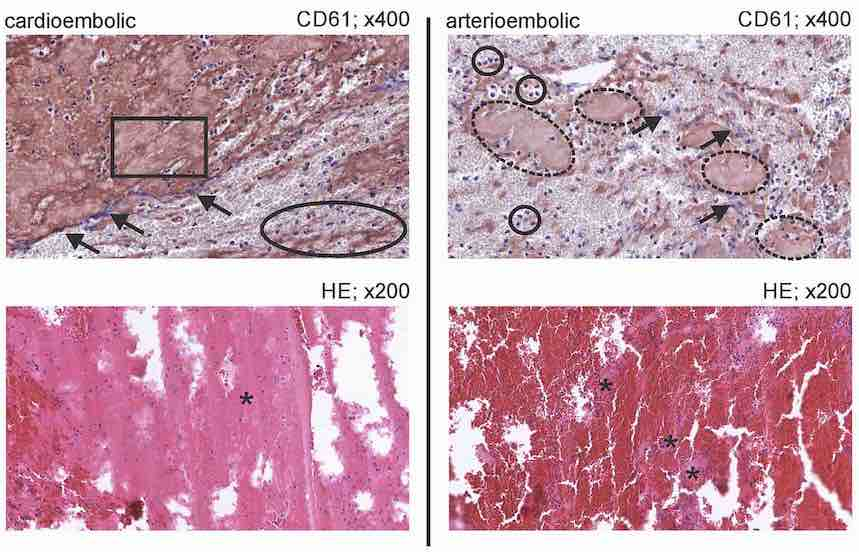

Histological presentation of typical cardioembolic and arterioembolic clots. For the two preparations immunohistochemical staining with CD61 (400-fold original magnification) and hematoxylin–eosin staining (200-fold original magnification) were prepared. The cardioembolic clot (left side) is characterized by a large number of platelets. Their distribution pattern reminds of stratus (rectangle) and cirrus (oval) cloud formations. Many disintegrated neutrophil granulocytes can be seen (arrows). Fibrin net is dense (star). This corresponds to a separation thrombus. In contrast, the arterioembolic clot (right side) is marked by a small amount of platelets arranged like cumulus clouds (dashed ovals). Apart from some disintegrated neutrophils (arrows), many intact neutrophils can be found (circles). Fibrin net is fine to coarse (stars). It is therefore an agglutinative thrombus that presumably arose from the tail part of a mixed-thrombus. Both emboli were extracted from patients with a definite stroke etiology. - <a href="https://www.nature.com/articles/s41598-021-87584-2.pdf?origin=ppub">www.nature.com/scientificreports</a>

### Notebook Goals:
* Look at image metadata from provided csv
* Open/read large tiff and reduce image size
* Segment images into patches of interest
* View hi-res patches
* Separate immunohistochemical staining (Convert color RGB to HED)

### Import Libraries

In [2]:
!pip install imutils
!pip install scikit-image
!pip install tifffile

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=5350f4d10e0f7802c5fa94595c4ff50105ba46738f96f220ac79611b0c86057d
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wji2au_/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 16.9 MB 15.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.2
    Uninstalling numpy-1.23.2:
      Successfully uninstalled numpy-1.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-tensorrt 1.1.0a0 requires torch>=1.11.0+cu113<1.12.0, but you have torch 1.8.1+cu111 which is incompatible.
torchtext 0.13.0a0 requires torch==1.13

In [7]:
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 17.1 MB 17.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-tensorrt 1.1.0a0 requires torch>=1.11.0+cu113<1.12.0, but you have torch 1.8.1+cu111 which is incompatible.
scipy 1.6.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.2 which is incompatible.
torchtext 0.13.0a0 requires torch==1.13.0a0+340c412, but you have torch 1.8.1+cu111 which is incompatible.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pandas as pd
import cv2 as cv
from imutils import paths
import skimage
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

from skimage.measure import regionprops, regionprops_table
from scipy import ndimage as ndi


import tifffile as tifi

from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Load Image Metadata

#### train.csv

In [3]:
train_meta = pd.read_csv('data/train.csv')
train_meta.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

In [4]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [5]:
train_meta.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

#### test.csv

#### other.csv

## Explore Image Data

#### train folder images

In [6]:
folder_path = 'data'
train_images = sorted(list(paths.list_images(folder_path)))
print('There are ' + str(len(train_images)) + " images in the train folder")
train_images[:5]

There are 754 images in the train folder


['data/006388_0.tif',
 'data/008e5c_0.tif',
 'data/00c058_0.tif',
 'data/01adc5_0.tif',
 'data/026c97_0.tif']

In [7]:
image_ids = [i.split("/")[-1].rstrip('.tif') for i in train_images]


In [5]:
import pyvips

### Open images
Read large tiff files using tifffile, return np.array and filename (image_id)

In [6]:
def read_tiff(path):
#     try:
#     image = tifi.imread(path)
    image = pyvips.Image.new_from_file(path, access='sequential')
    
    filename = path.split('/')[-1].rstrip('.tif')
    
    if image.height > image.width:
        t_1 = image.crop(0, 0,image.width//2, image.height //3)
        top_2 = image.crop(image.width//2, 0, image.width - image.width//2, image.height //3)
        m_1 = image.crop(0, image.height//3 ,image.width//2, image.height //3)
        m_2 = image.crop(image.width//2, image.height//3 ,image.width - image.width//2, image.height //3)
        b_1 = image.crop(0, image.height - (image.height//3) ,image.width//2, image.height //3)
        b_2 = image.crop(image.width//2, image.height - (image.height//3) , image.width - image.width//2, image.height //3)
        
    else:
        t_1 = image.crop(0, 0, image.width//3, image.height // 2)
        top_2 = image.crop(image.width//3, 0, image.width//3, image.height // 2)
        m_1 = image.crop(image.width - image.width//3, 0, image.width//3, image.height // 2)
        m_2 = image.crop(0, image.height//2, image.width//3, image.height // 2)
        b_1 = image.crop(image.width//3, image.height//2, image.width//3, image.height // 2)
        b_2 = image.crop(image.width - image.width//3, image.height//2, image.width//3, image.height // 2)
        
        
    return (t_1, top_2, m_1, m_2, b_1, b_2), filename
#     return image, filename

In [43]:
image, filename = read_tiff(train_images[15])

In [10]:
image.shape

(47940, 23047, 3)

#### Resize images
Downsize images significantly before segmenting

In [7]:
def resize_image(image):
    re_sized_image = cv.resize(image,(int(image.shape[1]/33),int(image.shape[0]/33)),interpolation= cv.INTER_LINEAR)
    return re_sized_image

In [12]:
re_sized_image = resize_image(image)

In [13]:
re_sized_image.shape

(1452, 698, 3)

#### Convert to Grayscale

In [8]:
def convert_image_grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    return gray_image

In [15]:
resized_gray_img = convert_image_grayscale(re_sized_image)

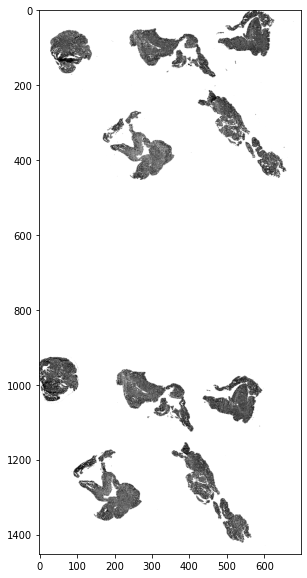

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(resized_gray_img, cmap='gray')
plt.show()

#### Image Segmentation
##### Label Segments
Let's find the edges in the image using the Sobel filter. All images appear to be high key, we'll mark areas in the image that we don't want to keep (areas that are greater than or equal to the mean) with 1 and areas that we want to keep (less than the mean) with 2. Then we'll use a watershed to get a labeled matrix from the elevation map (Sobel filter) and markers array. Lastly we fill the holes in segments and return an array of labeled segments.

In [9]:
def segment_images(resized_gray_img):
    elevation_map = sobel(resized_gray_img)
    markers = np.zeros_like(resized_gray_img)
    markers[resized_gray_img >= resized_gray_img.mean()] = 1
    markers[resized_gray_img < resized_gray_img.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers)
    filled_segments = ndi.binary_fill_holes(segmented_img - 1)
    labeled_segments, _ = ndi.label(filled_segments)
    return labeled_segments

In [18]:
labeled_segments = segment_images(resized_gray_img)

In [10]:
def plot_labeled_segments(labeled_segments, resized_gray_img):
    image_label_overlay = label2rgb(labeled_segments, image=resized_gray_img, bg_label=0)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image_label_overlay, cmap=plt.cm.gray)
    ax.set_title('segmentation')
    ax.axis('off')

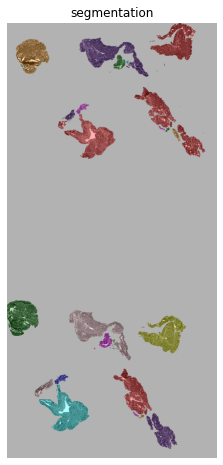

In [20]:
plot_labeled_segments(labeled_segments, resized_gray_img)

##### Object Coordinates
Let's get the coordinates (bounding box) and area for all labeled segments using regionprops_table. We'll scale the segment areas using StadardScaler and keep only those scaled areas greater than or equal to .75

In [11]:
def get_object_coordinates(labeled_segments):
    properties =['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    if len(df) == 0:
        return None
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.75]
    display(objects.head())
    object_coordinates = [(row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'] )for index, row in objects.iterrows()]
    return object_coordinates

In [22]:
object_coordinates = get_object_coordinates(labeled_segments)

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
257  11569    1207     105    1363     274        16417      26364   
148  11386     958     205    1126     412        19824      34776   
5    10958      49     241     180     471        19431      30130   
70   10880     304     189     453     361        15771      25628   
152   9843     976     436    1104     595        13198      20352   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
257         151.064068         117.998303      0.624388     6.116090  
148         251.346482          96.688265      0.923049     6.015943  
5           252.667400          95.783637      0.925360     5.781720  
70          147.252401         114.783558      0.626400     5.739034  
152         141.012153         114.023825      0.588345     5.171535

Let's plot the resized rgb image with bounding boxes surrounding areas of interest

In [30]:
def plot_object_coordinates(object_coordinates, re_sized_image):
    fig, ax = plt.subplots(1,1, figsize=(18, 16), dpi = 80)
    for blob in object_coordinates:
        width = blob[3] - blob[1]
        height = blob[2] - blob[0]
        patch = Rectangle((blob[1],blob[0]), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(patch)
        ax.imshow(re_sized_image);
        ax.set_axis_off()

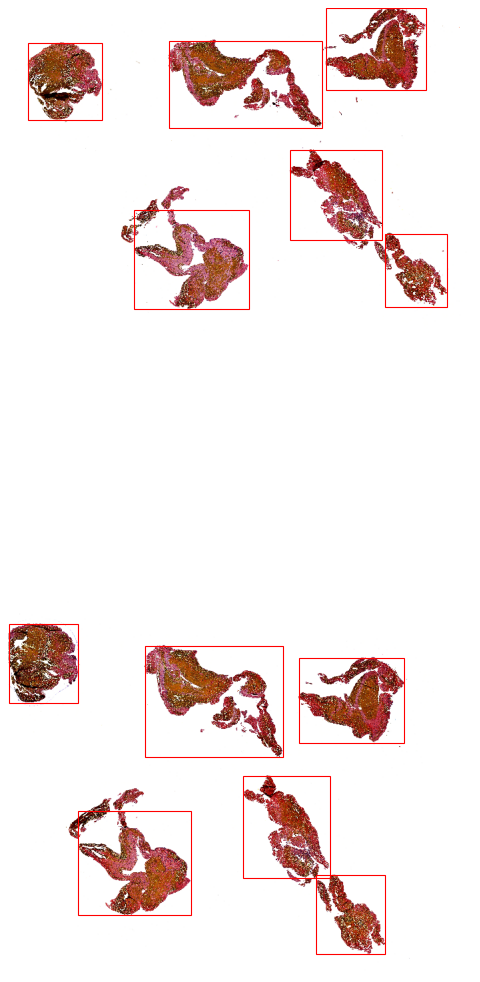

In [24]:
plot_object_coordinates(object_coordinates, re_sized_image)

Let's plot each object (area of interest) on a subplot

In [31]:
def plot_objects(object_coordinates, image):
    plt.figure(figsize=(10,18))
    for i in range(len(object_coordinates)):
        ax = plt.subplot(int(np.ceil(len(object_coordinates)/3)),3,i+1)
        coordinates = object_coordinates[i]
        # print(coordinates)
        object_image = image[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
        plt.imshow(object_image)
        ax.axis('off')
    plt.show()
        

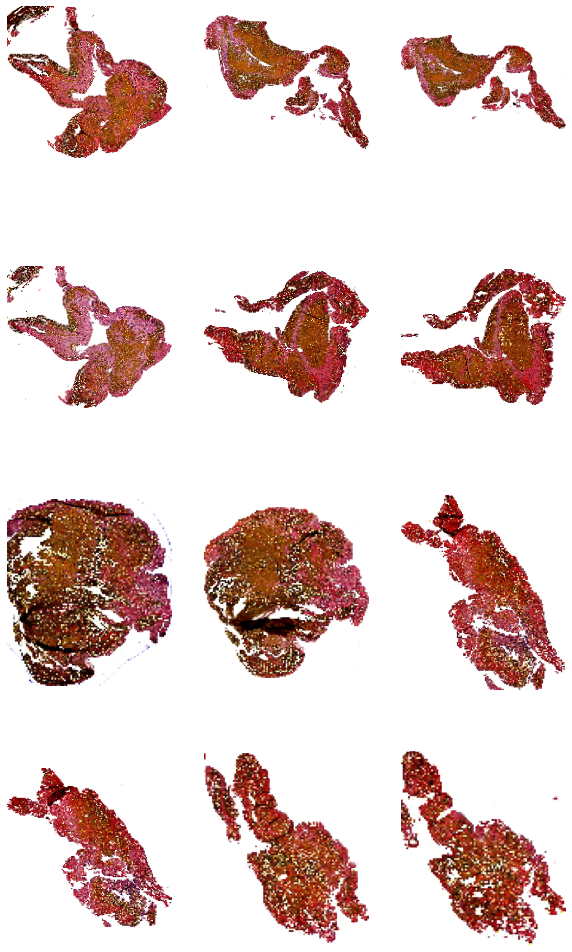

In [26]:
plot_objects(object_coordinates, re_sized_image)

Let's normalize the image coordinates from the resized image so they can be rescaled to original tiff dimensions then return a dictionary of patches (image_id, image_id + patch number, normalized coordinates, and rescaled coordinates).

In [12]:
def rescale_coordinates(object_location, image):
    top, bottom, left, right = object_location
    left = int(left * image.shape[0])
    bottom = int(bottom * image.shape[1])
    right = int(right * image.shape[0])
    top = int(top * image.shape[1])
    return top, bottom, left, right

def normalize_coordinates(object_coordinates, image):
    top, bottom, left, right = object_coordinates
    left = (int(left) / image.shape[0])
    bottom = (int(bottom) / image.shape[1])
    right = int(left) + (int(right) / image.shape[0])
    top = int(bottom) + (int(top) / image.shape[1])
    
    # object_location = top, bottom, left, right
    # top, bottom, left, right = rescale_coordinates(object_location, image)
    
    return top, bottom, left, right

def patches_dictionary(object_coordinates, re_sized_image, image, filename):
    patches = {}
    for i in range(len(object_coordinates)):
        coordinates = object_coordinates[i]
        normal_cords = normalize_coordinates(coordinates, re_sized_image)
        re_scaled_cords = rescale_coordinates(normal_cords, image)
        patches[str(filename)+"_"+str(i+1)] = [normal_cords, re_scaled_cords]
    patches = {filename:patches}
    return patches


In [28]:
patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
patches

{'0468a8_0': {'0468a8_0_1': [(1.7292263610315186,
    0.1504297994269341,
    0.9387052341597796,
    0.1887052341597796),
   (39853, 3466, 45001, 9046)],
  '0468a8_0_2': [(1.3724928366762177,
    0.29369627507163326,
    0.7754820936639119,
    0.2837465564738292),
   (31631, 6768, 37176, 13602)],
  '0468a8_0_3': [(0.07020057306590258,
    0.3452722063037249,
    0.12396694214876033,
    0.3243801652892562),
   (1617, 7957, 5942, 15550)],
  '0468a8_0_4': [(0.4355300859598854,
    0.2707736389684814,
    0.3119834710743802,
    0.24862258953168045),
   (10037, 6240, 14956, 11918)],
  '0468a8_0_5': [(1.3982808022922637,
    0.6246418338108882,
    0.7603305785123967,
    0.4097796143250689),
   (32226, 14396, 36450, 19644)],
  '0468a8_0_6': [(0.0,
    0.6833810888252149,
    0.08539944903581267,
    0.4318181818181818),
   (0, 15749, 4094, 20701)],
  '0468a8_0_7': [(1.326647564469914,
    0.0014326647564469914,
    0.71900826446281,
    0.07231404958677685),
   (30575, 33, 34469, 3466)]

Let's plot individual patches

In [13]:
def plot_patch(patch_name, cropped_image, cmap=None):
    plt.figure(figsize=(10,8), dpi=150)
    ax = plt.subplot()
    plt.imshow(cropped_image, cmap=cmap)
    ax.set_title(patch_name)
    ax.axis('off')
    plt.show()

def crop_patch(coordinates, image):
    x1, y1, x2, y2 = coordinates
    cropped_image = image[x1:x2, y1:y2]
    return cropped_image

In [30]:
# Read image metadata
train_meta[train_meta['image_id']==filename]


image_id  center_id patient_id  image_num label
15  0468a8_0         11     0468a8          0    CE

0468a8_0_12

11193 18688 14824 21757
47940 23047


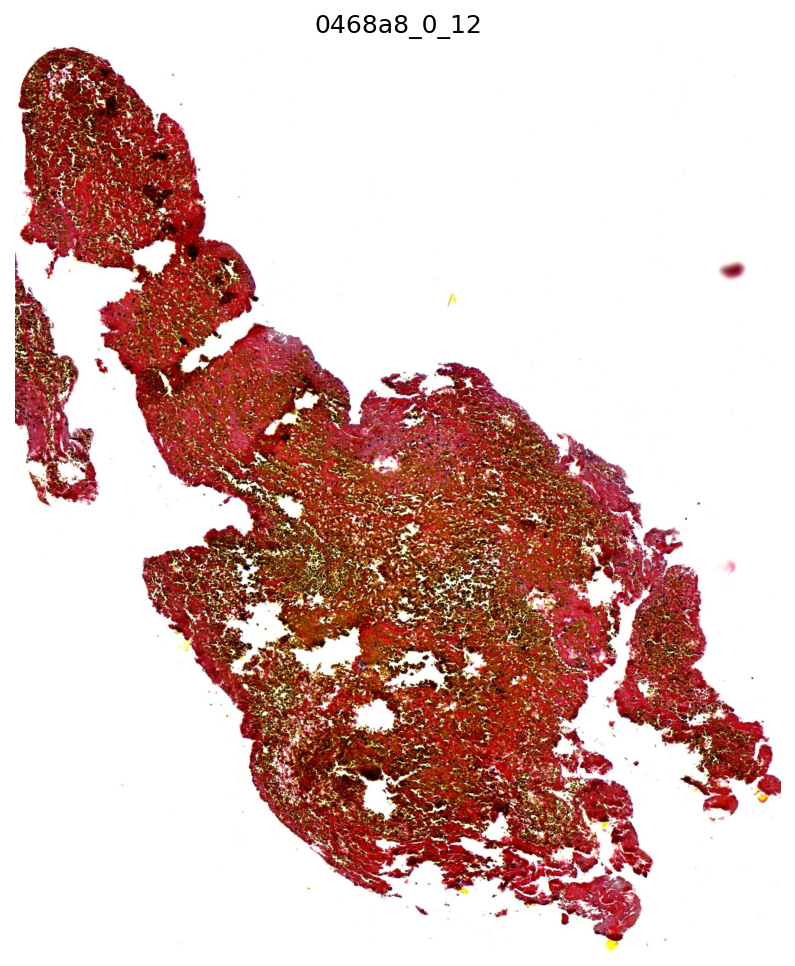

In [31]:
patch_name = str(filename)+"_"+str(12)
print(patch_name)
coordinates = patches[filename][patch_name][1]
cropped_image = crop_patch(coordinates, image)
plot_patch(patch_name, cropped_image)

### Simplify process
Run above in combined function

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

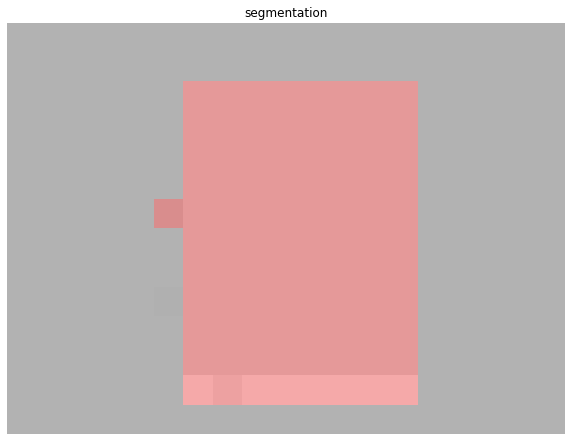

In [33]:
import cv2

def process_image(path):
#     image, filename = read_tiff(path)
    filename = path
    image = cv2.imread(path)
    re_sized_image = resize_image(image)
    resized_gray_img = convert_image_grayscale(re_sized_image)
    labeled_segments = segment_images(resized_gray_img)
    plot_labeled_segments(labeled_segments, resized_gray_img)
    object_coordinates = get_object_coordinates(labeled_segments)
    patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
#     print(str(len(patches[filename]))+" patches")
    cropped_images = []
    for i in range(len(patches[filename])):
        patch_name = str(filename)+"_"+str(i+1)
        coordinates = patches[filename][patch_name][1]
        cropped_image = crop_patch(coordinates, image)
        cropped_images.append([patch_name,cropped_image])
    return patches, cropped_images, filename

patches, cropped_images, filename = process_image('3.png')

In [34]:
# Display individual patches
for i in range(len(patches[filename])):
#     patch_number = 0
    image_meta = train_meta[train_meta.image_id==filename]
    patch_name = str(filename)+"_"+str(i)
    patch = cropped_images[i][1]
    display(image_meta)
    plot_patch(patch_name, patch)


In [35]:
len(patches[filename])

0

### Individual patch experimenting with color conversions...

#### Convert patch color RGB to HED
Separate immunohistochemical (ihc) staining

In [47]:
# Convert rgb2hed
ihc_hed = rgb2hed(patch)

In [48]:
# Separate hed channels
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

Plot separated stainings (Hematoxylin, Eosin, DAB)

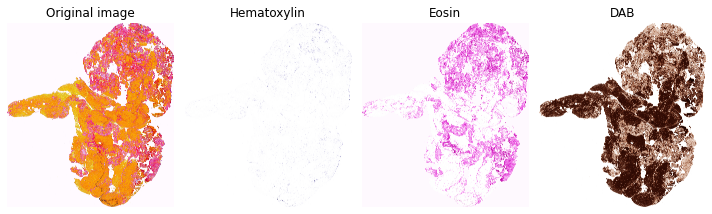

In [49]:
fig, axes = plt.subplots(1,4,figsize=(10,8),sharex=True,sharey=True)
ax = axes.ravel()
ax[0].imshow(patch)
ax[0].set_title("Original image")
ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")
ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")
ax[3].imshow(ihc_d)
ax[3].set_title("DAB")
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()

In [50]:
# Rescale hematoxylin and DAB channels and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 95)))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 95)))

# Cast the two channels into an RGB image, as the blue and green channels
# respectively
zdh = np.dstack((null, d, h))


In [51]:
zdh.shape

(12206, 11062, 3)

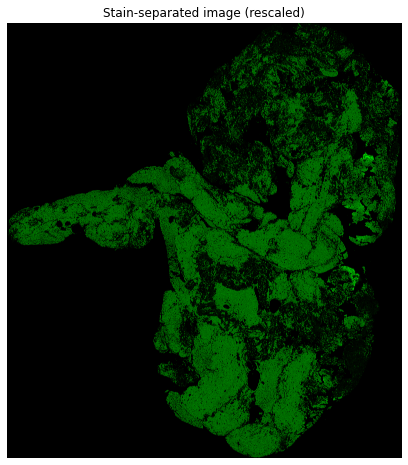

In [52]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.imshow(zdh)
plt.title('Stain-separated image (rescaled)')
ax.axis('off')
plt.show()

In [57]:
image_meta = train_meta[train_meta.image_id==filename]
patch_name = str(filename)+"_"+str(0)
patch = cropped_images[patch_number-1][1]
ihc_hed = rgb2hed(patch)
# Separate hed channels
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
# Rescale hematoxylin and DAB channels and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 95)))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 95)))

# Cast the two channels into an RGB image, as the blue and green channels
# respectively
zdh = np.dstack((null, d, h))


    
zdh.shape

(12206, 33186, 3)

In [60]:
len(train_images)

754

In [14]:
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage import img_as_ubyte

def hed_trans(patch):
    ihc_hed = rgb2hed(patch)
    # Rescale hematoxylin and DAB channels and give them a fluorescence look
    null = np.zeros_like(ihc_hed[:, :, 0])
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 0], 95)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 95)))

    # Cast the two channels into an RGB image, as the blue and green channels
    # respectively
    zdh = img_as_ubyte(np.dstack((null, d, h)))
    return zdh

from torchvision import transforms
from torch.autograd import Variable
data_transf = transforms.Compose([transforms.ToPILImage('RGB'),
                                  transforms.Resize((512,512)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean =  [0.485, 0.456, 0.406],
                                                       std  =  [0.229, 0.224, 0.225])])

import torch
import torch.nn as nn

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
model.classifier.fc = torch.nn.Linear(model.classifier.fc.in_features, 2)
model.load_state_dict(torch.load('models/model1.pth'))
# model = torch.jit.load('hed_model.pth')
model.classifier.fc = nn.Identity()
model = model.to('cuda')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [16]:
import os, glob
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(5_000_000_000)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET_FOLDER = "data/"

path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df = pd.read_csv(path_csv)
df = df.drop(['center_id', 'image_num'], axis = 1)
df = df[df['image_id'] != '6baf51_0']
df = df[df['image_id'] != 'b894f4_0']

class_0,class_1=df['label'].value_counts()

df_class_0=df[df['label']=='CE']
df_class_1=df[df['label']=='LAA']

df_class_0_under=df_class_0.sample(class_1)

df_train=pd.concat([df_class_0_under,df_class_1],axis=0)
dicti = dict(df_train['patient_id'].value_counts())
# display(df_train.head())

# !mkdir stain_train
import cv2

from tqdm.auto import tqdm

data = []
y = []

count = 0

for key, value in dicti.items():
    tmp = []
    count = count+1
    print(count)
    mini_df = df_train.loc[df_train['patient_id'] == key]
    for index, row in mini_df.iterrows():
        images, filename = read_tiff('data/'+str(row['image_id']+'.tif'))
        if images is not None:
            for image in images:
                image = np.array(image, dtype = np.uint8)
                re_sized_image = resize_image(image)
                resized_gray_img = convert_image_grayscale(re_sized_image)
                labeled_segments = segment_images(resized_gray_img)
                object_coordinates = get_object_coordinates(labeled_segments)
                if object_coordinates != None:
                    patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
                    cropped_images = []
                    for i in range(len(patches[filename])):
                        patch_name = str(filename)+"_"+str(i+1)
                        coordinates = patches[filename][patch_name][1]
                        cropped_image = crop_patch(coordinates, image)
                        cropped_images.append([patch_name,cropped_image])
            #         patches, cropped_images, filename = process_image('../input/mayo-clinic-strip-ai/test/'+str(row['image_id']+'.tif'))
                    del image
                    for i in range(len(patches[filename])):
                        patch_name = str(filename)+"_"+str(i)
                        imag = cropped_images[i][1]
#                             print(imag.shape)
#                             imag = cv.resize(imag,(1024,1024))
#                         print(imag.shape)
                        if imag.shape[0] > 2 and imag.shape[1] > 2:
                            if imag.shape[0] > 1024 or imag.shape[1] > 1024:
                                imag = cv.resize(imag,(1024,1024))
                            
                            imag = hed_trans(imag)
                            imag = data_transf(imag).float()
                            image = imag.unsqueeze(0)
                            out = model(image.to('cuda'))
                            tmp.extend(out.cpu().detach().numpy().tolist().pop())

# #                             rad_feat = rad(imag)
# #                             if rad_feat is not None:
# #                                 tmp.extend(rad_feat)
# #                             else:
# #                                 continue

    data.append(np.array(tmp))
    y.append(mini_df[mini_df['image_id'] == filename].iloc[0]['label'])
#             re_sized_image = resize_image(image)
#             resized_gray_img = convert_image_grayscale(re_sized_image)
#             labeled_segments = segment_images(resized_gray_img)
#             object_coordinates = get_object_coordinates(labeled_segments)
#             if object_coordinates != None:
#                 patches = patches_dictionary(object_coordinates, re_sized_image, image, filename)
#                 cropped_images = []
#                 for i in range(len(patches[filename])):
#                     patch_name = str(filename)+"_"+str(i+1)
#                     coordinates = patches[filename][patch_name][1]
#                     cropped_image = crop_patch(coordinates, image)
#                     cropped_images.append([patch_name,cropped_image])

#                 for i in range(len(patches[filename])):
#                     patch_name = str(filename)+"_"+str(i)
#                     patch = cropped_images[i][1]
#                     rad_feat = rad(patch)  
#                     if rad_feat is not None:
#                         tmp.extend(temp)
#                     else:
#                         continue

#     data.append(tmp)
#     y.append(mini_df[mini_df['image_id'] == filename].iloc[0]['label'])
#     if count > 1:
#         break
    
        
# df = pd.DataFrame(data = data,
#                  columns = ['image_id', 'label'])
# df.to_csv('new_train.csv', index = False)

1


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   371      72      31      89      71          529        680   
0   351      54      55      72      96          530        738   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          41.736648           17.54622      0.907337     1.793716  
0          37.087907           15.41952      0.909476     1.664206

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   404      76     132     101     166          628        850   
0    291      12     118      32     155          489        740   
6    183      34     108      52     132          240        432   
8    151      38      93      54     108          165        240   
20   133      88     166     109     181          178        315   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          30.049363          24.612023      0.573718     4.525446  
0           36.964767          15.553106      0.907174     3.140032  
6           26.899201          10.148269      0.926103     1.815918  
8           19.242597          10.353089      0.842926     1.423589  
20          23.595365           9.035767      0.923770     1.202903

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    515       7      61      45     105         1003       1672   
31   468      41      57      86      93         1145       1620   
35   222      45      47      75      62          290        450   
56   218      77      85     102     102          289        425   
26   200      33      51      52      74          295        437   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           52.836026          24.354641      0.887427     4.841481  
31          47.711849          31.775940      0.745955     4.365746  
35          28.200895          11.219489      0.917454     1.875727  
56          22.658080          15.650973      0.723098     1.835239  
26          23.596635          15.247873      0.763178     1.653043

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6    476       0     140      44     180         1056       1760   
0    320       0     125      36     143          482        648   
23   210      31     170      56     188          292        450   
10   144       1     143      23     163          225        440   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6           50.711177          25.406284      0.865447     4.039090  
0           40.255007          15.990672      0.917717     2.576014  
23          23.087315          15.264195      0.750253     1.544358  
10          29.605152           9.201672      0.950471     0.925364

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3900       8      65     108     164         6243       9900   
7  1698      78      97     134     146         2103       2744   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         115.379028          73.602347      0.770104     4.436165  
7          55.915963          41.974777      0.660670     1.751939

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8212      89      88     226     189         9737      13837   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          127.27853          93.640996      0.677289     4.690388

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5987     228      12     355     112         9182      12700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         136.536941          81.170382        0.8041     5.167826

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  8416     314      33     452     135         9899      14076   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         129.015738          93.802465      0.686572      5.09901

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   229     210     114     222     139          258        300   
2   150     207      83     222     101          209        270   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          25.265351          12.011187      0.879769     3.085984  
2          19.248489          12.690652      0.751874     1.869858

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
51  8223      75     102     214     232        11165      18070   
3   1166      25     177      78     233         2123       2968   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
51         138.585320         102.204569      0.675364     9.220013  
3           57.054826          50.240766      0.473916     1.188053

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  8835       8      23     183     158        13629      23625   
2   1147       0      84      43     151         2030       2881   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         148.062792         109.580049      0.672506    13.302453  
2           61.713147          40.498530      0.754554     1.646956

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    54903      31      31     511     267        70985     113280   
2     9781      27     284     164     395        12253      15207   
34    6941     124     336     365     415        11138      19039   
124   4985     394     299     511     398         7391      11583   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           453.308969         190.265693      0.907651    11.516220  
2           134.918046         104.602718      0.631586     1.955606  
34          192.114363          59.368749      0.951053     1.353857  
124         123.358825          66.864931      0.840355     0.939412

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   1312     245       0     304      33         1421       1947   
13   679     321       0     376      28          904       1540   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           55.034466          34.683902      0.776415     3.944985  
13          56.946181          21.518425      0.925857     1.874685

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  3576       0     279      63     376         4216       6111   
1  1429       0     170      22     263         1639       2046   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          98.519590          51.813392      0.850534     3.817267  
1          93.530792          21.878060      0.972258     1.331093

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  2518     471     228     511     324         3261       3840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          97.575061          39.318412       0.91522     6.164378

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    54999       3      15     493     295        72153     137200   
145   8751     302     314     505     405        11666      18473   
36    7598      71     287     274     412        13189      25375   
1     6906       0     225     104     334         8605      11336   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           463.553093         192.474737      0.909723    12.922155  
145         171.733291          71.854216      0.908260     1.966946  
36          197.807018          65.532643      0.943527     1.693824  
1           115.488335          90.919776      0.616616     1.529903

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   2206     264     220     348     278         3120       4872   
3   2120     125     212     173     274         2235       2976   
25  1688     289     181     348     238         2205       3363   
0   1233      71     228     126     278         1831       2750   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           85.753018          49.143738      0.819496     8.277075  
3           59.497470          45.998677      0.634260     7.948526  
25          56.654813          50.135610      0.465722     6.298140  
0           60.012870          37.750471      0.777373     4.559886

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64   6751     171     128     247     278         8296      11400   
25   4453      29     174     101     278         4860       7488   
110  3370     285      42     348     135         3643       5859   
32   2922     113      49     166     145         3633       5088   
20   2794      26      84      73     183         3120       4653   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
64          165.040443          59.147446      0.933575     7.185618  
25          111.447141          55.729664      0.865994     4.657950  
110          96.283107          45.931995      0.878875     3.466712  
32          102.561712          40.899316      0.917048     2.973938  
20           91.356708          40.927568      0.894035     2.833146

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13   30946      22       0     348     235        60506      76610   
152   6704     201       0     263     172         8917      10664   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          407.587868         204.874435      0.864489    15.028787  
152         179.372104          56.413423      0.949256     3.191874

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
559  13654      80      33     266     206        20860      32178   
713   2485     231     105     287     180         2777       4200   
621   1313      91     143     150     200         2196       3363   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
559         191.343277         117.180569      0.790540    26.470551  
713          76.420187          43.019599      0.826501     4.773872  
621          63.772412          36.436140      0.820709     2.497168

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   160       0      30      16      67          297        592   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          42.444878          10.179876      0.970813     6.081175

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5224       0       6      58     158         5462       8816   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         147.076135          47.396245      0.946652     3.316625

2


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   458      91     237     126     261          557        840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          39.881748          16.954469      0.905138     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  5718     184     107     257     256         7178      10877   
8   4363      71       0     136     128         5264       8320   
12  3708      92     151     160     247         4327       6528   
0   2240       3     117      74     194         3361       5467   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         140.774733          63.797409      0.891415     3.726547  
8          131.314062          47.568277      0.932082     2.750562  
12          87.274450          60.201376      0.724006     2.278776  
0           68.886325          59.460519      0.504916     1.221399

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   6334     218      52     291     261        10996      15257   
27  5125     352     102     418     253         6998       9966   
19  2566     292     197     345     261         2756       3392   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          235.099065          55.618535      0.971613     4.268650  
27         140.131832          59.058714      0.906851     3.395385  
19          65.046277          52.351830      0.593492     1.547010

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   644     296       0     326      31          687        930   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          35.641756           24.29202      0.731762     3.977686

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  1949     120     113     184     166         2376       3392   
8  1782     239     110     299     166         2330       3360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          62.106199          50.937910      0.572114     2.466435  
8          64.690016          44.759417      0.721987     2.218420

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   5737      17      19     113     124         6451      10080   
30  5676     244       0     344     162         8120      16200   
11  2043     121       0     188      41         2283       2747   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          114.563088          68.186731      0.803585     4.328548  
30         170.356712          54.618758      0.947210     4.279399  
11          68.039349          40.998503      0.798066     1.352225

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   795     329      93     353     140          883       1128   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          47.445941          22.424583      0.881259     5.385161

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5183       1      76      95     166         5704       8460   
41  4625     215       4     276     166         8400       9882   
13  3696     101       6     167      98         4400       6072   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          108.637419          63.595778      0.810748     6.204190  
41         190.790342          51.724082      0.962550     5.515958  
13          90.077157          58.528587      0.760139     4.370137

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57  2474     228       0     318      61         3178       5490   
18   645      90      19     118      53          687        952   
1    473      35       0      76      17          532        697   
20   345      94       0     122      22          445        616   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
57          93.285385          39.510342      0.905876     8.701445  
18          37.517125          22.211443      0.805912     2.143393  
1           40.362684          16.283408      0.915012     1.526671  
20          22.348880          21.772985      0.225550     1.067715

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
45  6631     417     243     518     339         7230       9696   
3   5567     120     190     216     294         6506       9984   
19  2467     265     222     316     307         3050       4335   
51  2431     495     295     540     370         2786       3375   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
45         108.697865          82.470282      0.651427     5.078171  
3          100.254647          76.741066      0.643482     4.217566  
19          90.774739          39.828249      0.898605     1.710162  
51          78.401911          45.225298      0.816858     1.681044

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   12706      13       8     152     177        16541      23491   
63   7221     259      50     378     189         9425      16541   
13   6184      92     115     251     200         9588      13515   
88   1844     507     213     540     286         2035       2409   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          153.119915         139.061453      0.418566     7.596492  
63         139.588872          78.571039      0.826542     4.225619  
13         176.022087          73.407442      0.908890     3.588318  
88          73.964106          33.003247      0.894930     0.921118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  5465     424     102     520     185         6380       7968   
19  4315     426     312     540     382         5835       7980   
7   1489     390     345     453     382         1557       2331   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         100.050936          75.765644      0.653101     5.901414  
19         124.310775          56.574262      0.890439     4.611900  
7           61.183665          32.727563      0.844911     1.443061

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  6644     402       0     538      91         7965      12376   
46  1782     505      10     540      92         2102       2870   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         121.170001          90.073902      0.668883     7.198175  
46          82.671781          33.402364      0.914743     1.788446

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   7037      81     273     224     382         9076      15587   
53   5607     164       3     243     105         6247       8058   
83   2856     246      41     304     115         3160       4292   
6    2355      17      67      62     155         2878       3960   
109  1994     356     328     410     382         2114       2916   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          137.216613          78.407471      0.820662     7.901805  
53          100.170202          76.508163      0.645475     6.250897  
83           73.706101          51.263952      0.718508     3.074920  
6            88.391664          38.629674      0.899448     2.496525  
109          64.024233          40.976289      0.768365     2.079758

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4449       0       7     115      93         7309       9890   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         150.834047          71.114742      0.881879     6.250737

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  3294     184     326     269     383         3804       4845   
30  2719     212      52     267     145         3392       5115   
0   1632      92     277     153     337         2084       3660   
47   843     277     163     325     241         1455       3744   
50   673     297      63     325     104          773       1148   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          88.103020          56.883372      0.763637     5.166323  
30          81.306152          49.678780      0.791624     4.216550  
0           74.966696          32.855512      0.898844     2.421066  
47          81.386321          20.528617      0.967666     1.117812  
50          37.386702          27.057591      0.690091     0.837010

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1185     190       0     252      41         1529       2542   
6   273     190      25     209      49          316        456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          56.562742          38.617710      0.730660     4.245073  
6          26.336251          14.048391      0.845848     0.754714

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  6025      69     144     132     302         6598       9954   
13  2579      29     105     100     165         3163       4260   
11  2513      13     169      78     222         2727       3445   
60  2192     284     302     325     383         2540       3321   
4   1706       5     211      61     284         2257       4088   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         154.917131          51.336643      0.943497     7.097085  
13          70.474344          52.317595      0.669997     2.895060  
11          66.148623          50.322732      0.649042     2.814580  
60          78.245745          38.732488      0.868887     2.423155  
4           89.488979          28.476849      0.948018     1.830530

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  4550     222     189     304     285         5585       7872   
14  1573     147     133     207     186         1824       3180   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34          87.809749           76.06122      0.499689     7.868809  
14          69.915561           30.87137      0.897236     2.603531

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  1967      49     330     130     374         2191       3564   
0    871       0     307      19     372          953       1235   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22          75.261358          35.081875      0.884714     5.916635  
0           62.349065          19.294366      0.950913     2.502333

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  5615     121      44     194     184         6278      10220   
25  2659      98       0     172      60         3206       4440   
22  2544      80      61     143     114         2734       3339   
15  1767      64      97     114     174         2297       3850   
1   1182      12      42      84     118         1936       5472   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         139.882940          54.556849      0.920807     5.733879  
25          71.922370          52.827884      0.678595     2.561425  
22          66.837730          50.389016      0.656988     2.438004  
15          90.095957          29.213503      0.945972     1.604108  
1           90.554272          23.365068      0.966139     0.976271

3


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  1442      28      37      75      78         1590       1927   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           48.31855          41.107571      0.525552      2.64575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  3346      24       0      75      78         3891       3978   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          88.325976          52.523627       0.80398     5.291447

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   681      27       0      75      20          788        960   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          48.334674          19.629853      0.913818     2.448278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   458       0      50      19      78          471        532   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          30.742759          19.709192      0.767457     2.999811

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   929       0       0      19      78         1442       1482   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          99.781772          17.818208      0.983927     3.162261

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   240      60      41      81      66          302        525   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          26.437357          15.435351      0.811864     3.605551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  1648      42       0      81      66         2026       2574   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           72.59468          32.963086      0.890966     3.741639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1097      40       0      81      41         1252       1681   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          46.504688          33.776296      0.687379     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1454       0      27      54      66         1696       2106   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          52.412864          39.629468      0.654454     3.316248

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2416       0       0      54      66         2760       3564   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          77.718322          45.773425      0.808158     3.741655

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   854       0       0      30      39          914       1170   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          39.608386          29.393461      0.670287     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
136   548      44      44      79      69          629        875   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
136          35.613324          21.240629       0.80267    15.587436

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  2764      25       0      79      69         3267       3726   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          78.182066          50.543289      0.762929     6.708137

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  2306      23       0      79      52         2603       2912   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28          58.350068          52.660972      0.430689     7.615388

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6     104       0      49      12      64          125        180   
7      38       0      62       6      69           40         42   
41     38       7      65      20      69           43         52   
245     9      40      52      44      57           13         20   
172     9      29      42      33      46           12         16   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
6            16.808223           8.646060      0.857554    19.596689  
7             7.564851           6.660975      0.474016     6.939041  
41           13.209753           3.905523      0.955295     6.939041  
245           5.241884           2.910889      0.831641     1.377347  
172           3.823256           3.265986      0.519875     1.377347

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1074       0       0      25      69         1268       1725   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          69.171169          24.281037      0.936365     9.591529

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   388       0       0      14      46          441        644   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          43.230253           13.39091      0.950815    15.253904

4


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    11758      49     159     258     271        18081      23408   
155  10478     446     175     586     281        11248      14840   
142   8156     412     118     642     220        10133      23460   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           219.647149         108.611962      0.869187     9.915596  
155         145.375988          97.615340      0.741033     8.823248  
142         266.411278          45.454659      0.985337     6.841661

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
171  13530     283      18     507     151        19856      29792   
2     4023      71     112     166     196         5485       7980   
239   2678     358     115     448     195         4157       7200   
292   1844     485       0     587      27         2130       2754   
398   1182     594      58     642     119         1862       2928   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
171         242.402220          95.843676      0.918513    19.232984  
2            80.041818          75.834165      0.319958     5.651791  
239         117.478308          46.291761      0.919091     3.730395  
292         103.025466          24.581006      0.971120     2.538987  
398          69.483505          29.406288      0.906030     1.593289

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60  7045     522      96     642     209         9413      13560   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
60         123.156684          90.930195       0.67444    14.727247

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
52  4837     545      45     642     140         6386       9215   
1    604       0      82      30     123          849       1230   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
52          97.492829          77.427962      0.607668    10.210924  
1           39.024559          23.103092      0.805928     1.167445

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
116  12695     324     136     461     275        13930      19043   
113   8400     310      72     535     198        10441      28350   
2     6102       0      95      91     208         8228      10283   
84    1354     160     251     256     281         1800       2880   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
116         157.319642         106.767933      0.734444    11.187845  
113         271.804964          44.849981      0.986292     7.360217  
2           128.038500          83.918981      0.755265     5.312279  
84           71.239732          31.804997      0.894808     1.080945

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
130  12818     137       0     368     116        18442      26796   
190   3124     214      76     299     158         4915       6970   
363   1238     443      93     516     144         2423       3723   
375   1032     466      33     501      88         1323       1925   
235   1006     302     112     379     141         1485       2233   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
130         257.594671          86.335827      0.942161    20.054415  
190         111.189158          58.292279      0.851557     4.824958  
363          80.184320          38.670811      0.876020     1.862016  
375          56.433250          27.823450      0.870011     1.538386  
235          76.321609          22.066892      0.957290     1.497540

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
89  7091     375     191     446     326         7893       9585   
26  6091     124     282     246     366         7944      10248   
57  5095     257     232     365     316         6325       9072   
4   2655      69     262     129     336         3309       4440   
43  2007     208     165     275     222         2447       3819   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
89         130.213292          71.766892      0.834407     6.404951  
26         120.834781          73.688032      0.792536     5.468622  
57         101.542223          75.931712      0.663941     4.536038  
4           71.027882          52.657621      0.671101     2.251395  
43          57.525489          49.672284      0.504378     1.644654

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   6426     115      50     247     147         8923      12804   
1   4575      73       0     198      70         5925       8750   
27  3722     224      92     318     178         5301       8084   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          118.622095          82.673049      0.717125     5.627794  
1          122.611601          66.978680      0.837611     3.934886  
27          92.680826          65.871093      0.703464     3.154739

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   1686       0     308      38     366         1942       2204   
62   844     420     244     446     293          937       1274   
0    820       0     227      16     300          931       1168   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           61.574548          38.295880      0.783062     7.135185  
62          47.862986          23.589753      0.870109     3.471818  
0           75.006941          15.350361      0.978835     3.367399

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  1041     418      48     446     103         1139       1540   
0    374       0       0      36      15          423        540   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35          55.294028          25.917386      0.883347     6.975887  
0           38.341223          13.709998      0.933883     2.389070

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  7997     106     115     225     222         9117      12733   
20  5353      74     216     170     316         6481       9600   
90  4598     226     145     300     255         5485       8140   
18  1311      60     334     149     366         1828       2848   
0   1171       0     231      30     290         1469       1770   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         126.263573          85.715673      0.734265     8.741954  
20         102.005494          76.802617      0.658105     5.793460  
90         104.607609          60.851577      0.813394     4.951510  
18          79.913827          28.389821      0.934769     1.285965  
0           59.911422          28.554315      0.879115     1.129842

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   11322      11       0     152     143        16977      20163   
40   6259     142      38     244     166         8794      13056   
77   3846     250      16     331     110         5342       7614   
1    1747       0      53      49     118         2261       3185   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          158.700288         127.614056      0.594467     8.837165  
40         118.400310          81.925676      0.721957     4.811892  
77          93.784155          65.168335      0.719130     2.893468  
1           57.780360          45.933478      0.606653     1.224685

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9    16715     127      71     534     217        33183      59422   
86    7101     335     213     461     364        11661      19026   
147   2386     620     317     698     364         2767       3666   
139   1567     553     324     625     364         1883       2880   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           474.970446          99.456671      0.977831    11.082600  
86          184.182940          81.123168      0.897778     4.631761  
147          76.539229          42.330256      0.833146     1.468072  
139          62.980972          35.781004      0.822943     0.918537

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  5262     382     100     486     206         6466      11024   
64  5090     556       0     698      50         5330       7100   
8   1704      86       0     131      64         1953       2880   
9   1358      92      88     130     164         1939       2888   
47  1294     453     238     494     283         1400       1845   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         127.002383          62.670581      0.869769     6.126953  
64         139.334760          50.404394      0.932275     5.918113  
8           71.554879          33.480836      0.883779     1.806877  
9           85.337072          27.642543      0.946084     1.386769  
47          43.555095          38.950212      0.447519     1.309061

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
43  5407     575      53     698     162         7478      13407   
23  2472     511     273     577     364         3121       6006   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
43         149.939861          58.150479      0.921733      8.55003  
23         108.209297          32.651990      0.953388      3.82090

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8    3255      15     182      80     267         3720       5525   
1    2736       0      88     103     152         4432       6592   
46   2045      74      87     162     133         2772       4048   
107  1306     505      29     549     102         1823       3212   
132   907     611     179     659     221         1388       2016   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
8            83.921044          54.492169      0.760510     7.977935  
1           115.251870          45.728251      0.917919     6.675194  
46           97.245837          33.775180      0.937748     4.940716  
107          83.924653          26.576720      0.948535     3.085753  
132          47.722987          36.488582      0.644515     2.084224

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10763       0      45     289     123        15490      22542   
21   7588      81     180     203     364        12460      22448   
72   2356     361     319     453     364         2943       4140   
56   1948     292     315     364     364         2234       3528   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          275.222745          69.358747      0.967725     7.192572  
21         210.828431          82.261000      0.920739     5.014727  
72          85.334961          41.057747      0.876646     1.425911  
56          67.809138          41.428064      0.791668     1.146050

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   5490     104      72     199     185         6422      10735   
11  5114     300       0     453      51         5386       7803   
27  3220     427     192     488     279         3667       5307   
24  2760     414      98     522     164         4449       7128   
5   1292     158     218     199     263         1433       1845   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          129.396418          61.130421      0.881370     4.856933  
11         140.219804          51.699639      0.929547     4.502988  
27          84.197594          53.474345      0.772425     2.720084  
24         120.233838          43.775691      0.931365     2.287067  
5           43.811922          38.914946      0.459404     0.905175

5


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    5491      66     247     175     332         7110       9265   
108  4057     302     216     425     284         5427       8364   
109  3015     304     276     437     332         4675       7448   
42   2975     197     162     283     228         3730       5676   
34   1573     173     258     244     314         2136       3976   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           110.478748          78.499895      0.703654     8.266246  
108         115.338727          57.285185      0.867940     6.055028  
109         141.936076          43.187439      0.952585     4.448272  
42           90.313083          50.164857      0.831547     4.386592  
34           71.573560          34.471605      0.876377     2.224718

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  11867     279      70     437     273        14051      32074   
10   8639     216       0     339     157        13636      19311   
38   5342     308       0     429      73         6683       8833   
1    3042      87       0     172      90         4585       7650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         249.816532          66.364639      0.964069     6.847395  
10         150.678297         106.943867      0.704454     4.927432  
38         123.826632          63.629753      0.857873     2.966430  
1           92.748163          61.525757      0.748297     1.598427

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  6998     348     195     437     332         8908      12193   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         135.027658          78.526902      0.813502     7.499814

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3961       0      44      71     135         4877       6461   
0  1546       0       0      69      39         1830       2691   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          90.763828          62.428987      0.725883     7.358441  
0          73.165622          28.450337      0.921302     2.759415

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
100  9717     151     216     346     332        15963      22620   
97   4047     145     152     267     223         5494       8662   
25   2934      38     107     124     175         3748       5848   
13   1525      19     202      88     259         2116       3933   
57   1511      94     155     136     245         2488       3780   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
100         197.007376         101.520567      0.857002    12.212816  
97          114.895623          57.833502      0.864079     4.991834  
25           91.527780          49.574632      0.840614     3.574382  
13           72.372775          32.899910      0.890701     1.779962  
57           96.518571          34.173415      0.935223     1.762132

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  9308     131       9     284     203        13612      29682   
12  6303      66       0     189      96         8545      11808   
59  1426     272       0     334      44         2117       2728   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         208.776658          70.514197      0.941236     7.480477  
12         118.857490          81.719376      0.726146     5.002789  
59          53.144349          46.520730      0.483462     0.981598

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16254       5       0     226     150        19122      33150   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         219.766662         110.508548      0.864377     3.316487

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3916       2       0      76      86         4259       6364   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          91.784381           58.55151      0.770099     4.241563

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  13007      74      24     249     150        14948      22050   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         177.092429         106.460737      0.799129     3.316514

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5774      73       0     150     128         6956       9856   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         143.981628          58.315901      0.914306     4.788918

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53  16457     309       6     442     199        18287      25669   
6   10531      31     147     284     232        13776      21505   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
53         192.836237         114.685181      0.803927     6.609431  
6          235.698931          67.848472      0.957672     4.163399

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  27253      61       0     447     145        42757      55970   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         428.125908         114.189996      0.963774    10.532453

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1695      42     185     108     232         2487       3102   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          67.290107          41.938364      0.782025     3.741639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  12728     311      34     447     194        15749      21760   
7    4807       0       0     109     113         8380      12317   
5    1306       0       2      80      53         2592       4080   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63         169.703825         115.497874      0.732669     9.025430  
7          148.536615          69.374894      0.884228     3.315855  
5          102.612799          34.667565      0.941201     0.792282

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12481     133      77     251     232        14971      18290   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         158.243998         115.813504      0.681448     5.916076

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   31718       0       0     402     212        67150      85224   
43   2257     141       0     244      34         2832       3502   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          462.032635         166.739632      0.932611    15.091906  
43         111.190532          35.178449      0.948633     1.005436

6


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  1541     107     110     173     156         1942       3036   
13   745     109      37     150      69          907       1312   
5    513      86      66     118     103          790       1184   
4    441      84     116     114     138          509        660   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          62.623124          34.339832      0.836244     5.023489  
13          38.940021          26.336050      0.736605     2.264687  
5           42.957218          21.092253      0.871156     1.460614  
4           28.393632          20.751488      0.682538     1.211074

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3761       0       0      85     102         5634       8670   
58  1533     134       0     196      39         1886       2418   
66   962     158      40     196      91         1412       1938   
30   607      53     131     101     156          915       1200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          118.603515          54.111652      0.889857     7.560210  
58          60.636282          35.387649      0.812038     2.959465  
66          50.279180          37.599001      0.663919     1.780369  
30          51.474057          23.001678      0.894604     1.047306

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3313       0      87     196     156         7896      13524   
10   736      62      39     109      70         1015       1457   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          142.997055          66.639257      0.884775     6.030604  
10          44.386368          27.478872      0.785325     1.146189

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  1363     119     121     177     156         1535       2030   
7   1092      57     118     101     156         1292       1672   
11   492      80     110     122     133          612        966   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          56.606273          32.896915      0.813794     3.850573  
7           41.883728          35.653086      0.524777     3.015029  
11          40.164023          18.052435      0.893297     1.165115

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   6261       0       0      98      94         6835       9212   
15  3729      82       0     179      84         5646       8148   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           96.057371          88.309304      0.393466     5.677821  
15          83.551618          77.647168      0.369246     3.294088

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  26983       0       0     196     156        30576      30576   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         202.881483         181.453186      0.447308     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  1231      21      32      68      78         1665       2162   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          56.927253           35.71619      0.778697     4.688631

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  5317     109       0     204      78         6045       7410   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         108.713041          71.542911       0.75294     3.140736

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11915       0       0     204      78        13557      15912   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         221.113362          79.530318      0.933075     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  1345     130      17     204      78         2187       4514   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          64.102938          33.428697      0.853261     3.605548

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  144890       0       0     409     383       156647     156647   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           485.4169         415.589313      0.516729     4.358899

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    2431       0     262      80     314         3050       4160   
112  2196      99     142     137     262         3429       4560   
78   1837      75     241     162     350         4020       9483   
28   1647      30     137     103     203         3322       4818   
168  1383     133      88     171     195         2765       4066   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            74.338612          45.811623      0.787546     8.724390  
112         119.719223          29.496861      0.969172     7.862574  
78          140.044718          39.398231      0.959612     6.546013  
28           67.915832          61.260231      0.431731     5.849225  
168         111.701825          28.864684      0.966036     4.881057

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  96814       0       0     409     383       156647     156647   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         516.574433         423.686574      0.572098    10.576729

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   2330      22      67      97     123         2919       4200   
51  1947      97      46     184     154         3881       9396   
73  1287     121       0     159      69         1838       2622   
9    842      29       0      83      62         1718       3348   
32   799      74      32     128      65         1381       1782   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           65.239398          47.994308      0.677346     7.366173  
51         143.221008          38.924598      0.962359     6.120644  
73          73.946197          28.421103      0.923188     3.974300  
9           76.947402          25.897767      0.941660     2.527144  
32          47.755018          29.095506      0.792966     2.387307

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    2476      37     273     125     326         3215       4664   
111  2202     153     158     192     279         3455       4719   
52   1895     114     259     211     362         3920       9991   
36   1464      88     148     161     210         2983       4526   
151  1377     192     107     236     213         2888       4664   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4            76.487647          46.050060      0.798452     8.971920  
111         121.897896          29.117210      0.971053     7.957973  
52          140.897751          39.820038      0.959233     6.821908  
36           69.721939          56.877011      0.578378     5.226976  
151         109.101419          31.240704      0.958126     4.905029

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  154190       0       0     409     383       156163     156647   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         471.389799         438.334203      0.367872     1.414214

7


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  2821      89      55     183     140         4672       7990   
9   1142      53     151      92     201         1331       1950   
34   841     164     165     204     203         1072       1520   
24   485     145     153     166     194          591        861   
81   428     223     111     259     131          489        720   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         115.686314          48.454241      0.908059     9.431117  
9           52.931030          29.912647      0.825005     3.669363  
34          43.347684          29.684302      0.728735     2.636434  
24          41.743350          15.913232      0.924486     1.414764  
81          37.166691          15.067423      0.914139     1.219159

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1738      78      44     133     109         2132       3575   
6  1240     148      73     197     117         1399       2156   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          58.741007          41.993298      0.699238     4.874750  
6          56.507756          29.497552      0.852940     3.398447

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28    50     337     180     344     191           54         77   
29    12     341     170     344     176           14         18   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28          10.657503           6.509933      0.791761     5.341330  
29           6.311030           2.657027      0.907054     1.019842

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19     2     316      86     318      87            2          2   
7      2      40      23      42      24            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19                2.0                0.0           1.0     3.082207  
7                 2.0                0.0           1.0     3.082207

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  2826      52      97     149     176         4618       7663   
6   1127       8     179      50     230         1329       2142   
47   781     118     209     156     246          962       1406   
41   482     101     194     120     236          592        798   
84   412     185     162     222     180          475        666   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         116.267684          48.129242      0.910299     9.211114  
6           53.063586          29.528715      0.830862     3.526701  
47          41.798555          28.951196      0.721287     2.369075  
41          41.319998          16.058251      0.921393     1.368699  
84          36.677560          14.750699      0.915564     1.134497

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   1690      14      83      70     146         2099       3528   
9   1223      82     119     133     160         1409       2091   
39   520     187      32     217      71          736       1170   
19   341     135      39     171      64          483        900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           58.168661          41.280537      0.704535     5.401572  
9           56.533498          29.209370      0.856182     3.831328  
39          42.028782          19.826756      0.881736     1.467556  
19          32.818479          14.973400      0.889852     0.865685

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8    578      36      41      71      80          831       1365   
28   383     110      92     127     133          565        697   
3    236      25      83      54     102          424        551   
4    140      29      76      50      89          188        273   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           34.612037          27.249719      0.616583     4.882064  
28          46.839060          15.143007      0.946297     3.121562  
3           32.827381          15.428765      0.882668     1.794414  
4           20.515096          10.190762      0.867897     0.927705

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
62    82     108       0     123      11          120        165   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
62           13.85346          10.953724      0.612223     8.398808

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   360       0      83      14     118          409        490   
1    37       0     124       5     133           39         45   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          36.624909          13.199168      0.932803     9.278696  
1           9.247555           5.243999      0.823671     0.819059

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9     49      15      79      26      88           63         99   
79     6      80      79      82      82            6          6   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           10.786891           6.747014      0.780238    10.021772  
79           3.265986           2.000000      0.790569     0.931781

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60     3     123      69     125      71            3          4   
31     3      26     121      28     123            3          4   
44     3      51      79      52      82            3          3   
15     3      16     105      18     107            3          4   
8      2       8     119       9     121            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
60           2.309401           1.333333      0.816497     3.190299  
31           2.309401           1.333333      0.816497     3.190299  
44           3.265986           0.000000      1.000000     3.190299  
15           2.309401           1.333333      0.816497     3.190299  
8            2.000000           0.000000      1.000000     1.388371

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  1128       8      25      47      87         1600       2418   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          66.542504          28.001824      0.907148      6.55551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  1481      40     113      83     159         1716       1978   
9   466     120     126     147     156          619        810   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          49.367737          42.616755      0.504775     3.688749  
9          32.446145          22.471048      0.721356     0.931694

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    704      35      37      72      68          854       1147   
11   367     101      42     139      58          483        608   
17   295     113      61     133      87          382        520   
2    171      45      71      66      83          203        252   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           36.924939          26.789800      0.688201     5.332618  
11          36.798326          14.341868      0.920924     2.634189  
17          25.212437          16.643799      0.751140     2.057670  
2           22.053083          10.694127      0.874555     1.064777

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  1487     423      50     466     101         1811       2193   
25   831     502     129     541     159         1002       1170   
15   548     431     135     467     159          641        864   
27   523     512      55     542      87          718        960   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          52.074890          41.261864      0.610059     4.705976  
25          38.086834          31.662294      0.555796     2.487509  
15          34.342443          22.198788      0.763003     1.530457  
27          34.619495          24.577550      0.704268     1.445911

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    690       8      43      47      75          888       1248   
20   354     440       0     474      18          448        612   
3    174      22      75      44      89          221        308   
24   162     518       0     538      15          237        300   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           37.107482          26.921500      0.688222     4.811566  
20          29.053890          18.378740      0.774500     2.310481  
3           22.875758          10.818992      0.881092     0.970614  
24          19.951681          13.878639      0.718417     0.881290

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1484     463      29     509      80         1830       2346   
11   547     459     114     494     140          644        910   
13   347     465     140     493     159          415        532   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          50.667864          41.938343      0.561155     4.487709  
11          33.617797          22.589700      0.740591     1.458182  
13          27.294468          17.913220      0.754504     0.811538

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5     4     481       0     485       1            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           4.472136                0.0           1.0      2.44949

8


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  9572     295      72     441     233        12018      23506   
4   7358      86     220     305     274         8849      11826   
1   2475      45     101     110     157         2813       3640   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         206.768190          68.416438      0.943671     4.460754  
4          230.430309          44.901461      0.980831     3.359763  
1           65.103025          52.098153      0.599678     0.931516

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   4789     159      81     242     182         5454       8383   
37  4179     299      50     403     141         5830       9464   
0   3965     132       0     305      33         4477       5709   
55  2073     423       0     484      54         2413       3294   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          112.027205          57.544837      0.857989     4.748793  
37         127.576225          57.015243      0.894578     4.110832  
0          173.963137          31.377587      0.983599     3.887023  
55          58.866025          49.426458      0.543138     1.908299

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  23235     410      32     571     274        27804      38962   
5   11045     171     166     376     274        12850      22140   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         243.491246         131.654150      0.841220     5.524561  
5          211.897456          73.015927      0.938756     2.498097

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  19376     463       0     571     244        21756      26352   
0    4331     210      36     281     146         4961       7810   
12   4102     349      48     443     153         5766       9870   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         235.506646         110.617647      0.882826     6.691067  
0          108.099390          53.851083      0.867084     1.337989  
12         129.083065          56.250790      0.900057     1.256509

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7544       0     159      69     303         7950       9936   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         145.172961          68.430716      0.881934     6.620279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18226     109       0     268     182        21254      28938   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         177.700601         148.511206      0.549128     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2549     549     157     577     314         3044       4396   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         142.794509          27.684038      0.981027     3.316622

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  14852     479      39     577     299        19279      25480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         258.922237          95.990577       0.92874     5.477035

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  38693       0      14     329     314        62721      98700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         427.818527         188.634494      0.897546     8.770785

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  17540     377       0     542     164        20470      27060   
2    7759       0     177     111     298         9483      13431   
0    3366       0       0      85      83         4377       7055   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         169.138139         154.874463      0.401934     8.147936  
2          140.056192          84.218508      0.799009     3.510239  
0          100.851460          56.077384      0.831156     1.427282

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31   16375     170      66     340     244        20325      30260   
110  11999     374     122     473     305        12634      18117   
7     5767     103     199     196     357         8456      14694   
93    5063     322     360     427     448         5368       9240   
127   3967     519     328     644     379         4570       6375   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
31          171.816683         134.106263      0.625131     9.023998  
110         184.929920          83.099682      0.893352     6.562905  
7           165.830170          55.467119      0.942402     3.057985  
93          118.468510          57.992103      0.871995     2.662050  
127         123.631006          43.859768      0.934956     2.045652

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
56   5766     218     144     324     229         6528       9010   
101  3547     353       0     467      55         3788       6270   
3    3269      44      23     110     114         3892       6006   
129  3061     507     145     580     211         3636       4818   
18   2810     110      46     187     114         3770       5236   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
56          100.724989          76.188518      0.654108     9.440097  
101         118.463751          40.297601      0.940365     5.731206  
3            94.004554          47.050052      0.865732     5.266550  
129          75.241833          54.572335      0.688441     4.918894  
18           82.571282          52.987574      0.766940     4.499366

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18   243     653     396     670     421          310        425   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          22.121487          17.177944      0.630083      4.53501

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
43   435     657      32     670      87          540        715   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
43          49.711633          12.630959      0.967182     6.782075

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
133  17460     378     265     566     440        21329      32900   
90    5984     251     229     410     317         8917      13992   
12    3409      33     239     132     298         4332       5841   
30    2725      65     308     131     389         3643       5346   
253   2617     524     381     583     448         2850       3953   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
133         172.048161         139.665516      0.583961    15.600758  
90          164.216794          59.390311      0.932311     5.269728  
12           96.397964          48.792653      0.862440     2.951638  
30           82.061839          52.066878      0.772936     2.335881  
253          66.322416          51.563325      0.628927     2.238656

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
97  11989     375      22     539     158        12626      22304   
59   8518     212      44     315     218         9427      17922   
1    5629       0       4      76     117         6459       8588   
94   4028     353     252     403     377         4698       6250   
21   3047      89     300     155     374         3664       4884   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
97         183.250439          83.783829      0.889359     8.017773  
59         191.697823          60.416772      0.949036     5.630945  
1          107.570215          69.282158      0.764971     3.644328  
94         127.458641          43.345362      0.940399     2.543402  
21          77.874789          53.213930      0.730113     1.868819

9


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  5416      13      96      87     240         7646      10656   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         131.642214          66.882182      0.861322     5.171907

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5207     263       4     348     148         7731      12240   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         128.164331          66.599755      0.854383     4.576655

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2277      16      58      86     109         3073       3570   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           74.52274          45.809634      0.788756     3.310441

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2510      11       0      87      90         4342       6840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          102.86656          55.090606      0.844501     2.235737

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    281     199      48     225      75          421        702   
2     84     191      87     199     109          124        176   
14    82     235     100     248     109           90        117   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           32.979074          16.054925      0.873501     3.816824  
2           25.081427           5.611702      0.974649     0.800276  
14          12.541536           8.891951      0.705208     0.769651

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4580     172       0     253     109         5742       8829   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         113.350363          62.172343      0.836152     2.235887

10


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57  6414     127      74     208     287        12124      17253   
22  3532      69     169     155     318         5817      12814   
95  2678     218     274     269     367         3818       4743   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
57         185.002418          60.395554      0.945212     8.492358  
22         148.053513          43.488833      0.955886     4.593491  
95          84.683030          52.295704      0.786534     3.438171

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
198  4064     220      31     269     164         4279       6517   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
198         116.542285           50.23021       0.90235    17.085133

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33   6740      51     293     180     384         7939      11739   
137  4805     202     275     269     384         5710       7303   
23   3358      30      72     180     208         7710      20400   
1    2804       0     206      63     305         4017       6237   
66   2005     127     186     205     257         2591       5538   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
33          130.071843          77.089654      0.805446     8.396302  
137         114.094575          64.514822      0.824782     5.928307  
23          187.242765          44.067090      0.971911     4.082732  
1            92.344345          59.500522      0.764745     3.376133  
66           97.288617          30.027520      0.951178     2.357048

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    28010       0       0     180     218        35148      39240   
102  13848     183       0     269     257        16961      22102   
60    5734      84     250     269     334         8978      15540   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           232.877492         186.487613      0.598936    11.182834  
102         251.475119          85.168303      0.940903     5.467279  
60          200.351606          49.533342      0.968956     2.192599

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  8358      22      80     144     283        16376      24766   
16  1346      18     306      64     384         2157       3588   
31   929      61     286     123     363         1650       4774   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         227.481091          95.718769      0.907164    11.133427  
16          74.478477          32.471419      0.899954     1.684965  
31          92.449469          19.238015      0.978109     1.123070

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12556       0       0      73     244        13460      17812   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         246.083077          70.571155      0.957997      8.62411

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
84  2858     244     144     334     233         4316       8010   
11   367      54     199      90     233          583       1224   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
84         117.028457          47.118593      0.915365    11.939018  
11          50.319840          13.619041      0.962678     1.446049

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   5825      40       0     151     186        13114      20646   
89  3155     314     102     349     233         3257       4585   
74   913     264     212     333     233          965       1449   
82   876     297      89     330     131         1008       1386   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          218.097761          96.350854      0.897124     8.439931  
89         122.792060          35.655338      0.956914     4.490026  
74          63.156703          20.799042      0.944217     1.173289  
82          38.154486          32.496225      0.524028     1.118553

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  17223     201       0     349     177        22122      26196   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         188.605659         164.976633      0.484634     8.062242

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  6313     127      58     231     233        13112      18200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         165.668943          97.700869      0.807596     9.998573

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11908       0      79     111     233        13267      17094   
17   7902     118       0     213     142         9999      13490   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          167.209318         101.178958      0.796147     6.946826  
17         136.339408          83.999935      0.787661     4.551321

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   15772       0       0     137     174        18239      23838   
44   6010     151     144     287     212         7102       9248   
45   4983     152      36     260     134         6259      10584   
12   2276      49     158     164     203         3277       5175   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          169.232380         138.142599      0.577643     7.698421  
44         139.059662          58.808836      0.906175     2.813442  
45         133.776612          53.573311      0.916311     2.299524  
12          96.813998          37.327952      0.922681     0.944921

11


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  6074      69      49     173     134         6521       8840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         101.345145          78.940386      0.627116     5.281282

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4809      29       0     141      65         5035       7280   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         111.800785          56.293026      0.863988      3.92874

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  7688     115       0     196     133         7960      10773   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         133.844584          79.922446      0.802145     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
38    17      53      24      58      29           19         25   
77     8     128      12     131      16            8         12   
81     6     145      53     148      55            6          6   
86     3     160      20     162      22            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
38           4.995710           4.384382      0.479340     8.653993  
77           3.464102           2.828427      0.577350     3.688953  
81           3.265986           2.000000      0.790569     2.585610  
86           2.309401           1.333333      0.816497     0.930597

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10312       0      30     154     134        12209      16016   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         158.118475          95.401733      0.797472      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7527       0       0      91     133         8676      12103   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         155.879204          78.810272      0.862776     4.472121

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  2237      96      51     130     167         2990       3944   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         140.267918          28.498525      0.979143     3.999998

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8455       0      44     130     160         9443      15080   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         156.088569          73.330729      0.882772     6.081185

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  10916       0      38     130     167        13682      16770   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          161.18003         104.811991      0.759695     5.291502

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  1745      51       0     130      41         1867       3239   
3    995       0      98      25     161         1102       1575   
1    453       0      22      33      40          490        594   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23          77.507814          34.291194      0.896807     5.688654  
3           63.577932          22.671558      0.934259     3.134292  
1           34.816479          17.759182      0.860127     1.288340

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2674       0     100      66     167         3752       4422   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           79.16348          62.008843      0.621642     3.740953

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2139       0       0      65      49         2353       3185   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          63.907158          48.270664      0.655351     10.77018

12


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    55461       0       0     725     624       249182     452400   
343  18960     300     206     725     302        27963      40800   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           885.184632         259.981256      0.955897    47.366227  
343         442.870678          61.944279      0.990170    16.174718

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
236   23612     213       0     346     295        34314      39235   
1231   6054     597     370     725     457         7092      11136   
1009   5700     526     502     710     624         8746      22448   
33     2450      25       0      34     624         4580       5616   
2       575       0     439      11     624          779       2035   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
236          329.366406         114.630250      0.937482    46.382962  
1231         147.495673          56.468009      0.923813    11.867556  
1009         224.012925          49.308054      0.975474    11.171665  
33           733.279376           4.759232      0.999979     4.782836  
2            202.899584           3.800028      0.999825     1.096972

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
946   8238     192     436     405     597        16108      34293   
0     7477       0       0      20     624        10361      12480   
20    3381      23       0      35     624         5524       7488   
2030  2776     401     506     491     572         3398       5940   
7662   479     685       0     725      29          570       1160   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
946          244.282079          83.796537      0.939324    62.872503  
0            605.204294          19.782267      0.999466    57.061805  
20           722.444397           6.517440      0.999959    25.786349  
2030          93.869744          44.450896      0.880773    21.166805  
7662          44.256624          16.272354      0.929952     3.627811

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4     19377       0     203     359     362        38392      57081   
333   11018      84     438     274     624        18948      35340   
1228   6659     712       0     725     624         7365       8112   
1      5415       0      50     165     130         7429      13200   
1189   2986     623       0     633     624         4888       6240   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
4            471.020188         132.395291      0.959684    27.925190  
333          277.132107          83.302024      0.953755    15.850917  
1228         719.764353          12.459466      0.999850     9.554500  
1            182.941616          48.084908      0.964839     7.757587  
1189         728.180963           5.896621      0.999967     4.248985

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
51   65319       8       0     713     624       264649     439920   
282  21941     216      67     504     307        44004      69120   
195  11475      74      92     173     274        12895      18018   
553   6752     713       0     725     624         7258       7488   
490   3176     510      60     595     117         3640       4845   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
51         1047.491791         237.221678      0.974019    21.838652  
282         330.420663         188.290059      0.821749     7.288804  
195         185.781939          81.141715      0.899579     3.778298  
553         719.526290          12.540767      0.999848     2.194109  
490          83.713131          49.810541      0.803715     0.994647

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1918  9963     707       0     725     624        10603      11232   
0     9390       0      12     379     180        33599      63672   
1153  5778     373       0     512     153         8605      21267   
1861  3207     623       0     634     624         5821       6864   
1906  1692     641       0     671     624         6021      18720   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1918         725.176414          18.507198      0.999674    28.512070  
0            438.696561         109.591497      0.968294    26.869468  
1153         225.449868          47.622991      0.977435    16.515060  
1861         727.456253           5.994553      0.999966     9.144854  
1906         724.321352           8.216286      0.999936     4.801850

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1685  14066     373     129     548     252        16016      21525   
862   12645     250     729     483     845        20091      27028   
1801  12259     395     283     530     494        17479      28485   
382   10823     111     579     371     709        19865      33800   
0      5838       0       0     548      22         9235      12056   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1685         187.621219         102.616703      0.837175    24.035014  
862          250.012886          79.852685      0.947622    21.600227  
1801         217.770928         110.300414      0.862241    20.938842  
382          256.722472          99.553878      0.921749    18.478353  
0            641.226496          13.574520      0.999776     9.936892

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6584  17538     241       0     486      94        17955      23030   
1979   3556      86     761     171     836         3958       6375   
9471   2066     494     549     548     616         2429       3618   
2488    800     104     722     140     760          964       1368   
9626    401     531       0     548      30          424        510   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
6584         239.181450          98.198777      0.911833    95.848165  
1979          94.685378          48.692322      0.857638    19.417861  
9471          77.804218          37.821360      0.873898    11.273021  
2488          37.131934          30.269226      0.579207     4.352640  
9626          31.398983          17.108038      0.838527     2.171573

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4254  10816     349     601     548     705        15173      20696   
3458  10630     192     465     452     590        19631      32500   
4468   8489     433      16     548     119         9150      11845   
4523   7203     463     225     548     360         8429      11475   
4457   4872     428     159     538     238         5992       8690   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
4254         224.728880          72.901364      0.945921    37.281111  
3458         255.281608          99.984628      0.920108    36.639295  
4468         122.136728          95.401797      0.624398    29.251509  
4523         133.791511          77.458528      0.815363    24.814007  
4457         111.790808          65.363198      0.811255    16.770602

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    18910       0       0     548     845       256645     463060   
121  18873     102     636     445     845        29806      71687   
2    13744       0     113     168     213        14797      16800   
37   10310      36     232     246     358        12034      26460   
148   9623     129     264     336     469        14961      42435   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          1194.972771         462.546025      0.922048    12.079966  
121         390.207307          94.276251      0.970375    12.056091  
2           182.105762          98.994494      0.839338     8.746436  
37          224.948761          67.846404      0.953432     6.530535  
148         317.311300          52.881999      0.986015     6.087226

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2665  14002     504       0     548     845        35448      37180   
2639   3260     494       0     505     845         6499       9295   
229    3248      43     817     224     845         3369       5068   
3      1338       0     553      32     616         1409       2016   
31      705       5       0      62      32         1084       1824   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2665        1021.598604          43.265652      0.999103    50.643640  
2639        1022.738972           5.310031      0.999987    11.764487  
229          166.911869          27.833122      0.985999    11.721054  
3             60.105119          31.603427      0.850607     4.808079  
31            55.731257          25.021595      0.893547     2.517025

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
186  21940     188       0     525     845       150841     284765   
0    16498       0       0     223     128        20443      28544   
113  15047     100       1     348     218        19386      53816   
680  12607     519       0     548     845        18772      24505   
194   9512     197     111     396     322        14838      41989   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
186         539.407696         297.669753      0.833946    16.177722  
0           256.433296         100.279188      0.920368    12.139406  
113         343.057994          72.492735      0.977418    11.062671  
680         960.379685          19.386129      0.999796     9.252033  
194         316.102746          52.008228      0.986372     6.955343

13


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   12557       6      60     143     232        16771      23564   
36   9247     194      65     379     181        15399      21460   
19   5771     112     130     201     232         7200       9078   
94   1498     304     199     382     232         1802       2574   
53   1462     245      29     302      90         2253       3477   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          190.491248          94.162167      0.869284     8.189298  
36         208.315466         109.486366      0.850744     5.985520  
19         112.741294          75.968555      0.738886     3.671220  
94          78.598698          27.910990      0.934825     0.826283  
53          56.243524          50.707962      0.432615     0.802315

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   12245      19      11     156     197        14926      25482   
24   4765     129      42     225     131         5722       8544   
52   3389     247       0     378      83         5288      10873   
26   1831     135       0     198      40         1934       2520   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          215.737625          83.162466      0.922716     7.998387  
24          94.024045          76.696642      0.578457     2.996103  
52         140.426625          49.350831      0.936212     2.075897  
26          63.667395          38.698432      0.794073     1.033977

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  8558     290      98     382     232         9647      12328   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         143.541777          84.552254      0.808102      7.80682

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  3523     332      47     382     181         4162       6700   
5  2225     326       0     382      52         2458       2912   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         126.985913          42.871761      0.941286     3.541681  
5          57.696148          52.175326      0.426872     2.101534

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  9576     122      90     308     205        15643      21390   
12  4527      42     162     129     232         4906       6090   
0   3030       0      92      68     232         5419       9520   
52  1486     170      53     228     116         2253       3654   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         209.660695         110.242137      0.850601     9.654661  
12          85.084738          69.731369      0.573005     4.480123  
0          150.181288          41.363256      0.961323     2.945902  
52          55.846997          51.710317      0.377699     1.363513

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   8898       0      46      95     230        10912      17480   
16  4881      65      73     163     162         5825       8722   
34  4875     184       0     322     108         7111      14904   
17  3209      69       0     134      70         3779       4550   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          187.246207          77.735712      0.909752     6.773912  
16          95.211816          77.713032      0.577752     3.614632  
34         181.901674          49.864278      0.961693     3.609913  
17          72.359518          61.972931      0.516216     2.299641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   10491      64       5     215     154        13973      22499   
3   10098      63     157     169     347        13030      20140   
50   4851     286     180     428     263         5739      11786   
32   4030     170      68     249     153         4600       6715   
76   3288     346      57     450     145         4791       9152   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          176.850181          90.738895      0.858339     6.080706  
3          212.826810          70.978662      0.942749     5.843023  
50         162.151002          39.882730      0.969280     2.669688  
32          83.005080          66.256581      0.602362     2.173155  
76         119.020163          45.574803      0.923783     1.724401

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   7995     419     245     586     364        13288      19873   
14  3299     469     150     586     208         4714       6786   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          194.083421         105.124503      0.840607     6.234735  
14         131.073430          44.280809      0.941206     2.439079

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    923     469       0     526      32         1292       1824   
11   361     525       0     570      12          410        540   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           57.583872          27.720138      0.876508     4.155991  
11          45.709308          10.996292      0.970632     1.441302

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  11537     168      97     253     291        13953      16490   
3    7412      32     214     126     360         9369      13724   
23   4731     130     287     230     364         5351       7700   
7    4415      74     133     150     228         5339       7220   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31         208.904492          80.372926      0.923027     5.338154  
3          155.010160          74.007214      0.878667     3.326150  
23         101.830428          64.109426      0.776943     2.018469  
7           90.406571          74.637429      0.564292     1.864338

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53  14208     481       0     582     323        21449      32623   
0    8621      43       0     210      92        10324      15364   
14   5915     367     164     474     291         9963      13589   
29   2989     421      70     538     141         4875       8307   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
53         287.876840          86.678367      0.953594     9.666766  
0          135.685179          87.348071      0.765231     5.804960  
14         140.808622          96.400962      0.728896     3.934539  
29         136.912822          48.133964      0.936163     1.912051

14


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12569       4       2     224     161        17323      34980   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         230.304362          89.625557       0.92117      8.18529

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12484     122     104     362     232        16545      30720   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         235.001161          84.745649      0.932714     8.485238

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   418     211       0     256      15          495        675   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          41.052221          14.507965      0.935471     4.472004

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  13042     205     111     460     226        17715      29325   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         231.533901          90.486507       0.92047     9.110374

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2244       2     101      94     148         2504       4324   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          83.487388          42.366835      0.861673     1.414213

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12482       0       0     135     148        14130      19980   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         174.868693          97.616326      0.829689     2.999999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1911     152     106     241     148         2147       3738   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          82.049679          37.568267      0.889018     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12686     150       0     289     148        14228      20572   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         179.454907          96.171015      0.844277     2.828427

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12403     283      12     437     148        13858      20944   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         182.043811           91.95831      0.863035          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1782     350       0     436      40         2110       3440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          68.155251          39.734527      0.812472     2.828427

15


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  5362     212     157     336     232         6818       9300   
11  4666     148     112     248     203         5812       9100   
2   2510      91     187     196     232         3255       4725   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         117.168429          71.793445      0.790287     3.770831  
11         102.059101          67.715111      0.748186     3.239671  
2          112.503890          38.378323      0.940017     1.594295

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  35952      91       0     447     181        49689      64436   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         377.789787         152.807874      0.914547     7.712588

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  13149     307      55     447     232        18105      24780   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         171.879516         119.813943      0.716992    20.338586

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10019       0      22     108     173        11512      16308   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         145.965945          96.165352        0.7523     8.484436

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   24353       0      60     214     232        30832      36808   
27   6025     251     154     394     232         7419      11154   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          218.928684         164.639252      0.659138     5.147260  
27         125.293978          77.574778      0.785279     1.078364

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19674       0       0     407      84        25477      34188   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         403.905599           75.11598      0.982555     7.873992

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  14152     137       2     307     166        17214      27880   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         206.293318         105.827159      0.858392     4.242638

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17728       7       0     276     129        25750      34701   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         295.233365         122.646797      0.909628     5.196152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   600       0       1       6     101          600        600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          115.46428           6.831301      0.998248          1.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  14774     106       8     323     166        19554      34286   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         224.005783          107.83799      0.876497     5.291457

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18075       0       0     280     128        26234      35840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         303.320774         123.504979       0.91335     4.123106

16


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   13845      49     220     156     415        15888      20865   
27   8055     233     243     308     415         9360      12900   
3    4420      24      47     132     129         4901       8856   
39   4148     323     292     415     383         5507       8372   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          198.846854          93.560793      0.882391     5.629470  
27         181.116580          62.345830      0.938885     3.160864  
3          117.365329          51.701279      0.897745     1.611057  
39         110.830147          65.722440      0.805201     1.495088

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   63516      65      61     463     384        85913     128554   
6    7310      32       0     121     129         8442      11481   
31   6426     198       0     375      56         8641       9912   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          352.044968         268.267872      0.647545     9.056901  
6          127.640817          78.644205      0.787639     0.922264  
31         192.226921          55.377837      0.957605     0.794324

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   15985     164     185     267     415        18886      23690   
19  14863     322     201     495     415        23463      37022   
1    4319     136      11     243      94         4815       8881   
35   3920     436     242     522     337         5309       8170   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          239.090536          91.367124      0.924103     4.699239  
19         239.637212         134.277629      0.828265     4.350779  
1          116.765727          50.890212      0.900028     1.076131  
35         107.132090          65.186774      0.793576     0.952214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  63945     197      18     589     347        87454     128968   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         348.734633         273.113494      0.621826      9.22158

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   11954      79     172     200     332        15687      19360   
11   9573     113       2     215     159        10579      16014   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          181.942656         104.323349      0.819285     4.244196  
11         176.792176          73.964230      0.908278     3.340238

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1760      79       0     173      26         1855       2444   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          89.104439          27.204705      0.952252      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   937     237     314     321     332         1016       1512   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          76.441883          17.506004      0.973424     3.605548

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  18936     209       0     397     214        28593      40232   
2   8058     195     178     316     325        10210      17787   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         248.551821         148.614522      0.801555     7.624165  
2         173.488320          73.347828      0.906231     3.148110

17


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  16172      70      11     264     181        22425      32980   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         199.991263         131.677566      0.752654     4.505043

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  5842      20       0     115      92         6789       8740   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          95.935273          87.976034      0.398806     5.808675

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  9964     330      81     496     181        11771      16600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         153.127111         104.768242      0.729303     3.337596

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7122     287      61     386     172         8359      10989   
7  6700     337       0     524      74        10480      13838   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         103.876414          94.699814      0.410949     2.535409  
7         181.019849          87.421333      0.875655     2.360887

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  7819     168      12     266     127         9152      11270   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         121.229628         100.811076      0.555418     3.641906

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  9714     314      38     490     155        13486      20592   
0   8606      18       8     157     153        11372      20155   
15  4106     164       0     229     124         5828       8060   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         168.141419          96.063028      0.820725     4.106095  
0          169.780739          84.068315      0.868803     3.604279  
15         132.172189          55.399438      0.907919     1.566216

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  7787     200       3     299     118         9177      11385   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         120.937046         101.317029      0.546028     3.073921

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  9760     357      20     532     140        13553      21000   
0   9116      61       1     195     152        11436      20234   
8   4031     202       0     270     114         5565       7752   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         168.890182          97.208511      0.817751     3.207095  
0          167.438047          82.185135      0.871250     2.971165  
8          121.627177          59.125227      0.873893     1.108274

18


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  2724     199     176     271     264         3223       6336   
16   736     179     146     214     176          874       1050   
2    469      53     246      95     264          539        756   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20          98.845952          37.672477      0.924524     7.060135  
16          37.381601          29.565218      0.611942     1.762988  
2           37.774243          18.016810      0.878925     1.051550

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   12155      27       0     266      80        14714      19120   
38   4912     518      81     603     175         6015       7990   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          237.122727          75.197563      0.948384    10.232397  
38          93.781308          73.339250      0.623248     4.061026

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  4275     468     172     600     251         5627      10428   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         152.680127          41.198938      0.962906     9.630538

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  13792     413       0     602     163        17620      30807   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         220.382581          93.948479      0.904583     8.543993

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  4203     463      53     563     168         5205      11500   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         151.185886          40.396195      0.963642    12.081976

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5     5      12      88      14      92            6          8   
9     5     516      30     519      32            5          6   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           4.341695           1.276589      0.955796     1.964545  
9           3.098387           1.788854      0.816497     1.964545

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
90   8739     253      63     376     200        11619      16851   
8    4977      91     102     179     200         6094       8624   
111  4364     307     263     395     343         4898       7040   
105  3294     298      51     406     136         3538       9180   
113  2333     324     180     402     235         3035       4290   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
90          137.996845         111.261493      0.591560     8.240351  
8           100.494059          70.612937      0.711528     4.582012  
111          89.525937          68.053195      0.649747     3.985903  
105         128.111045          33.979209      0.964184     2.945387  
113          78.048863          44.549257      0.821098     2.010867

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   144     342       0     357      12          152        180   
9   103     361       8     376      23          143        225   
8    82     361       0     383       5           94        110   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          14.647602          12.718804      0.496005     2.376422  
9          18.825513           9.578834      0.860872     1.531624  
8          23.698071           4.753084      0.979680     1.098923

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
88   8533     212      93     333     228        11040      16335   
4    4970      91      97     168     239         7400      10934   
15   3492     116     226     209     342         6770      10788   
92   3339     228     303     307     378         4677       5925   
116  3175     285      91     364     196         3465       8295   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
88          137.601637         106.357309      0.634484     9.727710  
4           144.921460          54.594966      0.926327     5.576532  
15          116.719988          76.994735      0.751570     3.854544  
92           78.975904          66.356814      0.542252     3.676287  
116         122.219341          34.379853      0.959621     3.485214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12   989     216      11     273      46         1392       1995   
56   679     459       0     511      36         1185       1872   
70   469     486     122     511     151          555        725   
63   179     473     127     489     148          218        336   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          61.733887          25.743762      0.908901     7.268358  
56          45.727488          31.575985      0.723308     4.917403  
70          30.921758          21.148156      0.729553     3.324820  
63          23.341890          10.767708      0.887242     1.125538

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  8862      47     228     171     354        11256      15624   
0   2026       0     219      42     329         2789       4620   
11  1817      12     246      66     354         3149       5832   
44  1615      63     352     121     403         2028       2958   
2   1192       0     342      30     413         1636       2130   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         136.741522         108.246179      0.611025    10.233694  
0          110.881796          34.861631      0.949289     2.216398  
11         116.442734          30.236472      0.965698     1.971282  
44          56.251135          40.944728      0.685692     1.734375  
2           76.071332          27.194751      0.933917     1.238279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
221  8438     356      10     467     190        13134      19980   
54   3544     219     103     317     195         6001       9016   
64   3156     231       0     320      91         5280       8099   
9    2541       4       7      74      76         3291       4830   
163  2248     319      19     378     120         3588       5959   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
221         181.319096          83.010526      0.889048    14.625283  
54          108.195952          68.389616      0.774895     6.058743  
64           89.284949          75.144321      0.540065     5.379581  
9            75.220250          49.757440      0.749954     4.303075  
163         110.214746          37.305199      0.940975     3.790203

19


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
93   5756     158      91     296     165         7030      10212   
166  5021     313      75     420     147         6010       7704   
37   4898     100     197     220     296         7312      11880   
142  2852     257     144     317     223         3108       4740   
9    2055      65     139     119     209         2529       3780   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
93          130.015533          63.133323      0.874191     8.013653  
166         105.811967          66.092220      0.780929     6.966475  
37          124.460617          66.970925      0.842888     6.791233  
142          72.472880          52.575696      0.688271     3.876232  
9            78.331495          37.338613      0.879080     2.740721

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   1479      98      88     150     137         1771       2548   
9    1318      93       0     160      34         1956       2278   
21   1024     141      97     193     132         1339       1820   
30    966     163      27     204      74         1536       1927   
108   873     406      86     434     137          953       1428   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
11           46.033820          42.960149      0.359279     6.080843  
9            68.805597          34.759777      0.863009     5.388755  
21           56.437099          27.726986      0.870996     4.124941  
30           50.406218          42.634042      0.533486     3.875618  
108          46.824354          25.836127      0.833998     3.475840

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
74   5541     208     101     345     171         6667       9590   
136  4879     362      84     467     154         5818       7350   
34   4862     153     210     272     303         6813      11067   
115  2812     307     150     368     230         3052       4880   
11   1943     114     153     168     224         2475       3834   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
74          129.336636          60.837942      0.882462     6.986295  
136         103.910973          65.649761      0.775141     6.126596  
34          125.113742          63.223912      0.862925     6.104519  
115          72.834216          51.391814      0.708610     3.442308  
11           78.248103          35.259509      0.892720     2.313791

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37   2427     153     101     247     149         3284       4512   
28   1917     133       0     208      49         2794       3675   
73   1080     215      32     256      85         1647       2173   
90    923     284       0     343      32         1081       1888   
135   838     449      94     478     144          936       1450   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
37           98.821554          37.642106      0.924612     8.283085  
28           67.803276          52.623222      0.630590     6.497846  
73           51.142256          45.722539      0.448014     3.567954  
90           60.424450          21.348143      0.935509     3.018381  
135          45.636268          25.513275      0.829129     2.720841

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  5587     254     123     393     194         6813       9869   
72  5007     409     103     513     174         5902       7384   
17  4838     202     232     321     315         6501       9877   
63  2702     358     174     418     252         2996       4680   
12  2008     162     171     215     242         2492       3763   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         130.999692          61.093575      0.884593     5.232170  
72         103.548047          67.194798      0.760853     4.660825  
17         124.036658          61.748574      0.867277     4.494347  
63          72.251829          50.425423      0.716183     2.390222  
12          79.760642          36.079550      0.891842     1.706578

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   2719     181       3     253      69         3458       4752   
10  1380     198     121     248     169         1706       2400   
52  1145     333      13     390      59         1345       2622   
34  1074     262      55     303     107         1654       2132   
24  1003     239     129     291     164         1339       1820   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           75.389208          52.811008      0.713641     6.858142  
10          45.245985          41.668082      0.389744     3.331168  
52          64.905701          24.502857      0.926004     2.712169  
34          52.328009          45.051380      0.508703     2.525153  
24          56.670051          28.189134      0.867507     2.338136

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  11134      92     103     276     231        14302      23552   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         174.232832          94.540803      0.839984     6.999048

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  13445     157       0     347     114        16834      21660   
70   1470     333      25     383      68         1707       2150   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         175.287420         116.069482      0.749357     9.531452  
70          50.951154          39.707242      0.626626     0.934862

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12439     195      88     364     231        15596      24167   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         184.158287          97.461167      0.848482     7.069798

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  11433     270       0     442     109        15287      18748   
52   1488     435      18     485      65         1808       2350   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         167.591612         110.398056      0.752377     8.293264  
52          51.874860          40.156261      0.633065     0.956958

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  7456     314     140     440     231         8697      11466   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         114.691174          90.543097      0.613813     3.999693

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   15612     359       0     526     231        26292      38577   
30   1567     466      39     530     131         3320       5888   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          226.953369         111.942368      0.869894     9.132737  
30          93.133753          47.326241      0.861267     0.797010

20


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  11293     134     162     261     328        13835      21082   
7    6045      56      51     171     154         7844      11845   
0    2403       0     142      66     222         3322       5280   
49   1997     224     147     285     219         2736       4392   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         160.424965         100.097769      0.781461     7.507284  
7          115.783270          77.769401      0.740841     3.914128  
0           81.270546          61.643280      0.651679     1.420555  
49          74.496798          43.334351      0.813408     1.142578

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   10688      17      19     181     194        14928      28700   
0    2795       0      17      43     146         3492       5547   
45   2007     181       1     244      52         2390       3213   
4    1375      11       0      73      33         1525       2046   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          224.184415          80.915971      0.932591     7.905178  
0          123.203153          34.794325      0.959293     1.927913  
45          65.232040          43.006657      0.751891     1.331172  
4           59.805952          31.357581      0.851520     0.852566

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  10502     208     314     365     415        12083      15857   
8    5535      95     260     174     381         7171       9559   
39   1554     268     237     338     306         2496       4830   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         158.614627          92.948533      0.810309     7.141486  
8          109.504511          74.856874      0.729860     3.666367  
39          85.158614          36.953959      0.900940     0.881095

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
107  10725     319     129     408     338        14956      18601   
2    10009       7       0     155     119        12380      17612   
43    7592     221     221     319     360        10532      13622   
13    4841      95     190     172     304         6196       8778   
47    2765     231     153     301     222         3381       4830   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
107         219.143847          80.952197      0.929270     7.693012  
2           148.259897         100.587399      0.734644     7.166961  
43          138.192696          93.313590      0.737596     5.391171  
13          110.979980          62.584255      0.825827     3.369989  
47           73.192603          53.516834      0.682187     1.844735

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  2822      70      32     150      91         3072       4720   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           71.65407          57.716107      0.592619     3.735904

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4051      45       0     152      58         4776       6206   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         112.462348          54.572439      0.874375     4.582549

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     2     146      42     148      43            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0                2.0                0.0           1.0          1.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6237      32      16     154      91         6847       9150   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         115.950599           70.23659      0.795658     4.582574

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   927      49       0     119      29         1375       2030   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            65.5715          22.409232       0.93979     2.236067

21


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  24810      12       8     211     245        34517      47163   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          280.47486         148.971774      0.847283     4.242641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   11872      88     259     213     431        13657      21500   
10   3518     216     319     297     385         4009       5346   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          148.296371         109.147033      0.676975     3.994049  
10          84.290716          56.561599      0.741430     0.926790

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  22324      77     285     316     466        26935      43259   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         264.720713         127.715496      0.875921     3.739687

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   11460     226     183     347     352        13186      20449   
17   3361     350     239     429     302         3801       4977   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          147.479342         105.918299      0.695846     4.317247  
17          82.795388          54.937485      0.748147     1.028020

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  20665     200     286     458     466        30374      46440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         289.124581         130.525456      0.892296          4.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3545     248       0     405      35         3753       5495   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         145.427212           34.12285      0.972083          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  22113       0     357     162     563        24422      33372   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         224.951803         130.230647      0.815379    12.405632

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    5848       0       0      95     406        10252      38570   
292  4790      78     206     139     340         5794       8174   
0    4203       0       0      55     103         4317       5665   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           456.782159          22.608703      0.998774    19.541500  
292         142.213208          47.916621      0.941528    15.994275  
0           108.731472          52.483408      0.875792    14.026202

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1145  4765      76     373     136     507         5784       8040   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1145         142.658504           47.33552      0.943346    46.625846

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    13173       0      65      94     526        22871      43334   
147   4902      62      31     119     175         5924       8208   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           400.803835          78.413444      0.980676    20.976083  
147         145.051812          48.202873      0.943169     7.767762

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
65    4573       0     396      93     528         9094      12276   
59     789       0     404      35     452         1330       1680   
76     465       0     511      34     538          675        918   
4995   190     108     449     128     473          323        480   
1587   112      36     525      54     540          177        270   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
65           131.116173          80.416830      0.789831    85.335832  
59            49.023702          31.773527      0.761533    14.679314  
76            28.979070          24.071674      0.556784     8.629443  
4995          21.916585          16.464198      0.660051     3.494521  
1587          16.125436          12.946698      0.596148     2.038071

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7325    17     151      44     155      50           18         24   
7338    17     151     278     158     285           31         49   
1840    17      34     104      39     109           19         25   
7640    16     158     283     162     291           21         32   
1202    12      21     456      26     460           13         20   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7325           5.366360           4.047055      0.656699    17.116143  
7338           8.378080           5.706321      0.732189    17.116143  
1840           4.995710           4.384382      0.479340    17.116143  
7640           8.145944           2.971717      0.931082    16.022821  
1202           5.455888           2.730477      0.865757    11.649531

22


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
56  20953     766     175     846     597        27276      33760   
0   14008     121     300     325     442        18257      28968   
22  12797     436     342     606     536        22196      32980   
38   7046     551     285     655     456         9972      17784   
29   6037     443     542     591     597         6337       8140   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
56         455.401594          65.963005      0.989454     6.117536  
0          238.496307          89.795954      0.926413     3.998799  
22         222.781121         123.840567      0.831260     3.629354  
38         183.178815          65.587750      0.933701     1.874875  
29         146.081227          55.703623      0.924443     1.567055

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
179  21494     735     238     846     519        25118      31191   
127  19348     645      60     846     244        24837      36984   
111  16413     534     400     728     544        19077      27936   
24   15043      60     418     247     569        19134      28237   
93   14687     368       0     587     123        15952      26937   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
179         295.510771         101.713361      0.938898     7.321375  
127         207.055118         140.981008      0.732389     6.568104  
111         184.009214         132.740876      0.692538     5.537885  
24          212.141590         109.464132      0.856591     5.057000  
93          200.699187         100.839859      0.864610     4.932040

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   8748     524     453     633     597        10646      15696   
14  7997     562     383     692     516        10404      17290   
11  7911     551     257     675     351         8397      11656   
0   7773       0     188      54     411         8360      12042   
33  2763     741     531     846     597         3705       6930   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          143.511938          91.692358      0.769275     4.112141  
14         178.595326          75.489917      0.906276     3.732451  
11         128.813033          80.976550      0.777699     3.688971  
0          208.946060          53.151929      0.967104     3.619201  
33         118.710124          32.890184      0.960852     1.086249

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   10283       0     394     105     554        12421      16800   
17   9015      42     291     159     410        10092      13923   
72   8130     756     270     846     413         8919      12870   
19   7046      48     131     147     306        10737      17325   
1    2355       0     238      30     384         2909       4380   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          149.889405         110.994154      0.672049     5.278679  
17         114.031818         105.871912      0.371478     4.594513  
72         140.155397          78.081633      0.830440     4.117000  
19         187.028110          72.804768      0.921123     3.532114  
1          138.163784          27.593697      0.979854     1.001023

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
101  32566     606       9     740     483        42187      63516   
26   21175     210     393     438     570        23462      40356   
39   12972     284     192     454     386        22647      32980   
0    11040       0     112     163     287        15538      28525   
75    8703     519     515     708     597        11993      15498   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
101         485.088381         102.978319      0.977207     8.618828  
26          241.933377         115.815744      0.877973     5.524701  
39          223.341212         124.379326      0.830578     3.296528  
0           209.782259          81.353231      0.921744     2.771740  
75          184.112077          76.954097      0.908459     2.136943

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
119  35227     635       0     833     444        52700      87912   
111  23703     578      94     716     378        28482      39192   
68   16674     372     252     570     394        19331      28116   
87   11147     489       0     704     100        14080      21500   
40    9790     103      55     195     208        10426      14076   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
119         488.781744         129.401461      0.964319     9.513874  
111         302.421274         113.418347      0.927011     6.343137  
68          188.830793         131.525972      0.717529     4.409164  
87          203.000571          88.545593      0.899858     2.888454  
40          145.128837          87.165072      0.799546     2.515086

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   24774     171      26     419     299        33331      67704   
14  10505     299     171     419     299        12387      15360   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          363.921832         102.939395      0.959161     7.181425  
14         128.690216         116.368424      0.426999     2.945392

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   14554      19      63     294     210        22944      40425   
2    8904     153       0     277     116         9719      14384   
20   7333     281       0     399      97         8065      11446   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          293.633278         100.060634      0.940148     3.883869  
2          139.253994          85.741226      0.787966     2.238964  
20         115.791369          87.540283      0.654552     1.781593

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5504       0     129     105     291         9951      17010   
0  1400       0      32      27     112         1538       2160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         180.252578          71.725704      0.917421     4.543020  
0          75.690920          27.162195      0.933393     0.958728

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9251     246      99     419     276        13127      30621   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         253.704242          63.215093       0.96846     3.678955

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   18989      34     140     310     299        22599      43884   
34   3725     235     258     372     299         5146       5617   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          299.872169          95.691074      0.947719     6.430840  
34         151.646082          40.444520      0.963779     1.112193

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   19738       0       0     151     280        30101      42280   
15  15353      95       0     236     187        17320      26367   
35   3245     220       0     326     105         6016      11130   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          332.556531         103.105525      0.950724     6.707985  
15         206.134880          99.397048      0.876064     5.177467  
35         135.956960          55.396280      0.913225     0.951353

23


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   999      24     199     111     216         1257       1479   
9   343     121     196     151     216          415        600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          92.929881          15.971044      0.985121     3.269738  
9          31.561664          15.759406      0.866417     0.866745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  7204      97      58     202     190        10064      13860   
5   6120      44      52     112     185         6934       9044   
2   1376      26       0     107      27         1749       2187   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35         138.900927          87.231254      0.778205     5.879684  
5          128.855672          64.581523      0.865336     4.962524  
2           86.225324          24.996414      0.957058     0.948680

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   10568      68      28     232     216        15534      30832   
65   7050     205      57     310     185         9686      13440   
40   1242     150       1     193      49         1592       2064   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          226.852279          79.292903      0.936923     7.705809  
65         138.330043          85.113023      0.788301     5.086731  
40          46.336601          38.399066      0.559695     0.762795

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  66749       0       0     335     216        72360      72360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         396.739752         236.050802      0.803743     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  164851       0       0     624     281       167889     175344   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         696.689785         312.819993      0.893527          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
62  5502     129      34     272     131         7392      13871   
59  4141     123     160     234     257         6193      10767   
42   923      40       7      75      56         1098       1715   
0    737       1      62      33     108          899       1472   
1    574       5       6      27      59          769       1166   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
62         163.626882          52.149197      0.947853     8.962152  
59         111.278088          58.867264      0.848615     6.704624  
42          47.221875          26.857428      0.822511     1.366841  
0           39.660196          27.144300      0.729086     1.058318  
1           54.395659          15.197179      0.960180     0.787946

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  158223       0       0     624     281       175344     175344   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         746.155766         300.044699      0.915587     4.358898

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
54  5540     283       0     436      60         7358       9180   
59  4130     311     111     425     197         6518       9804   
32   908     186       3     218      55         1134       1664   
18   731     166      77     194     118          861       1148   
3    625     144      22     180      68          852       1656   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
54         164.787805          52.116974      0.948670     8.882019  
59         112.097955          58.788824      0.851446     6.579146  
32          49.189253          26.674188      0.840200     1.316837  
18          38.467836          27.073483      0.710403     1.027753  
3           53.017270          17.849369      0.941622     0.854629

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
72   5304     436      49     587     114         7236       9815   
106  4013     496     154     595     234         5889       7920   
37    858     347      77     375     127         1042       1400   
25    695     335     154     364     191          815       1073   
5     693     304     103     347     146         1117       1849   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
72          160.634979          51.865506      0.946441    10.549322  
106         105.602750          60.327198      0.820765     7.947039  
37           47.494327          26.062191      0.835991     1.587471  
25           37.096756          26.830521      0.690578     1.258910  
5            53.840478          22.607808      0.907569     1.254879

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  170241       0       0     624     281       175344     175344   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         709.210515         317.496766      0.894196     2.645751

24


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  12286     135     129     311     266        16874      24112   
6     983      91     240     172     266         1240       2106   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         161.882739         133.758634      0.563276    13.373087  
6           68.553380          25.104681      0.930534     0.993415

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  33620       8       0     237     222        39568      50838   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         225.724448         200.881862      0.456072    29.637838

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  3488     294     159     354     266         4444       6420   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         102.708229          60.232473      0.809991     8.774858

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
59  3285     296       0     354      79         3793       4582   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
59          88.045046          55.786918      0.773646     9.797764

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    13403       0     131     176     266        19689      23760   
178  12880     121      64     300     213        18840      26671   
326    736     184     204     247     236         1397       2016   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           191.757181         146.140208      0.647447    16.271612  
178         180.778734         135.038321      0.664845    15.634073  
326          60.100090          27.565168      0.888615     0.830478

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9898       0       0     163      94        12096      15322   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         148.269368          99.368594       0.74219     9.949186

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  9482     188     261     395     332        11167      14697   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         212.297473          66.207279      0.950128     12.24338

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
39  33152     140       0     405     180        36168      47700   
2   12627      45     151     223     277        16804      22428   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
39         262.041255         166.063577      0.773554    13.858139  
2          175.601787         124.710296      0.704012     5.223745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  39237     239      91     463     332        43996      53984   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         249.260442          207.72346      0.552732    13.416275

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  13235     362       0     492     182        17102      23660   
18   2874     300       0     428      34         3084       4352   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         180.060917         124.323471      0.723378    13.146716  
18         124.300047          31.951153      0.966398     2.784550

25


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
67  25474      86     106     299     299        33103      41109   
93   4014     282     172     379     260         5714       8536   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
67         246.325153          172.67776      0.713146     9.997667  
93          95.613834           77.33682      0.588021     1.471659

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   7043      97       0     272      70         8457      12250   
13  6820     265       0     382     114         9779      13338   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          180.862287          61.342229      0.940727     3.593903  
13         130.825263          86.964595      0.747076     3.470794

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   9611     263     185     382     299        11966      13566   
10  7213     290      72     382     192         8916      11040   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          128.772016         111.871074      0.495246     3.618046  
10         123.034753          96.166527      0.623754     2.636297

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   2885       2      44      76     115         3778       5254   
25  1233     292       0     382      20         1353       1800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           88.532054          54.966558      0.783917     4.664383  
25          88.701057          19.180973      0.976340     1.833075

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   21800       0      62     186     299        33508      44082   
13   3835      61      94     153     185         5617       8372   
44   2891     211     211     276     290         3812       5135   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          252.717556         182.685055      0.690971     6.904957  
13          94.025158          77.077459      0.572716     1.057973  
44          89.808309          54.849352      0.791833     0.750734

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   835      96       0     176      22         1236       1760   
0   675       0       0      62      18          772       1116   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          80.347392          18.203183      0.973998     4.339948  
0          59.431321          16.839642      0.959018     3.453387

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4689      61     170     154     250         4936       7440   
7  2239     157     193     238     250         3516       4617   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         101.620073          61.474065      0.796271     3.593440  
7          94.512152          46.490987      0.870649     1.461538

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  6953     160       0     250     113         7748      10170   
1  1754     118      78     178     136         2081       3480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         120.789368          77.827631      0.764752     4.099132  
1          59.493235          42.440109      0.700798     0.797466

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15    39     324     168     326     192           43         48   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          25.166173           1.872946      0.997227     3.758279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     2     275      40     277      41            2          2   
3     2     285     121     287     122            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2                2.0                0.0           1.0     1.581139  
3                2.0                0.0           1.0     1.581139

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   5652       0     144      93     247         6173       9579   
13  1775      95     195     147     250         2148       2860   
30  1311     135     172     177     225         1668       2226   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          110.710667          66.560230      0.799092     5.367611  
13          63.752228          38.795161      0.793531     1.454668  
30          52.244001          37.930942      0.687658     0.986366

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
48  6385      96       0     188      95         6959       8740   
36  1729      54      56     117     113         2184       3591   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
48         102.021612          82.121826      0.593349     8.073720  
36          59.230962          44.842320      0.653327     2.075477

26


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  8471     295     142     447     260        10223      17936   
10  5760     159     271     312     331         6081       9180   
20  3532     327     264     408     331         3871       5427   
3   2652     139      65     193     141         3100       4104   
17  2400     231      71     275     164         3129       4092   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         175.610447          70.642346      0.915522     4.493758  
10         136.896308          61.957993      0.891718     2.921878  
20          78.606034          62.878516      0.600107     1.630050  
3           77.588365          47.144941      0.794221     1.119812  
17          97.767788          36.327082      0.928407     0.973699

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   34653       6       0     292     298        54849      85228   
43  29152     328       0     560     297        35965      68904   
53   7914     556     108     661     232         8453      13020   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          318.740215         207.207754      0.759863     5.727750  
43         370.805105         120.044686      0.946146     4.782286  
53         134.909165          79.672096      0.806993     1.132087

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2788     592      67     646     144         3205       4158   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4            78.1956          48.620219      0.783194     4.409934

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  17102     537      11     661     329        22187      39432   
4   4834     503       0     642      85         7106      11815   
0   4119       0     145     110     238         7113      10230   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         329.411183          80.233866      0.969884     4.398330  
4         160.821775          52.983251      0.944172     1.017210  
0         135.199216          67.696627      0.865611     0.820152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  9155     116     127     279     232        10944      17115   
0  5972      11     269     157     331         6332       9052   
5  4952     171     246     259     331         5848       7480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         181.467072          73.073404      0.915340     3.470841  
0         131.849568          64.894216      0.870491     2.084356  
5          97.065365          75.875781      0.623657     1.640054

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  28139     180       0     443     252        34122      66276   
0   18095       0       0     153     245        28759      37485   
21  15221     374       0     643     161        23670      43309   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         353.239323         123.046309      0.937369     4.293314  
0          256.224486         137.240503      0.844455     2.651402  
21         288.456715          97.956136      0.940575     2.181583

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
784   7806     148      36     239     185        10872      13559   
206   3884      35     191     133     268         5547       7546   
1007  2317     179     197     239     261         2724       3840   
1022   458     182     161     205     202          659        943   
734    352     139     109     176     129          505        740   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
784          172.144900          81.095015      0.882087    30.570358  
206          107.410163          61.593787      0.819244    15.184866  
1007          62.259124          53.201686      0.519418     9.037730  
1022          40.884313          18.778195      0.888281     1.745117  
734           40.652955          14.942205      0.930002     1.329293

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1002  7769     160     178     239     344        10579      13114   
412   3897      53     353     157     426         5527       7592   
1270   754     209     355     239     397          934       1260   
1013   530     162     309     201     334          655        975   
908    369     143     260     178     284          514        840   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1002         171.767263          76.217969      0.896161    33.124888  
412          106.482719          61.446877      0.816702    16.592310  
1270          38.594880          31.537016      0.576454     3.172399  
1013          35.475573          22.509722      0.772912     2.215969  
908           40.426971          14.602517      0.932486     1.528534

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5292  2253     173     496     239     563         3106       4422   
2931    52     101     465     111     476           76        110   
3186    47     109     477     115     489           58         72   
1466    35      53     447      60     455           38         56   
246     34       9     447      16     456           43         63   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
5292          81.209305          44.655591      0.835242    82.551326  
2931          10.654271           9.045323      0.528416     1.845846  
3186          12.979046           5.018097      0.922235     1.662508  
1466           7.643209           5.977178      0.623247     1.222496  
246            8.991769           5.876998      0.756842     1.185828

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5955       0      35     104     129         8627       9776   
1   127       0     205       9     228          152        207   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          124.38100          91.377915      0.678434    44.103169  
1           21.60156           9.044933      0.908117     0.910128

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5608       0     159     102     271         8217      11424   
3  1329       0     335      31     397         1495       1922   
2   133       0     276       6     314          176        228   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         121.237773          88.931376      0.679659    43.156353  
3          66.272210          29.141564      0.898132    10.200023  
2          37.592403           5.432336      0.989504     0.988578

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
126  13052      27     275     203     444        20345      29744   
326   1857      78     457     143     506         2164       3185   
3     1669       0     488      41     562         2261       3034   
150    528      33     440      71     465          633        950   
295    422      68     432      93     470          600        950   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
126         201.835400         123.021861      0.792774    25.432114  
326          62.694202          41.537612      0.749024     3.570710  
3            79.854671          37.476455      0.883034     3.203587  
150          35.957717          21.048304      0.810772     0.975461  
295          38.530924          18.695971      0.874392     0.768466

27


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  18083      72     195     296     365        22228      38080   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         278.902081            96.1391      0.938711     6.928195

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  40967       0      30     274     343        53580      85762   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         354.101975         190.782234      0.842448     6.630687

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19368     177     148     407     341        23757      44390   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          293.28541          96.886437      0.943859     3.994501

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  55034      83       0     436     300        65301     105900   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         402.773384          199.38989      0.868869     4.582576

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  19276     299     103     527     295        23609      43776   
7   8637     291     302     503     365        10253      13356   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         291.297918          97.061386      0.942855     5.309890  
7         204.434836          63.324458      0.950817     2.251994

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  36328     207       0     488     253        46393      71093   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         315.271963          194.96845      0.785853      7.48284

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  5124     132      13     216     147         5881      11256   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          144.50834          46.938954      0.945776     3.429332

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   555      82       0     119      22          646        814   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          40.357707          19.590461      0.874281      3.44881

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  5219     120      40     211     170         5885      11830   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         146.328657          47.122342      0.946729     2.999829

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  1209      64       0     108      40         1384       1760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          43.157995          39.387616      0.408769      4.49916

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   2797      92      95     171     171         3334       6004   
22  2380     476      88     552     171         3828       6308   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           96.860284          42.760922      0.897276     3.735056  
22          85.530801          48.989171      0.819719     3.129000

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  1998     472       0     526      52         2158       2808   
4   1501      88       0     135      49         1842       2303   
2   1299      41      44      85      91         1511       2068   
19  1263     451      55     491     103         1447       1920   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23          54.078496          50.089337      0.376949     3.224763  
4           55.415080          44.520115      0.595448     2.318027  
2           47.105141          38.855120      0.565338     1.949494  
19          47.235549          37.450245      0.609429     1.883815

28


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
79  4327     193     407     296     489         5077       8446   
71  1895     171     520     236     581         2682       3965   
19  1595     117     513     156     581         2015       2652   
6   1534      75     314     147     346         1935       2304   
37  1056     129     389     191     424         1359       2170   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
79         112.062994          54.308268      0.874723     8.429285  
71          60.948749          49.998787      0.571874     3.576334  
19          70.459088          32.186065      0.889567     2.977697  
6           76.995006          30.611800      0.917567     2.855974  
37          68.462007          22.306120      0.945433     1.902146

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
47  17137     273     197     391     454        20585      30326   
1    5651      12     149     124     235         7275       9632   
14   4126      90      20     155     136         4682       7540   
3    2627      44     234     117     345         4195       8103   
32   1821     127       0     228      29         2171       2929   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
47         258.483444          95.249057      0.929631     9.231725  
1          109.685684          73.838932      0.739473     2.925140  
14         115.697679          47.647393      0.911262     2.087812  
3          120.898590          36.813001      0.952514     1.264760  
32          93.391744          28.481333      0.952363     0.822212

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
61   16217     112     101     243     351        20002      32750   
309   5317     380     336     488     422         7017       9288   
290   4249     338     433     396     554         4867       7018   
318   2670     400     210     463     338         4177       8064   
206   2324     251     539     330     581         2696       3318   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
61          253.608318          94.253258      0.928373    25.833019  
309         106.001772          72.699845      0.727756     8.424183  
290         116.762686          48.472639      0.909758     6.718436  
318         133.588894          31.378966      0.972021     4.196551  
206          82.885463          38.274840      0.886995     3.643940

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
119  3429     175      80     269     154         4009       6956   
339  1711     312     226     396     262         2260       3024   
237  1618     243       0     306      47         2072       2961   
391  1234     325       0     359      59         1485       2006   
256   931     271     146     334     185         1306       2457   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
119         104.819417          45.779098      0.899587    22.761665  
339          88.083493          29.936112      0.940476    11.319069  
237          59.444213          41.864402      0.709938    10.699650  
391          61.113182          27.958974      0.889212     8.142050  
256          73.287065          20.423953      0.960383     6.123943

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  14793      52      81     182     289        18147      27040   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         221.516153           93.84171      0.905834     5.999999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
94  2776     182     229     250     289         3487       4080   
9   1235      61       0     104      42         1307       1806   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
94          75.623874          56.294635      0.667731     9.618791  
9           43.899436          39.146636      0.452559     4.206277

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  3367     114      63     207     136         3943       6789   
35   709     187       0     236      28          960       1372   
45   453     211     129     250     157          648       1092   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         104.284370          45.297562      0.900737     9.306340  
35          48.849538          25.145121      0.857343     1.847231  
45          47.843855          14.283665      0.954395     1.128821

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  2142      88     196     139     289         2818       4743   
13   663      50     270      99     289          736        931   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         105.935493          30.407459      0.957919     9.691668  
13          49.327058          18.732952      0.925081     2.906508

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  4601      68      35     177     112         6080       8393   
14  4182      27     124      84     244         4789       6840   
18   996      49       0     100      28         1159       1428   
11   775      14     252      46     289          892       1184   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         109.452548          66.483502      0.794382     7.127278  
14         116.113241          48.005990      0.910531     6.460550  
18          52.795540          27.889926      0.849081     1.390869  
11          43.939909          24.380971      0.831937     1.039206

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   1709       0     205      84     244         2355       3276   
30   824      13       0      48      40          964       1400   
0    408       0     141      24     168          454        648   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           88.313649          30.252345      0.939498    14.141840  
30          45.374555          24.718079      0.838594     6.763678  
0           27.771697          19.941493      0.695991     3.295524

29


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   166     240     125     255     143          180        270   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          21.032945          10.249743      0.873224     3.174836

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    11     450     206     455     209           12         15   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           5.720932           2.425388      0.905686          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   163      21     137      45     147          187        240   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          25.716347           8.887956      0.938376     1.410042

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   443     263      96     286     121          477        575   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          27.027918          21.589114      0.601635      1.41417

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  8881      88      82     225     175        10296      12741   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         137.606965          90.186065      0.755292     2.828427

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   825       0      95      20     162          896       1340   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          63.976227          18.299846      0.958217      5.29082

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
52     8     223     148     225     154           10         12   
15     3     164     178     165     181            3          3   
31     2     179      30     181      31            2          2   
17     2     166     139     168     140            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
52           6.000000           1.732051      0.957427     6.875746  
15           3.265986           0.000000      1.000000     1.817295  
31           2.000000           0.000000      1.000000     0.805605  
17           2.000000           0.000000      1.000000     0.805605

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16     3      86     247      88     249            3          4   
10     3      71     224      72     227            3          3   
17     3      87     211      89     213            3          4   
19     2     103     238     104     240            2          2   
27     2     141     189     143     190            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16           2.309401           1.333333      0.816497     2.613098  
10           3.265986           0.000000      1.000000     2.613098  
17           2.309401           1.333333      0.816497     2.613098  
19           2.000000           0.000000      1.000000     1.055290  
27           2.000000           0.000000      1.000000     1.055290

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9507       0      20     138     174        11516      21252   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         168.315807          85.337765       0.86194     2.828427

30


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   4467       7     242      97     328         5107       7740   
29  2622     281     138     327     242         3514       4784   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          103.537360          59.987088      0.815060     6.646971  
29         105.474565          38.540875      0.930849     3.818443

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  15778     115      38     400     139        20814      28785   
0    5900       0     197     142     268         8037      10082   
22   3600     126     177     218     235         4061       5336   
61   2998     372     184     486     260         4158       8664   
31   1782     180     272     229     336         2165       3136   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         276.004659          87.727849      0.948141     8.346120  
0          149.935942          66.211663      0.897212     2.989265  
22          91.730888          54.323072      0.805791     1.741971  
61         126.606772          36.924766      0.956525     1.415506  
31          65.265412          39.294134      0.798446     0.756067

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2791     451     165     512     248         3163       5063   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          82.755609          48.047446      0.814193     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  1748     465     124     512     185         2029       2867   
0   1214       0     158      36     220         1513       2232   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29          60.456894          43.699806      0.691030     5.079315  
0           56.166060          33.437059      0.803485     3.449196

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  4313     157     296     280     349         4976       6519   
23  2348     196      46     240     148         3341       4488   
7   2139      51     311     160     349         2619       4142   
0   1207       0     173      24     242         1285       1656   
61   975     280     322     330     349         1047       1350   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         120.927454          51.002198      0.906708     6.585658  
23         104.463253          36.012294      0.938700     3.468252  
7          104.201315          31.793470      0.952315     3.136680  
0           68.703118          23.447523      0.939959     1.658093  
61          48.783616          27.597219      0.824607     1.290033

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  6752      77       0     285      46         7487       9568   
0   3826       0     114      90     181         5114       6030   
13  3331      73      87     158     145         3741       4930   
57  2629     309      79     416     152         3831       7811   
22  1655     129     181     175     245         2013       2944   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         204.636729          46.856128      0.973433     7.025516  
0           89.218037          67.329638      0.656112     3.863118  
13          86.423226          53.170309      0.788346     3.328126  
57         116.905076          35.764125      0.952056     2.569410  
22          63.490982          37.872307      0.802614     1.516719

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
121  9297     142     157     231     357        11869      17800   
10   2142      94     195     155     253         2457       3538   
43    930     115     258     146     327         1430       2139   
25    925     105     334     145     377         1241       1720   
151   839     165     373     225     400         1232       1620   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
121         206.545695          66.620548      0.946554    16.710554  
10           69.714424          42.632389      0.791222     3.770556  
43           69.858789          22.328439      0.947545     1.578623  
25           44.716623          34.026239      0.648833     1.569581  
151          62.191757          24.362554      0.920079     1.414047

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
383  2941     216     307     269     387         3397       4240   
259  2036     118     244     169     325         3186       4131   
342  2029     168     200     269     244         2559       4444   
268  1235     124      74     181     136         1603       3534   
386   970     225     176     269     214         1281       1672   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
383          84.610889          49.172088      0.813792    12.411535  
259          86.897642          49.245036      0.823923     8.534907  
342         114.493694          26.332538      0.973193     8.504922  
268          81.311680          21.305669      0.965061     5.103770  
386          46.290131          34.186754      0.674218     3.968625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
176  6553      59     168     164     285         8308      12285   
242  3556     160     315     269     400         4913       9265   
2    3035       0     257     114     343         6340       9804   
66   1506      20     145      53     227         2053       2706   
3    1359       0     299      53     343         1902       2332   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
176         122.545222          75.587205      0.787112    13.311719  
242         131.088915          41.012039      0.949800     7.162641  
2           130.295623          60.722813      0.884764     6.093682  
66           83.828687          30.203278      0.932837     2.956564  
3            58.646815          39.085345      0.745547     2.654958

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
154  5246     174     165     266     301         7538      12512   
47   4025      26      83     131     144         4904       6405   
103  2499     122      32     187     160         5441       8320   
94   2174     114     140     187     213         2955       5329   
185  1923     200       0     269      88         3576       6072   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
154         136.772760          65.336285      0.878523    10.085437  
47          101.887702          55.060300      0.841407     7.690700  
103         146.011676          45.852958      0.949411     4.697770  
94           92.028911          38.008374      0.910729     4.060350  
185          88.625529          46.334807      0.852446     3.568066

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   1690       1     155      51     263         2767       5400   
0    932       0     327      32     400         1215       2336   
38   475      31     358      54     400          623        966   
7    427       4     226      21     268          515        714   
52   358      38     178      59     210          454        672   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          123.878070          23.781711      0.981399    12.631138  
0           76.825955          19.092989      0.968626     6.876921  
38          42.389838          17.150327      0.914500     3.407690  
7           40.048454          14.358553      0.933518     3.043307  
52          34.586426          14.661776      0.905701     2.519506

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   719      11       0      50      48         1052       1872   
2    669       0      46      34     107         1023       2074   
45   436      46      38      69      82          726       1012   
9    282       4     218      25     240          331        462   
47   236      46     161      64     189          325        504   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          53.125688          23.509958      0.896751     5.788835  
2           67.572504          20.392142      0.953377     5.362988  
45          50.102597          17.790332      0.934837     3.378541  
9           23.430235          17.154945      0.681121     2.066932  
47          31.591008          11.871894      0.926701     1.675153

31


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
459   43345      97     705     469     906        60203      74772   
309   25766      58     253     464     571        53462     129108   
479   14334     102     455     243     693        18325      33558   
921   13543     264     235     441     386        19271      26727   
1154  10896     385      64     469     332        13845      22512   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
459          391.925862         194.317145      0.868436    27.890505  
309          483.645614         127.376793      0.964695    16.552432  
479          264.144878          82.370487      0.950135     9.179040  
921          177.276028         134.329481      0.652554     8.668862  
1154         234.954155          82.256897      0.936713     6.961605

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9106   1773     175     829     222     906         2641       3619   
6833   1431     138     854     186     906         1828       2496   
11936  1359     226       0     304      27         1555       2106   
12043  1072     227     817     276     861         1399       2156   
24265   385     444     885     469     906          431        525   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
9106           85.961053          39.699045      0.886971    97.779125  
6833           56.353220          43.511081      0.635485    78.902477  
11936          73.165987          25.355313      0.938033    74.928445  
12043          57.990034          27.148358      0.883646    59.087515  
24265          25.776801          20.371349      0.612723    21.168634

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
126   50359      33     494     467     732        71030     103292   
1179  16854     278     255     459     404        21438      26969   
335   12839      72     256     245     467        16615      36503   
1281  12350     296      95     464     239        17684      24192   
10     9382       1     713     469     855        36092      66456   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
126          463.228513         189.005340      0.912974    37.186812  
1179         185.519288         130.317954      0.711733    12.410329  
335          252.443655          77.371299      0.951874     9.441292  
1281         172.284712         129.090672      0.662246     9.079683  
10           444.386932         132.404688      0.954582     6.884889

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     38593       0      31     151     435        45627      61004   
4     11354       0     662     114     849        15965      21318   
291    7642      82     530     176     676         9928      13724   
1360   6870     263     662     344     811         8234      12069   
31     2648       6     847      91     906         3552       5015   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            371.366099         142.422644      0.923537    47.815849  
4            201.630163         103.003271      0.859668    14.041381  
291          155.387817          73.253067      0.881908     9.438759  
1360         143.703003          73.857927      0.857813     8.481532  
31            85.467449          56.394175      0.751413     3.246545

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22    4768       0     825     142     906         6534      11502   
0     4662       0       0     110      85         5908       9350   
5099  2760     296       0     342      82         3299       3772   
4350  1139     233     853     276     902         1422       2107   
4664   718     257     871     290     906          858       1155   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
22           125.029147          57.946041      0.886118    51.395657  
0            117.595546          63.329618      0.842602    50.252253  
5099          82.950856          45.646938      0.834974    29.735716  
4350          49.650283          34.024408      0.728279    12.250276  
4664          40.636351          24.680525      0.794434     7.709023

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     16760       0       0     155     321        31922      49755   
16     8757       0     642     469     763        33680      56749   
549    7781      61     402     141     553         9665      12080   
18     7306       0     811     469     883        20205      33768   
1089   6603     200     566     282     712         8055      11972   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            380.720802          96.262330      0.967508    31.552090  
16           447.590370         109.571300      0.969573    16.457887  
549          152.050494          72.960854      0.877353    14.617084  
18           428.785462          75.528675      0.984364    13.721202  
1089         140.708867          72.813939      0.855696    12.395296

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     34650       0       0     566     886       266902     501476   
1596  25102     425     646     566     886        26818      33840   
652   16917     172      16     566     220        38427      80376   
474   14717     139     283     540     527        19419      97844   
927    5008     236     321     399     418         6725      15811   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            944.480052         464.882625      0.870476    31.674064  
1596         244.301700         136.974148      0.828035    22.932239  
652          422.255621         108.028849      0.966720    15.438330  
474          454.295276          45.783027      0.994909    13.424085  
927          182.214042          42.133669      0.972899     4.534854

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3025  20624     334     609     566     792        26960      42456   
2727  11482     299     685     566     857        14617      45924   
2158   8661     244     820     566     886        14541      21252   
0      5820       0       0      52     886        26688      46072   
4038   2445     506       0     566      53         2917       3180   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3025         289.029289         123.753644      0.903698    52.468161  
2727         315.462059          54.018229      0.985230    29.196432  
2158         295.700033          67.031115      0.973968    22.015339  
0           1005.327300          33.651598      0.999440    14.783335  
4038          64.398326          54.611859      0.529945     6.191989

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
794   20765     138       0     347     324        51535      67716   
1593  12900     251     232     566     429        16241      62055   
1      6669       0       0      52     886        35510      46072   
2476   5062     348     226     510     323         6754      15714   
2907   2622     396     147     512     208         3205       7076   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
794          411.966701         191.720729      0.885111    50.012793  
1593         376.408598          46.633395      0.992296    31.056728  
1            897.038209          38.080700      0.999099    16.038897  
2476         180.380420          42.571181      0.971751    12.165738  
2907         129.560356          28.930483      0.974750     6.284899

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     65254       0       0     566     377       120512     213382   
8      6766       0     808     164     886         9054      12792   
7      2119       0     681      27     805         2312       3348   
1258   1608     371     606     429     649         1738       2494   
295    1382      83     629     160     684         2257       4235   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            535.110378         343.074588      0.767433    45.022954  
8            172.220755          60.255975      0.936796     4.643481  
7            109.208314          27.873551      0.966880     1.435243  
1258          63.438714          32.689845      0.857011     1.082454  
295           90.703264          27.657789      0.952376     0.926426

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8     35234       0     643     319     886        45396      77517   
2226  19070     359     741     529     886        20871      24650   
2      1853       0       0      56      67         2197       3752   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
8            388.069291         148.785946      0.923582    50.068899  
2226         173.115419         147.783213      0.520816    27.087054  
2             76.146793          34.435293      0.891905     2.608063

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   36135       0     550     277     854        52553      84208   
544  29384      87       0     516     281        47072     120549   
753   4920     165       0     322      44         5208       6908   
0     4213       0       0     126     122         7634      15372   
1     3082       0     123     153     196         4038      11169   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          326.589521         201.217800      0.787654    32.797301  
544         547.864379          97.875242      0.983913    26.661948  
753         148.410367          44.466486      0.954059     4.428906  
0           154.414507          63.492775      0.911552     3.786380  
1           170.966977          24.842611      0.989387     2.758520

32


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5921      25      27     153     106         7021      10112   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         121.950713          77.825878      0.769891     1.999976

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3210      25       0     156      37         3731       4847   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         134.256177          35.029112      0.965362          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   973     120      80     182     106         1200       1612   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          65.996496          25.711476      0.920989     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7940      77       0     205      89         9298      11392   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          133.37067          88.042997      0.751145      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1757      43      32      95      87         2066       2860   
4  1294     116      43     159      98         1713       2365   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          52.675702          46.003082      0.487135     2.480523  
4          57.621534          39.026674      0.735713     1.703471

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1571     244      52     293     109         2027       2793   
6  1382     318      75     368     126         1884       2550   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          56.519790          41.519661      0.678496     3.206254  
6          62.544946          39.764292      0.771877     2.780092

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1620     337      32     391      89         2054       3078   
11  1431     421      32     471      89         1948       2850   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           57.131765          42.133971      0.675361     4.870459  
11          63.339011          40.420788      0.769899     4.276168

33


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   724      35      52      98      66          786        882   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          65.754425          14.844994      0.974182      1.73204

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  3098      38       0      98      66         3765       3960   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          80.970343          58.962076      0.685372     2.449172

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   131       0      54      18      66          136        216   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          19.288378          10.041123      0.853814      5.56164

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2353       0       0      45      66         2466       2970   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          74.093802          43.559402      0.808937          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1874       0       0      44      55         1991       2420   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          59.661873          43.068048       0.69203          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
256   224      64      53      95      67          312        434   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
256          33.739389           12.35137      0.930583    19.902933

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  4371      12       0      95      67         4760       5561   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           90.70133          65.902632      0.687072     4.242638

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  1248      22       0      95      25         1393       1825   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31          72.993552          24.791725      0.940555    10.344039

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
74     72       9      56      23      67          117        154   
118    68      16       5      28      17           95        144   
8      27       0      55       9      62           39         63   
322    27      48      47      57      54           38         63   
267    20      39      62      47      67           29         40   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
74           12.648288          10.634028      0.541426    15.280030  
118          11.529458           9.546769      0.560680    14.404184  
8             9.170109           4.985815      0.839278     5.426762  
322           8.634377           5.223568      0.796246     5.426762  
267           7.245649           5.300997      0.681722     3.894032

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3054       0       0      62      67         3759       4154   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          73.452384          61.102364       0.55498     5.999896

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   832       0       0      48      24          865       1152   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          48.682569          23.628097       0.87432    13.416183

34


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   383      53      64      77      90          439        624   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          30.345502          19.175738      0.775039     2.150448

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2136      25       0      77      68         2893       3536   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          71.999485          50.831672      0.708211     4.121332

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    941       0      60      42      90         1086       1260   
17   805      45      53      77      90          879       1184   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           43.081868           30.53077      0.705541     3.666709  
17          40.362308           27.96364      0.721115     3.092599

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    379       0      21      18      63          483        756   
1    205       0       0      16      27          319        432   
14    93      26       0      43      13          139        221   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           36.085282          15.116872      0.908023     4.565660  
1           31.659967          13.229555      0.908510     2.291977  
14          16.687996          11.025290      0.750675     0.828457

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1156       0      47      34      90         1243       1462   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          47.274089          33.045808      0.715096     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    45       0       0      13       7           66         91   
4    36      17       0      27       5           38         50   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          15.131478           5.566777      0.929868     2.266499  
4           9.603925           5.305408      0.833565     1.701444

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     47     136     100     147     108           55         88   
10    41     178     111     182     128           51         68   
6     34     169     109     176     120           45         77   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           11.792159           5.261279      0.894949     2.279150  
10          16.304091           3.926669      0.970565     1.912390  
6           10.908471           4.677309      0.903410     1.484504

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  1886     124      26     182     104         2885       4524   
31  1042     120     124     182     156         1600       1984   
44   518     144     100     182     131          753       1178   
9    423      61     135     102     156          712        861   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34          75.854104          45.322861      0.801869     6.007285  
31          74.782586          27.172443      0.931652     3.196046  
44          41.152634          20.933929      0.860950     1.450680  
9           41.006630          18.747429      0.889374     1.134249

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  6181      52       0     182      95         9235      12350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          119.32078          98.835826      0.560255     5.096758

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5318       0      56     125     156         8878      12500   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         130.327532          76.056345      0.812057     5.281835

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   512      42       0      93      22          760       1122   
0    403       0      26      23      80          735       1242   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          57.669992          15.615100      0.962645     2.969353  
0           45.930217          24.005088      0.852552     2.239465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    86       0       0      14      12          119        168   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          15.148553          10.050547      0.748207     2.828095

35


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
231  2783     237     144     381     216         4783      10368   
235  2639     240       6     381      29         2992       3243   
71   1276      88     416     182     466         2483       4700   
188   858     214      36     381      50         1623       2338   
172   684     193     211     239     248          924       1702   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
231         141.512548          36.445208      0.966268    13.589576  
235         159.394131          23.734420      0.988852    12.880559  
71           95.493359          29.176295      0.952182     6.169514  
188         180.540595           8.539018      0.998881     4.111395  
172          48.384188          23.356015      0.875775     3.254666

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
147  2755     225     108     381     178         6163      10920   
51   2025     102     105     214     217         4793      12544   
43   1097      93      22     162      97         2102       5175   
253   557     346     234     378     289          991       1760   
213   412     293     258     336     292          587       1462   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
147         185.517986          40.766509      0.975558    12.794830  
51          161.792540          39.783681      0.969297     9.363267  
43           96.809244          23.481338      0.970138     5.000952  
253          53.312957          21.858188      0.912087     2.462537  
213          52.702569          12.822317      0.969952     1.780925

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
167  5395     109      71     219     155         6785       9240   
0    3448       0       5     248      23         4111       4464   
6    1871       0     129      62     176         2460       2914   
2    1485       0      34     276      81         6947      12972   
324  1002     233     235     283     282         1260       2350   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
167         107.576712          72.961694      0.734850    16.463050  
0           281.695919          17.395198      0.998092    10.484884  
6            65.580348          47.692068      0.686393     5.642785  
2           281.033955          35.221554      0.992115     4.457591  
324          63.963570          23.647868      0.929148     2.974564

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
345  3147     283      76     365     211         4735      11070   
179  2834     127     200     173     344         4387       6624   
400  2274     346     204     381     322         2531       4130   
0    1396       0      61     124     152         3355      11284   
35    819      33     244     120     293         2147       4263   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
345         154.347262          32.184266      0.978018    12.628357  
179         136.902961          36.478514      0.963847    11.359835  
400         102.482506          30.495114      0.954702     9.090275  
0           162.428368          24.965353      0.988117     5.531929  
35           95.862843          30.690708      0.947366     3.193472

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
473   306     174     289     197     309          365        460   
419    56     165     364     177     375          102        132   
505    38     182     280     194     290           57        120   
162    29      46     146      62     152           60         96   
28     19       6     414      14     420           29         48   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
473          23.270223          17.687059      0.649838    23.318768  
419          13.732110          11.323651      0.565700     4.115445  
505          13.065765           5.230469      0.916376     2.732806  
162          17.855140           3.839238      0.976609     2.041486  
28            9.719631           3.974951      0.912552     1.273353

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   9887       6      85     315     328        34206      75087   
0   3730       0     235     105     373         7250      14490   
73  3137     110     327     302     380         5804      10176   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          441.584248         123.310640      0.960220    13.921048  
0          150.297006          47.819276      0.948035     5.187965  
73         201.417447          28.599341      0.989868     4.346854

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
118  1243     418     102     474     175         2274       4088   
175   832     438      22     474      66         1212       1584   
139   708     427     180     460     228         1124       1584   
225   306     454     320     474     344          396        480   
97    287     413     197     439     237          533       1040   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
118          90.215482          26.986645      0.954211    11.748139  
175          48.685410          31.066818      0.769942     7.810397  
139          46.835382          30.810412      0.753154     6.622368  
225          27.338200          16.058242      0.809303     2.770854  
97           43.807160          14.743312      0.941665     2.588817

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    11272      13     152     173     271        13428      19040   
102   4470     398       0     474     103         5865       7828   
77    4124     236     238     312     344         5393       8056   
9     2754      78     115     162     190         4030       6300   
43    1593     150     118     201     181         1998       3213   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           158.583384         105.370857      0.747332     9.077725  
102         106.032256          67.776459      0.769036     3.477557  
77          123.017341          52.782151      0.903275     3.192691  
9            95.270487          52.169336      0.836746     2.064753  
43           65.740038          35.115878      0.845382     1.108888

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  8144     247     116     379     237         9662      15972   
76  7333     291     233     424     330         8973      12901   
13  2651     194       0     262      57         2807       3876   
53  2193     253       0     345      42         2626       3864   
17  1836     198      41     247     170         3218       6321   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49         143.699057          79.374482      0.833602     8.092573  
76         124.322647          83.371672      0.741813     7.268833  
13          68.634688          50.449417      0.678021     2.513283  
53          80.840904          41.197252      0.860406     2.048088  
17         132.752061          29.278244      0.975376     1.685480

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
74   5170      70      33     173     188         8501      15965   
3    3135       0      43     108      94         4310       5508   
157  1959     265     306     360     344         2580       3610   
35    424      14     125      54     160          654       1400   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
74          156.001415          60.622422      0.921406    11.433394  
3           120.094407          40.347167      0.941876     6.880690  
157          85.848160          35.343720      0.911319     4.249742  
35           51.456890          14.091459      0.961772     0.815639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
141  8743     260      16     413     133        13240      17901   
44   7072      81     148     293     256        17117      22896   
1    1373       0      16      56     112         3363       5376   
120   942     232     139     295     193         1576       3402   
185   895     295     123     330     170         1226       1645   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
141         161.841926         109.612389      0.735725    12.294521  
44          206.589906          89.906909      0.900336     9.920825  
1           107.014040          42.167437      0.919095     1.825259  
120          81.031009          24.834310      0.951877     1.213013  
185          49.718473          26.530445      0.845729     1.146249

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
106  1078     203       0     239      55         1686       1980   
86    710     181      40     236      85          992       2475   
150   492     253      41     288      65          620        840   
181   467     286      48     317      86          594       1178   
137   369     242      65     266      93          495        672   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
106          60.883730          30.909310      0.861547    12.193162  
86           66.939453          15.776687      0.971829     7.974519  
150          33.386229          21.885809      0.755166     5.475432  
181          40.750109          15.967939      0.920029     5.188840  
137          27.721700          19.542787      0.709244     4.065397

36


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64  8994     585     187     682     335         9744      14356   
72  8434     634     268     738     480        11402      22048   
28  8417     220      35     338     212        10296      20886   
57  8232     527     236     619     383        10229      13524   
0   6340      86     157     202     240         6972       9628   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
64         139.166616          89.330356      0.766793     4.135017  
72         225.191359          54.931400      0.969792     3.859509  
28         183.227130          67.194422      0.930328     3.851145  
57         143.786090          90.867919      0.774996     3.760129  
0          105.885458          79.366496      0.661947     2.829307

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  8085     274      99     418     198         9359      14256   
10  5536     223      67     320     173         6912      10282   
21  4218     426      92     484     204         4498       6496   
27  3470     509       0     681      76         6040      13072   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         152.022549          73.375120      0.875808     3.704003  
10         108.840032          72.582884      0.745168     2.387435  
21         108.254074          51.427323      0.879953     1.706683  
27         207.403285          37.206316      0.983778     1.320338

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2906     706     223     772     292         3364       4554   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           69.67991           59.40267      0.522714     4.358899

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  8953     567     323     664     473         9716      14550   
7   8335     182     230     316     393        10161      21842   
0   6365      66     370     184     456         6998      10148   
33  5948     519     383     615     480         6959       9312   
46  2833     685     398     741     480         3041       4592   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         139.082283          88.997622      0.768465     3.930574  
7          183.501888          66.284786      0.932480     3.635552  
0          106.011446          79.557495      0.660914     2.695108  
33         101.171088          85.090410      0.540950     2.496039  
46          86.002141          47.545528      0.833287     1.008992

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  8235     320     276     455     386         9377      14850   
36  7256     643       0     741     190        10840      18620   
15  5463     251     268     355     363         6816       9880   
25  4214     468     255     526     368         4547       6554   
0   3671       0     228      85     322         4256       7990   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         152.733938          73.557821      0.876387     3.531470  
36         227.899610          56.151737      0.969171     3.053738  
15         108.582232          72.214388      0.746784     2.178790  
25         107.407723          51.783876      0.876103     1.569304  
0          110.085403          47.590985      0.901725     1.304331

37


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   4222      24      95     103     233         6351      10902   
16  2460      77     179     158     233         3296       4374   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          147.957606          44.710537      0.953249     4.295145  
16          71.329777          54.640615      0.642807     2.385766

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6775     105     118     226     213         7940      11495   
6  6627     109      29     228     147         8781      14042   
1  3258      56       0     157      49         3409       4949   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         119.116755          78.838651      0.749627     4.577692  
6         114.997750          87.344265      0.650472     4.472262  
1          90.251315          50.875289      0.825975     2.072302

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  9713      82      35     213     220        14797      24235   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         206.981988          99.174234      0.877736     6.376662

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  6512     165      56     279     151         7443      10830   
2  5866     163       0     278      99         7837      11385   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         115.304330          75.687749      0.754398     4.014507  
2         123.369333          74.382181      0.797800     3.589928

38


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
56  20211     369      11     593     381        29663      82880   
1   16463      10     257     275     381        21638      32860   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
56         462.788593          76.351000      0.986297      7.27624  
1          287.596995          95.164471      0.943668      5.89714

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  9028       9       0     235      71        12653      16046   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         257.121419          65.128448      0.967388     6.069815

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1902     598     258     633     337         2077       2765   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          71.494196          37.505644      0.851351      2.64575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  235746       0       0     633     381       240099     241173   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         719.315757         435.318923      0.796085     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   24080       0     206     248     381        32611      43400   
90  20649     326      18     604     368        30576      97300   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          261.974453         149.694941      0.820664     8.812245  
90         476.399802          75.897322      0.987228     7.538007

39


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  6773     310     102     372     242         7514       8680   
22  3185     211     193     258     292         3700       4653   
3   2409      17     212      82     264         2615       3380   
20  2051     193     297     245     350         2164       2756   
6   1553      58     246     105     293         1744       2209   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         144.226583          62.118267      0.902496     4.749057  
22         101.803481          42.791051      0.907371     2.024524  
3           66.682755          47.834266      0.696722     1.435272  
20          56.291237          48.841667      0.497158     1.163426  
6           48.291073          43.510103      0.433826     0.785272

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  5668     191       0     247     189         8235      10584   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         211.168562          43.107988      0.978942     4.582575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  4185     259     202     351     285         5042       7636   
2  2060       0     218      42     286         2212       2856   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         109.730762          56.086004      0.859507     3.317015  
2          71.749765          39.676014      0.833196     1.394794

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  7467     194      88     278     229         9103      11844   
7   3106      91     183     137     283         3612       4600   
14  2711     238     203     299     272         3100       4209   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         141.555112          72.910993      0.857147     3.270592  
7          101.707530          41.768833      0.911781     1.055488  
14          69.028539          55.536755      0.593888     0.854854

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  5764      74       0     139     184         7259      11960   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          199.68179          44.550944      0.974793     3.872924

40


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   7143       5     111      59     332         9314      11934   
25  6805     128     226     248     332         9181      12720   
17  6228      69      80     209     205        11149      17500   
75  3807     392     229     462     332         4654       7210   
58  2192     244     115     303     184         2998       4071   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          215.182024          49.107286      0.973611     5.194220  
25         135.336980          82.376399      0.793419     4.934926  
17         133.168708         105.746165      0.607818     4.492286  
75         119.225896          43.718979      0.930343     2.635037  
58          76.697201          47.308268      0.787105     1.396103

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  6724     267     101     377     231         9713      14300   
24  5710     142      83     223     193         6645       8910   
5   4484      37      12     137      78         5183       6600   
75  4165     463       7     512     161         5179       7546   
33  2162     175       0     248      47         2713       3431   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         143.479395          80.329792      0.828581     5.591019  
24         101.605697          76.316460      0.660184     4.706899  
5           99.515771          61.034569      0.789838     3.637933  
75         160.041025          36.508266      0.973633     3.359793  
33          68.997152          47.393161      0.726765     1.613350

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4809     436     205     496     332         5610       7620   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         140.869067          50.083366      0.934664     4.898865

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   3982     435       0     500     111         5557       7215   
21  1957     466     114     512     177         2201       2898   
0   1612       0       5      28      81         1743       2128   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          111.246953          64.444598      0.815119     5.111646  
21          65.775473          40.214018      0.791335     2.368126  
0           81.190968          26.926803      0.943403     1.900712

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   6238       0     176     130     303        10824      16510   
29  2224     168     213     229     282         3055       4209   
16  1712      94     161     158     209         2107       3072   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          127.035543         109.282518      0.509870     6.372644  
29          76.961737          48.158678      0.780025     2.106543  
16          65.972945          37.796470      0.819619     1.562386

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   9634      57       0     184     154        13098      19558   
55   7569     203     203     317     332        10685      14706   
102  5356     394     104     477     252         7798      12284   
17   5044      73     190     150     294         6092       8008   
95   3967     324       0     380     111         4903       6216   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          176.774355          85.982288      0.873739     7.190506  
55          143.013811          89.763325      0.778492     5.598984  
102         169.889779          55.522826      0.945088     3.893397  
17           94.984256          74.160803      0.624819     3.652935  
95          115.670407          46.388158      0.916062     2.822877

41


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  8869      86      32     207     133         9675      12221   
28  3897     234      35     335     133         6531       9898   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         119.597364          99.237567      0.558115     6.197238  
28         115.001255          85.245529      0.671221     2.606098

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  6085     216       0     335      80         7738       9520   
0   1802       9      11      74      66         2068       3575   
1   1753      24      54      87     102         2080       3024   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28         123.420951          75.036667      0.793957     5.620844  
0           75.903694          32.157803      0.905819     1.478355  
1           66.507017          35.531312      0.845327     1.430963

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   738     295     110     335     133          789        920   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          42.733735          22.821915      0.845453     2.827768

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   780     309      21     335      66          850       1170   
0   513       0       0      13      58          620        754   
6   415     298       0     335      21          456        777   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          41.566199          25.440411      0.790822     2.225002  
0          57.224604          13.346206      0.972423     1.245488  
6          37.635575          16.836898      0.894351     0.885965

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  9139      47       0     168     111        10074      13431   
69  6209     194       9     304     133         9524      13640   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         119.802023         102.398255      0.519075     7.983486  
69         144.715007          97.583136      0.738446     5.372710

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  3836     175       0     307      54         5235       7128   
0   1586       0       0      36      70         1866       2520   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         142.012643          46.040531      0.945988     3.317658  
0           77.729329          31.161963      0.916120     1.152399

42


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6253       0      94     114     188         7440      10716   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         118.348479          78.185165      0.750707    52.685705

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2147  29386      69     139     291     402        42515      58386   
2734   2664      86      30     166     120         4554       7200   
4934    338     175      92     200     126          597        850   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2147         253.163839         183.582034      0.688590   103.090519  
2734          98.257604          44.385273      0.892158     9.329184  
4934          33.910304          18.594742      0.836248     1.167787

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
836  6312     112       1     227      92         8322      10465   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
836          118.74329          80.549542      0.734739    54.017581

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  31360       4      41     209     370        45874      67445   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         353.126716         167.887388      0.879753    26.608266

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4606   13870     121     311     347     402        17419      20566   
7961    8725     211       0     327     189        13999      21924   
502     4272      13       0      94     133         7539      10773   
33      1907       0     191      33     309         2655       3894   
10205    525     305      33     347      72          987       1638   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
4606          217.980107          88.763448      0.913335    88.416310  
7961          196.338111          75.220759      0.923699    55.606448  
502           126.547299          57.200269      0.892014    27.209496  
33            112.545528          26.943247      0.970921    12.127800  
10205          42.957780          26.627437      0.784719     3.314733

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
96  29677      81      22     275     349        43470      63438   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
96          346.15478         160.878022      0.885438    18.601075

43


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
132  20407     461      58     579     315        23306      30326   
42   14379     173     219     356     397        25684      32574   
85    9684     282      75     425     183        10907      15444   
118   4614     411     352     579     397         4863       7560   
10    2792      81     162     145     243         3755       5184   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
132         257.210888         110.681166      0.902680     9.934970  
42          210.313014         142.735461      0.734433     6.954475  
85          139.995569          97.443227      0.717998     4.633071  
118         153.300817          44.300031      0.957337     2.126252  
10           84.987903          58.493016      0.725473     1.225379

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
100  14004     408      80     592     223        16827      26312   
7    10785     145     157     378     263        12769      24698   
0     8910      73       0     197     105         9641      13020   
99    6340     402       0     596      49         7942       9506   
69    6250     256      68     399     152         7370      12012   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
100         173.923802         115.430983      0.748010     7.135842  
7           226.221327          66.089606      0.956374     5.446582  
0           131.840437          91.252123      0.721763     4.462624  
99          203.578615          45.561407      0.974635     3.113945  
69          149.832656          58.342016      0.921077     3.066715

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
78   8986     607     254     754     397        13934      21021   
62   2803     518     215     582     295         3669       5120   
21   2739     114     125     166     220         2950       4940   
17   2227      67     217     111     335         3150       5192   
122  1500     716     162     754     215         1624       2014   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
78          142.786205         116.145195      0.581676    10.719723  
62           83.878308          57.787439      0.724815     3.221092  
21          100.316924          35.192405      0.936446     3.143474  
17          129.885531          29.770898      0.973377     2.522530  
122          54.154894          37.450780      0.722329     1.640837

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
98   10513     503      21     630     154        11530      16891   
153  10013     627       0     754     105        10764      13335   
109   9208     568     214     754     321        11199      19902   
1     8933      35       0     168     105        10076      13965   
180   3176     680     132     754     208         3566       5624   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
98          154.737504          90.600486      0.810665     7.544934  
153         127.902615         103.482089      0.587713     7.178579  
109         197.757328          67.724026      0.939532     6.588746  
1           139.614369          91.451524      0.755603     6.387251  
180          89.434386          47.952725      0.844105     2.169034

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41   20377     140     123     257     379        23280      29952   
0     8071       0     138     103     246         8743      11124   
111   2702     541     201     593     296         2912       4940   
108   1950     496     292     538     397         2781       4410   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
41          256.966354         110.959798      0.901966    10.022338  
0           111.319195          96.048626      0.505508     3.882020  
111         100.296396          34.659438      0.938393     1.203053  
108         120.468136          28.984775      0.970624     0.827828

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  13810      74     144     259     287        16608      26455   
23  11046      75      19     267     116        12905      18624   
71  10813     457      49     667     180        16518      27510   
2    3083       0     127      71     185         3354       4118   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         173.245233         114.421077      0.750864     7.352203  
23         190.305628          79.278703      0.909096     5.843743  
71         193.144220          96.023668      0.867659     5.716583  
2           70.764376          58.282900      0.567143     1.497916

44


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7624      13      28     186     102         9023      12802   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         188.327111          61.489541      0.945196     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11936       0      31     186     152        14884      22506   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         225.705008          77.574066      0.939081     3.741656

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5893       0      87     105     167         6238       8400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         114.950119          67.906876      0.806854     2.645707

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7697      29       0     120     133         8609      12103   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         146.427251          70.496387      0.876477     2.999666

45


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
55  23121     588      91     782     302        29772      40934   
41   8937     456     289     694     413        17057      29512   
10   8190     206     329     355     413         9569      12516   
34   7573     422     188     559     277         8436      12193   
16   4248     319     132     444     206         6575       9250   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
55         223.831767         172.822159      0.635492     8.349161  
41         229.880803         119.970453      0.853018     3.099853  
10         145.139214          81.267846      0.828540     2.823398  
34         149.633113          68.540023      0.888924     2.595055  
16         134.947870          57.239280      0.905588     1.364517

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
113  24013     479       0     709     158        26850      36340   
130  19251     597     142     798     365        30743      44823   
13   12303     158     155     316     290        15246      21330   
43    6759     409     141     508     350        10054      20691   
12    5800     118       0     338      51         8330      11220   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
113         208.420228         160.891618      0.635674     9.042583  
130         227.516877         161.618556      0.703840     7.214110  
13          151.238596         122.579736      0.585731     4.546275  
43          183.531684          70.778274      0.922647     2.417536  
12          259.971250          42.979796      0.986239     2.049307

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6220       0     345     114     413         6423       7752   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         120.784607          68.859865      0.821572     4.795786

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8492       0       0     117     101         8791      11817   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         125.254668          92.969204      0.670133     7.174004

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
87   21600     426     118     615     320        28735      38178   
65    7220     263     219     393     310         8057      11830   
16    4273     146     171     273     243         6609       9144   
142   3974     621     371     766     413         4132       6090   
78    3675     351     319     527     413         6645      16544   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
87          224.737239         166.430810      0.671993    11.907051  
65          144.159030          67.871278      0.882236     3.881291  
16          136.781426          57.374272      0.907774     2.236513  
142         132.257767          43.039515      0.945569     2.069635  
78          203.138763          34.841900      0.985181     1.902757

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
109  27933     309       0     560     180        32237      45180   
144  18883     449     170     649     393        30195      44600   
169  13285     619       0     774     125        14982      19375   
5    11012      25     192     164     324        12838      18348   
0     9093       0       0     203      85        13098      17255   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
109         229.438054         171.390931      0.664821     9.958601  
144         222.739128         161.694952      0.687759     6.675693  
169         146.665812         126.685432      0.503887     4.645006  
5           129.399989         120.135100      0.371579     3.820470  
0           229.521697          68.298542      0.954700     3.124349

46


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  14384     260     100     400     282        17046      25480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         197.817197         114.328056      0.816074     5.741279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  51591      14       0     400     266        60937     102676   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         367.621588         195.774276      0.846403    10.770329

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  7001       0     149      76     282         7905      10108   
1   677       0     113      33     148          799       1155   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         134.109606          71.623032      0.845444     9.068242  
1          40.385493          23.560663      0.812189     0.766011

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2330       0       0      54      67         2448       3618   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          72.679649          45.515711      0.779621     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  30911      46      37     236     282        38312      46550   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         255.338585         171.948688      0.739265    20.827477

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  39979      70       0     337     254        47652      67818   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         279.770886         200.870769      0.696061     7.999999

47


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   5007     173     307     281     366         5349       6372   
1   3558      76     183     151     260         4004       5775   
20  2140     204     209     292     272         3617       5544   
36  1739     287     298     353     348         2182       3300   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          110.054103          60.664969      0.834354     5.090774  
1           90.205841          53.232642      0.807313     3.526611  
20          92.882557          46.549205      0.865354     1.995911  
36          64.709148          40.533371      0.779507     1.563040

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   20530      81      33     242     246        22591      34293   
36  11909     292     107     400     270        13190      17604   
49   5085     337       0     400     108         5469       6804   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          201.998231         142.713472      0.707705     6.108907  
36         160.710779          99.930050      0.783176     3.446352  
49         113.551077          60.999799      0.843454     1.338792

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   3575     315      77     392     152         3994       5775   
20   768     379     315     400     366          817       1071   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           90.672458          53.236821       0.80949     4.773617  
20          49.975275          21.040739       0.90705     0.807519

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5719       0       0      78     105         6307       8190   
25  5486     333       0     400     144         5853       9648   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          101.789179          80.254116      0.615119     4.270235  
25         139.330540          53.454689      0.923477     4.086037

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
48  11280     199     238     340     360        12371      17202   
1    8283      23     198     133     323         9093      13750   
0    4488       0     297      93     366         4648       6417   
18   2578      99     165     205     240         5090       7950   
10   2155      49      98     140     160         3861       5642   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
48         134.434274         111.392362      0.559840     5.872278  
1          126.614076          92.725467      0.680931     4.243917  
0           95.643091          64.955563      0.734004     2.181979  
18         101.887351          55.452060      0.838924     1.144219  
10          94.640920          48.124286      0.861066     0.914390

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  12389     159       0     278     156        13758      18564   
0   9223       0       0      96     144         9689      13824   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         157.573593         105.684908      0.741727     3.629461  
0         155.776920          85.616067      0.835423     2.621357

48


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
137  7671     338     340     485     416         8642      11172   
165  4792     383     393     521     482         8004      12282   
57   3787     235     307     305     418         4766       7770   
141  2799     342     237     425     305         3761       5644   
87   2571     282     247     371     343         4897       8544   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
137         150.613182          67.835999      0.892827    11.129777  
165         179.061042          71.137054      0.917698     6.894068  
57          108.542905          51.649425      0.879530     5.415469  
141          82.329397          54.856810      0.745676     3.961881  
87           88.081191          60.106773      0.730977     3.626437

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
192  6660     344     141     421     256         7124       8855   
9    6156      70      39     174     162         7272      12792   
214  4649     376     283     465     368         5512       7565   
267  2002     455     305     521     351         2501       3036   
123  1436     279     319     333     372         2118       2862   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
192         120.425257          72.800122      0.796586    12.143932  
9           130.812033          66.220346      0.862401    11.215955  
214         102.715108          60.578501      0.807570     8.441228  
267          69.681362          42.301857      0.794644     3.567503  
123          59.708839          44.852363      0.660092     2.525370

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37   30092      58     162     309     482        49278      80320   
206   3163     315     274     383     372         4425       6664   
7     2548      22     422     111     482         3490       5340   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
37          396.005533         139.463192      0.935934    15.937659  
206          96.426821          54.717225      0.823409     1.604901  
7            82.447909          57.106567      0.721285     1.277572

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18102       0       0     165     348        38537      57420   
3   2508       0     264      51     350         3046       4386   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         401.817515         146.626694      0.931043    21.221832  
3          76.889670          48.201401      0.779107     2.889611

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     4      24     466      26     469            4          6   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           2.828427           1.732051      0.790569     1.632993

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     866     265     406     298     445          994       1287   
772   255     426     357     461     374          369        595   
619   143     398     468     425     480          197        324   
100   126     313     407     334     422          201        315   
687    44     409     347     417     355           55         64   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3            39.705434          29.937478      0.656887    34.014757  
772          37.089790          10.936878      0.955536     9.945555  
619          22.881126           9.190657      0.915785     5.533525  
100          18.411122          11.573970      0.777696     4.863842  
687           8.496424           7.302271      0.511216     1.633605

49


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17836       0       9     282     133        27060      34968   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         335.743946          96.411886      0.957883     5.547286

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4050      93       0     162      96         4717       6624   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          89.306986          61.760797      0.722323     2.206536

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2389     245     167     298     233         2646       3498   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          74.609808          45.905014      0.788318     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9    620     284     172     298     230          653        812   
1    552     247       0     298      19          682        969   
11   300     286     129     298     172          339        516   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           57.376594          14.532905      0.967390     2.814922  
1           54.380103          16.205327      0.954566     2.458285  
11          42.553610          10.092773      0.971466     1.136633

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  2794     104     196     254     233         3456       5550   
1   1598       0     196      90     233         2341       3330   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         128.361749           37.18271      0.957126     3.928030  
1           78.247202           40.65441      0.854432     2.104173

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11003       0       0     252      58        12232      14616   
1   4478       0      97      45     233         5301       6120   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         265.007472          57.466291      0.976205     5.471035  
1         143.020552          46.740751      0.945090     2.093826

50


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
46  7099     339     235     431     333         7586       9016   
10  3148     149     142     204     235         3808       5115   
29  2282     176     237     219     323         2889       3698   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
46         106.109468          88.049581      0.558062     6.377977  
10          89.346160          47.421404      0.847522     2.707668  
29          88.856529          37.943960      0.904240     1.903192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  14386     324     106     460     285        15184      24344   
1   11404      54      67     224     297        17146      39100   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50         201.241123          93.265424      0.886122     5.930234  
1          289.980219          70.949778      0.969606     4.656252

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7812      77     110     183     228         8630      12508   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         111.999482          92.372608      0.565484     4.670142

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36     2      47     255      49     256            2          2   
18     2      26     272      28     273            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36                2.0                0.0           1.0      4.84768  
18                2.0                0.0           1.0      4.84768

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12190       0     181     192     310        15094      24768   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         214.574718          88.091998      0.911842     2.444106

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
68  1664     328       0     385      38         1741       2166   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
68          56.430061           38.42833      0.732292    11.088339

51


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13400       4      22     187     149        17418      23241   
7   4280     249      84     335     149         4701       5590   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         199.908969         107.418697      0.843367     3.427938  
7          92.989361          62.721941      0.738269     0.842374

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  6826     256       0     335     103         7041       8137   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         111.749107          81.305404      0.686032     2.236046

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  2417     268     104     335     149         2672       3015   
2  1281       0     105      33     149         1341       1452   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          71.389174          45.005782      0.776247     2.615016  
2          46.679928          36.268219      0.629556     1.143665

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2188       0       0      33      94         2360       3102   
3  1884     269       0     335      38         2056       2508   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          93.515361          32.872635      0.936180     2.043176  
3          70.837748          35.972110      0.861469     1.685133

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  3066      55      68     112     149         3656       4617   
0  1738       0     110      63     149         1804       2457   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          86.417150          48.766552      0.825559     2.915525  
0          64.808344          36.898559      0.822096     1.413406

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  12955     187       0     307     138        13675      16560   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         146.767506         118.081616      0.593887      3.08547

52


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  23494      66     139     310     283        27947      35136   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         231.675614         143.321544      0.785682     6.633182

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   1421     178      13     222     100         2225       3828   
18   390     188     167     207     197          435        570   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           90.302029          27.564376      0.952273     7.138219  
18          29.098951          17.588167      0.796661     1.823059

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    50       0     101      11     114           75        143   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           15.49668           5.776099      0.927939     4.685709

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  25143      35      54     286     203        30162      37399   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          246.53182          144.61094       0.80989     4.237341

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   418      50      75      69     105          452        570   
32    63      88       0     105       5           67         85   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          29.659126          18.453932      0.782858    10.326377  
32          16.733310           4.961162      0.955038     1.441588

53


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3297      24      25     126      72         3857       4794   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         101.634287          47.004331      0.886627     1.999999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1596      18       0      88      37         1983       2590   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          70.397888          35.513544       0.86343     4.280866

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2437      37      36     136      72         2813       3564   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          98.536622          36.216146      0.930008     1.414213

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  3167      30       0     134      50         3733       5200   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         104.228268          45.085178      0.901604     3.741541

54


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   3074     110      80     181     145         3636       4615   
19  2212     122     141     199     189         2845       3696   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           75.811717          58.153419      0.641555     5.579499  
19          72.433924          47.233870      0.758136     3.953560

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   10789      34      66     225     189        17280      23493   
69   8070     176       1     265     174        10491      15397   
30   2063     108       0     190      47         2580       3854   
12   1451      47      19     136      59         2285       3560   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          189.186521         113.570536      0.799768     9.194046  
69         143.373428          86.418218      0.797931     6.839588  
30          79.629266          40.703763      0.859482     1.637959  
12         103.484063          24.656006      0.971202     1.108011

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  3884     209      59     265     144         4134       4760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          88.331789          58.359122      0.750667     3.974037

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   2607       9     129     114     175         3375       4830   
21   618      42      72      85     103          774       1333   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6           94.969119          37.284191      0.919712     6.598296  
21          44.252836          20.433791      0.887010     1.424819

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    719       0      40      16     109          870       1104   
22   173     101     159     118     189          233        510   
30    84     122     175     132     189           95        140   
35    80     135     151     147     169          104        216   
89    67     209     179     224     189           98        150   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           72.446640          14.692747      0.979219    10.966855  
22          31.410698           9.123176      0.956891     2.513046  
30          13.299035           9.127695      0.727278     1.135044  
35          19.682048           5.971138      0.952870     1.073112  
89          14.630056           7.902460      0.841567     0.871830

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   2093       0      58      42     135         2491       3234   
21   947     130      30     181      78         1331       2448   
22   591     160      72     203     109          859       1591   
19   464     114       0     131      48          541        816   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           68.975570          44.080785      0.769142     6.063008  
21          64.257279          25.073607      0.920727     2.604124  
22          47.508520          22.507962      0.880650     1.529636  
19          50.899778          12.060565      0.971523     1.146321

55


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
117  7332     196     234     337     335        11101      14241   
70   2401     130     403     179     500         3301       4753   
18   1920      69     374     136     460         3773       5762   
110  1197     191     322     277     356         1720       2924   
166  1042     244     432     293     500         1559       3332   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
117         131.589608         101.047906      0.640567    14.856738  
70           98.724771          41.699144      0.906420     4.773287  
18          114.018987          49.139650      0.902363     3.789685  
110          88.453150          23.029267      0.965513     2.311215  
166          77.639830          25.792209      0.943208     1.994254

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
363  4615     271     347     353     444         5464       7954   
151   824     174     123     208     160          895       1258   
88    495     137       0     172      23          541        805   
126   415     164      88     201     118          692       1110   
197   218     197      81     222      99          280        450   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
363          99.980383          63.608473      0.771516    24.801213  
151          33.814754          31.633696      0.353327     4.374567  
88           31.596802          23.177280      0.679654     2.601851  
126          35.874275          22.288245      0.783583     2.170796  
197          23.331545          14.502667      0.783342     1.109321

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
295  4500     188      98     294     235        10757      14522   
67   2135      46     204     175     284         4805      10320   
203  1961     129     243     175     320         2610       3542   
216   918     139     411     167     463         1152       1456   
138   664      88     416     130     457         1152       1722   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
295         144.782241          89.470614      0.786204    17.697188  
67          169.007864          34.776584      0.978601     8.328613  
203          68.512725          44.350304      0.762210     7.639339  
216          56.750454          25.075326      0.897088     3.507659  
138          49.960786          28.608127      0.819827     2.501478

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
202  3838     153     272     263     394         5683      13420   
85   2642      73       0     137      73         3399       4672   
142  2633     123     126     280     216         8353      14130   
238  1303     185     220     250     273         2191       3445   
372   762     255     372     299     423         1041       2244   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
202         138.019309          52.645423      0.924396    15.764033  
85           70.815754          57.944687      0.574869    10.805511  
142         158.210512          57.755397      0.930986    10.768197  
238          72.852675          40.943141      0.827138     5.254121  
372          66.084150          17.283815      0.965192     3.011177

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
479  1671     104     408     204     486         4709       7800   
262  1012      45     341      76     417         1598       2356   
399   879      79     396     118     444         1353       1872   
380   318      76     464      97     493          406        609   
562   270     130     351     159     371          390        580   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
479          95.866872          71.954419      0.660795    23.526848  
262          71.689420          25.106662      0.936670    14.208685  
399          48.541969          32.738755      0.738328    12.328085  
380          26.665656          18.511372      0.719779     4.395628  
562          32.822845          15.426017      0.882678     3.716915

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    2988       0       8      59     185         5784      10443   
10   1350       0     356      88     424         2325       5984   
278  1117     142       0     175     122         2687       4026   
172   822      82     352     116     414         1283       2108   
5     701       0     198      32     255         1012       1824   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           167.500371          43.515139      0.965665    19.598056  
10          103.342417          24.472129      0.971557     8.783439  
278         130.953508          22.886774      0.984609     7.245097  
172          53.856486          26.029876      0.875444     5.297409  
5            65.233234          17.908621      0.961578     4.498527

56


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  11607      71     148     264     265        12732      22581   
26   7904     321     119     427     265        10223      15476   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         217.747767          72.351354      0.943184     4.644298  
26         147.191146          91.651842      0.782483     3.082915

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42  12911     268       0     418     153        15468      22950   
10   3826      70       0     141      75         4103       5325   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42         195.441942          94.803898      0.874473     7.347774  
10          85.733008          60.398627      0.709707     2.042465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  11701     343      86     475     265        15181      23628   
24  10258     106     144     287     265        11835      21901   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49         188.196128          93.669777      0.867335     7.143112  
24         199.372075          74.395497      0.927771     6.243710

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57  8957     328       0     456     115         9557      14720   
11  4663     104       0     191      75         5216       6525   
17  1517     143      73     216     119         2334       3358   
37  1449     190      29     230      91         1742       2480   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
57         145.787309          81.471884      0.829275     7.665131  
11          95.258231          69.082195      0.688528     3.900042  
17          74.469193          37.113167      0.866965     1.141549  
37          67.984307          29.524701      0.900775     1.081925

57


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  117566       0     143     559     538       141758     220805   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         582.229295         287.680858      0.869404    12.489851

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
93  63132     349      54     697     407        83775     122844   
70  39802     274     366     697     544        59406      75294   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
93         435.747157         263.408872      0.796606    11.030409  
70         437.328141         147.890302      0.941086     6.908725

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
167  35011     490     296     666     556        37155      45760   
65   30366     369      32     598     270        35725      54502   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
167         290.218517         160.483485      0.833198    11.998267  
65          270.880689         154.679931      0.820932    10.394506

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  71711     220       0     661     436       101604     192276   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         632.378099          192.01261      0.952788    12.609516

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  44678       0       8     284     486        64251     135752   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          454.06274         161.676664      0.934461      22.7352

58


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  12958      23     155     190     331        17479      29392   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         202.408765          93.718563       0.88635      4.24264

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  27666      94      23     322     277        39024      57912   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         258.655522         184.183843      0.702097     5.363185

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   35444      91      98     353     331        43732      61046   
65  14744     355      15     522     194        19548      29893   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          258.996305         201.306326      0.629185     9.273572  
65         201.849829         105.725477      0.851852     3.781083

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

59


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   13708      59      68     222     244        17871      28688   
33   7063     317     254     437     381         8958      15240   
45   3768     393     255     511     318         4584       7434   
9    3355     149     262     227     332         3987       5460   
17   2739     215     224     309     361         4548      12878   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          207.309256         107.624362      0.854684     7.886994  
33         160.885957          73.327194      0.890097     3.960713  
45         120.652252          42.445462      0.936075     2.013821  
9           91.429770          54.328693      0.804308     1.769795  
17         182.135315          28.069005      0.988054     1.405824

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   19228     351       0     476     304        28335      38000   
101   5475     511     179     623     272         6031      10416   
45    3899     436      97     507     216         6274       8449   
39    2691     423       0     476      99         3485       5247   
57    2492     461       0     531     101         4340       7070   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          350.257931          97.686205      0.960321     9.727940  
101         127.768577          57.545387      0.892833     2.649356  
45          113.609905          63.042443      0.831915     1.838199  
39           98.813453          40.667712      0.911382     1.216449  
57          101.276923          45.246483      0.894654     1.114025

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  11992     483      75     623     231        15695      21840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         188.430485         107.072781      0.822866     7.926721

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7493       0     146      95     285         8345      13205   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         135.257305          82.913534      0.790078       5.2915

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
39   15290     139     191     318     381        18731      34010   
64    4036     216     182     343     238         4833       7112   
105   3781     301     245     379     381         5943      10608   
10    3032      46     178     127     332         5047      12474   
1     2648       0     234      52     313         3122       4108   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
39          234.746129          90.804947      0.922154     9.986177  
64          126.887428          43.110122      0.940515     2.509574  
105         158.514308          40.097614      0.967477     2.340164  
10          189.221482          29.046633      0.988148     1.842566  
1            85.170635          47.301533      0.831601     1.587455

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  21403     204       0     356     234        29081      35568   
75  15410     354      62     570     233        19631      36936   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         240.132535         135.231961      0.826351    10.471137  
75         214.640046         117.154884      0.837902     7.508000

60


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
350  7520      84      75     209     241        11743      20750   
793  4575     191     339     287     472         5540      12768   
863  4436     205     427     287     614         6730      15334   
237   439      61      70      90     103          550        957   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
350         188.866118          82.856239      0.898632    26.027662  
793         153.347252          42.224410      0.961344    15.813314  
863         188.201993          40.379205      0.976712    15.331211  
237          38.579966          16.337278      0.905912     1.468139

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7837    17     279     288     284     293           17         25   
2954    16     120     201     125     205           18         20   
6398    14     232     555     236     560           15         20   
7503    12     268     635     272     639           12         16   
1838     9      75     531      78     535           10         12   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7837           4.752708           4.538189      0.297044    29.625039  
2954           5.656854           3.708099      0.755190    27.757127  
6398           5.018775           3.573665      0.702119    24.021304  
7503           4.364045           3.521300      0.590703    20.285480  
1838           4.277663           2.643020      0.786284    14.681745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
274  7839     116      79     282     232        13052      25398   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
274         205.678887          82.971085      0.915023    28.870287

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5187       0     411     136     533         6128      16592   
3  4731       0     548     138     623         5896      10350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         174.473194          44.829394      0.966427    36.302408  
3         154.025215          43.949619      0.958426    33.107798

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1797     63      55     582      62     594           70         84   
11020    41     230     318     240     326           53         80   
6800     32     161     621     170     628           46         63   
1859     32      57     314      65     320           36         48   
5378     25     137     623     144     633           42         70   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
1797           12.405800           6.555451      0.848984    50.135233  
11020           9.797189           6.620924      0.737087    32.235228  
6800            8.660653           5.855764      0.736779    24.912499  
1859            7.648186           5.765382      0.657077    24.912499  
5378           10.394616           5.032689      0.874978    19.217043

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   9725       0     329     247     496        11718      41249   
45  8861      21     414     253     595        23992      41992   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          298.098578          45.500930      0.988282    27.171036  
45         300.779519         124.457171      0.910376    24.753387

61


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  26857       0       0     206     222        37653      45732   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         292.436706         173.071325      0.806067     5.655701

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  26568       0       0     206     222        37912      45732   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          290.86364         168.750684      0.814495     3.160585

62


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12127       0      14     104     207        13452      20072   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         203.344544          78.699393      0.922069     1.999949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2797      43       0     104      71         3329       4331   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          74.693732          54.151787      0.688765          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1656     173     181     252     211         1746       2370   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          77.472372          30.036089      0.921785          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  10889     109       0     253     142        12200      20448   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         184.321041          80.034554       0.90081     1.959761

63


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
94   7309     372      98     475     190         7908       9476   
19   5414     175     171     313     265         7366      12972   
141  2138     422     187     475     237         2207       2650   
148   696     437     242     475     265          774        874   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
94          107.616585          89.569809      0.554318     9.631005  
19          159.079285          63.428223      0.917072     7.097238  
141          55.347955          50.353652      0.415123     2.716964  
148          43.871996          22.402512      0.859798     0.788895

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  17766      51       0     296     180        20735      44100   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         290.868646          84.479577      0.956894    12.082105

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4277       0     192      82     265         4956       5986   
0  1817       0     108      38     185         1953       2926   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          87.921139          74.769689      0.526108     8.174345  
0          79.583384          33.096498      0.909423     3.386201

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  18844     259       0     475     225        24610      48600   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         302.715058          89.650735       0.95514     9.479615

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  9123     131     164     268     256         9997      12604   
0   1266       0     232      60     265         1328       1980   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         140.011623          86.852180      0.784348     9.995586  
0           61.472936          29.459036      0.877695     1.284475

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  7614     175       0     308      88         9022      11704   
0   2756       0       0      54      87         3516       4698   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         133.610353          90.313361      0.736951     7.397970  
0           99.857504          45.953599      0.887820     2.570874

64


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
416  7770     231     295     308     449         9004      11858   
85   6515      65     337     186     449         9124      13552   
659  6149     346     210     418     356         7924      10512   
116  5486      84     194     186     298         6675      10608   
346  4795     208     231     286     336         5254       8190   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
416         159.081717          68.120854      0.903678    14.087085  
85          122.180089          94.735207      0.631503    11.793290  
659         149.834499          57.239647      0.924154    11.124343  
116         123.177882          61.826927      0.864907     9.912561  
346         112.588643          55.326664      0.870931     8.649603

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
277  18442     168     182     348     396        21129      38520   
82   13439      41     165     219     277        15611      19936   
460   6527     286       6     375     116         6929       9790   
438   5171     225       0     293      98         5385       6664   
11    2256       5     140      95     182         2735       3780   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
277         247.983242          99.907676      0.915252    16.718856  
82          182.690882          99.446271      0.838864    12.158131  
460         110.959911          76.536687      0.724030     5.857166  
438         106.292149          64.099999      0.797700     4.621039  
11           84.138927          35.922864      0.904277     1.963731

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
99   1585     480     299     511     374         1772       2325   
43    510     445     245     480     289          838       1540   
53    506     452     378     478     439          897       1586   
119   335     488     415     511     449          536        782   
31    244     425     302     455     322          391        600   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
99           71.741875          30.006417      0.908330    10.873803  
43           45.083828          20.542041      0.890164     3.379790  
53           58.906130          16.857357      0.958178     3.351905  
119          34.899936          18.349146      0.850630     2.159834  
31           26.290726          15.230172      0.815116     1.525457

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
81   1417     429       0     511      45         2517       3690   
64    768     406     117     447     176         1411       2419   
116   513     487      97     511     136          704        936   
57    431     397      93     430     118          592        825   
44    420     383      62     411      91          545        812   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
81           83.320698          37.177005      0.894937     8.689996  
64           63.785292          24.508211      0.923237     4.601721  
116          33.418656          26.098944      0.624569     2.995388  
57           33.414829          20.689865      0.785247     2.478842  
44           26.472707          22.777744      0.509579     2.409549

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
390  9067     219     283     310     449        10110      15106   
111  6884      59     302     179     428         9845      15120   
678  6473     360     197     434     348         8399      11174   
194  5654     102     156     201     266         6800      10890   
387  4917     218     209     302     310         5386       8484   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
390         181.062126          67.203530      0.928568    15.518086  
111         135.052027          93.142649      0.724115    11.754710  
678         152.177320          59.301879      0.920946    11.046168  
194         123.022391          63.431892      0.856822     9.634256  
387         113.610044          56.291768      0.868618     8.363707

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
137  19437     126     162     323     376        21836      42158   
4    14410       0     134     188     242        16422      20304   
370   6514     272       0     365     102         6836       9486   
356   3962     215       0     279      76         4075       4864   
2     1826       0      96      63     136         2011       2520   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
137         255.503759         101.456382      0.917782    15.083211  
4           190.675648         101.038639      0.848061    11.157293  
370         109.855300          76.626622      0.716562     4.990783  
356          82.711284          63.287159      0.643843     2.997756  
2            66.312452          36.620506      0.833684     1.329612

65


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  21927     144     168     308     365        26123      32308   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         211.868564         152.570367      0.693852     4.680672

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  6020     143       0     281      71         6749       9798   
1  3200      98       4     177      83         3624       6241   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         135.835280          64.636650      0.879529     5.281247  
1          96.110063          47.070525      0.871859     2.699706

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18     2     513      51     514      53            2          2   
4      2     463     113     464     115            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18                2.0                0.0           1.0     3.082207  
4                 2.0                0.0           1.0     3.082207

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29    34     169     362     183     365           38         42   
32    18     195     362     203     365           20         24   
1      7       7     306      10     309            7          9   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29          15.057323           2.967565      0.980387     8.009437  
32           7.801452           3.139012      0.915480     3.989364  
1            3.703280           2.138090      0.816497     1.225564

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  27709     102       0     341     196        32542      46844   
31   3101     251     189     340     249         3480       5340   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         268.093961         146.851822      0.836634    10.597491  
31          92.854874          46.506998      0.865530     1.089222

66


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   461     297     124     359     148          852       1488   
8   401     390     136     438     149          487        624   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          57.853466          19.805683      0.939575     2.572524  
8          47.735175          12.121978      0.967219     2.172871

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17084      45       0     384     131        28105      44409   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         349.359377         106.046592      0.952817     2.233711

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  1640     419      17     456     100         2258       3071   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          96.202333          30.301333        0.9491     2.992857

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   801      12       0      57      45         1115       2025   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          57.073456          23.271557      0.913095     2.645701

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11957       0      17     303     146        24616      39087   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         309.116617         109.702103      0.934908     5.599987

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

67


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  6403     400      50     523     163         8999      13899   
5   5803     237     294     330     401         7220       9951   
51  4785     482     149     554     274         6135       9000   
12  2324     278     166     383     228         2858       6510   
0   2174       8     406      58     465         2321       2950   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         152.709522          73.288441      0.877312     5.493981  
5          109.942942          77.344857      0.710695     4.952908  
51         132.020781          54.379175      0.911230     4.034888  
12         122.020403          27.661197      0.973966     1.815589  
0           60.332872          49.560776      0.570272     1.680321

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   12212       0       0     102     293        21092      29886   
26   5814     118     287     202     417         7012      10920   
35   5578     237      28     324     140         6798       9744   
51   4158     548     263     586     427         4581       6232   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          333.107934          73.889948      0.975088     6.209484  
26         142.550804          61.865356      0.900919     2.824406  
35         128.747785          63.304687      0.870767     2.699542  
51         162.290828          34.922182      0.976574     1.948243

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   3413      46     313     141     399         4527       8170   
28  3300     450     381     504     465         3606       4536   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          101.441055          57.696243      0.822499     4.475521  
28          85.959772          51.024546      0.804770     4.318379

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  11264     437       0     536     261        19404      25839   
64   1849     545     256     586     320         1997       2624   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         296.636120          73.994468      0.968389     8.469228  
64          64.122368          37.863819      0.807043     1.266263

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  6199     241      10     359     126         8648      13688   
0   5701      86     260     178     367         7154       9844   
34  4786     323     106     392     230         6113       8556   
60  3248     478     257     569     345         4344       8008   
42  2260     361     373     451     420         2615       4230   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         150.495676          72.345571      0.876877     4.436354  
0          109.834490          77.405655      0.709458     4.050934  
34         131.003173          54.347524      0.909887     3.342784  
60          99.515264          55.875332      0.827494     2.152472  
42          88.494570          36.585452      0.910540     1.387825

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  5509      85       0     173     104         6669       9152   
8  5000     390     210     440     379         5870       8450   
0  3496       0     274      51     379         3776       5355   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         126.317981          62.342972      0.869723     3.201881  
8         165.928628          41.205650      0.968675     2.872486  
0          98.121625          50.551437      0.857075     1.899183

68


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64  21737     116     172     267     437        26414      40015   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
64         264.940174         113.540523      0.903517    13.757393

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
695  3114     119     283     197     386         3933       8034   
989   917     172     182     209     225         1044       1591   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
695         115.095754          40.005523      0.937649    35.349308  
989          47.719770          26.292617      0.834519    10.376993

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3717  1856     223     372     267     452         2291       3520   
4071   202     258     228     267     261          227        297   
649     25      34     214      40     223           35         54   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3717          70.333491          39.053493      0.831676    63.936198  
4071          32.112030           8.662157      0.962931     6.908903  
649            9.354822           5.286143      0.825042     0.806223

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16     384       0     309      12     358          473        588   
920    294      46      52      69      75          422        529   
1906    35     118     468     127     476           50         72   
1756    23     107     154     112     160           24         30   
534     23      23      96      27     103           25         28   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
16            48.257149          11.008524      0.973633    46.866984  
920           24.270487          20.102207      0.560348    35.843117  
1906           9.828974           5.686095      0.815680     4.118877  
1756           5.733826           5.037514      0.477631     2.649028  
534            7.659622           3.943761      0.857264     2.649028

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  20307       6     221     155     451        24065      34270   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         230.275791         123.981602      0.842686    14.866021

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
71  20271     101     263     233     506        23693      32076   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
71         243.021642         111.976156      0.887522    12.855855

69


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  10969     105      66     272     339        17022      45591   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         327.463033           61.92172      0.981959     1.401263

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6836      34      15      97     155         7085       8820   
5  4790     232       0     312      97         5547       7760   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         142.218291          61.894580      0.900330     1.877316  
5         102.837351          67.974658      0.750393     0.994203

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1035     364     285     388     339         1053       1296   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          54.529102          25.456418      0.884341     1.646051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  8787     288       0     372     141         9107      11844   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         143.447988          79.984874      0.830118     1.587179

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12084       0      49     177     339        19748      51330   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         345.469709          68.285781       0.98027      1.70364

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  4788     136       0     219      77         5097       6391   
4  4176     263       0     333      79         4340       5530   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          86.262832          74.180080      0.510410     1.311739  
4          86.217006          62.939145      0.683438     0.987905

70


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   21608      14      28     277     223        27588      51285   
63  14681     300      29     437     221        16026      26304   
9   10714     151     241     321     364        13107      20910   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          312.593517         107.119686      0.939452     6.989185  
63         186.012703         110.692430      0.803667     4.688471  
9          186.612204          84.833583      0.890697     3.370883

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17   721     265       0     312      21          806        987   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17          46.132388          21.740186      0.881996     6.928184

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   22589     167     212     459     364        28674      44384   
58   8791     490     238     610     364         9472      15120   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          322.137521         111.543699      0.938138     7.391066  
58         124.335668         106.286211      0.518903     2.775752

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   12246     301      47     458     214        15492      26219   
50   5724     464       0     597      61         5899       8113   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          199.981803          88.597134      0.896509     6.766924  
50         129.106394          58.359099      0.892006     3.064537

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  25202     388     131     666     357        40437      62828   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         346.087862         139.637372      0.914991     7.280108

71


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  26058      18      29     363     149        35126      41400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         386.832773         109.274966      0.959271     8.992979

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  3770     263       0     363      65         4675       6500   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         114.848597          52.613611      0.888894     6.367288

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  9538     231      55     363     149        10500      12408   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         147.088602          86.990048      0.806369     2.644758

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   4497       0       3      60     132         5529       7740   
17  2609     228       0     291      56         2776       3528   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          118.433233          58.637830      0.868829     3.675501  
17          67.133337          53.039433      0.613028     1.978404

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19954       0      34     261     149        24917      30015   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         257.330837         116.074326      0.892488     3.872912

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  5667     141       0     312      90         9372      15390   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16          175.91216          73.388643       0.90882     8.715837

72


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
607   28712     297     392     565     713        45864      86028   
346   24596     181     189     364     453        31626      48312   
1223   4388     482     185     565     263         4709       6474   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
607          408.670573         139.123732      0.940270    29.664406  
346          278.055051         132.152829      0.879837    25.406174  
1223          86.421609          68.709947      0.606537     4.499870

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
497   33651     201     624     565     926        61590     109928   
203   28549      82     365     265     690        37896      59475   
1066   9913     385     316     543     481        12432      26070   
1719   1212     518     229     565     264         1303       1645   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
497          462.518295         187.893363      0.913766    33.643725  
203          346.700038         137.719267      0.917720    28.537227  
1066         211.861341          75.308192      0.934692     9.884798  
1719          52.202266          30.441459      0.812369     1.176127

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
778   36075     196     522     565     925       105787     148707   
98    27794      33     380     247     687        38204      65698   
1977   9264     348     286     513     441        12074      25575   
4      2957       1     784      62     905         4820       7381   
1795    966     329       0     428      15         1047       1485   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
778          455.122445         214.728047      0.881704    59.141183  
98           344.182668         137.120522      0.917214    45.559804  
1977         204.883260          68.538132      0.942388    15.169396  
4            104.977472          69.836387      0.746620     4.825505  
1795          95.407493          14.265000      0.988759     1.560136

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
558  31249     156     581     499     738        40108      53851   
4     9006       0     605     214     687        11875      17548   
2     4928       0     102      70     251         5804      10430   
147   1530      38      20     106      53         1659       2244   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
558         346.161284         138.679926      0.916243    38.526647  
4           199.091098          69.988169      0.936173    11.077614  
2           151.308399          44.552882      0.955667     6.045147  
147          69.371583          28.979186      0.908567     1.851836

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
746   26366      64     806     403     926        32530      40680   
10     3040       0     830     120     902         5088       8640   
2749   2608     468     139     524     198         2655       3304   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
746          338.259845         116.582583      0.938730    54.470011  
10           132.416224          50.942077      0.923037     6.258648  
2749          59.231769          56.061033      0.322795     5.365769

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     87537       0     506     425     864       117743     152150   
1359   5853     426     785     546     906         9414      14520   
548    3899     196       0     380      35         4376       6440   
624    2446     236     532     357     581         3910       5929   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3            480.050088         299.944289      0.780770    44.482391  
1359         104.770083         102.649341      0.200185     2.949883  
548          157.368159          36.854234      0.972191     1.956366  
624          141.364516          33.470908      0.971566     1.217583

73


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    23597       0     302     310     423        29053      37510   
54   23292      46     482     343     614        31828      39204   
2    14141       0      89     146     255        16581      24236   
147  11243     169     618     344     716        14064      17150   
189   4835     294     123     391     209         5695       8342   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           312.552502         105.099979      0.941768    11.004002  
54          315.509301         119.325122      0.925725    10.859752  
2           177.421049         112.570036      0.772940     6.531776  
147         171.683857          93.941928      0.837015     5.161164  
189         111.684524          57.845893      0.855417     2.130494

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
138  12358     267     133     367     304        13439      17100   
93   11320      67     432     211     586        14198      22176   
169  11237     415     237     539     417        15095      22320   
163   9422     394     174     489     330        10421      14820   
86    3014      58     268     153     350         4653       7790   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
138         171.500651          94.637515      0.833963     8.057429  
93          162.620212         104.593677      0.765717     7.365954  
169         162.720784         106.178154      0.757774     7.310663  
163         150.629086          84.422313      0.828178     6.101582  
86          122.405868          49.897963      0.913141     1.832828

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57   24180     199     255     348     489        26602      34866   
0    22371       0     102     147     354        29370      37044   
20   17572      55     336     211     515        20369      27924   
127   4997     475     606     539     716         5565       7040   
107   3591     364     281     432     362         4105       5508   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
57          225.394626         140.230761      0.782893     7.585983  
0           280.055384         139.831794      0.866429     7.005264  
20          181.550059         137.265478      0.654485     5.464703  
127         115.507611          63.175775      0.837172     1.427915  
107          82.081554          61.840350      0.657561     0.976565

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    28823       0     122     375     526        59008     151500   
145  23527     248      31     416     295        32221      44352   
226   7305     451     245     539     368         7774      10824   
228   4314     462     137     539     220         4969       6391   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           533.090083         148.295497      0.960529    12.096694  
145         275.727577         129.329666      0.883172     9.851490  
226         116.558476          86.036244      0.674650     2.974281  
228          84.855408          69.643810      0.571309     1.706266

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41   25256      67     384     285     628        36537      53192   
35    9469      63     125     186     265        11920      17220   
0     7459       0      69     107     186         8989      12519   
177   4146     220     270     318     432         9387      15876   
131   3773     167     174     224     310         5020       7752   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
41          290.529417         155.821851      0.844004    15.589928  
35          139.485005          95.518271      0.728738     5.775529  
0           123.038315          86.404569      0.711923     4.525960  
177         166.715235          70.087262      0.907338     2.466347  
131         145.323336          38.090263      0.965039     2.234462

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    37579       0     260     343     542        50038      96726   
64   13695     152     110     313     266        17415      25116   
4     4708       0     126      87     237         6806       9657   
8     4068       0     699     450     716         6019       7650   
105   3694     261     289     346     371         5164       6970   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           443.787179         134.515042      0.952956    17.248408  
64          154.385833         124.927002      0.587551     6.226278  
4           113.037717          69.466452      0.788884     2.078904  
8           446.139525          14.360691      0.999482     1.783553  
105          99.581799          68.130257      0.729328     1.610957

74


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
155  17318     335     205     462     456        23161      31877   
62   13014     117     134     266     308        16364      25926   
5    11013      11     201     145     328        11907      17018   
24    6013      84      41     201     147         8376      12402   
138   5133     282     241     347     385         7619       9360   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
155         261.369268         109.716965      0.907627     9.197003  
62          152.251423         134.700875      0.466110     6.867659  
5           142.682251         100.741167      0.708159     5.784709  
24          108.438725          95.445738      0.474638     3.078687  
138         166.767629          56.233731      0.941434     2.602427

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     3     251      21     253      23            3          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           2.309401           1.333333      0.816497     2.828427

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
90    17     605     484     611     488           19         24   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
90           6.885278           3.154259      0.888892    10.277347

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
170  15073     371      56     616     181        21166      30625   
165  11888     354     277     512     406        14434      20382   
221   9915     478     336     579     477        11015      14241   
134   6020     302     372     397     483         8294      10545   
205   4510     425     164     559     239         6546      10050   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
170         256.265112         103.273074      0.915203    12.557617  
165         142.352265         123.426607      0.498220     9.876809  
221         139.015239          94.332940      0.734527     8.216139  
134         108.281515          92.635847      0.517787     4.937726  
205         157.009635          51.121462      0.945510     3.666763

75


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  4903     414     236     540     325         5697      11214   
5   3306      50      93     130     155         3774       4960   
23  3171     256     312     416     348         4256       5760   
0   2104      10     157      47     252         2527       3515   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         148.210261          44.415846      0.954039     4.421358  
5           74.854059          60.037632      0.597240     2.879322  
23         168.505072          31.932923      0.981879     2.748969  
0           94.064429          31.141694      0.943607     1.718692

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  24196       0       0     403     323        43158     130169   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         481.169301          87.899821      0.983172      4.24264

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   113       0     236       8     257          125        168   
2    28       0     308       8     316           40         64   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          20.138085           8.092950      0.915695     7.399407  
2           8.868686           6.151114      0.720383     1.654241

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3930     439      66     540     153         4445       8787   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         123.991535            42.6842      0.938878     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  20800     156      44     465     348        27903      93936   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         433.741067          69.432467      0.987104     5.567764

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   3524      75       0     234      48         4192       7632   
21  3112     347     228     429     283         3496       4510   
24  2321     432     124     472     221         2709       3880   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          144.049572          33.804855      0.972074     3.727233  
21          77.926546          54.184852      0.718688     3.249197  
24          93.888515          33.779018      0.933038     2.331414

76


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  21794      98      46     376     206        31796      44480   
1    4057      11     148     110     206         4788       5742   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63         303.381740         127.030508      0.908118    10.831713  
1          109.070869          53.401068      0.871947     1.916797

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
152  4047      82     251     211     300         4348       6321   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
152         118.671546          48.267787      0.913547    41.121016

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
75  6460      87       0     199      91         7699      10192   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
75         115.366302           78.08971      0.736089    13.564385

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14603       0      69     132     277        20140      27456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          203.52267         112.723634      0.832608     8.484336

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
284  6539     240     167     337     300         8264      12901   
265   794     228     117     267     166         1099       1911   
198   452     143     225     165     253          492        616   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
284         130.862935          76.875716      0.809259    21.448829  
265          58.967655          21.893886      0.928518     2.553431  
198          28.183155          20.816680      0.674121     1.428588

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18   6039      24       7     141     112         7606      12285   
225  1228     261      53     308     104         1428       2397   
141   573     195     229     228     260          632       1023   
247   347     273       0     323      14          442        700   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          125.497021          69.480012      0.832757    18.690197  
225          61.255418          26.977673      0.897795     3.742743  
141          29.328947          26.215674      0.448367     1.707702  
247          49.710975          12.132568      0.969760     1.005535

77


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
73  1028     138     126     176     182         1480       2128   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
73          59.698235          30.279916      0.861819    12.918697

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
151  1691      51      34     105     103         2228       3726   
250   173     144       0     166      11          186        242   
181   142      67      45      79      67          186        264   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
151          75.448460          37.194303      0.870043    19.019364  
250          21.111376          11.222966      0.846991     1.879051  
181          23.085588           9.019226      0.920524     1.529018

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
105  1341     355     127     397     182         1597       2310   
35    304     190      81     209     117          434        684   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
105          63.415556          30.297900      0.878486    12.336916  
35           39.141441          12.824435      0.944801     2.714552

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53   1713     270      38     321     108         2242       3570   
130   257     357       0     386      14          290        406   
62    147     283      50     295      72          185        264   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
53           77.610007          36.740981      0.880845    12.697927  
130          24.995858          14.430775      0.816513     1.817084  
62           23.967371           9.227411      0.922917     0.995042

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  1490     583     119     627     182         1732       2772   
34  1077     541      65     578     102         1100       1369   
16   524     419      64     436     128          703       1088   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50          69.917222          29.822975      0.904465     6.544210  
34          37.172613          36.888756      0.123345     4.674975  
16          61.505005          12.756584      0.978255     2.172100

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  1708     489      23     544      92         2252       3795   
45   150     505      33     519      55          197        308   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          76.883745          37.296888      0.874454    10.680302  
45          23.667557           9.490243      0.916086     0.836561

78


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  48530      15      39     240     400        53000      81225   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          396.96725         163.112017      0.911682     6.480703

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  212253       0       0     557     400       222800     222800   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         651.855915          445.49901      0.730014     2.645739

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  49064     156      69     475     362        53301      93467   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         403.546701         161.265061      0.916681     6.928167

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  48857     278      27     487     400        53054      77957   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         399.910198         162.260471      0.913988      6.08273

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  216281       0       0     557     400       222800     222800   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         644.330766         451.502562      0.713426     2.449488

79


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  10648     292     127     486     231        11624      20176   
13   8773     190      29     299     161        10341      14388   
5    3368      96      33     154     139         4052       6148   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         181.861444          80.113599      0.897743     4.195055  
13         128.071304          96.196703      0.660168     3.404787  
5          104.286777          47.400835      0.890735     1.126708

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  13585     235      16     415     121        14844      18900   
0    5700       6      27     123     156         7575      15093   
82   5144     335       0     508      52         5882       8996   
2    2294      56     119     130     167         2882       3552   
22   2130     187      54     233     127         2386       3358   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50         180.617107          98.436864      0.838434     8.279017  
0          163.990766          53.457020      0.945378     3.362782  
82         181.367163          41.824602      0.973047     3.016120  
2           71.826563          45.220493      0.776937     1.239168  
22          73.868903          38.401354      0.854253     1.136915

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     3      18     226      20     228            3          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           2.309401           1.333333      0.816497     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  2654     479     110     531     193         2854       4316   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          76.826255          50.955968      0.748387     3.741657

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  9467     195      93     307     228        10713      15120   
0  3489      90      81     156     185         4104       6864   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         130.379906          99.702945      0.644373     4.662508  
0         104.221515          48.683084      0.884198     1.538748

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
85  14480     297       0     501     135        15754      27540   
63  14366     229      86     410     195        15502      19729   
1    3763       0      74      87     168         4924       8178   
2    2668       0     162      76     210         3169       3648   
22   2168     169     108     218     186         2529       3822   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
85         222.961492          85.489354      0.923571     7.256487  
63         185.248109         101.028437      0.838197     7.198009  
1          118.791287          49.225766      0.910100     1.759074  
2           78.173603          47.215370      0.796999     1.197380  
22          80.206776          37.269064      0.885488     0.940899

80


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  18212      88      21     286     216        22448      38610   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         252.958334         106.800632        0.9065     6.818119

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   11006       1       0     163     112        14313      18144   
78   3128     286      72     344     143         3336       4118   
62   2215     194       0     288      36         2501       3384   
53   1203     166      64     219     106         1414       2226   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          155.146178         104.226592      0.740736     9.370850  
78          71.155345          56.926822      0.599952     2.526084  
62          92.971157          34.160489      0.930051     1.732828  
53          47.727602          34.697596      0.686646     0.853556

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   3046     248     147     344     216         3820       6624   
15  1915     305      11     344      94         2468       3237   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          104.072060          51.744743      0.867635     5.461358  
15          73.990455          39.660219      0.844207     3.349868

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  6305     245       0     344      93         7498       9207   
2   1256       0      12      45      74         1743       2790   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         106.830758          85.299436      0.602056     6.941756  
2           59.529423          38.258265      0.766136     1.221602

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17652       0       2     185     202        21196      37000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         265.071461          97.418986      0.930016     8.626516

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60  3411     187      18     262      89         4357       5325   
1   2155       0       0      66      57         2928       3762   
25  1167      69      19     122      60         1356       2173   
38   975     121      19     159      85         1690       2508   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
60          73.387353          65.491749      0.451222     7.031807  
1           72.349548          56.284618      0.628321     4.351119  
25          47.059694          34.527971      0.679467     2.242426  
38          69.125806          31.119760      0.892933     1.832639

81


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   19569      91      64     272     274        26284      38010   
36  17698     191     203     378     347        19538      26928   
48   7502     277     121     390     215         8744      10622   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          212.479056         146.741777      0.723220     7.140014  
36         183.800944         128.227741      0.716444     6.439364  
48         122.829985          85.361853      0.719049     2.621177

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2896     187       0     288      45         3197       4545   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         100.139813          39.264028      0.919926     2.824635

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3715       0     109      73     198         4033       6497   
6  1808       7     256      61     328         2721       3888   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          99.257871          54.899587      0.833114     7.868438  
6          66.487555          48.316048      0.686962     3.735849

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  2910     333     167     390     252         3361       4845   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16          85.141111          47.600228      0.829117     4.463242

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  2558     122     331     203     383         3002       4212   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          71.194615          50.483441      0.705117     5.196145

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   17893      45     100     177     282        19798      24024   
13   17008      43       0     263     119        21035      26180   
106  11319     180     130     341     273        13290      23023   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          185.786258         128.217917      0.723679     8.291652  
13          224.155075         106.019190      0.881077     7.873625  
106         194.606116          81.785211      0.907404     5.186445

82


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  17302     118     128     311     308        19143      34740   
25  16405     334      67     526     229        21301      31104   
1    4063       3     243      94     334         4491       8281   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         238.035087          98.505349      0.910356     4.796956  
25         226.010545         119.773260      0.848032     4.534445  
1          121.140176          45.051508      0.928275     0.922507

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4922       9     104      97     214         6132       9680   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          125.28846          59.735136      0.879022     6.551965

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  16059     504     191     686     347        17487      28392   
18   3476     531     108     640     160         4030       5668   
2    3217     358     295     458     347         3342       5200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         209.551476         103.439649      0.869675     5.784049  
18         107.945348          43.300169      0.916021     1.054870  
2           99.710490          42.011542      0.906905     0.957528

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  5362     316     119     427     219         7103      11100   
18  1410     351       0     416      31         1474       2015   
75   584     504       0     567      15          664        945   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         131.272799          67.096282      0.859509     8.649477  
18          60.973608          31.297165      0.858215     2.159120  
75          56.729615          15.447680      0.962211     0.802582

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16296       0     133     172     310        20837      30444   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         220.883346         119.501204      0.841013      8.24053

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  3368     582     257     665     347         4565       7470   
32  3249     618      96     700     165         3620       5658   
23  2354     586      25     664      92         3137       5226   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         113.159474          47.562420      0.907379     4.858512  
32          96.844132          46.383446      0.877842     4.678131  
23          91.563008          43.059478      0.882522     3.321485

83


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  29814      19      29     251     211        32714      42224   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         248.173566         163.232699      0.753248     4.999991

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19300      10       0     251     124        22800      29884   
7   3944      87     151     187     211         4112       6000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         241.092610         119.781014      0.867850     5.089685  
7          94.415916          58.732976      0.782964     0.856972

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   537       0     183      30     211          579        840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          35.558231          22.078755      0.783875     3.530663

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2244       0       0      38      68         2456       2584   
8  2078     105     179     200     211         2502       3040   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          74.706515          40.562121      0.839763     3.207352  
8          97.801756          31.409455      0.947027     2.944279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  8855     110       0     200     187        12792      16830   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         206.411427          73.413551      0.934613     6.216372

84


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20   4179      53      61     158     144         6296       8715   
36   1062      59     141     110     184         1594       2193   
3     343      36     122      57     149          412        567   
254   207     129      47     158      65          297        522   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
20          100.813176          66.676006      0.750049    19.105904  
36           47.567714          34.777285      0.682258     4.795839  
3            23.905763          19.307014      0.589689     1.494929  
254          32.064655          11.652562      0.931630     0.870556

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41   1397      70       0     124      46         1847       2484   
5     890      22       1      73      68         1476       3417   
253   385     136      35     158      69          580        748   
47    363      74      33     100      73          619       1040   
251   272     136      11     158      34          366        506   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
41           55.718424          40.579543      0.685262    14.180210  
5            85.441406          20.450512      0.970933     8.985277  
253          32.069347          22.644822      0.708092     3.810837  
47           36.989593          19.053206      0.857132     3.585416  
251          21.811646          18.935380      0.496334     2.652992

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
227  2944      43     148     152     184         3273       3924   
89   1149       9     134      53     184         1797       2200   
284   746      88     104     131     129          838       1075   
302   521     140      86     158     132          593        828   
3     464       0      43      20      93          645       1000   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
227         109.828326          35.984299      0.944802    15.515354  
89           52.465080          36.512882      0.718094     5.975498  
284          42.004294          23.243870      0.832936     3.833681  
302          42.206518          18.367386      0.900344     2.637877  
3            51.202529          13.950828      0.962166     2.334940

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
92  5674      29       0     158      71         6728       9159   
3   1413       0      21      38      93         2102       2736   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
92         131.971701          58.622568      0.895925    13.303983  
3           70.421001          33.588554      0.878921     3.233785

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10097       0      25      77     184        10882      12243   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         173.028835          78.412606      0.891421      3.87297

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   681      10       0      47      25          730        925   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          35.168076          26.077818      0.670931     4.242475

85


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    34457      13      21     290     330        51528      85593   
90   19031     378     168     550     330        19830      27864   
78   10967     336      48     482     202        14755      22484   
132   9733     538     147     665     264        10724      14859   
155   5553     640      81     717     198         5880       9009   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           387.623898         162.344711      0.908069    11.129942  
90          191.573710         129.482723      0.737003     6.082304  
78          135.139140         119.044127      0.473302     3.443632  
132         127.188277         100.138480      0.616539     3.039847  
155         113.393208          64.392553      0.823119     1.672084

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   28573      47       0     404     206        43981      73542   
23   8891     256     200     427     308        13262      18468   
62   7470     357       0     500      81         9093      11583   
99   3619     612       0     717      45         3752       4725   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          376.275644         154.140807      0.912243     9.475558  
23         169.970079          94.585556      0.830859     2.841926  
62         125.071501          84.826067      0.734858     2.362991  
99         103.892556          47.096414      0.891349     1.065048

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  9923     663     110     717     330        10466      11880   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         233.879348          56.824536      0.970035     5.108927

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  223950       0       0     717     330       227595     236610   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         791.853566         373.438902      0.881812     3.999949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
80   26783     308     166     596     330        32436      47232   
0    24868       0      30     227     290        35942      59020   
78   10930     273      64     417     215        14480      21744   
140   6372     574     105     675     223         6853      11918   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
80          310.994670         126.136833      0.914054     9.185225  
0           306.299270         143.418962      0.883606     8.518430  
78          134.106389         119.365207      0.455807     3.665270  
140         126.716680          66.677127      0.850367     2.078192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   28177       0       0     329     218        44674      71722   
59   9100     285       0     437      96        11060      14592   
15   8556     179     211     348     321        13063      18590   
97   5449     537       0     648      67         5795       7437   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          357.998547         167.975287      0.883088     9.443583  
59         133.018557          96.429639      0.688819     2.940909  
15         167.680688          94.232242      0.827155     2.755479  
97         107.123332          66.387664      0.784814     1.696412

86


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  5602     214     176     334     249         7302       8760   
4   5079      46     108     146     185         5835       7700   
27  3259     155     165     212     249         3753       4788   
1   2700      23     200     120     249         3270       4753   
15  1956     113      80     176     138         2308       3654   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         130.198222          68.005112      0.852750     5.644446  
4           95.998221          69.906822      0.685355     5.093390  
27          86.855567          52.121626      0.799928     3.175759  
1          106.193917          35.932233      0.941015     2.586772  
15          58.571687          50.595393      0.503801     1.802861

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   9963     151       0     317     145        15515      24070   
0   4361      61       0     154      79         5117       7347   
26  3525     346     130     437     205         4204       6825   
23  1689     327      13     373      79         2020       3036   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          151.746087         136.204759      0.440845     6.106338  
0          100.709689          66.383032      0.752009     2.521029  
26         106.642657          44.649003      0.908134     1.985985  
23          70.891477          33.057491      0.884621     0.810936

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  98558       0       0     437     249       104239     108813   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         462.909546         289.971207      0.779494      4.79571

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  95080       5       0     437     249       103462     107568   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         445.386039         289.392905      0.760142     4.690349

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  11501     100     138     279     249        15569      19869   
1    5276       0     157      91     249         6382       8372   
0    4961       0      65     100     148         5967       8300   
21   1928      82      48     136     109         2216       3294   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         195.640829         103.857355      0.847461     8.440417  
1          106.783080          75.626994      0.705982     3.770984  
0           96.325009          70.307417      0.683556     3.534699  
21          58.278558          46.893976      0.593746     1.259616

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   7758      83       0     251     126        12685      21168   
11  4056     263     123     372     209         5237       9374   
24  2210     319      15     375     108         3239       5208   
9   1688     262       7     302      76         1997       2760   
0   1533      27       0      79      45         1643       2340   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          141.546461         127.321694      0.436911     5.833957  
11         125.429382          46.367729      0.929162     2.919112  
24          85.126525          45.683957      0.843799     1.465627  
9           71.443294          32.726227      0.888915     1.054620  
0           50.343914          41.618125      0.562678     0.932577

87


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13496      14     145     145     350        15695      26855   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         227.759421          78.689048      0.938422     3.161791

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  26006      39       0     186     306        32584      44982   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         319.997105         113.489749      0.934996     3.605551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  15263      71     133     251     350        19040      39060   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         258.750539          82.938055      0.947237     6.324534

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  24247      93       0     255     270        30100      43740   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         291.852168         117.045127      0.916059      6.63325

88


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   91648     205      13     865     496       172792     318780   
77  36291     515     105     865     384        50019      97650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          783.786646         285.789320      0.931154     9.849931  
77         460.738843         124.196799      0.962984     3.820825

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   65523       0       0     446     452       132421     201592   
0   44337       0     141     303     338        53010      59691   
88  37839     432       0     697     327        44075      86655   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          691.735118         274.741064      0.917742     8.755647  
0          338.288885         180.176283      0.846360     5.877122  
88         398.235171         135.517827      0.940318     4.994244

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  21470     663     220     865     367        23124      29694   
1   15059       0      28     130     222        18394      25220   
46   5264     782     388     865     496         5855       8964   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         203.142075         140.665186      0.721468     5.590604  
1          203.539394         122.027494      0.800354     3.851668  
46         117.606025          62.057078      0.849450     1.194846

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   30768     538     121     865     373        38223      82404   
25  19553     749       0     865     246        21168      28536   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          424.488026         110.721263      0.965383     4.807766  
25         244.320755         107.105524      0.898789     2.960269

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  109504     296     103     844     496       155271     215364   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         661.971279         287.737413      0.900591     10.92041

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   65247       0       0     491     406       129559     199346   
1   50919       0      53     334     297        62625      81496   
87  40810     491       0     726     362        46985      85070   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          691.319277         274.775832      0.917617     8.216933  
1          386.495253         193.983397      0.864924     6.379548  
87         415.405335         140.649037      0.940937     5.083198

89


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
416   53239     183     115     402     563        84097      98112   
37     2894      29      88     109     150         3448       4960   
296    2744     138      60     238     125         4338       6500   
1495   2257     316     333     395     395         3618       4898   
228    1620     109      31     186      85         2375       4158   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
416          552.084624         216.797328      0.919672    47.673895  
37            87.739768          45.370005      0.855927     2.565272  
296           97.808705          60.549516      0.785343     2.430874  
1495          75.355582          48.357938      0.766931     1.994527  
228           73.510953          36.216525      0.870217     1.423781

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
450  36726     165     205     402     485        44090      66360   
781   3449     288       0     402      40         3538       4560   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
450         296.316440         170.929855      0.816851    30.258978  
781         113.239502          41.300473      0.931118     2.807647

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5182  2988     323     367     402     426         3565       4661   
2138   248     190     124     218     147          437        644   
6264   222     389     353     402     383          285        390   
5783   194     352     352     370     369          254        306   
3021   114     228     360     245     384          180        408   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
5182          83.282576          48.104580      0.816315    79.232238  
2138          28.387085          16.499492      0.813738     6.530771  
6264          29.017807          11.723409      0.914756     5.840903  
5783          17.564292          16.209512      0.385118     5.097968  
3021          27.619698           7.222443      0.965205     2.975298

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  35390       0     114     103     563        39254      46247   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         463.038082         107.309238      0.972775    26.038431

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  13414       0     256     213     397        22431      30033   
0    976       0       0      49      35         1016       1715   
3    945       0     402      20     467          981       1300   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         244.991201         101.534780      0.910075    28.385893  
0          50.915290          28.294596      0.831370     2.026255  
3          62.030348          20.841833      0.941864     1.960557

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
104  19926      70     336     365     500        31992      48380   
0     3643       0     320      71     398         4272       5538   
111    650      73     346     114     378          793       1312   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
104         334.511863         110.186111      0.944193    29.559168  
0            76.540077          65.365380      0.520270     5.369963  
111          43.609253          21.369474      0.871710     0.923713

90


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  2873      85      93     216     129         3503       4716   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         122.713629          33.575717      0.961841     6.538515

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  8004      70       0     251      68         9821      12308   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         200.645155           58.52659      0.956512      4.47013

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     3       8      70      10      72            3          4   
4     2     282     112     284     113            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           2.309401           1.333333      0.816497     3.980421  
4           2.000000           0.000000      1.000000     1.837117

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9      3      29     104      32     105            3          3   
10     2      30      56      32      57            2          2   
1      2      11      27      12      29            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9            3.265986                0.0           1.0     3.234983  
10           2.000000                0.0           1.0     1.401826  
1            2.000000                0.0           1.0     1.401826

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  3927      70      78     209     129         4825       7089   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         123.187359          45.525352      0.929206     5.132821

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6634      38       0     226      61         8437      11468   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         207.104458          50.179392      0.970204     3.464101

91


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   2223      29      44     117     116         3685       6336   
40  1126     585     121     635     168         1796       2350   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           98.143894          46.436160      0.880985     6.454337  
40          50.108333          43.310007      0.502929     3.166477

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1249       0     103      35     164         1810       2135   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          62.161879          34.748729      0.829165     6.895805

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
59  1500     481      58     544     105         2296       2961   
75   831     543      45     569     103         1254       1508   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
59          63.719162          43.781932      0.726555     8.539409  
75          62.355017          22.438353      0.933011     4.660234

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     2       7     180       9     181            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0                2.0                0.0           1.0          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  1142     435      83     487     134         1821       2652   
31   656     471      57     510     109         1122       2028   
19   180     431     119     451     137          235        360   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21          53.902016          41.421677      0.639895     6.345984  
31          60.308201          21.266713      0.935761     3.550744  
19          18.868259          14.501636      0.639762     0.813019

92


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16040       2      99     192     232        17761      25270   
8   7596      75       7     173     139         8958      12936   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         207.533548         103.448633      0.866909      4.76797  
8         148.889954          70.758417      0.879856      2.12309

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4717      80       0     198      80         7104       9440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         109.748417          79.756237      0.686935      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  7220     145     113     245     232         8103      11900   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         140.803269          69.584439       0.86935     4.341123

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17281      86       0     278     146        18834      28032   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         205.348648         112.920307      0.835233     4.443539

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  3613     234     170     326     232         3897       5704   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          92.436594          50.811122      0.835371     2.999884

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18095     193      46     393     193        20245      29400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         214.575161         113.960857      0.847309     4.124987

93


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   3303     118     238     204     322         3915       7224   
18  2657     309     236     383     349         3936       8362   
16  1646     286     155     339     207         1813       2756   
17  1531     291     333     353     365         1657       1984   
39   847     435     335     474     365          902       1170   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          108.903705          42.641518      0.920156     4.151418  
18         125.530036          33.678639      0.963338     3.261904  
16          52.539236          41.906304      0.603161     1.869802  
17          63.766709          31.421993      0.870163     1.711452  
39          42.692306          27.574806      0.763425     0.769615

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  15079     300       0     474     237        22421      41238   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         289.694732          96.819017      0.942498     4.999099

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  3736     320     206     411     293         4388       7917   
1   1659      33     337     107     365         1750       2072   
0    896       0     334      39     365          951       1209   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         114.385137          45.323228      0.918150     6.481325  
1           77.447226          28.239780      0.931151     2.751822  
0           41.743652          29.484536      0.707889     1.381763

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11990       0       0     139     131        14467      18209   
47   1264     138       0     170      51         1310       1632   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          149.865371         124.609729      0.555558     9.467577  
47          53.533055          30.368572      0.823521     0.885552

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  7688     165     303     344     365         8593      11098   
7   2908      20     302      89     365         3319       4347   
9   2728      39     204     115     319         3933       8740   
5   1842      11     120      68     174         2014       3078   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         173.021561          62.424002      0.932648     5.653194  
7           74.603159          54.649460      0.680729     1.945685  
9          127.970914          33.067434      0.966039     1.806071  
5           54.862385          44.712594      0.579467     1.118863

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   14793      45       0     227     206        21500      37492   
32   8313     211       0     350      97        10346      13483   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          273.567972         102.677724      0.926892     6.507671  
32         137.096726         104.253323      0.649413     3.574552

94


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
271   7762      76      92     187     254        11007      17982   
1019  1793     255     376     319     422         1912       2944   
1255   435     302     318     319     360          491        714   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
271          135.353072          89.853371      0.747871    35.208029  
1019          68.379557          38.034714      0.831029     8.101618  
1255          39.184217          15.380234      0.919747     1.934672

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1793  2792     254       0     319      88         4455       5720   
561   1576      82     371     148     422         2144       3366   
917   1019     121       0     159      45         1216       1710   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1793          89.824444          67.444239      0.660478    37.942845  
561           58.285129          49.847484      0.518240    21.395437  
917           45.802562          30.478187      0.746464    13.815745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
296   6480      63       0     178     119         8949      13685   
867   3600     253     229     319     333         4805       6864   
494   1088     115     270     151     322         1271       1872   
1001   630     299     151     319     212          741       1220   
924    607     272     298     304     334          798       1152   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
296          114.304734          93.988172      0.569113    27.737179  
867           89.363588          71.435487      0.600825    15.383679  
494           48.533610          30.736206      0.773909     4.608682  
1001          58.151194          16.741700      0.957661     2.644132  
924           37.847450          23.031065      0.793536     2.545476

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    7871       0     226     138     355        10171      17802   
314  3624     129     168     198     266         4211       6762   
404  3361     155     341     248     410         4443       6417   
66   3351      23     336     132     399         4619       6867   
56   1174      20     385      70     422         1321       1850   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           173.844925          67.920557      0.920520    25.311617  
314         110.399554          46.521091      0.906880    11.618173  
404          92.583284          61.453456      0.747942    10.770192  
66          100.681506          50.186420      0.866909    10.737949  
56           54.048250          31.371934      0.814301     3.718729

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
220   524      22       0      57      22          587        770   
1     472       0      64      36      95          741       1116   
0     470       0       8      16      56          542        768   
700    82      71     409      87     422          121        208   
104    58       9     352      19     362           82        100   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
220          31.986801          22.484745      0.711251    34.476414  
1            36.874921          22.839259      0.785098    31.044135  
0            46.750463          14.183774      0.952865    30.912124  
700          19.662569           7.522540      0.923922     5.302040  
104          10.274593           8.806409      0.515141     3.717911

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    7803       0      76     134     205        10075      17286   
301  3670     123      15     194     114         4315       7029   
371  3488     152     188     244     258         4635       6440   
58   3439      20     186     128     251         4666       7020   
53   1701      19     236      69     295         1985       2950   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           170.227026          68.931551      0.914344    23.083689  
301         111.234789          46.778533      0.907275    10.817076  
371          93.873883          62.043015      0.750457    10.276906  
58          101.782801          50.569309      0.867845    10.131476  
53           62.478054          37.471004      0.800190     4.973147

95


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1013      53      29      77      86         1070       1368   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          58.918437          23.227647       0.91901     2.449488

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  2991      26       0      77      86         3483       4386   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          94.126147          44.845885      0.879205     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4182       2       0      77      86         4550       6450   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            98.9889          56.894372      0.818325          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1878       0      27      39      86         1950       2301   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          64.802313          39.006908      0.798544     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2620       0       0      42      86         3136       3612   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          90.037482          41.868622      0.885304     2.230971

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   303       0       0      19      27          361        513   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          28.293607          14.671907      0.855042     1.090891

96


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6996      56      32     174     115         7641       9794   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         116.313466          84.633161       0.68597     3.162277

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4962      66       0     172      71         5647       7526   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          93.107585          75.658048      0.582839      2.64575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4564     141      52     256     115         4916       7245   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         105.956545          63.143157      0.803033     3.464102

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  6748     141       0     269      81         7483      10368   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         127.915933          72.945105      0.821466     3.162278

97


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14761      20     129     348     231        19045      33456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         339.840301          67.098461      0.980315     6.853016

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  28132       0       0     264     222        42945      58608   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          284.96299         192.408006      0.737632     5.459954

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   19284     215      15     414     231        26020      42984   
54   2485     445      59     505     133         2888       4440   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          245.900459         142.273324      0.815625     7.809286  
54          83.167250          39.715119      0.878614     0.880925

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    5964     186       0     315     109         7682      14061   
14   2293     233     124     312     184         2597       4740   
105  2154     386      44     415     171         2726       3683   
131  1331     494      71     564     112         1960       2870   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           125.122846          74.121920      0.805649    10.114923  
14           86.586585          34.924525      0.915047     3.787313  
105         122.197219          24.794282      0.979199     3.547722  
131          70.303609          35.171140      0.865867     2.129138

98


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   6936      52     329     193     400         7469      10011   
19  3923     107     121     185     201         4574       6240   
23  2909     193     108     288     226         4165      11210   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          133.078669          72.745083      0.837373     4.270503  
19          91.153281          58.965637      0.762588     2.266584  
23         146.252458          33.262078      0.973795     1.592182

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  14944      43       0     191     158        16493      23384   
7  13954     140      16     288     174        15175      23384   
3  13895      81     243     288     361        18640      24426   
0   6975       0     235      93     400        11011      15345   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         168.629539         126.868420      0.658764     2.856283  
7         153.171187         132.637728      0.500140     2.640416  
3         227.023630          99.806596      0.898179     2.627551  
0         187.078364          72.413423      0.922048     1.118664

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  11807     182      25     288     182        13925      16642   
0   7991       0     194     167     346         9473      25384   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         157.140885         106.864021      0.733164     2.356871  
0         223.557720          51.513043      0.973090     1.406973

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  28829      33     156     278     353        33655      48265   
0   24755       0      11     231     198        30299      43197   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         270.168463         144.507745      0.844928     4.623919  
0          227.833979         163.837364      0.694898     3.935132

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7123       0      10      59     162         7610       8968   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         163.439888          58.452537       0.93386     2.828427

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  24111       0      52     254     224        30769      43688   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         272.057043         137.216843      0.863489          5.0

99


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  12531      71      30     215     200        15488      24480   
0    4522      13     129     111     200         5288       6958   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35         212.015082          84.952411      0.916214    10.083764  
0           95.833523          68.687933      0.697338     3.561409

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  1780     159       0     215      42         1841       2352   
1   1157      43       0     106      30         1286       1890   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          58.792822          40.242269      0.729035     2.733417  
1           58.348729          30.555163      0.851925     1.621851

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1     9     258      68     260      76           12         16   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1            9.71362           1.118265      0.993351     1.260252

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  13223      61       0     206     190        17692      27550   
0    5663       4      79     104     183         7089      10400   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         230.469508          94.730305      0.911621     8.059692  
0          105.281169          86.285561      0.572975     3.365069

100


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  3504     156     148     261     200         3938       5460   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          101.82324          52.233012      0.858402     1.936528

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5365       0       0     104     137         7540      14248   
6   5158     103       0     205      78         5884       7956   
17  3925     213       0     261     100         4241       4800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          180.138690          49.682179      0.961215     2.535906  
6          110.754945          63.578744      0.818821     2.419486  
17         112.744656          47.040831      0.908799     1.726026

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   491     187     183     238     200          553        867   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          45.923227          15.749227      0.939355     4.084723

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  3127     190       0     261      85         3383       6035   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          97.165314           46.67681      0.877057     3.907117

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  11497      67      79     229     200        14743      19602   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         172.320403         122.657441      0.702384     3.464101

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   2605       0      34      84     115         3753       6804   
13  1753     111      60     163     119         1952       3068   
7   1505      56       0     107      41         1606       2091   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          102.036240          41.035315      0.915568     4.195697  
13          67.131001          36.071352      0.843373     2.710484  
7           52.202504          37.939749      0.686870     2.278168

101


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    35136      36     333     424     580        49793      95836   
36    9457     207     416     341     580        12186      21976   
160   3429     627     545     790     580         3685       5705   
60    2697     305     514     408     573         4442       6077   
123   2590     505     378     583     448         3124       5460   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           473.008204         128.484684      0.962401    12.159171  
36          203.099841          72.227372      0.934629     3.181921  
160         143.662609          35.107290      0.969681     1.074563  
60          107.035838          47.120083      0.897886     0.818659  
123          87.220166          40.648086      0.884764     0.781253

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
125  55072     449       0     809     323        61651     116280   
37   25364     235      18     467     357        48095      78648   
0    14882       0       0     178     126        17120      22428   
127   6377     461       0     572     114         8449      12654   
184   4366     578     443     659     536         5505       7533   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
125         445.523201         167.900093      0.926270    15.333737  
37          270.932760         241.340573      0.454441     7.003923  
0           174.275286         117.382410      0.739145     4.064880  
127         123.373023          83.829637      0.733693     1.680167  
184          94.197906          72.519454      0.638210     1.116303

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17   63130     274      73     718     410        85807     149628   
77   10310     502     323     582     580        14263      20560   
135   9819     611     469     739     580        10399      14208   
184   8352     713     454     809     580         8556      12096   
157   6771     665     303     792     401         7923      12446   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
17          515.828169         197.260872      0.923990    14.949140  
77          251.182193          67.692931      0.963001     2.352355  
135         147.396970          88.262037      0.800895     2.235258  
184         138.611612          83.876127      0.796137     1.885401  
157         140.875251          68.812927      0.872582     1.508356

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
81   5485     539       0     649      90         7214       9900   
126  5396     711       0     809      77         5646       7546   
104   595     650       0     691      19          638        779   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
81          118.220770          75.495513      0.769541     9.556821  
126          99.996177          74.311030      0.669137     9.399824  
104          41.222247          19.378420      0.882615     0.930775

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    43901       0     324     301     580        48651      77056   
2     5870       0     253      65     450         8354      12805   
189   5704     552      98     641     292         9802      17266   
277   3662     597     270     683     448         9121      15308   
6     2658       1     136      79     209         3130       5694   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           344.040588         172.854273      0.864621    25.647300  
2           206.303356          51.130338      0.968801     3.378333  
189         190.503166          68.808580      0.932491     3.281132  
277         185.479982          64.791173      0.937005     2.085443  
6            90.307204          40.050713      0.896277     1.497553

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16   4344       6     216      89     302         5146       7138   
117  1032      56     183      98     228         1308       1890   
0     991       0       0      37      38         1032       1406   
240   668     136      15     192      49         1132       1904   
91    412      44     128      64     165          557        740   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
16           87.634176          74.271623      0.530765    16.511968  
117          44.947352          35.960257      0.599930     3.836449  
0            45.365472          30.598709      0.738281     3.679536  
240          63.793121          21.497442      0.941509     2.443367  
91           37.555327          16.773652      0.894715     1.463617

102


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  6050     105      99     210     236         9250      14385   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         165.398179          70.597038      0.904332     7.988761

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  8368     162       0     256     140         9652      13160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         139.786677          83.227214      0.803439     6.082762

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30     2      30     231      32     232            2          2   
60     2     332      50     334      51            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30                2.0                0.0           1.0     5.612486  
60                2.0                0.0           1.0     5.612486

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
95     2     339     123     340     125            2          2   
45     2     305      75     307      76            2          2   
58     2     313     124     315     125            2          2   
67     2     319     122     320     124            2          2   
17     2      14       3      16       4            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
95                2.0                0.0           1.0     4.358899  
45                2.0                0.0           1.0     4.358899  
58                2.0                0.0           1.0     4.358899  
67                2.0                0.0           1.0     4.358899  
17                2.0                0.0           1.0     4.358899

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  5959      79     103     176     236         9322      12901   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         156.327566          77.013039      0.870234     7.279834

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  8445     125       0     213     153         9759      13464   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         148.679123          77.312178       0.85417     7.071063

103


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
78   18447     122     103     431     281        33680      55002   
583   7858     490     174     605     348        10552      20010   
225   7234     230     253     469     348        14111      22705   
0     6449      17     264     128     348         7054       9324   
595   5881     502      23     578     138         6280       8740   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
78          369.933041         120.157231      0.945780    20.946454  
583         181.815729          70.702828      0.921292     8.866662  
225         262.847366          87.246232      0.943305     8.154811  
0           108.886209          76.685084      0.709934     7.259293  
595         117.899687          64.872868      0.835008     6.611326

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
102  9695     242       0     532     101        15074      29290   
142  8860     383      85     489     257        12675      18232   
21   6544     105     181     252     259         8237      11466   
30   3111     133      71     197     162         3667       5824   
34   2766     153       0     248      39         3254       3705   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
102         310.889552          70.448038      0.973988    10.031946  
142         184.176128          81.755212      0.896078     9.154064  
21          154.551574          63.657391      0.911236     6.719123  
30          101.453702          42.361452      0.908656     3.109818  
34           99.687432          39.416474      0.918509     2.747100

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3320       0     169      43     312         3744       6149   
72   788     568     319     605     348          822       1073   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          138.743255          37.245854      0.963293     8.755889  
72          39.877198          27.079065      0.734081     1.973646

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12   970     567       0     605      44         1102       1672   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          49.092655          30.286736      0.787018      6.99996

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
73   18193      80     173     375     348        31586      51625   
405   5988     333      98     443     226        10143      14080   
503   5829     454     118     534     232         6242       9120   
542   4372     492     270     589     348         4647       7566   
459   2749     409     258     459     327         3009       3450   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
73          360.696495         117.268190      0.945674    21.165379  
405         149.109375          88.837225      0.803143     6.906158  
503         117.903211          64.285080      0.838283     6.720396  
542          94.471660          63.174848      0.743517     5.018169  
459          71.259188          50.681089      0.702968     3.122002

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
126  16075     172       0     452     193        25626      54040   
348   6681     422       0     563     100         9066      14100   
22    6396      25     238     168     323         8305      12155   
220   5455     303     159     369     293         7209       8844   
42    4989      89      13     182     106         6306       8649   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
126         354.209003          81.394620      0.973240    16.482448  
348         153.127685          62.204307      0.913773     6.771084  
22          153.702011          63.678409      0.910141     6.476456  
220         133.810483          63.035441      0.882090     5.503666  
42           90.797670          79.746059      0.478141     5.021922

104


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  93184     107     152     659     482       139310     182160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         596.439042         324.385081       0.83917     5.561079

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  21555     121     249     265     458        24251      30096   
0   8603      47     461     210     547         9539      14018   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         225.501505         136.475479      0.796067     3.929163  
0         152.032438          83.803187      0.834361     1.377021

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   25624       0       0     210     217        28176      45570   
15   5344     646      86     744     184         6976       9604   
13   5193     589       0     659     126         5879       8820   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          267.229623         137.877398      0.856618     5.172854  
15         115.862865          75.654308      0.757389     0.876484  
13         126.065956          58.455075      0.885999     0.844494

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   35036     538     220     710     547        38297      56244   
13  18191     567      13     699     217        21411      26928   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          334.549803         140.668003      0.907307     4.756341  
13         208.985385         129.431978      0.785127     2.341982

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  94478       0       0     539     338       138801     182182   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         578.108842         321.798921      0.830753     5.744502

105


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  18767     391     293     639     466        26066      42904   
2   12905      32      56     228     155        15374      19404   
11  11268     225     116     413     259        13156      26884   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         217.928032         154.703176      0.704321     5.371442  
2          203.754719          89.900372      0.897400     3.612488  
11         220.098300          73.648157      0.942355     3.121289

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17068     466     266     762     414        29569      43808   
2   7756     516      43     596     193         8774      12000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         365.930991          95.517399      0.965332     5.217772  
2         133.926503          77.833179      0.813787     2.241635

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  13073     568     124     766     216        15372      18216   
0    6893       0     390      95     497         6991      10165   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         206.161003          89.364185      0.901169     4.127987  
0          121.225723          78.506487      0.761976     2.033827

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  31550       0       0     161     345        35275      55545   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         372.375627         116.461187      0.949835          4.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  29276     537     262     770     497        40906      54755   
8   18577     176     300     429     466        25910      41998   
0   10862       0     161     184     288        12706      23368   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         228.907793         219.193424      0.288227     7.041627  
8          220.987194         152.114002      0.725390     4.395541  
0          217.469221          71.732834      0.944032     2.487461

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  42920     573       0     771     387        53905      76626   
2   16885     305     275     607     402        29349      38354   
3    7737     331      47     412     198         8765      12231   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         404.150585         165.799585      0.911977     7.164613  
2          364.541174          94.684435      0.965680     2.705270  
3          134.385254          77.409373      0.817432     1.138377

106


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
118  1581      83     128     148     187         2375       3835   
41   1112      47     162      86     215         1491       2067   
102   170      70     117      83     140          212        299   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
118          71.711316          37.834939      0.849493    12.947628  
41           49.196499          32.879203      0.743870     9.074618  
102          22.937630          10.608761      0.886617     1.295566

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  1846     125       2     165      67         1955       2600   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63          61.692718          38.923306      0.775846    11.999743

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
312   614     204     177     242     217          947       1520   
435    74     235     202     242     217           81        105   
388    29     222     208     228     217           37         54   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
312          46.741631          23.144222      0.868806    21.568835  
435          15.241716           6.575279      0.902161     2.517019  
388           8.855217           4.690301      0.848207     0.929368

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
161  1299     200       7     240      66         1657       2360   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
161          53.796636          35.708427      0.747939    17.032413

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3      908       0     180      70     217         1779       2590   
250     78      45     195      59     207          119        168   
187     39      35     189      46     198           61         99   
150     36      29     212      40     217           40         55   
1466    29     223     136     232     142           37         54   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3             76.754084          32.504075      0.905904    38.969601  
250           14.625388           8.993061      0.788610     3.261488  
187           10.483969           6.565175      0.779654     1.583637  
150           11.172878           4.497612      0.915399     1.454571  
1466           8.807263           4.779740      0.839924     1.153418

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  1856      37      69      77     134         1951       2600   
0   1214       0       0      49      37         1386       1813   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          61.685076          38.925168      0.775758    10.099328  
0           50.316618          34.081796      0.735664     6.564170

107


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6252      51     184     125     309         6686       9250   
9  5585     158     229     237     333         6884       8216   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         129.952275          62.564224      0.876479     3.135359  
9         113.350672          72.570373      0.768184     2.760718

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   3407     145      70     261     158         4522      10208   
35  3040     290     179     344     255         3266       4104   
7   1929     153       0     223      47         2411       3290   
3   1853     143     154     211     215         2131       4148   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          150.764573          35.225479      0.972322     4.676315  
35          77.412378          53.087376      0.727815     4.143136  
7           68.023265          40.267399      0.805964     2.529069  
3           83.335874          29.883455      0.933495     2.418656

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5514     248     139     329     259         5983       9720   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           134.6167          53.257875      0.918412     3.868817

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1367       0     180      26     253         1505       1898   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          71.025384          26.158824      0.929706     7.071047

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7739      13     167      96     315         9701      12284   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           151.6863          73.299756      0.875492     5.131608

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  4365     192      82     271     165         4789       6557   
1   3264      30      11     151      81         4352       8470   
2   1970      47      85     106     156         2293       4189   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31          81.624504          72.158357      0.467434     4.843897  
1          145.200109          35.376225      0.969866     3.555492  
2           83.186306          31.879225      0.923654     2.041234

108


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1493     197     264     260     299         1718       2205   
0   1293      31     211      72     276         1743       2665   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          59.472054          34.332157      0.816545     2.646863  
0           61.148267          34.583657      0.824700     2.237426

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  23530      56       6     283     179        28687      39271   
50  14275     146     124     351     250        18815      25830   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         229.152810         141.246721      0.787444    11.183789  
50         185.180768         110.956748      0.800614     6.740277

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  32515      51      70     287     299        41969      54044   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         254.615096         205.066825      0.592733    12.304798

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6431      56       0     188      76         7485      10032   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         121.252283          74.675705      0.787847      3.60552

109


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2359  11969     327     331     475     469        14895      20424   
2681   6902     389     263     480     374         7298      10101   
2745   4188     403     218     517     301         5022       9462   
2983   3075     454     155     517     213         3272       3654   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2359         145.702632         120.081593      0.566364    46.755603  
2681         118.608469          75.521162      0.771090    26.947162  
2745         119.120626          52.889819      0.896026    16.337313  
2983          69.872207          58.609068      0.544434    11.986258

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25820   547     480     676     517     704          790       1036   
6498     54     132     462     146     473          104        154   
6289     50     129     452     137     467           83        120   
27595    39     509     658     517     672           75        112   
25000    30     467     679     475     689           44         80   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
25820          34.300624          24.630625      0.695960   156.653167  
6498           12.648422           9.534623      0.657082    15.098569  
6289           14.493294           6.941501      0.877845    13.950053  
27595          14.005965           7.013368      0.865597    10.791634  
25000          10.721872           4.508919      0.907276     8.207473

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1719  15946     363     319     517     473        18244      23716   
1655  15117     345     550     517     683        19597      22876   
197   11585      33     470     180     615        14375      21315   
742    6376     128     420     216     544         7632      10912   
1186   4517     230     349     324     449         4945       9400   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1719         179.022049         131.765227      0.676951    28.790777  
1655         191.521394         129.143774      0.738453    27.291419  
197          149.620582         111.405583      0.667525    20.903321  
742          130.504723          65.197522      0.866268    11.482142  
1186         127.345878          46.921622      0.929644     8.119890

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
228  31055      68      35     354     234        39693      56914   
604  30206     168     233     480     455        38307      69264   
2     3966       0     158      88     260         4680       8976   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
228         323.200310         148.871030      0.887600    25.306096  
604         344.044837         127.816499      0.928428    24.613070  
2           125.661048          43.331326      0.938666     3.193776

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
121   2324       1     669     123     704         3605       4270   
8759   712     154     676     196     704         1015       1176   
2727   461      48     615      84     645          689       1080   
4889   309      92     611     121     632          473        609   
2880   208      51     646      83     666          385        640   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
121          124.943973          31.484802      0.967729   120.746034  
8759          40.338151          26.859252      0.746084    36.925609  
2727          32.222538          24.440316      0.651690    23.874165  
4889          27.574486          18.143863      0.753023    15.970502  
2880          33.438361          12.509222      0.927389    10.718726

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  11054       0     561     162     683        15379      19764   
4  10081       0     342     115     475        12733      15295   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         198.328679          99.460694      0.865161    47.788796  
4         140.335904         112.684660      0.596028    43.579980

110


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
576   58957     184     136     596     426        70828     119480   
1326  28262     279     551     596     705        33109      48818   
1633   9904     343     392     485     550        14484      22436   
2525   1083     534      86     564     137         1199       1530   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
576          474.211531         182.180204      0.923260    47.376138  
1326         326.883738         133.070524      0.913389    22.695185  
1633         144.463492         118.357019      0.573384     7.934053  
2525          48.210751          29.160844      0.796330     0.841345

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30801  3484     558       0     596     139         4478       5282   
10026  3171     209       0     275      68         3618       4488   
28469   796     526     525     567     593         1676       2788   
18370   639     327     373     360     399          696        858   
27872   445     518     548     546     594          831       1288   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
30801         146.186313          35.119268      0.970714   130.548454  
10026          68.103942          60.465150      0.460159   118.814319  
28469          81.267546          25.599400      0.949091    29.777355  
18370          32.920062          24.995822      0.650754    23.891543  
27872          49.946061          20.737252      0.909733    16.618629

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
501   31600      91     355     542     545        55747      85690   
2155  30549     270      69     596     346        38183      90302   
2315  24599     296     604     596     750        28272      43800   
2063   3631     261     364     335     443         4389       5846   
1359   2789     197     321     288     373         3434       4732   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
501          485.926539         153.296110      0.948935    35.156616  
2155         380.771042         117.498278      0.951198    33.986120  
2315         319.127755         103.635317      0.945801    27.359618  
2063          75.442315          66.675259      0.467881     4.007605  
1359          90.816119          41.947191      0.886936     3.069872

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5     49979       0     535     494     742        70195     102258   
222   37752      64     199     505     432        62847     102753   
2     21538       0      25     208     253        24809      47424   
6      3158       0     732      72     785         3325       3816   
1562   3084     453      91     522     183         3577       6348   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
5            503.831734         158.442339      0.949266    31.255710  
222          480.106795         180.859330      0.926333    23.598333  
2            269.012065         107.954399      0.915947    13.444024  
6             75.943210          55.405348      0.683914     1.933220  
1562         106.153643          38.824912      0.930716     1.886876

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     12412       0      15     184     150        15871      24840   
0      1629       0       0      71      46         2199       3266   
479     671      20      24      51      61          912       1147   
1       387       0      43      26      67          432        624   
4791    250     215     628     234     656          389        532   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3            183.207276         105.107313      0.819061   111.075754  
0             77.677913          37.504656      0.875718    14.559275  
479           33.480288          32.060371      0.288136     5.984408  
1             26.643562          19.507579      0.681123     3.442381  
4791          27.846090          16.558356      0.803993     2.216121

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7    46354       0     571     356     753        54171      64792   
2    31427       0     192     364     464        38964      99008   
72   13633      13      29     209     160        19383      25676   
323   9098     132     437     263     571        13286      17554   
211   6647      70     139     177     253         8166      12198   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
7           381.936541         173.164124      0.891315    43.126924  
2           432.241666         115.772390      0.963463    29.227843  
72          212.131434         108.180215      0.860193    12.659193  
323         135.422152         120.417388      0.457519     8.436487  
211          99.743222          96.069896      0.268885     6.154270

111


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  25859       5       3     278     178        35029      47775   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         251.371366         175.757988       0.71493     6.928194

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3399      79     154     167     216         4101       5456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          80.404196          63.656302      0.610905     3.315682

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  21962      71       0     290     188        30172      41172   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         206.538119         186.984414      0.424716     6.927772

112


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  23078     131      98     391     250        28290      39520   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         294.868942         116.996472      0.917916     5.955036

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  15236     126     106     306     246        18184      25200   
2  13283      72       0     288      92        15125      19872   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         162.275964         134.976515      0.555118     6.884164  
2         221.233277          82.802424      0.927317     5.980039

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  4346     326     218     391     299         4553       5265   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          86.824521          66.768522      0.639242     4.254247

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   3811       0      69      84     163         5127       7896   
30   724     372      75     391     138          870       1197   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          107.459445          56.573342      0.850199     5.540078  
30          61.736383          19.754775      0.947422     0.824405

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  24294       0      56     283     203        29980      41601   
1   8986       0     221     152     299         9287      11856   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         305.809085         117.833577      0.922784     5.617263  
1         166.643639          73.741865      0.896762     1.935854

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   15629       0      54     155     193        17132      21545   
21   5311     202      18     324     123         7281      12810   
0    2325       0       0     138      41         3279       5658   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          154.401927         133.990276      0.496910     8.002667  
21         146.318374          55.888078      0.924178     2.602325  
0          100.540129          41.885818      0.909086     1.039482

113


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  12885      29      53     177     234        15613      26788   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         213.457295          89.820953      0.907158     5.656451

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  6344      25       0     177      70         8133      10640   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         147.521933          70.426622      0.878687      8.48528

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3950       0      34      92     149         6457      10580   
24   416      49      65      76      89          474        648   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          135.531771          68.639726      0.862271     8.838529  
24          28.607631          19.108317      0.744211     0.815756

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17286       0       0     177     155        20250      27435   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         186.250683         133.706636      0.696161          4.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  7872       0      58     115     183         9048      14375   
3  1083       0     217      86     234         1229       1462   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         144.856267          74.032063      0.859538     8.749223  
3          89.620412          17.118885      0.981587     1.091907

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6991       0       0      95     106         7163      10070   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         119.631848          82.289745      0.725845     5.099019

114


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  10665     458     305     586     422        11468      14976   
0    4905     284     275     363     397         6625       9638   
29   4129     362     426     530     465         5789       6552   
35   2399     374     136     449     192         2731       4200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         140.881894          99.007541      0.711417     6.465564  
0          130.191288          63.678620      0.872219     2.827793  
29         175.989812          38.212473      0.976143     2.337705  
35          79.408154          40.549181      0.859793     1.245110

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   6482      92     313     186     422         7199      10246   
57  3970     340       0     495      67         6232      10385   
34  3415     213     103     327     189         3866       9804   
6   2537      94      55     156     122         2969       4154   
22  2390     167     111     230     214         4258       6489   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          121.435306          69.636694      0.819243     5.600048  
57         155.428452          62.281640      0.916205     3.291942  
34         133.488201          33.777772      0.967456     2.781990  
6           73.342321          47.280310      0.764476     1.975256  
22         114.105226          49.141619      0.902510     1.840187

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11177       0     316     138     433        12348      16146   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         147.733061         104.501286      0.706848     3.454771

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
59  19709     322     122     546     258        22233      30464   
44   8746     235     272     407     388        11256      19952   
13   4574     177     159     241     286         6048       8128   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
59         237.338716         113.740633      0.877688     7.799465  
44         149.651064          90.021784      0.798839     3.347152  
13         123.245860          61.275264      0.867648     1.652812

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  6140     154     220     230     337         6699       8892   
6   3347      31     182      93     322         3980       8680   
65  2841     204       0     272      81         3709       5508   
37  2222     159      10     214     113         4051       5665   
3   2000      12      29      71      85         2403       3304   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         117.999245          67.590566      0.819692     6.512000  
6          153.788296          32.807114      0.976981     3.409573  
65          95.472279          44.414124      0.885203     2.847515  
37         111.862865          48.001212      0.903253     2.159938  
3           55.890150          51.062587      0.406560     1.913343

115


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   25565      33     205     176     497        33012      41756   
48  23830     317     308     657     479        33490      58140   
47  18452     312     157     473     332        19873      28175   
18   6519     168     419     298     497         7080      10140   
63   4914     457     271     538     352         5061       6561   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          339.807492         120.127854      0.935428     5.441207  
48         372.335277         100.331430      0.963010     5.055351  
47         199.807054         120.729071      0.796811     3.859310  
18         122.857169          76.374764      0.783291     1.205468  
63          80.323180          78.434401      0.215584     0.848524

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  36272     373      96     688     276        42585      56700   
16  12540     326       9     519      96        13035      16791   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         342.868654         155.380063      0.891421     6.019108  
16         194.874037          83.303882      0.904027     1.931268

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  25278     435     154     579     470        32850      45504   
2   14176      21     330     152     497        17680      21877   
53   9937     593     342     688     497        11603      14725   
48   4574     556     158     654     250         6127       9016   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         357.927910         115.600320      0.946409     7.859971  
2          161.765342         133.205712      0.567388     4.325832  
53         160.228226          98.240742      0.789982     2.976416  
48         106.353810          76.267594      0.696958     1.269193

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   27525       8     155     208     481        35273      65200   
43  10251     128      65     248     188        11018      14760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          378.556478         106.685429      0.959467     9.159106  
43         122.298493         110.294076      0.432063     3.320563

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  53282     192      41     679     497       128282     222072   
18  23832      34     145     331     365        33252      65340   
2   17592       0      43     123     238        18722      23985   
93  17040     379     126     522     313        19043      26741   
22  12220      81     369     263     485        13086      21112   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63         605.130669         339.053128      0.828292    10.683284  
18         363.864742         102.196034      0.959748     4.690416  
2          196.594908         116.544562      0.805338     3.420620  
93         185.933879         124.301767      0.743688     3.308292  
22         197.267961          80.664010      0.912577     2.327456

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  35104     468       0     679     262        43452      55282   
4   25429     149       0     460     148        31623      46028   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         318.362063         165.585769      0.854095     6.799962  
4          340.124334         127.374903      0.927229     4.879719

116


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
416  67538     103      27     353     358        68381      82750   
249  12226      56     655     236     854        15431      35820   
0     5303       0       0     353      20         6018       7060   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
416         349.026881         253.125334      0.688505    30.350227  
249         256.920570          72.098495      0.959817     5.460818  
0           414.199445          17.739179      0.999082     2.345592

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1039  12521     119     806     295    1007        15503      35376   
2151    251     332     719     352     746          315        540   
869     222      99     956     111     979          235        276   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1039         262.757457          68.812844      0.965098    47.395623  
2151          28.464917          12.596298      0.896759     0.924573  
869           24.604086          11.697324      0.879758     0.814740

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40    3454       0     824     353    1007        34951      64599   
4252   356     134       0     176      14          426        588   
6805    85     199     987     215     997          127        160   
6024    63     180     987     195     994           89        105   
2828    47      86     992      96    1000           65         80   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
40           417.537639          90.069269      0.976456   109.591462  
4252          40.385995          12.684641      0.949395    11.252307  
6805          16.352968           8.789217      0.843283     2.650011  
6024          16.721071           6.363526      0.924752     1.951670  
2828          10.380771           7.341051      0.707036     1.443785

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  32532       0      51     150     349        37632      44700   
2  11788       0     332     130     513        15113      23530   
0   5296       0       0     353      16         5537       5648   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         299.212926         151.153390      0.863020    28.157835  
2         202.927742          88.783371      0.899212    10.172592  
0         405.061920          17.333716      0.999084     4.543966

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
209  12684      57     478     199     663        16364      26270   
139   5075      33     153     133     260         6159      10700   
447   4971     134     341     205     461         6109       8520   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
209         211.866911          91.230060      0.902542    30.758576  
139         112.953276          68.506994      0.795078    12.278545  
447         127.950645          56.734234      0.896320    12.025959

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1051  11432     175     630     309     807        14689      23718   
6      5788       0     952     353    1006        13294      19062   
614    4960     109     314     212     415         6055      10403   
1478   4586     236     493     312     610         5665       8892   
1938    659     317     832     349     862          711        960   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1051         201.926419          86.302103      0.904066    36.731570  
6            427.174101          35.708321      0.996500    18.574961  
614          113.567384          66.594206      0.810033    15.911306  
1478         128.637457          51.941959      0.914854    14.708157  
1938          31.286301          27.066146      0.501579     2.075095

117


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  11536     200     464     419     649        16021      40515   
58   9553     331     320     474     532        12128      30316   
88   2506     434     331     474     428         2759       3880   
26   2240     188     570     267     642         4030       5688   
50   1845     299     378     368     463         2499       5865   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         295.012413          67.521328      0.973456     7.516125  
58         260.317199          53.190858      0.978902     6.185969  
88          95.263154          36.632356      0.923109     1.458984  
26          86.414142          53.890998      0.781715     1.280557  
50         102.625023          29.019187      0.959188     1.015599

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   14213     341      60     474     292        15956      30856   
1    5446     208       0     302      80         5735       7520   
23   2958     376     331     445     415         3635       5796   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          247.325736          76.619522      0.950804     7.241928  
1           97.825124          73.862025      0.655677     2.639454  
23          81.082080          54.698180      0.738181     1.333311

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
70  28952     308     393     474     649        31564      42496   
22  25594      40     160     321     319        28137      44679   
74   6228     375     239     474     339         6856       9900   
14   4306      32     556     124     649         5379       8556   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
70         262.786660         147.338579      0.828034     6.851141  
22         293.285316         116.969727      0.917027     6.031749  
74          98.760901          87.320547      0.467182     1.306212  
14         103.198257          60.064829      0.813165     0.837221

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53  16123     161     143     416     294        22940      38505   
28  12709      90     372     251     483        14323      17871   
1   11487       0       0     182     165        13221      30030   
3   10831       0     223      87     438        16118      18705   
47   8983     139     279     288     391        10718      16688   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
53         285.479254          85.260782      0.954360     6.710063  
28         167.625881         103.489107      0.786664     5.240704  
1          224.442906          80.232519      0.933923     4.714764  
3          253.844103          90.827224      0.933796     4.432427  
47         155.999219          82.932982      0.846980     3.637061

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6      43       0     506       2     536           52         60   
227    16     144     635     148     642           21         28   
176     4      98     506     100     508            4          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
6            30.544196           1.818614      0.998226    14.613555  
227           7.584793           3.197017      0.906827     5.147372  
176           2.000000           2.000000      0.000000     0.940179

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
166  4460     134     322     217     421         5388       8217   
117  3242      78     191     176     242         3837       4998   
331   289     363     344     392     360          335        464   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
166         110.188973          59.008791      0.844520    15.005126  
117         103.431245          43.323453      0.908050    10.883903  
331          27.298676          14.431806      0.848832     0.892139

118


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
73  6055     101      63     215     146         6683       9462   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
73         105.338225          83.705413      0.607088    14.247765

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  3349     107       0     217      38         3519       4180   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         111.886404          39.969996      0.934014      9.16514

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  4261      94      83     202     146         4746       6804   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         101.909598          61.608341      0.796575    11.401374

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5378      93       0     213      57         5622       6840   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          120.44839          58.580003      0.873764          3.0

119


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     4      79     159      81     161            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0                2.0                2.0           0.0          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   566      43     104      77     141          758       1258   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          45.035961          21.740378      0.875767    14.538848

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18   604     141     109     182     141          778       1312   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          47.770864          21.347709      0.894595     9.999764

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1     3     109      10     111      12            3          4   
5     3     145      93     147      95            3          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           2.309401           1.333333      0.816497      2.54951  
5           2.309401           1.333333      0.816497      2.54951

120


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  24077     191      88     307     381        27071      33988   
34  13981     429     147     586     351        21820      32028   
4   12798      70     186     195     352        14281      20750   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         288.743864         113.486269      0.919524    10.404124  
34         170.565146         145.046704      0.526155     5.984699  
4          163.964396         106.173280      0.762033     5.466852

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  19154      98       0     282     198        21520      36432   
90  14396     443       0     562     254        18824      30226   
44  13988     161     228     336     366        17847      24150   
98   6673     462     250     586     339         8633      11036   
0    6078       0       0     113      87         7532       9831   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         250.719572         102.644672      0.912355     7.117237  
90         219.894125          96.197353      0.899232     5.298869  
44         184.829274         115.868066      0.779106     5.142944  
98         122.554218          84.102274      0.727370     2.347365  
0          130.683616          72.970213      0.829590     2.119974

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   14942       0     103     126     263        15669      20160   
47   4830     493     280     586     369         6160       8277   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          170.025064         114.317496      0.740227     8.203515  
47         106.118667          69.104969      0.758902     2.542503

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
209  2017     541      34     586      92         2117       2610   
0    1600       0     251      36     323         1835       2592   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
209          60.388433          43.137689      0.699802    13.556186  
0            68.765184          36.982634      0.843066    10.735035

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  33363      57       3     231     381        41974      65772   
77  24492     369       2     574     332        48400      67650   
0   12419       0      92     114     257        13809      18810   
79   7532     371     283     502     381         8259      12838   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         396.563096         126.039478      0.948148    11.393503  
77         237.540785         206.239220      0.496168     8.331212  
0          160.481258         104.931527      0.756620     4.163583  
79         143.484852          73.627600      0.858306     2.476579

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  13140      72     136     243     266        16798      22230   
52   9747     383      83     547     283        20062      32800   
2    9406       6       0     141     101         9818      13635   
51   8301     376       0     477     167        10840      16867   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         182.484129         110.807653      0.794535     7.114923  
52         158.974114         112.662212      0.705527     5.230256  
2          144.313402          84.959509      0.808340     5.040845  
51         161.287210          84.186019      0.852968     4.427065

121


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  11606       9       8     141     147        13555      18348   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         126.989252         125.678513      0.143307     4.242622

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3716       0       0      78      81         4453       6318   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          96.559486          55.081614      0.821338    13.038378

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3903      82     118     215     167         4349       6517   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         123.645565          48.982903      0.918183     2.575935

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  7143      79       0     213      71         7507       9514   
0  4240      61      83     153     163         4838       7360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         135.012078          71.641527      0.847603     3.182626  
0         101.689131          55.498889      0.837935     1.735101

122


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
859   25930     146     259     501     425        44381      58930   
1833  12575     317      75     434     254        14658      20943   
860   10163     146     359     222     559        11962      15200   
1625   8497     274     804     403     946        12363      18318   
2105   1949     389      28     436      87         2071       2773   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
859          351.170396         155.959684      0.895970    41.089858  
1833         178.374326          98.922658      0.832131    19.906518  
860          211.601712          65.681234      0.950606    16.080669  
1625         164.548232          94.140419      0.820174    13.438105  
2105          57.982661          43.483280      0.661510     3.051844

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2710  17642     330      13     501     200        19721      31977   
2090  12536     226     794     353     946        14382      19304   
431    7426      69     154     204     277        10095      16605   
2075   3628     225      47     288     145         4263       6174   
2502   2434     300       0     371      56         2854       3976   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2710         212.206346         112.100448      0.849082    43.893135  
2090         176.375432          99.945321      0.823950    31.178335  
431          125.055016         110.301400      0.471206    18.453575  
2075          94.767705          53.432416      0.825894     8.995915  
2502          68.152109          52.620648      0.635494     6.022654

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
752   11577     119     114     297     227        14205      20114   
821   10121     129     192     254     370        12140      22250   
2277   8663     407     529     501     704        11240      16450   
11     8392       1     825     501     938        34723      56500   
1888   8088     330      22     501     173        13419      25821   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
752          165.378686         100.748383      0.793018    26.650476  
821          210.968757          65.853953      0.950033    23.291424  
2277         177.870758          93.384593      0.851094    19.927757  
11           350.541532         129.361893      0.929416    19.302549  
1888         240.646283          84.979422      0.935574    18.601208

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     3858       0     315      73     397         4178       5986   
1538  3191     222     855     317     918         3365       5985   
1333  2110     180     894     253     946         2707       3796   
1     1495       0     251      55     299         1755       2640   
2282   332     393     558     418     577          373        475   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3             91.053019          57.222584      0.777847    35.193260  
1538         102.532995          40.723012      0.917745    29.100587  
1333          72.413194          42.656598      0.808080    19.226254  
1             62.727015          33.810265      0.842302    13.608571  
2282          24.651783          17.935020      0.686071     2.985214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
779   10683     144      27     283     227        15745      27800   
1067   5593     214     139     307     240         6896       9393   
0      1561       0      16      26     100         1613       2184   
1017    832     204     204     235     245          964       1271   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
779          240.596369          75.724954      0.949178    48.906298  
1067          95.039780          80.907943      0.524669    25.588957  
0             80.438382          26.536800      0.944015     7.118325  
1017          44.076199          25.039503      0.822962     3.778768

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
108   16148      13     614     179     792        18555      29548   
2564   8132     308     544     416     727        12633      19764   
9      7186       0     927     501     945         8243       9018   
3001   4614     373     623     467     711         5838       8272   
2596   3087     312     451     416     493         3246       4368   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
108          211.984373         102.696933      0.874816    49.437057  
2564         202.362422          72.514597      0.933591    24.876678  
9            551.627172          18.154457      0.999458    21.978210  
3001          83.880197          75.876893      0.426290    14.097809  
2596         103.006387          39.292746      0.924386     9.419204

123


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  9953     146      56     298     283        14322      34504   
14  4972     206     179     293     283         6269       9048   
2   4712      69     148     132     283         5802       8505   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         283.298902          59.260170      0.977877     4.086531  
14         112.128159          62.743135      0.828786     1.857620  
2          150.932085          45.706422      0.953045     1.741275

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  5771     169      96     276     214         8872      12626   
1   3337       0      60      80     173         5612       9040   
9   3138      35       3     108      72         3751       5037   
25  2194     131       0     202      47         2343       3337   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         127.900528          75.631851      0.806427     6.270383  
1          126.506393          51.031197      0.915029     3.513975  
9           76.894792          56.468796      0.678755     3.288616  
25          68.904219          42.693811      0.784909     2.219574

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1062       0      58      39     112         1210       2106   
77   371     278      43     298      72          477        580   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           57.748358          26.502431      0.888473     8.436108  
77          28.173728          20.918290      0.669874     2.844305

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   3371     226     103     298     217         5372       8208   
10  1495     269      44     298     115         1606       2059   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          124.021346          50.202029      0.914412     3.263772  
10          67.588986          30.309260      0.893815     1.217076

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  9043      99      92     272     283        15466      33043   
12  3666     156     215     232     283         4045       5168   
1   3201       0     189      46     283         3463       4324   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         270.057876          65.622040      0.970028     4.106803  
12          76.598834          64.684572      0.535620     1.441862  
1           99.174963          41.956127      0.906106     1.211399

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  6468     114     111     225     254        10553      15873   
12  4431      71       0     150      88         4681       6952   
27  1845     144       0     206      56         2280       3472   
2   1793       0      50      44     111         2080       2684   
7   1713      12       0      79      53         2259       3551   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         148.939695          75.391100      0.862425     5.979530  
12         101.678096          57.084662      0.827527     4.012063  
27          76.445451          38.567867      0.863403     1.514336  
2           57.488908          45.006929      0.622172     1.464111  
7           75.733542          32.706140      0.901942     1.386842

124


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   7223     150      77     229     231         9087      12166   
20  4345     228     245     306     316         4501       5538   
2   2245      88     101     153     165         2863       4160   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          159.445327          65.875475      0.910661     3.945674  
20          81.463314          68.996060      0.531659     2.233573  
2           80.713670          41.942431      0.854382     0.984299

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  11007      57      42     198     175        14885      18753   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         152.978228         110.037635      0.694697     3.161003

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14     2     313     276     315     277            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14                2.0                0.0           1.0     5.385165

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  7061     108      74     186     228         8907      12012   
27  4589     186     239     264     316         4768       6006   
2   3083      38      98     113     175         3915       5775   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         157.265015          65.108504      0.910275     5.370246  
27          83.728209          70.608292      0.537438     3.402352  
2           96.001317          49.584789      0.856287     2.203465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11032      19      33     158     169        14750      18904   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         151.034858         111.575632      0.673989     7.809387

125


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
79   9995     263      65     465     165        13856      20200   
21   9362      85     171     210     317        12521      18250   
126  9016     356     233     465     365        11170      14388   
40   2731     195     229     304     297         5058       7412   
104  1636     304     134     344     190         1746       2240   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
79          217.684758          73.030846      0.942044     7.489825  
21          154.498608          98.394925      0.770974     7.004161  
126         140.813613         106.999325      0.650081     6.738695  
40          111.735726          59.623820      0.845728     1.916576  
104          56.907526          37.536814      0.751607     1.076446

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
65   4250     166     150     247     235         4655       6885   
13   3518      68      96     172     154         4527       6032   
2    3024      58       4     163      67         4410       6615   
118  1741     303       0     356      42         1841       2226   
64   1691     166       0     218      43         1779       2236   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
65           84.655174          68.546338      0.586827     7.105177  
13          109.896068          49.317753      0.893649     5.843870  
2           108.895101          45.363435      0.909099     4.992660  
118          55.478310          41.157971      0.670538     2.781927  
64           51.367867          42.963133      0.548148     2.695772

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9    14530       5     121     160     365        24156      37820   
108   7906     323     272     446     365         9710      11439   
3     1372       0     228      74     282         2108       3996   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           301.105066          91.115447      0.953117    10.757484  
108         121.159744          94.169803      0.629208     5.794401  
3            93.629447          26.481407      0.959169     0.898752

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   5585      41       0     146     107         6934      11235   
75  3914     392     254     465     337         4284       6059   
43  3357     298     199     400     253         4307       5508   
42  3014     288     105     393     166         4432       6405   
76  2194     395      81     463     146         2792       4420   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          140.363072          57.281744      0.912939     6.397056  
75          84.439428          62.348490      0.674384     4.402481  
43         108.310667          47.868344      0.897038     3.737622  
42         108.642391          45.369488      0.908629     3.328203  
76          73.758261          45.697764      0.784948     2.349417

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  8978      44     187     247     292        13239      21315   
84  3573     310     297     377     365         3997       4556   
69  3084     245     253     350     315         3990       6510   
18  1541      80     253     119     308         1646       2145   
0   1277       0     312      55     353         1445       2255   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         215.956235          70.849474      0.944652     9.011127  
84          72.139804          66.816560      0.377010     3.475858  
69          95.218522          46.792591      0.870921     2.975072  
18          54.566056          36.854904      0.737435     1.394883  
0           59.157340          28.222057      0.878867     1.124520

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  13533     122       0     307     146        17285      27010   
61  12417     261       0     387     229        17607      28854   
30   2804      65      75     117     151         3055       3952   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         174.455982         130.160512      0.665841     6.307693  
61         261.503982          76.521367      0.956229     5.771705  
30          78.349005          48.640863      0.783951     1.154809

126


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    11570     113     281     215     437        12880      15912   
71    5979     326     298     419     390         6363       8556   
78    5244     332     159     450     237         6093       9204   
166   3555     524     341     573     443         3718       4998   
24    2851     169     138     245     225         4203       6612   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           160.587215          94.426576      0.808855    11.324211  
71           95.929976          81.311153      0.530621     5.767546  
78          106.817515          68.931193      0.763915     5.037059  
166          99.466243          47.201165      0.880231     3.358432  
24           91.283655          52.333426      0.819342     2.658755

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
166  8027     544     170     647     285         9147      11845   
76   6349     314       0     445      88         8781      11528   
148  2806     479      74     540     192         4224       7198   
89   2794     370     235     424     304         2965       3726   
70   1191     280     136     308     200         1381       1792   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
166         121.829823          93.695453      0.639167    10.837707  
76          139.736501          81.184324      0.813917     8.535669  
148         135.216039          37.488576      0.960798     3.675049  
89           69.939253          51.600835      0.675025     3.658586  
70           61.842044          25.952610      0.907682     1.459440

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34   553     614     165     650     199          769       1224   
49   436     665     356     679     403          476        658   
6    205     576     373     588     406          264        396   
25   185     603     369     617     391          231        308   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34          38.103601          25.876281      0.734043     5.187805  
49          44.022678          13.990946      0.948154     4.030860  
6           29.273782          10.738940      0.930282     1.746636  
25          21.149580          12.557254      0.804660     1.548868

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  3224     639      71     679     187         3619       4640   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         110.846284          39.614611      0.933958     6.624364

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
141  12759     341     204     502     315        13533      17871   
79    5788     198     364     325     448         6969      10668   
17    3274      90     219     178     332         5863       9944   
129   3170     312     159     401     248         4192       7921   
0     2987       0     354      60     415         3106       3660   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
141         162.904670         100.443731      0.787292    11.581353  
79          127.778929          65.822003      0.857116     5.155213  
17          130.884705          58.448509      0.894751     2.837709  
129         111.047004          43.729473      0.919199     2.741838  
0            64.487802          60.696309      0.337833     2.573142

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
115  6043     480      18     562     139         6951       9922   
1    5893       0      76      77     188         6462       8624   
60   5042     331       0     428      63         5313       6111   
43   3883     241     136     342     197         4058       6161   
6    3319      68      35     180     123         4666       9856   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
115         116.831735          72.855976      0.781746     6.106370  
1           105.164249          79.901719      0.650180     5.948624  
60          101.901605          64.622316      0.773199     5.053680  
43          103.894884          49.272290      0.880389     3.834831  
6           140.135988          39.927850      0.958551     3.241707

127


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   263      93     116     112     137          305        399   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          20.747631          17.455666      0.540517     4.574041

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9206       1      26     137     163        13528      18632   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         172.930839          95.406292      0.834041     4.898489

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4078      92     114     207     167         5090       6095   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         117.763741          54.900194      0.884685     4.228646

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6094      59       0     153     114         7822      10716   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         126.726753          70.127379      0.832932     4.794817

128


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  10822     168     281     391     349        11603      15164   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         233.763436          62.221465      0.963925     5.830951

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  24114      34       0     391     113        28787      40341   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         376.572676          91.035616      0.970339     5.291494

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18477       0     268     363     349        24213      29403   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          419.76668          68.381044      0.986642     5.290099

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14348       0       0     341      59        17501      20119   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         387.676397          56.341388      0.989383     4.898979

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12371       0     215     199     340        15754      24875   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         218.325493          90.061821      0.910952      6.78233

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11     4      34     193      36     195            4          4   
37     3     144     140     146     142            3          4   
23     3      81     194      83     196            3          4   
64     3     249      52     251      54            3          4   
1      2       1      78       2      80            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11           2.000000           2.000000      0.000000     5.232385  
37           2.309401           1.333333      0.816497     3.394669  
23           2.309401           1.333333      0.816497     3.394669  
64           2.309401           1.333333      0.816497     3.394669  
1            2.000000           0.000000      1.000000     1.556954

129


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
71   23021      38      39     301     174        27144      35505   
357    813     180      29     277      64         2421       3395   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
71          293.369035         113.415997      0.922248    24.377460  
357         110.635535          27.197389      0.969313     0.818931

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7252   458     220       0     249      21          512        609   
9768    37     291     165     301     173           63         80   
7386    28     223     268     230     278           46         70   
293     28       6     312      15     319           44         63   
635     27      15     296      22     303           38         49   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7252          28.042975          21.320246      0.649607    96.451239  
9768          11.219928           6.699923      0.802133     7.496901  
7386          10.782953           5.312035      0.870237     5.595265  
293           10.748499           5.379512      0.865743     5.595265  
635            6.894811           6.065089      0.475603     5.383972

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
282  21534      68     217     301     343        24662      29358   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
282          259.90924         120.365669      0.886303     22.95648

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2787   847     207     109     244     174         1499       2405   
7      479       0     145      23     182          552        851   
2307   252     173     142     196     162          313        460   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2787          67.673904          32.177878      0.879724    51.211494  
7             37.451611          18.342064      0.871861    28.920035  
2307          21.556945          16.312961      0.653718    15.169598

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3910    90     200     214     215     226          130        180   
2450    85     148     334     162     349          119        210   
3535    70     188     179     199     195          123        176   
3457    21     185     323     192     328           25         35   
1239    19      79     140      85     145           24         30   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3910          15.138462           9.399675      0.783879    44.359898  
2450          14.501354           9.750749      0.740186    41.858987  
3535          15.433540          10.116229      0.755221    34.356253  
3457           6.613628           4.628274      0.714330     9.847323  
1239           5.942944           4.431688      0.666275     8.846958

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     3020       0     218      65     330         4480       7280   
1236   232     205     252     222     279          318        459   
1027   117     189     301     200     321          161        220   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            129.971012          52.222449      0.915727    51.725158  
1236          26.885981          12.631938      0.882755     3.933991  
1027          20.264506           9.127443      0.892819     1.962691

130


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1511      33     108      94     144         1629       2196   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          59.120923          33.701064       0.82162      2.23023

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4714      34       0     115      79         5414       6399   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          83.769185          77.771731       0.37157     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  1703      82      64     115     144         2303       2640   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          82.790936          32.637596      0.919017       3.4641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12   468      81       0     115      26          615        884   
2    128       0      24       7      49          143        175   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          39.766603          21.842883      0.835640     3.856012  
2           25.169209           7.019029      0.960328     0.805821

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1579       0      90      51     144         2077       2754   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          60.428417          44.604045      0.674658      5.73771

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   367      25       0      51      29          439        754   
0     94       0       0      16       8          114        128   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          29.432208          18.292155      0.783413     4.330953  
0           18.315992           7.445910      0.913640     0.889124

131


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4833     109     100     275     164         6847      10624   
6  2794     488     134     643     164         3302       4650   
0  2710       8      41      62     138         3370       5238   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         171.454358          56.378104      0.944392     2.277897  
6         164.035282          27.816222      0.985517     1.055175  
0          97.504166          42.836624      0.898325     1.004803

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19904     123       0     522     118        28537      47082   
9   9683     468       0     643      96        12122      16800   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         360.996046         100.043169      0.960832     2.958331  
9         168.342648          96.919469      0.817642     1.224279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  2772     519      20     575     116         3455       5376   
31  1733     612      84     643     164         1974       2480   
0    648       0     134      39     164          751       1170   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          97.946452          44.527655      0.890689     4.676105  
31          81.025339          31.142423      0.923186     2.811265  
0           46.258804          20.165442      0.899982     0.863862

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6373       0       0     147      70         7653      10290   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         166.809339          53.624589      0.946919     3.739721

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4266       0      86     123     164         6021       9594   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         148.728029          62.736782      0.906679     5.196152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  20275     296       2     609     119        27934      36621   
0   18266       0       0     350     124        26196      43400   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         305.002313         105.580887      0.938174     2.895983  
0          311.958147          99.928828      0.947307     2.572653

132


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   13232      25      37     229     214        18903      36108   
30  10253     217     111     366     214        11586      15347   
55  10107     358     120     502     214        10741      13536   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          254.503379          92.362278      0.931823     5.967222  
30         143.102232          98.951205      0.722403     4.578528  
55         147.912135          91.111468      0.787759     4.510469

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  19218     375       0     612     155        27371      36735   
7   15473     210       0     380     139        17444      23630   
1    3635     143       0     241      61         3995       5978   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         219.108688         152.133555      0.719658     6.324450  
7          165.064986         123.073436      0.666387     5.054225  
1           91.234609          60.430403      0.749183     1.039027

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13     2      30     107      31     109            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13                2.0                0.0           1.0     5.656854

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    24       0      97       5     103           26         30   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           6.218253           4.853407      0.625144     4.990918

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64  5944     269     172     498     214         7458       9618   
6   4288      56     136     136     214         4640       6240   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
64         242.201311          39.387503      0.986688     7.543275  
6           86.559754          65.252260      0.657057     5.399051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   32305      78       0     388     201        43082      62310   
48  26542     375       0     614     203        35233      48517   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          317.008956         180.910906      0.821172     7.777738  
48         253.960065         166.689065      0.754448     6.364976

133


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  12881     220     225     359     366        16054      19599   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         144.260957         135.904029      0.335414     6.971099

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  8299      66     126     170     281        10371      16120   
56  5858     196      76     307     167         7202      10101   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         155.330530          72.890922      0.883058     8.700615  
56         118.457511          75.496817      0.770589     6.097080

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3192       0     268      54     366         3889       5292   
75  2435     311     309     376     366         2712       3705   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          107.330434          49.635277      0.886644     8.905182  
75          59.727682          56.820363      0.308193     6.762545

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
76  4511     315       0     381      97         4896       6402   
0    948       0       0      62      23         1154       1426   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
76         105.494137          59.711396      0.824394     10.21673  
0           70.156500          20.335938      0.957067      2.05445

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  8171      80      81     198     256        12281      20650   
33  5739      52     277     160     358         6884       8748   
97  1482     207     184     273     252         2124       4488   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         181.900055          74.344147      0.912665     9.351853  
33         113.452777          74.929743      0.750871     6.527281  
97          91.101843          26.979424      0.955143     1.583118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     859       0       5      28      73         1257       1904   
138   515     136      74     156     120          646        920   
2     438       0      65      35      96          680       1085   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            65.067047          27.144136      0.908828    12.191675  
138          48.612661          16.429269      0.941159     7.254023  
2            38.420491          21.468303      0.829321     6.148792

134


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  6631     159     129     236     256         8587       9779   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         141.322212          70.632569      0.866142     6.452956

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   4230     153     127     217     240         5472       7232   
17  1439     198      36     242     104         2033       2992   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          117.537519          54.050211      0.887994     4.718711  
17          77.276879          32.117729      0.909539     1.394497

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1077     136       0     191      35         1165       1925   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          58.936083          24.598117      0.908737     2.448815

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3647       0      76      69     184         5851       7452   
5   3005       0     186      65     256         3520       4550   
31  1148     121     210     161     256         1301       1840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          119.666468          58.023816      0.874581     4.120475  
5           71.557776          61.332754      0.515136     3.338963  
31          50.384850          33.372936      0.749185     1.078421

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16860       0       0     166     210        18918      34860   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         256.777034          89.546617      0.937222     2.993891

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   231       0       0      28      12          256        336   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          27.077439          12.196146      0.892818     4.123106

135


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2579  14674     261     220     431     363        18175      24310   
4335   4785     540      92     596     216         5575       6944   
4002   4441     482     482     554     559         4499       5544   
4157   3427     503     384     564     476         4058       5612   
3780   3332     453      92     531     190         5218       7644   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2579         171.039006         124.836080      0.683587    58.719455  
4335         126.836215          51.029270      0.915497    19.122336  
4002          77.747857          72.737676      0.353172    17.744906  
4157          99.001214          52.159176      0.849956    13.684689  
3780          98.772196          64.540731      0.756987    13.304294

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1463  23656     331     334     484     562        24442      34884   
148   20512      33     509     334     644        29756      40635   
2061  16599     529     274     596     623        18842      23383   
1703   6212     421     165     578     250         7004      13345   
1169   5837     257      32     421     117         8049      13940   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1463         237.185515         129.295965      0.838354    30.182118  
148          325.130729         118.132332      0.931657    26.164838  
2061         361.635828          63.915449      0.984258    21.164959  
1703         160.831869          51.741027      0.946839     7.892855  
1169         195.162566          49.982266      0.966649     7.413694

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1113  49376     181     328     596     585        64853     106655   
1339  36089     216      80     596     265        46537      70300   
1721   2030     326       0     384      48         2222       2784   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1113         459.923206         162.566642      0.935448    40.876563  
1339         407.032721         130.970132      0.946819    29.868797  
1721          62.838272          42.948035      0.729979     1.652234

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7     32593       0     322     394     506        46147      72496   
314    7436      83     171     228     258         8939      12615   
870    6781     361     214     453     320         7502       9752   
1123   6038     584       0     596     644         6911       7728   
253    5326      63     286     205     358         6916      10224   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7            441.047382         122.574871      0.960605    30.915900  
314          146.860341          70.347777      0.877809     7.009722  
870          114.960474          81.546586      0.704862     6.387289  
1123         745.004600          10.976103      0.999891     5.681232  
253          140.939736          55.155585      0.920245     5.004633

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
558  29881     196     226     383     554        32897      61336   
812  24277     407     310     575     572        28075      44016   
1     8700       0     283      36     644        11093      12996   
994   7524     583       0     596     644         8138       8372   
0     4207       0     200     141     276         6160      10716   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
558         338.302217         116.344010      0.939004    23.311007  
812         262.796383         136.949296      0.853481    18.927886  
1           412.828889          32.708998      0.996856     6.744469  
994         742.710609          13.524048      0.999834     5.824671  
0           146.390699          48.311060      0.943976     3.230308

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     25699       0     148     249     274        27887      31374   
8     16783       0     435     240     625        26960      45600   
311   13426     115     329     280     458        15390      21285   
1337   8856     580       0     596     644         9836      10304   
491    3036     188       0     316      40         4037       5120   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            272.937767         126.181181      0.886720    26.977712  
8            284.058944         125.560407      0.897004    17.598346  
311          148.173995         120.429558      0.582602    14.066882  
1337         745.596077          15.981472      0.999770     9.259379  
491          123.265103          37.663597      0.952176     3.136912

136


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
285   10479      53     155     171     297        13083      16756   
319    9300      61     287     170     455        12365      18312   
978    5912     222     177     327     268         6885       9555   
196    4809      30     498     132     600         6859      10404   
1426   3465     328     360     373     476         3868       5220   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
285          148.736542          99.248829      0.744807    25.882093  
319          151.452110          98.933528      0.757157    22.963218  
978          105.388968          74.975424      0.702771    14.575475  
196          124.064247          75.689874      0.792335    11.844755  
1426         106.716031          45.103838      0.906292     8.517386

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
623   9792     137     156     250     315        13035      17967   
672   9088     151     290     263     464        12961      19488   
1435  4779     310     159     373     270         5220       6993   
1003  2791     256     165     319     230         2946       4095   
566   2520     126     510     190     580         2822       4480   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
623          156.639104          93.190852      0.803770    29.714057  
672          151.752199          99.797780      0.753335    27.573965  
1435         108.312443          60.857552      0.827225    14.475020  
1003          70.215623          51.881596      0.673826     8.431692  
566           81.966434          41.508872      0.862291     7.607878

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1062  9033     270     170     373     322        11827      15656   
1194  6313     305     296     373     457         7940      10948   
1192  2944     304     526     373     600         4155       5106   
915   2244     235     132     309     175         2395       3182   
1155   332     294     379     312     410          388        558   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1062         153.783268          86.377886      0.827351    29.500949  
1194         154.197424          66.874600      0.901060    20.602423  
1192          83.587438          58.762384      0.711185     9.580682  
915           73.635616          40.054102      0.839118     7.290621  
1155          29.298124          15.550599      0.847515     1.035480

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8    12386       0     347      89     559        15019      18868   
122    640      16     317      67     345          822       1428   
572    195      74     355      86     385          244        360   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           208.065432          83.997070      0.914889    65.509698  
122          52.329004          19.071166      0.931224     3.363767  
572          29.027088          10.088708      0.937657     1.009354

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
464  20657      42     305     178     564        23318      35224   
2     2449       0     158      39     264         2940       4134   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
464         235.588998         125.309963      0.846807    61.440830  
2           108.233548          35.315661      0.945269     7.265521

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
862  20683     190     272     327     541        23689      36853   
224   7145      65     147     158     263         8009      10788   
4     2617       0     347      45     464         3428       5265   
19    2530       5     164      70     229         2932       4225   
6     1192       0     552      35     617         1682       2275   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
862         247.942530         122.787184      0.868765    42.642492  
224         121.016374          79.112418      0.756725    14.707220  
4           114.696368          38.002479      0.943515     5.363823  
19           72.188467          51.663231      0.698437     5.184301  
6            61.558806          33.101363      0.843124     2.423377

137


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2965      34      70     102     151         3751       5508   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            72.7004          67.668408      0.365568     2.236067

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2810      61       0     102     102         3526       4182   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          118.03787          39.382459        0.9427     2.828238

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7478       0      44     102     151         9777      10914   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         123.321529         103.168145      0.547847     4.898975

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8225       0       0     102     104         9981      10608   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         118.516731         108.134437      0.409304     5.916069

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   494       0     117      26     151          571        884   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          40.103443          17.033774      0.905313     3.310545

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2706       0       0      42      96         2989       4032   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          99.911217           36.82924       0.92958     2.236068

138


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
135  4809     644     230     754     335         5401      11550   
108   820     618     168     648     203          861       1050   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
135         145.447464          45.600166      0.949583    13.693695  
108          36.137615          29.118582      0.592230     2.259822

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   11753       0      67     121     207        12974      16940   
9   11518     105     112     238     333        16586      29393   
74   7834     499      82     690     139         8316      10887   
16   5488     207      60     319     160         7967      11200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          137.790455         118.091112      0.515260     5.917494  
9          218.634694          88.056823      0.915307     5.794912  
74         190.628365          52.911993      0.960707     3.873233  
16         116.683911          87.282927      0.663666     2.649493

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9422       0     277     159     414        11165      21783   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         199.510689           66.78727      0.942305    15.618504

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60   21402     375      50     609     263        27337      49842   
116  11936     593     166     728     387        16569      29835   
6     6089      10      99     200     169         8654      13300   
14    5041      72       0     196      67         6101       8308   
141   3411     694     110     754     205         4049       5700   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
60          278.473166         120.585974      0.901382    10.055260  
116         219.191316          90.196657      0.911411     5.539276  
6           198.652807          50.535976      0.967101     2.749824  
14          125.740554          64.310073      0.859313     2.249850  
141          94.158544          50.434313      0.844452     1.472219

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
69  11597     357     263     610     414        14529      38203   
55    837     330     200     360     237          883       1110   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
69         292.976196          56.614887      0.981151    19.820582  
55          36.945206          29.103921      0.615983     1.377533

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
67   8293     219     121     417     177         8804      11088   
111  7553     521       0     667      96         9058      14016   
109  6380     486     127     675     202         9047      14175   
0    2287       0     127      49     212         2727       4165   
96   2227     423     117     509     158         2356       3526   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
67          198.609267          53.671554      0.962794    10.899267  
111         147.056029          79.435528      0.841555     9.916091  
109         197.493462          54.626281      0.960986     8.357625  
0            94.739669          33.794803      0.934214     2.919602  
96           84.418975          34.584041      0.912233     2.839885

139


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30   664      18     103      43     149          857       1150   
17   309      12     184      40     200          373        448   
36   296      19     144      33     179          356        490   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30          46.651669          21.678420      0.885475     8.144793  
17          25.390050          17.298835      0.731983     3.685362  
36          35.732034          11.203071      0.949578     3.522058

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    1928       0       0      46      70         2469       3220   
14   1873      33      11      94     106         3816       5795   
38    928      59     128      94     189         1274       2135   
87    569      83      62     117     107          887       1530   
180   351     107     113     125     149          438        648   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            75.373816          37.866541      0.864645    11.181589  
14           93.221837          43.795343      0.882774    10.858890  
38           66.351834          21.091218      0.948135     5.314320  
87           47.262094          19.927308      0.906766     3.207970  
180          31.857476          15.661295      0.870818     1.928905

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  1991     171     115     214     196         2525       3483   
61   922     195      33     214     110         1278       1463   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          81.758080          36.152810      0.896920     8.457451  
61          85.743259          16.681417      0.980892     3.835470

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
83     88     185      13     198      34          179        273   
39     71     170       0     183      10           95        130   
165    22     202      47     207      54           24         35   
105    14     190       7     195      13           20         30   
136    12     197      24     202      30           18         30   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
83           22.967197          11.059643      0.876424    12.182887  
39           12.539636           9.131418      0.685360     9.770665  
165           6.521072           4.377393      0.741214     2.817789  
105           6.468254           3.922522      0.795139     1.682626  
136           6.064792           3.843677      0.773522     1.398835

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  1306      12     133      70     200         2293       3886   
4    410       0     117      20     163          638        920   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          67.976241          44.548552      0.755321    10.943835  
4           47.341277          16.149314      0.940018     3.348291

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  1052      24      56      68     120         1458       2816   
23   886      36       0      87      36         1483       1836   
1    788       1       0      39      35          971       1330   
82   353      73      42      91      76          451        612   
46   194      58      57      76      80          279        414   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          69.992864          22.512233      0.946863    10.025657  
23          54.403328          35.366166      0.759871     8.420214  
1           39.689858          28.470424      0.696741     7.472423  
82          30.929094          16.374822      0.848353     3.265389  
46          20.952671          14.633502      0.715700     1.727646

140


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  21723      15       5     187     315        27529      53320   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         367.464088          85.073532      0.972831     3.378125

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10911     155       0     411      66        13123      16896   
14   4923     391      21     505     114         6265      10602   
23   3200     475     140     549     202         3545       4588   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          265.933684          58.956179      0.975116     4.812717  
14         126.345764          56.888132      0.892899     2.008776  
23          86.560514          49.834141      0.817651     1.201963

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9625     478      16     549     252        11369      16756   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         208.196864          71.701705      0.938825     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5646       0      74      85     202         7945      10880   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         131.121761          83.562604      0.770624     4.111707

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10105       0     100     102     315        12360      21930   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         191.410772          75.247291      0.919487     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   14508      65      16     304     120        17470      24856   
10   9125     363     172     533     293        14680      20570   
6    5356     278      98     402     197         6436      12276   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          235.989694          86.856017      0.929806     4.902233  
10         203.253987          99.355797      0.872381     2.973171  
6          139.689134          54.610122      0.920416     1.622506

141


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  2185     256     280     363     326         3189       4922   
22  1690     165     277     228     333         2226       3528   
64   983     291     200     363     238         1631       2736   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49         117.495300          29.527204      0.967908     6.930443  
22          69.217038          35.151962      0.861445     5.309574  
64          81.658371          22.256915      0.962138     2.994514

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
92  1863     282     200     363     245         2667       3645   
6   1684      55      33     120     101         2682       4420   
50  1548     174     154     234     198         1893       2640   
87  1333     278       6     347      51         1839       3105   
21   967      90       0     132      34         1086       1428   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
92          69.236035          43.639282      0.776354     6.572267  
6           81.576917          38.304635      0.882905     5.920645  
50          56.814379          37.463628      0.751789     5.425558  
87          75.617558          28.890284      0.924138     4.642883  
21          45.228761          28.448379      0.777414     3.310516

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  1551     317     233     363     327         2630       4324   
6    371       2     301      34     333          689       1024   
4    305       2     229      28     253          408        624   
3    199       0     281      15     302          262        315   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40          90.275278          36.002837      0.917033     7.708490  
6           38.644364          24.615464      0.770885     1.691833  
4           31.187464          14.749336      0.881103     1.355308  
3           21.617268          14.387576      0.746345     0.814829

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  1324      12     174      80     217         1984       2924   
31   253      15      68      38      90          349        506   
1    208       0      86      15     111          251        375   
43   204      27      92      46     113          252        399   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26          56.294636          38.177940      0.734895    11.294708  
31          23.474100          16.219977      0.722880     2.039139  
1           23.287571          13.559821      0.812990     1.650249  
43          20.641572          13.930159      0.737946     1.615681

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  2237     157     180     277     224         3338       5280   
23  1712      69     172     137     239         2507       4556   
46  1261     178     237     247     281         1795       3036   
0    920       0     217      33     258         1012       1353   
54   712     197     111     273     136         1207       1900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         127.101753          28.291366      0.974913     7.285977  
23          78.520975          33.508704      0.904370     5.514361  
46          72.822933          28.949914      0.917586     3.992458  
0           44.409449          27.171344      0.790984     2.841750  
54          76.306881          19.183487      0.967883     2.139853

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  1928     179      99     266     145         2848       4002   
3   1538      72      46     132      93         1901       2820   
52  1186     274      77     336     119         1833       2604   
19   722     129      39     161      73          789       1088   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22          74.087128          43.687718      0.807637     5.808203  
3           55.784499          38.491895      0.723799     4.581614  
52          53.498801          36.660928      0.728293     3.474539  
19          39.164097          24.822715      0.773486     2.015213

142


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  9600     120      93     217     273        13060      17460   
25  6667     105     295     257     366         7933      10792   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28         188.478155          75.277140      0.916779     9.840983  
25         162.399319          59.118728      0.931386     6.798422

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  15172      60      18     211     305        21371      43337   
46   6138     212     155     313     260         7473      10605   
23   4425     105       0     236      51         4916       6681   
58   2447     250      21     308     106         3345       4930   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         297.143569          87.043423      0.956133     9.331837  
46         109.879625          76.950734      0.713831     3.680953  
23         128.908831          47.657693      0.929151     2.609450  
58          85.486016          46.369833      0.840104     1.372185

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
112   799     332     278     363     316          861       1178   
66    169     302     242     363     253          401        671   
69     89     302     269     363     278          248        549   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
112          38.708997          27.838721      0.694824    12.906078  
66           69.190029           6.557341      0.995499     2.634238  
69           74.650473           3.496553      0.998902     1.329877

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
429   851     330      38     363      87          992       1617   
14    575       0      69      53     195         1280       6678   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
429          42.754685          28.881731      0.737340    18.246367  
14          138.322996           9.347784      0.997714    12.296973

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  9504      15     107     111     284        13042      16992   
34  6413      22     301     210     366         8731      12220   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         187.940813          74.701200      0.917614    13.660886  
34         169.302559          63.410016      0.927212     9.189736

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   14388       0      46     155     310        19823      40920   
48   6178     154     151     248     260         7457      10246   
6    5642      21       0     151      61         6204       7930   
50   3936     155       0     229     105         5743       7770   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          275.989996          88.098114      0.947685     8.820762  
48         109.130947          77.349285      0.705435     3.690071  
6          130.945297          59.023061      0.892652     3.355107  
50         116.193773          56.965724      0.871574     2.288974

143


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  13025     101      77     322     235        15908      34918   
14  11540      49     118     186     325        17188      28359   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         260.230612          70.451609      0.962656     7.178565  
14         248.574264          90.371202      0.931572     6.342270

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    4158      25      71     121     155         4963       8064   
42   3544     213      17     282     103         4218       5934   
3    2714      56      31     131     101         3298       5250   
41   1585     210     262     266     331         2774       3864   
107  1390     407     200     432     291         1739       2275   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           115.263055          51.363823      0.895221     6.753239  
42           83.993905          59.777856      0.702491     5.721619  
3            92.389273          44.585225      0.875852     4.327083  
41           79.498490          52.269761      0.753460     2.430179  
107          87.689366          23.711332      0.962748     2.102547

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   4595      97     152     170     241         5166       6497   
15  3120     127      90     205     141         3240       3978   
33  2933     249       0     333      53         3377       4452   
3   1767      70      37     149      76         2122       3081   
24  1519     156     223     202     282         1802       2714   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7           93.930320          65.761766      0.714033     5.857310  
15          80.859714          49.475888      0.790956     3.890451  
33          86.517476          47.227112      0.837871     3.641093  
3           78.647944          32.828335      0.908719     2.086274  
24          60.668248          38.598230      0.771509     1.755575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
84   2367      99      82     178     154         2882       5688   
186  1073     239     272     283     325         1163       2332   
174   843     228     225     298     270         1324       3150   
229   821     285     309     313     362         1030       1484   
140   763     179     328     214     367          909       1365   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
84           93.176809          35.027153      0.926652    13.902154  
186          63.925064          22.242690      0.937513     6.225377  
174          84.827829          20.586385      0.970105     4.860881  
229          49.872069          23.631976      0.880605     4.730364  
140          42.434494          26.267726      0.785377     4.386273

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   14847       0     231     224     336        16366      23520   
16   3112     127     170     192     241         3481       4615   
27   2912     204     147     278     225         3733       5772   
45   2097     290     161     352     218         2547       3534   
43   1855     281       0     325      80         2765       3520   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          238.035815          82.875122      0.937434     7.979559  
16          69.283526          61.240495      0.467654     1.507814  
27          76.229527          56.154472      0.676274     1.397516  
45          61.137461          49.287851      0.591669     0.948051  
43          87.525459          35.464036      0.914235     0.814590

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  6424      12     140     122     224         6767       9240   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         104.496285            79.5016      0.648977     8.774383

144


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  21179     134     263     336     482        29115      44238   
93   5304     270     148     336     266         6619       7788   
5    2846      41     373     137     446         3679       7008   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         254.287407         147.101375      0.815693    10.159522  
93         127.736403          65.427151      0.858864     2.442114  
5          104.315052          39.161455      0.926857     1.247192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7709   5790     243     591     336     753         9607      15066   
6634    551     225     176     251     211          732        910   
11688   145     317     548     336     568          243        380   
8388    135     256     666     278     682          243        352   
5504     70     200     709     219     720          124        209   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
7709          173.570753          67.012421      0.922465   112.016404  
6634           35.242514          23.032036      0.756901    10.624146  
11688          18.241038          15.353225      0.539967     2.766682  
8388           21.693826          12.444586      0.819103     2.573148  
5504           18.532007           7.496818      0.914523     1.315180

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
268  10941     253     111     336     315        12271      16932   
225   2988     171     187     252     278         3851       7371   
255   1417     215      39     246     106         1691       2077   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
268         196.450560          79.931303      0.913483    16.662881  
225         104.061216          41.157348      0.918461     4.493087  
255          71.619655          27.758597      0.921835     2.089120

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  16625       0     423     141     628        18152      28905   
1   6671       0     122     145     243        10852      17545   
2   1501       0     159      21     260         1695       2121   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         207.381892         110.664755      0.845719    10.613700  
1         167.207113          87.076327      0.853697     4.181542  
2          96.519348          21.858646      0.974018     0.840749

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1361  1470     108       0     156      46         1658       2208   
2209  1447     148     738     238     765         1756       2430   
4236   481     249     524     276     551          534        729   
979    184      87     631     109     647          244        352   
1473    92     112     653     125     665          112        156   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1361          53.053504          37.117481      0.714512    59.190542  
2209          82.404744          25.202271      0.952084    58.263375  
4236          24.984578          24.834260      0.109529    19.322372  
979           21.903867          13.837530      0.775181     7.349828  
1473          12.576683          10.162062      0.589171     3.641161

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   33571       0     109     240     582        49597     113520   
24   5472     104       3     188     110         6719       8988   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          522.018294         114.298206      0.975735    11.398516  
24         105.668274          76.775755      0.687089     1.765018

145


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   18446     121     283     330     476        27323      40337   
29   14263     172     474     363     620        18187      27886   
142   3540     283     462     439     506         5859       6864   
187   2677     364     507     439     591         3678       6300   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          217.603290         143.172471      0.753060    11.756416  
29          189.982444         114.556659      0.797752     9.061033  
142         191.473234          35.046282      0.983106     2.151499  
187          87.344262          46.202904      0.848638     1.595411

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8933   1506     292     643     342     687         1787       2200   
8812    624     289     726     340     760         1100       1734   
9634    298     309     295     336     318          421        621   
10812   297     338     655     365     691          566        972   
7899    282     266     492     288     519          395        594   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
8933           46.147450          42.916187      0.367611   104.044783  
8812           46.310627          25.173525      0.839357    43.038502  
9634           25.333071          17.647004      0.717460    20.489696  
10812          29.458155          21.900865      0.668784    20.420527  
7899           24.321252          17.810471      0.680981    19.383006

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
116  17427     179     210     384     403        26706      39565   
150  13753     229     402     400     555        18560      26163   
219   1935     339     395     439     436         2667       4100   
189   1329     291     371     335     433         1978       2728   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
116         212.514184         141.330862      0.746806    14.284746  
150         176.647850         117.725764      0.745556    11.253044  
219         112.203363          27.524007      0.969446     1.501096  
189          65.698897          38.812658      0.806843     1.001038

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   37246      60      27     329     372        51886      92805   
3    24920       0     602     250     765        31911      40750   
141  10116     208     354     361     494        13725      21420   
2     5520       0     528     121     605         6467       9317   
0     5269       0     186     100     339         7910      15300   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          405.545725         161.067592      0.917748    12.078220  
3           285.259805         147.962715      0.854960     8.038377  
141         168.821578          94.070420      0.830366     3.186370  
2           126.129107          58.766385      0.884826     1.680032  
0           177.286843          52.101990      0.955841     1.597767

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
654  4089     102       0     248      42         4640       6132   
788  3084     114     695     242     765         5051       8960   
311    78      62     717      73     729           87        132   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
654         142.208360          39.289020      0.961078    41.942506  
788          99.888021          59.277410      0.804879    31.624032  
311          13.999793           7.501077      0.844345     0.761013

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57   31474     110       0     361     296        46140      74296   
17   29167      21     541     289     748        39633      55476   
198  11408     259     274     407     437        16448      24124   
2     7580       0     396     117     514        10117      13806   
19    5962      23      87     156     267         9086      23940   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
57          352.962558         167.087226      0.880856    11.901977  
17          316.633741         165.295136      0.852922    11.020594  
198         164.246690         118.993833      0.689293     4.235824  
2           139.270587         100.094631      0.695314     2.773348  
19          223.281361          48.704882      0.975919     2.155196

146


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
811   24385      43      37     273     301        41253      60720   
3108  15276     189     252     344     394        16944      22010   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
811          301.406302         191.045323      0.773459    59.625545  
3108         179.278005         112.472646      0.778726    37.344099

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13956   321     214     206     244     233          552        810   
16476   163     249     165     264     188          240        345   
14895   137     227     233     250     245          204        276   
8438     95     134     137     143     159          164        198   
7601     89     121      78     132      92          105        154   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
13956          28.197437          20.750569      0.677087    90.165723  
16476          21.744213          11.826135      0.839166    45.526589  
14895          21.046474          10.558579      0.865054    38.180909  
8438           23.058363           7.587677      0.944308    26.314810  
7601           14.662215           8.351958      0.821905    24.619653

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
569   22585      53     432     308     662        37843      58650   
3020  14590     275     243     344     531        14958      19872   
2461   6842     220     151     344     282         8831      16244   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
569          287.679696         187.853222      0.757363    48.520105  
3020         275.159922          72.704214      0.964461    31.333931  
2461         143.949139          72.247908      0.864926    14.678712

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    52467       0     154     315     500        73284     108990   
535   2692      58     441     116     526         2968       4930   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           341.639828         230.829432      0.737221    50.093678  
535          92.579770          38.351234      0.910163     2.549330

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2702   951      44     628      81     684         1719       2072   
2421   423      39     567      85     598          877       1426   
6202   314     103     431     124     465          488        714   
2416   256      39     513      63     547          509        816   
5865   204      98     379     122     403          357        576   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2702          60.062779          31.764843      0.848709   107.156030  
2421          40.745912          25.878442      0.772416    47.547603  
6202          34.243788          14.173092      0.910328    35.242076  
2416          31.650580          18.063638      0.821144    28.694180  
5865          24.903779          18.223699      0.681558    22.823654

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8     41998       0     117     202     536        62185      84638   
1816   2397     142     314     215     378         2661       4672   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
8            442.551554         185.505244      0.907907    63.079692  
1816          86.066748          37.202679      0.901752     3.582926

147


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   10435      26      19     140     232        12924      24282   
16   6583     185     162     324     232         7221       9730   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          248.372853          58.949189      0.971426     4.024827  
16         142.331230          62.529899      0.898327     2.430357

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  8911      90      15     288     176        15313      31878   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         247.811485          75.509022      0.952447     4.018091

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   8560      25      51     133     232        10213      19548   
12  3511     178     194     305     232         3691       4826   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          208.688476          57.207085      0.961694     3.802353  
12         124.722123          38.266823      0.951769     1.367868

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   9017      85      47     283     209        15628      32076   
0   3678      23       0      86      82         4004       5166   
21  2611     264       0     316      75         2946       3900   
12  1962     182       0     264      39         2219       3198   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          246.595661          76.531036      0.950622     4.648130  
0           84.048093          61.028979      0.687568     1.700733  
21          76.594562          46.343369      0.796189     1.111696  
12          79.116646          36.352075      0.888191     0.753415

148


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
356   42189      92     165     411     397        51239      74008   
157   13218      26       0     128     745        39079      75990   
2015   6825     446     621     560     745         9748      14136   
874    4521     195      94     275     186         5198       7360   
1207   3657     293     133     391     201         4458       6664   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
356          314.553319         181.548339      0.816629    47.678694  
157          436.225161         109.827487      0.967788    14.912580  
2015         128.113999          83.165658      0.760657     7.682117  
874           85.679344          73.391836      0.516002     5.076300  
1207          93.477963          56.753957      0.794597     4.099118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2720  5958     343       0     440     127         7717      12319   
3190  5743     403      10     491     148         7671      12144   
1350  4895     215     694     373     745         5514       8058   
1414  4603     221     599     301     690         5219       7280   
2522  3839     323     632     423     701         4626       6900   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2720         148.577870          59.055919      0.917613    32.355641  
3190         135.505079          70.600220      0.853547    31.186149  
1350         137.106512          51.972417      0.925370    26.573451  
1414          86.298272          74.082174      0.512908    24.985117  
2522          95.141950          58.294715      0.790305    20.829338

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1047  17621     215       0     457     168        22324      40656   
186   10832      70      78     165     287        12378      19855   
2512   7001     415     483     512     647         9050      15908   
2822   5336     474     527     557     664         7345      11371   
2969   3986     510     386     566     522         5014       7616   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1047         235.146470         111.389787      0.880684    42.056794  
186          192.326931          74.829275      0.921207    25.835656  
2512         178.834646          55.578460      0.950481    16.682146  
2822         133.638138          67.320671      0.863847    12.703918  
2969         133.144076          47.136888      0.935234     9.478327

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    33076       0      27     332     208        41437      60092   
318  21243     106     324     316     482        27256      33180   
531  19000     275     231     464     453        25742      41958   
276  18933      87     471     309     611        21360      31080   
305  15685      98     612     268     745        16644      22610   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           362.564753         128.801801      0.934771    20.884945  
318         214.748266         148.488886      0.722419    13.386363  
531         230.067731         127.600322      0.832103    11.964972  
276         202.494477         126.217105      0.781974    11.922515  
305         174.555190         116.464466      0.744872     9.864254

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7     34798       0     522     367     694        43766      63124   
571    1635      89     661     153     715         2364       3456   
1912    802     346     712     413     745         1019       2211   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7            378.565909         128.398249      0.940725    54.976757  
571           67.343412          43.787506      0.759753     2.562776  
1912          68.341306          16.928116      0.968837     1.246224

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
399  21304     154      67     367     229        27644      34506   
377  19436     144     214     366     360        22112      32412   
583  18843     324       0     513     188        23901      35532   
415  15883     159     361     331     499        16854      23736   
0     5908       0      59     112     153         7046      10528   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
399         213.730774         151.225808      0.706660    16.701203  
377         203.491896         129.442500      0.771601    15.229636  
583         210.839603         133.933606      0.772315    14.762484  
415         174.005043         118.074494      0.734536    12.430665  
0           128.843724          65.533350      0.860987     4.572591

149


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   26300     110     182     297     472        39400      54230   
24  13823     201     347     361     599        26245      40320   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          287.241379         183.032958      0.770691    12.540663  
24         304.872471          96.485190      0.948600     6.543932

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  17929     141     198     308     410        21876      35404   
53  17021     173       0     313     203        20995      28420   
7   13287      40     390     221     536        16382      26426   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         228.878685         116.486009      0.860801     7.381045  
53         219.231324         112.018167      0.859605     6.999470  
7          196.319983         103.724751      0.849030     5.430304

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42  24918     279     236     460     599        43941      65703   
39  16565     278      81     397     369        22055      34272   
13  10688     205      76     316     273        13658      21867   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42         418.337688         118.238666      0.959226     9.842315  
39         290.025293          87.659086      0.953230     6.497343  
13         210.863793          75.094451      0.934437     4.143890

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  10006     177     293     321     438        13487      20880   
63   9752     301      98     426     238        11565      17500   
56   7101     279       0     376     105         8198      10185   
67   6278     304     209     409     314         7204      11025   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         187.268117          82.716375      0.897163     5.880771  
63         153.443141          86.862178      0.824345     5.726135  
56         120.061742          80.173444      0.744369     4.112206  
67         130.428738          64.366534      0.869746     3.611164

150


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11403      48     145     192     289        14888      20736   
87   1358     157     117     208     180         2530       3213   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          154.094826         113.275027      0.677959    13.125885  
87          63.116165          42.785785      0.735164     1.480669

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   18907      19       0     157     221        25360      30498   
61   4215     155      91     208     196         4615       5565   
37   3974     105     204     164     289         4451       5015   
15   2456      55     218     109     289         2942       3834   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          240.675281         118.603781      0.870145    11.479305  
61         103.874971          55.394921      0.845936     2.456622  
37          96.257560          56.759485      0.807650     2.308618  
15          68.639894          53.449539      0.627403     1.376381

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   12964      30      87     208     264        19152      31506   
1    6343      47      22     166     123         8039      12019   
41   1680     168       6     208      87         2067       3240   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          226.697882          99.513148      0.898503     7.227285  
1          131.955152          68.523615      0.854595     3.437823  
41          78.787870          30.705212      0.920933     0.769003

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
47   1762      16     186      74     259         2737       4234   
193  1567      91     114     129     189         2387       2850   
132  1437      60     195     113     272         2537       4081   
94    610      36     134      75     189         1151       2145   
2     545       0     106      31     134          710        868   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
47           72.736400          44.229402      0.793877     9.332778  
193          77.530766          37.573891      0.874718     8.279663  
132          72.195327          42.658608      0.806761     7.577586  
94           66.785832          21.566481      0.946426     3.111297  
2            35.682440          24.891490      0.716503     2.760259

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11247       0      82      85     289        12947      17595   
21   2915      36      51     112     136         4470       6460   
53   2353      66     177     139     229         2950       3796   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          230.032262          70.865871      0.951364    11.582185  
21          73.761628          63.986589      0.497476     2.913898  
53          69.922028          47.904425      0.728438     2.329215

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   3489       0       3      70     115         4858       7840   
5   1394      15       1      66      65         2012       3264   
25   805      54       0      88      59         1278       2006   
3    595       0     129      24     169          664        960   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          107.351134          55.712483      0.854790     6.834968  
5           66.570705          33.414009      0.864907     2.597141  
25          62.632519          20.024570      0.947514     1.405695  
3           35.361896          23.530204      0.746477     0.980901

151


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  3271     226     192     322     233         3426       3936   
25  2489     231      85     291     139         2695       3240   
22  2234     218     141     286     196         2493       3740   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         102.796211          42.290503      0.911454     4.348847  
25          62.308319          52.723223      0.532918     3.220852  
22          69.705088          43.932564      0.776381     2.853027

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  6959     127       0     209     133         9197      10906   
6  2288     227       0     322      44         3033       4180   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         154.845733          73.156397      0.881359     3.660712  
6          88.593472          46.306408      0.852526     0.962456

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
48   543     242     208     269     233          592        675   
49   517     265     184     329     210          696       1664   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
48          28.740237          25.378574      0.469311     5.277247  
49          69.411976          11.198309      0.986900     5.014661

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
46   354     316      47     335      81          397        646   
38   109     243       0     257      13          122        182   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
46          34.907255          14.512876      0.909477     6.620330  
38          15.528653           9.556881      0.788187     1.896863

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  2642     102     199     197     233         2776       3230   
12  2621      84      97     153     147         2797       3450   
13  2294      84     152     155     206         2547       3834   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          99.880181          35.165766      0.935970     3.893274  
12          68.264945          50.088976      0.679426     3.859853  
13          70.366583          44.734383      0.771909     3.339441

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6288      12      13      85     148         8714       9855   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         150.647342          71.509572      0.880157     2.022124

152


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  12031      64      88     277     183        15407      20235   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         221.112468          91.309784      0.910751     3.659697

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17694      30       8     232     154        21444      29492   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         209.102152         135.162185      0.763005     3.161961

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32    29     304      72     307      86           34         42   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          13.645608           2.986214      0.975761     6.367622

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   12499      67       4     291     111        16349      23968   
13   4974     151     107     272     183         6920       9196   
0    2536       0      30      74     107         3747       5698   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          221.579043          95.362781      0.902649     4.913046  
13         113.258431          78.071643      0.724454     1.785531  
0           82.337477          60.244844      0.681646     0.772257

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12214      78       0     271      83        12926      16019   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         197.782357          82.708493      0.908364     3.162278

153


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8043      20     145     180     216         8389      11360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         153.558536          71.190694      0.886041     4.751208

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  4387     169      38     252     200         6208      13446   
25  2436     216      65     271     155         2738       4950   
5   1653      62       0     163      33         2015       3333   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         172.106661          42.541594      0.968969     5.161793  
25          90.254865          36.747336      0.913361     2.738588  
5           89.786571          30.596943      0.940145     1.766077

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28   136     293     130     298     172          158        210   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28          41.372344           4.468312      0.994151     5.291503

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     4       2      29       4      31            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3                2.0                2.0           0.0     4.242641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   9900       0      78     150     185        11785      16050   
31  1526     190      49     221     136         1932       2697   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          147.769090          90.813688      0.788866     7.051700  
31          82.960874          28.973853      0.937031     0.924177

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
46  2975     186       0     233     101         3787       4747   
67  1542     220       0     265      46         1686       2070   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
46         107.095675          40.343181      0.926334     8.318944  
67          52.383281          39.981536      0.646103     4.239847

154


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  15860      92     125     314     298        20261      38406   
3   3910      46     212     136     298         4612       7740   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         278.356205          92.131850      0.943636     6.365082  
3         109.473732          47.695967      0.900100     1.428064

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   25121      19       0     204     230        30364      42550   
17  11736     208       0     336     181        16419      23168   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          259.443291         139.631142      0.842820     5.270235  
17         196.707886          88.695968      0.892573     2.338795

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  18643     309      44     493     298        24251      46736   
0   13647     181     117     319     298        17974      24978   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         324.137098          87.012353      0.963296    12.223985  
0          206.177262         110.749730      0.843482     8.922955

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   14396     183       0     331     145        16271      21460   
92   9679     379       0     488     139        11412      15151   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          162.536873         119.934970      0.674917    10.614199  
92         151.066378          90.564881      0.800372     7.099801

155


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10776       0      21     157     149        13058      20096   
20   7206     178      43     298     149         8292      12720   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          165.492932          92.576757      0.828898     4.597757  
20         126.742250          77.252271      0.792769     2.990123

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  7200      29      17     149     138         9694      14520   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         140.989145          75.193622      0.845908      5.82894

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5923     268       0     317     149         6604       7301   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         149.705173           55.85244      0.927798          1.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10393       0       7     151     147        13170      21140   
16   6464     179      10     286     122         7191      11984   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          161.449979          96.668374      0.800935     3.360282  
16         124.849950          70.290429      0.826457     1.955641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7056      32       1     145     125         9458      14012   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          141.61239           72.93044       0.85719     4.999995

156


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  20507      33     105     274     261        24237      37596   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         252.968935         113.309448      0.894074     4.521375

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  19912     227       0     420     157        23454      30301   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         177.478029         167.245538      0.334643     3.345302

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    31     443     192     450     198           34         42   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           6.646115           5.953673      0.444432     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    34      18     175      27     180           38         45   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           8.850736           4.948535      0.829093     3.724444

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19902      18     121     258     269        23403      35520   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         248.777378         111.752569      0.893428     3.998632

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  21719     196       0     389     184        25282      35512   
5    5158     101      56     170     164         5474       7452   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         195.425368         163.387922      0.548633     5.145412  
5          102.853474          64.637397      0.777857     1.038869

157


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   27256      23      52     163     399        30328      48580   
56   3998     224     137     326     213         5042       7752   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          355.020900         103.690623      0.956397     8.891206  
56         120.963842          48.907590      0.914619     1.188709

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2687     402     118     465     180         2957       3906   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          70.999024          53.060281      0.664444     1.894101

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
82   8035     319      32     465     147         8709      16790   
37   2515     227     299     287     391         3528       5520   
176  1441     425     290     465     342         1673       2080   
174  1286     414     366     465     399         1474       1683   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
82          167.949867          64.561160      0.923164    12.910383  
37           79.360645          52.114134      0.754174     3.954340  
176          51.646607          38.688565      0.662455     2.211805  
174          54.716002          32.359644      0.806370     1.960322

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  38806       0     123     465     343        59085     102300   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         564.057921         125.762938      0.974827    17.027455

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11130       0      20     228     100        14956      18240   
75   6548     305     305     418     399         7740      10622   
1    3451       0     293      57     394         4590       5757   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          253.735318          66.390339      0.965162     7.606897  
75         115.572664          80.892389      0.714215     4.400342  
1          107.618427          59.085184      0.835806     2.233013

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  53580       0       0     425     341        74531     144925   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          578.25379         160.559066      0.960679    18.545369

158


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  15445      93      14     205     224        17147      23520   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         203.251998          109.17164      0.843503     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3922       8      42      84     129         4497       6612   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          79.717079          66.649966      0.548605     2.227537

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  15736       0     129     205     262        20770      27265   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         230.695765         104.700713      0.891079     2.448118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13925       0      33     205     220        25002      38335   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         258.750803         123.125711      0.879528     4.886488

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7348       0     192     135     267         7731      10125   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         129.244286          76.594831       0.80547     2.449399

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13017       0      52     156     213        15145      25116   
6   5380      29       0     138      64         5605       6976   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         200.419695          96.225421      0.877203     4.223721  
6         107.000265          66.595121      0.782713     1.574104

159


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8817       0      32     161     131        10199      15939   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         181.549513          66.933445      0.929557     4.242637

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  10134      77       8     161     160        10629      12768   
0    3381       0      60      79     148         4220       6952   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         155.527515          86.791402      0.829810     5.013961  
0          108.249501          46.365243      0.903628     1.511036

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2452     109       0     161      83         2549       4316   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          86.446323          42.008276      0.873989          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2481       0      10      28     160         3700       4200   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         185.048945          24.649576      0.991088     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8726       0       0     142     160        10858      22720   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          211.91322          61.882163      0.956413     2.645751

160


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2334      62     124     119     182         2504       3306   
0  2092       0     137      59     182         2182       2655   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          59.767175          52.659220      0.472981     1.854726  
0          62.068541          44.109903      0.703531     1.602478

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2709       7       0      72      58         2882       3770   
3  2252      29     110     100     163         2596       3763   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          70.215306          50.086557      0.700830     3.272690  
3          69.935370          44.864558      0.767111     2.659442

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5075      29      65     111     169         5708       8528   
4  2476     106      54     163     117         2666       3591   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         113.927228          58.803336      0.856499     2.814507  
4          59.892273          54.020192      0.431828     1.132990

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2592      60      43     141      90         2841       3807   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          81.000677          43.188333      0.845999     4.358539

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5147     183      12     262     120         5792       8532   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         115.697286          58.762815      0.861415     1.782765

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2793     197       0     284      50         3030       4350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          86.853155          42.838301      0.869901     2.449489

161


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5385      54      71     169     152         7035       9315   
11  4991     171      76     267     173         5865       9312   
4   2259     116     209     156     292         2552       3320   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          121.098748          70.931765      0.810503     2.666521  
11         115.773758          61.808059      0.845567     2.435672  
4           85.032755          36.273072      0.904451     0.834959

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  14979     114      39     315     185        18174      29346   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         222.057696         104.607993      0.882088     4.567151

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  2203     305     149     344     222         2282       2847   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          73.883882           38.65046      0.852256     4.999662

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6     4      31     198      33     200            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6                2.0                2.0           0.0     3.464102

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  4911      80     143     179     237         5807       9306   
0   3252       0     138      78     212         4270       5772   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         116.056476          61.396786      0.848606     4.407718  
0           87.000869          57.470703      0.750759     2.819917

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  14978      30     104     237     251        19205      30429   
9   3087      57      38     141     112         3789       6216   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         229.121716         101.833330      0.895803     4.880974  
9          96.657618          48.977841      0.862114     0.797755

162


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16417       3       0     198     166        21305      32370   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         199.255208         139.755243       0.71278     3.872983

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12679       0       0     141     128        13671      18048   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         149.425368         118.026589      0.613275     2.449208

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  16592      38       1     241     166        21719      33495   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         204.603032         140.034207      0.729089     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13313      24       0     177     128        14532      19584   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         154.552157          117.99047      0.645885     1.731694

163


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  22931     266     247     478     456        31886      44308   
8    4560     196      96     315     169         5090       8687   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         206.806395         190.248354      0.392072     5.664493  
8          125.699735          49.840484      0.918033     0.927432

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   48558       0     238     553     462        61904     123872   
3   47671      78     165     699     357        53819     119232   
11  42712     133       0     526     174        55987      68382   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          608.313032         111.500970      0.983058     4.692107  
3          629.718129         102.300184      0.986716     4.602314  
11         412.198300         161.563247      0.919984     4.100306

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   26381     111     295     287     531        33637      41536   
37   4549     593     149     716     215         5067       8118   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          279.074665         140.490682      0.864044     6.538945  
37         124.917623          49.950050      0.916575     0.945813

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
56  20124     466     282     725     413        25228      33929   
65  11498     581      38     725     203        14544      23760   
62   8434     549     211     725     304        10204      16368   
11   5920     111       0     291      66         7586      11880   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
56         274.974191         108.235408      0.919273     7.578877  
65         194.905392          88.356777      0.891342     4.242362  
62         205.624380          61.479759      0.954256     3.057214  
11         165.971580          54.405376      0.944747     2.084805

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  29128     530     273     709     531        37355      46182   
0   19685       0     290     172     487        26634      33884   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         304.892159          145.88324      0.878101     4.999022  
0          207.062369          157.73123      0.647863     3.298608

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  32995       0     219     411     365        38471      60006   
0  31509       0       0     234     202        36568      47268   
2  26940       0     310     297     476        30520      49302   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         417.967169         106.318101      0.967107     3.369499  
0         254.084110         172.625880      0.733764     3.202646  
2         332.079317         108.642677      0.944969     2.689623

164


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  15987     147      72     292     248        18553      25520   
1  10691      41      95     149     248        12014      16524   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         171.378917         130.474877      0.648372     3.951057  
1         165.876583          88.726525      0.844919     2.543816

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   18029      90       7     257     208        22550      33567   
21   4211     242      11     330      84         4667       6424   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          222.769809         121.068843      0.839428     5.037277  
21          87.861771          63.628443      0.689603     0.975448

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  17282     242      15     384     235        20609      31240   
0  12515     128      27     240     208        13875      20272   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         199.083444         129.574857      0.759200     2.930936  
0         188.509518          87.513193      0.885711     1.994377

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  14505     156       0     306     160        17016      24000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         183.334404         107.358552      0.810608     5.434402

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  29349     263      51     535     248        39609      53584   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         282.931003         179.678396      0.772462     5.098528

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   17555     269       0     407     202        22797      27876   
22   4182     439      28     530     102         4683       6734   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          217.446419         125.117578      0.817876     6.997435  
22          87.203400          64.459770      0.673498     1.531169

165


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   48272      74      65     415     355        72327      98890   
486  13836     405     104     529     270        16715      20584   
237   5683     201     262     313     352         6035      10080   
512   2097     437     266     529     355         3607       8188   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          349.537774         244.973354      0.713309    22.738642  
486         171.591632         118.797897      0.721582     6.473357  
237         124.861551          59.169833      0.880588     2.622420  
512         138.608905          29.704889      0.976766     0.928631

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
96   52625     185     108     529     355        65918      84968   
5     8119     143       0     248     155        12373      16275   
331   5529     396     293     529     355         6707       8246   
365   4079     441       0     529      91         6169       8008   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
96          386.186969         196.350079      0.861102    20.670088  
5           179.168086          81.920330      0.889350     3.133412  
331         150.716907          54.840745      0.931451     2.112876  
365         105.749044          75.218286      0.702898     1.541533

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   23742     113       0     523     107        34650      43870   
75   4506     448     152     529     241         4808       7209   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          448.209811          88.545791      0.980292     9.705983  
75          84.520501          77.514828      0.398628     1.739293

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   17624       0     112     181     315        22299      36743   
89   1531     130     270     203     328         1956       4234   
2    1046       0     322      38     355         1115       1254   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          183.986390         164.807146      0.444543    16.095241  
89          80.095474          27.015553      0.941400     1.328785  
2           40.569896          34.567545      0.523462     0.883763

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
198  17547     229     157     373     355        21808      28512   
1    15084       0     126     131     316        18938      24890   
0     3913       0       0      85      73         4883       6205   
233   2146     287      41     373     102         3208       5246   
218   1526     251     104     311     151         1740       2820   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
198         195.431916         133.829232      0.728743    12.907839  
1           171.288135         123.889798      0.690552    11.080507  
0            99.275607          58.908063      0.804923     2.792593  
233         102.124497          38.343563      0.926839     1.481632  
218          62.251441          33.197268      0.845941     1.021646

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    24879       0     148     259     312        27870      42476   
243   4888     258       0     388      57         5702       7410   
122   3249     160     118     251     184         4372       6006   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           285.852066         116.073167      0.913846    16.723577  
243         137.809805          49.975173      0.931930     3.219085  
122          94.191792          52.134372      0.832855     2.111894

166


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  9636     327     205     462     332        11624      17145   
4   8214     212     203     317     332         9493      13545   
6   2686     218      37     271     134         2921       5141   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         126.978928         117.793169      0.373428     4.712102  
4          135.758951          85.904346      0.774339     3.977140  
6           99.774071          35.059298      0.936230     1.119991

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    23395       5       0     222     282        31767      61194   
64   21109     218       0     460     125        23695      30250   
107   2228     391      80     466     147         2966       5025   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           281.546047         149.909781      0.846460     9.302299  
64          242.899837         122.262886      0.864084     8.381358  
107          82.356780          42.445391      0.856959     0.774932

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  161565       0       0     493     332       163251     163676   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         562.218443         384.632452      0.729357     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  7338     363     226     477     332         8892      12084   
8   6678     232     229     337     332         7676      10815   
4   2694     220      65     280     160         2959       5700   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         116.297130         101.535171      0.487601     4.519350  
8          107.116421          88.155463      0.568060     4.089488  
4          101.155073          34.768998      0.939072     1.494685

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  47809      26       0     479     316        80198     143148   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          579.34379         175.208492      0.953173    15.010383

167


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   955       8     269      59     298         1028       1479   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          51.354215          25.040295      0.873067     4.690407

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1499      11       0      62      38         1744       1938   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          48.943564           42.20082       0.50651     5.196144

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  7145      92     205     235     298         8728      13299   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21          155.33202          76.380724       0.87075     7.932816

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    8590      18       0     191      83        10636      14359   
0    6605       9      73     159     177         9287      15600   
54   3337      98     128     169     217         4891       6319   
94   2961     147       0     263      66         3974       7656   
163  2802     226     159     306     217         3289       4640   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           159.671863          77.524815      0.874222     9.756833  
0           126.437489          82.741205      0.756145     7.463062  
54           94.288841          56.256524      0.802509     3.686718  
94          107.796673          45.642438      0.905937     3.252231  
163          87.447563          45.824015      0.851708     3.068498

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  14202     113     156     330     298        20706      30814   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         207.071038         133.896154      0.762813    18.103313

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    6518      97      22     246     129         9465      15943   
10   4396     119       0     283      39         4712       6396   
40   3608     179      82     252     169         4780       6351   
156  2759     307     123     388     180         3294       4617   
114  2107     259      73     322     141         2915       4284   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           131.113372          81.959080      0.780544    10.764228  
10          156.156895          38.023844      0.969901     7.209879  
40           94.223231          55.919710      0.804848     5.889979  
156          85.968399          46.080799      0.844205     4.467904  
114          70.011302          49.653302      0.704989     3.375804

168


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
185  93094      67     129     689     472       134726     213346   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
185         716.996186         199.827643      0.960378    23.173171

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  85222       0     103     612     383       118674     171360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         729.623478         188.550537      0.966032     32.84741

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

169


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  10640     242      35     363     169        11870      16214   
13   9080     150     174     363     249        11688      15975   
8    6810     108     104     225     194         7977      10530   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         124.410776         119.361379      0.282003     4.301067  
13         211.957375          62.580405      0.955420     3.627630  
8          125.567210          77.501796      0.786796     2.647692

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   12762      16       0     138     184        18106      22448   
42   5219     191       0     341      62         7044       9300   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          187.620632         113.984693      0.794299     6.393924  
42         148.255300          52.796196      0.934441     2.494736

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2167       0     155      47     230         2460       3525   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          71.896692          45.977908      0.768791     7.703011

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  11875     266      19     363     236        15514      21049   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         218.177085           90.94265      0.908985     6.244948

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  10808     128      81     254     215        12030      16884   
0   6848       0     150     110     241         7927      10010   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         126.054826         119.798004      0.311139     3.709201  
0         125.143048          78.672909      0.777677     2.216402

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  15251      27       0     301     110        21704      30140   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         237.581526         101.722997      0.903703     4.750043

170


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
55   37458      44     257     319     491        47540      64350   
249   2998     191     432     319     494         5064       7936   
87    2814      64      85     123     193         4195       6372   
92    2019      67      28     160      94         3434       6138   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
55          282.910409         193.511816      0.729478    19.059007  
249         160.060038          37.774266      0.971753     1.463840  
87          106.134314          45.644524      0.902799     1.369890  
92          104.507483          42.027447      0.915575     0.963965

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
616  14722     193     649     319     805        16086      19656   
701   2766     226     486     294     585         4184       6732   
734   1538     239     433     319     491         2752       4640   
590    649     178     735     212     763          701        952   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
616         169.465316         119.829264      0.707112    29.098418  
701         105.170693          45.022215      0.903737     5.428624  
734          98.630713          34.449220      0.937020     2.997501  
590          33.116766          25.932799      0.621932     1.237510

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4497  3585     231       0     319      73         4505       6424   
4783   935     246      52     284      92         1203       1520   
3527   799     168     593     202     631          934       1292   
5563   201     295      73     316      90          237        357   
5339   192     277      94     300     110          249        368   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
4497          92.638251          60.156628      0.760471    72.020679  
4783          38.733471          35.889935      0.376080    18.752413  
3527          39.419347          27.202426      0.723735    16.018645  
5563          18.847763          15.121856      0.596900     3.998108  
5339          21.114205          13.188874      0.780909     3.817197

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     2338       0     257      36     343         2511       3096   
11    1374       0     424      42     472         1508       2016   
9      588       0     382      24     425          685       1032   
1003   384     160     630     187     652          433        594   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3             83.639461          37.872749      0.891607    32.509328  
11            51.033240          35.896462      0.710800    19.081387  
9             35.709276          23.971815      0.741181     8.132879  
1003          24.957403          20.554296      0.567207     5.291282

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  17017       0     660     184     805        24154      26680   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         207.979605         132.417884      0.771122    29.487955

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
252  15359      93     532     287     768        20646      45784   
38    5315      12       0     178      67         8631      11122   
0     1815       0       0      63      42         2080       2646   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
252         260.070208          85.322266      0.944652    27.329377  
38          160.999832          73.596853      0.889403     9.424777  
0            67.347565          38.826627      0.817089     3.185620

171


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  74720     154      76     817     239        85116     108069   
0   12810       0     112     138     282        13565      23460   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         688.610497         144.137514      0.977848    12.583240  
0          185.501258          92.284060      0.867473     2.081917

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  84853       0     194     675     405       102545     142425   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          731.63909         163.655579      0.974662     8.185353

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  22014     669     214     856     447        24866      43571   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         282.341666         107.062184      0.925317       6.9282

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
43  11933     696      59     856     188        14550      20640   
18   9421     646       0     769     179        15194      22017   
15   2208     643     195     697     251         2295       3024   
64   1548     730     180     856     243         4034       7938   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
43         154.577328         115.431544      0.665098     9.027315  
18         171.781890          87.260574      0.861373     7.097248  
15          55.855438          50.773880      0.416746     1.555223  
64         174.533662          30.436394      0.984677     1.048119

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  76722     152       3     808     261       108549     169248   
0   11289       0     161     136     350        15345      25704   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         739.876811         159.289103      0.976550    12.974827  
0          183.023746          91.158798      0.867136     1.834365

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    39267       0     178     673     382        62273     137292   
412  27243     743     119     847     447        30622      34112   
2     2570       0     114      53     182         3102       3604   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           646.134765         112.532079      0.984717    18.628569  
412         366.399523          99.455462      0.962455    12.904318  
2            67.986832          52.987945      0.626545     1.158274

172


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6095     109      80     204     199         8042      11305   
0  1856     104     235     181     326         2475       7007   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         132.608653          73.799184      0.830835     6.895264  
0         117.631218          24.507276      0.978056     1.977771

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  11543      42      25     205     219        17561      31622   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         234.746485          89.505347      0.924457    13.341636

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10     8     339     330     344     333           12         15   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10           5.660216           2.389971      0.906484     3.646625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    405     322      57     344      98          647        902   
0    126     322      24     344      45          269        462   
83    29     329     150     340     159           46         99   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           38.077158          20.143958      0.848603    14.800747  
0           31.282456           9.916357      0.948427     4.496862  
83          13.446993           3.875749      0.957563     0.914508

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  6439      94     107     195     234         8825      12827   
53  1097     133     268     176     333         1415       2795   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         144.452138          75.476193      0.852639    11.580434  
53          77.345667          22.075536      0.958404     1.888745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
59  13120      59      72     241     275        19201      36946   
81   1002      99       0     155      36         1079       2016   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
59         256.062215          92.254322      0.932844    17.355876  
81          57.901639          22.682651      0.920074     1.265963

173


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  6545      84      81     253     146         8527      10985   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         161.112472          61.844855      0.923391     7.874001

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  6430      88       0     252      53         6893       8692   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         168.036108          51.852002        0.9512     6.082762

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18      6      63      95      65      98            6          6   
105     4     289      55     292      57            4          6   
13      4      27      84      29      87            4          6   
61      4     257     130     259     133            4          6   
76      3     263      35     266      36            3          3   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
18            3.265986           2.000000      0.790569     6.550323  
105           2.828427           1.732051      0.790569     3.815023  
13            2.828427           1.732051      0.790569     3.815023  
61            3.236068           1.236068      0.924176     3.815023  
76            3.265986           0.000000      1.000000     2.447374

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64      6      68      68      70      71            6          6   
10      5      11     131      15     133            6          8   
107     4     267      68     269      70            4          4   
59      4      63      66      65      68            4          4   
113     4     272      56     275      58            5          6   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
64            3.265986           2.000000      0.790569     5.017795  
10            4.341695           1.276589      0.955796     3.935833  
107           2.000000           2.000000      0.000000     2.853871  
59            2.000000           2.000000      0.000000     2.853871  
113           3.464102           1.414214      0.912871     2.853871

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  10099      59      56     231     146        12370      15480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         173.726436          83.820897      0.875903     6.556255

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  3012      48       0     223      29         3480       5075   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         168.865495          27.271855      0.986873     5.196152

174


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19774      20      19     210     216        24377      37430   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         210.736953          141.05075      0.742973     4.123093

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11605      16       0     155     124        13562      17236   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         153.757803         106.881042      0.718888     3.162276

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2     2     261     213     263     214            2          2   
7     2     267     207     269     208            2          2   
8     2     268     209     269     211            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2                2.0                0.0           1.0     1.632993  
7                2.0                0.0           1.0     1.632993  
8                2.0                0.0           1.0     1.632993

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  10199      85      84     208     216        11625      16236   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         125.503393         115.314547      0.394686     4.471677

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  18684      14       0     208     181        25000      35114   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         225.847307         134.709756       0.80264     5.744525

175


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2567      46      63     117     133         3563       4970   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          65.737399          60.951245      0.374584      5.64981

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6528       7       0     118      95         7889      10545   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         117.560638          83.759796      0.701691     7.681035

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3703      60      36     122     133         4513       6014   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          102.04105          54.212822      0.847194     3.735874

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4909      19       0     124      63         5610       6615   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         111.022664          65.270402      0.808932     1.732051

176


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     2     136     238     138     239            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3                2.0                0.0           1.0     3.464102

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   40132       0       9     330     187        49750      58740   
13  21260     347      33     569     236        25105      45066   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          370.317820         154.630464      0.908649     4.026967  
13         246.256345         120.170357      0.872850     1.988229

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  25292     231     173     618     263        26025      34830   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         371.085091          93.081924      0.968029     3.086405

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  34990     156       0     624     218        67443     102024   
5  14683     646       0     829     134        17032      24522   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         598.264023         175.085578      0.956218     3.788268  
5         183.063016         121.870953      0.746191     1.396304

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  53644     445       0     824     263        73925      99677   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         455.593625         208.377534      0.889273     4.358152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  4263     443       0     532      69         4408       6141   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          89.152966          65.633836      0.676771     3.316624

177


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1988      31      76      93     119         2219       2666   
4  1520     129      48     174      98         1581       2250   
8  1008     195      94     249     119         1083       1350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          64.609508          41.403039      0.767692     2.660512  
4          51.878428          37.509148      0.690827     1.909354  
8          52.810538          25.395225      0.876790     1.087574

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4778     103       0     213      71         6191       7810   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         112.612454          69.275978      0.788393     2.625439

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  1039     256      88     300     119         1068       1364   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          44.992961          30.921403      0.726421     2.606269

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5505     219      29     338     112         7325       9877   
0  2273     150       0     215      51         2432       3315   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         116.256534          78.838036      0.734934     3.227925  
0          70.367664          43.027131      0.791274     1.057201

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1672     362      46     411      95         1734       2401   
5  1544     427      80     490     118         1805       2394   
0  1392     268      85     327     119         1580       2006   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          53.480307          40.043134      0.662858     1.293654  
5          56.932935          36.192997      0.771926     1.115109  
0          59.926845          33.370798      0.830607     0.903087

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  5184     346       0     462      77         6782       8932   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         121.507317          71.367862       0.80933     2.179764

178


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
96  35960     343      57     577     381        51033      75816   
64   3502     232     316     327     381         4013       6175   
44   3471     127     306     232     358         4036       5460   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
96         364.533673         165.488692      0.891015    12.226532  
64          97.000815          48.830463      0.864052     1.097306  
44         102.217426          45.098458      0.897408     1.086676

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  14770     357      65     577     360        24617      64900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         394.261728          88.364033       0.97456     9.694872

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     596       0     207       9     306          669        891   
115    60     571      45     577      60           67         90   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            92.325177           9.166146      0.995059    10.854764  
115          14.049069           5.909437      0.907233     0.982192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  2889       0     268      69     365         3894       6693   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         104.419362          42.545173       0.91323     10.14883

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
52  38799     331      34     561     376        55156      78660   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
52         371.283921          175.02706      0.881914     8.268285

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  17116     310      29     552     377        37657      84216   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         415.766098         126.037504      0.952944     7.549779

179


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   4188      94     180     242     255         5817      11100   
15  3519     255     160     344     252         4347       8188   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          147.158881          42.598760      0.957186     3.274228  
15         124.092579          40.689353      0.944714     2.695354

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3591     284     282     344     387         4442       6300   
2  2266     303       9     344      81         2338       2952   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          98.824677          62.943396      0.770930     2.886741  
2          71.586792          42.931598      0.800214     1.667505

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  14016      63      53     331     211        23078      42344   
5   10885      17     153     230     227        11503      15762   
1    4728       0     391     100     467         5605       7600   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         330.639268          79.545435      0.970629     4.410197  
5          213.661678          68.197438      0.947693     3.359408  
1           95.306444          67.751966      0.703308     1.293069

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  8461     147     145     308     235        10523      14490   
1   4770       0     225      75     331         5348       7950   
0   3954       0       0      74      79         4367       5846   
16  2847     262     274     343     334         3249       4860   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         171.631853          71.128222      0.910084     3.459891  
1          121.931150          51.680067      0.905734     1.743124  
0           87.789882          61.617025      0.712306     1.363584  
16          79.984432          49.857855      0.781947     0.848693

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   2503       0     166      51     238         2706       3672   
40  2362     142     380     217     438         2751       4350   
15  1510      51     430     106     467         1682       2035   
6   1285      20     293      63     336         1395       1849   
70   500     224     441     256     467          614        832   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           70.767943          48.912895      0.722689     5.820971  
40          75.363943          45.346896      0.798718     5.480109  
15          56.219326          36.357364      0.762740     3.420434  
6           44.205992          38.795492      0.479381     2.876505  
70          34.291525          21.296477      0.783777     0.978799

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
67  4236     166      39     245     147         5379       8532   
25  1377      65       0     142      41         2200       3157   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
67          98.027584           71.82909      0.680505     13.05529  
25          69.634166           43.74897      0.777996      4.17699

180


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   639      32      54      65      88          778       1122   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          33.376637          27.302974      0.575181     4.986045

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  9591      60     218     244     316        11607      18032   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         181.247729          78.420788      0.901551     6.892727

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11   614     243     199     279     230          771       1116   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          34.265444          26.260948      0.642367     6.681792

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    399       0      49      30      68          470        570   
29   119     140      43     151      59          134        176   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           31.968525          17.190143      0.843123     6.888902  
29          15.527767          10.460167      0.739057     1.908811

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6      3      11     190      13     192            3          4   
8      2      18     192      19     194            2          2   
12     2      28     234      30     235            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6            2.309401           1.333333      0.816497     4.296009  
8            2.000000           0.000000      1.000000     1.988893  
12           2.000000           0.000000      1.000000     1.988893

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  9588      56     227     237     316        11724      16109   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         181.211476          78.475801      0.901364     7.831696

181


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  26328     143     189     434     332        32193      41613   
0  12711      76     357     234     465        13611      17064   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         301.483004         127.532663      0.906121     5.080076  
0         155.753782         108.758551      0.715832     2.328506

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   22604     298     158     473     401        28032      42525   
14  10569     329      29     476     179        14133      22050   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          221.289309         155.710687      0.710545     5.571634  
14         161.302610         105.313674      0.757448     2.486947

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27   134     551     370     558     397          150        189   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          27.275353           6.718797      0.969185     5.288375

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6      4      16      91      18      93            4          4   
10     3      26     204      29     205            3          3   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6            2.000000                2.0           0.0     3.866381  
10           3.265986                0.0           1.0     2.476901

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  26849      53     138     343     283        33152      42050   
1  12888       0     311     150     431        13905      18000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         299.418870         131.560919      0.898298     6.100978  
1         149.778777         114.518959      0.644520     2.822973

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   22579     211     112     384     354        27888      41866   
15   9324     245       0     391     133        12977      19418   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          221.278000         155.006136      0.713648     6.122908  
15         151.598917         105.248990      0.719725     2.411645

182


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6147      24      12     108     127         7047       9660   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         118.714674          72.977899      0.788735          2.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8     4     235     167     237     169            4          4   
6     3     228     171     230     173            3          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           2.000000           2.000000      0.000000     2.225996  
6           2.309401           1.333333      0.816497     1.165998

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5360     137      56     213     170         6216       8664   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         116.377576          62.750565      0.842179     5.476608

183


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
372   49788     107     384     514     646        63015     106634   
1511  24550     332      66     514     406        30342      61880   
1678   5847     353     603     469     704         7624      11716   
85     2380      30     620      93     681         2676       3843   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
372          468.386925         153.389791      0.944856    44.404070  
1511         375.486733          98.831422      0.964739    21.879600  
1678         118.342122          74.709271      0.775539     5.187503  
85            58.422317          55.274655      0.323810     2.093267

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9194  11811     337       0     457     126        13382      15120   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
9194         141.076715         114.522949      0.583966   124.632358

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3784  26142     275     325     514     523        30101      47322   
5552   3272     473     111     514     238         3442       5207   
1975   2521     185     499     255     566         3399       4690   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3784         289.948765         122.452897      0.906444    76.504500  
5552         113.354199          42.254289      0.927926     9.558905  
1975          77.117512          54.339109      0.709578     7.360561

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   55025       0     299     332     556        61986      85324   
40  19841       9     598     292     704        23286      29998   
1    7929       0      78     126     182         8820      13104   
0    2974       0      26      61     112         3250       5246   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          378.989960         200.618546      0.848403    29.966302  
40         287.307062          92.252460      0.947047    10.776067  
1          136.335110          75.607916      0.832134     4.278963  
0           92.907650          43.950057      0.881035     1.576382

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3710  8366     103     603     244     704         9118      14241   
1598  7826      37     554     174     704         9656      20550   
3598   429     100       0     169       9          479        621   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
3710         148.502873          73.859271      0.867545    77.675252  
1598         197.758812          56.413862      0.958448    72.659992  
3598          65.850131           9.079057      0.990450     3.960221

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    77239       0     103     476     455        92943     167552   
325  19830     185     410     470     522        24476      31920   
30   17557      18     433     140     668        22587      28670   
1    15580       0       0     128     249        18566      31872   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           574.879391         190.378699      0.943574    21.088095  
325         285.384534          95.338187      0.942549     5.362404  
30          229.349814         111.529338      0.873800     4.739776  
1           274.790494          83.479634      0.952738     4.198228

184


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
496   21017     134      23     377     161        25331      33534   
1032   6953     292     415     377     529         7707       9690   
112    6336      30     358     132     462         6956      10608   
1009   3772     286     154     377     248         5578       8554   
1087    688     313     158     345     194          771       1152   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
496          252.046406         118.193381      0.883233    36.122483  
1032         122.182299          82.564845      0.737130    11.919607  
112          102.028647          86.314601      0.533208    10.857806  
1009         100.242491          78.558140      0.621163     6.445393  
1087          40.876393          22.225480      0.839264     1.138107

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5896   12084     114     561     240     745        16253      23184   
12894   2178     260     613     296     745         3419       4752   
129     1751       1     696      69     745         2588       3332   
9700     982     189     449     219     503         1204       1620   
825      728      15     643      59     687         1225       1936   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
5896          186.077327          97.926166      0.850320   126.819036  
12894         137.221588          25.032294      0.983220    22.834130  
129            70.235579          40.991297      0.812023    18.351841  
9700           49.935296          26.619565      0.846064    10.279522  
825            39.517070          31.347906      0.608863     7.613243

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1282  22116     113     163     377     323        26990      42240   
861    6184      66     538     166     645         6820      10700   
2421   3696     289     293     377     381         5375       7744   
2596   2064     334     558     377     624         2240       2838   
2499    622     310     300     337     337          699        999   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1282         271.005406         114.799388      0.905847    49.421591  
861          101.095943          84.910415      0.542742    13.796751  
2421          99.567898          74.387113      0.664712     8.233444  
2596          63.277383          44.418129      0.712217     4.584201  
2499          38.816164          21.123475      0.838960     1.359809

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  26290       0     409     204     586        28626      36108   
3  18217       0      42     335     221        25907      59965   
4   8861       0     145     127     248        10032      13081   
0   1170       0      31      38      92         1737       2318   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         218.044780         165.836371      0.649266    40.454579  
3         364.176416          71.337496      0.980626    28.021451  
4         138.293675          85.751277      0.784549    13.612390  
0          54.375995          35.080794      0.764054     1.767575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15302  8047     311     551     377     745        10885      12804   
16351   791     328     496     377     529         1105       1617   
42      374       0     673      21     701          454        588   
17521   365     353     377     377     404          499        648   
16522   361     331     524     361     555          546        930   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
15302         196.210357          60.640200      0.951043   134.834717  
16351          44.453734          26.382429      0.804848    13.221634  
42             25.832609          19.444140      0.658366     6.232569  
17521          25.171028          22.519556      0.446744     6.081726  
16522          32.080085          18.504376      0.816873     6.014685

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  29173       0     538     244     708        31343      41480   
6  16967       0     173     322     317        22426      46368   
7   8539       0     267     123     382         9668      14145   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         251.942252         155.624258      0.786415    25.290048  
6         357.516130          67.656351      0.981931    14.686453  
7         138.095300          82.900674      0.799764     7.364881

185


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  13571      13       3     157     200        17617      28368   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         236.349302          89.967242      0.924718     4.123105

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4703      99       0     161     102         5493       6324   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         105.944917          61.317904       0.81549     1.732032

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  9363     126      65     253     200        11606      17145   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         165.053663          87.066363      0.849553          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8530     189       0     264     178        10806      13350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          193.08569          64.166267      0.943167     2.236068

186


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8646      65      83     177     208         9733      14000   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         127.545601           89.69672      0.710941     6.900402

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   4367      33      21     125     105         4897       7728   
27   821     140      53     177      91          912       1406   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           96.246913          61.891299      0.765827     5.945278  
27          40.022597          29.498778      0.675835     0.939909

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  9412      86      59     177     200        10681      12831   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         141.926773          88.805954       0.78005     4.240302

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   10105       0      40     102     243        13000      20706   
9    5838      73       0     177      77         6674       8008   
11   3020     114     125     177     248         3382       7749   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          186.965538          81.654514      0.899590     4.254592  
9          102.755329          76.836409      0.663968     2.319314  
11         127.569821          31.032149      0.969962     1.041223

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    2991       0     124      64     230         4199       6784   
294   178     144     168     161     186          221        306   
98    160      69     109      88     125          213        304   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           120.536294          38.887804      0.946527    18.624185  
294          18.422518          13.134550      0.701203     1.032167  
98           19.148576          12.751746      0.746008     0.919598

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9680       0      27     118     154        10239      14986   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         140.724123          90.704336      0.764559     7.937163

187


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   8701       0       5      83     248        15651      20169   
61  7913     135      11     237     173        10657      16524   
95  2744     355     151     461     207         3641       5936   
84  1782     312     128     412     176         2712       4800   
66  1615     169     125     244     170         2214       3375   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          229.947346          73.322406      0.947800     7.436913  
61         139.808437          84.185967      0.798381     6.744757  
95         103.356213          40.645311      0.919430     2.204462  
84         102.061676          30.991744      0.952781     1.359470  
66          76.974038          36.290600      0.881885     1.212783

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  1588     139     147     201     201         1846       3348   
7    679      18       0      79      21          893       1281   
9    612      48      60      75     101          831       1107   
10   560      50      97      84     143          801       1564   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30          70.962432          30.841097      0.900618     5.042167  
7           65.097265          17.813754      0.961830     1.972937  
9           35.778247          26.271643      0.678835     1.746712  
10          42.823599          21.690955      0.862229     1.571134

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
48  9699     345      35     453     196        14237      17388   
1   8354     205      26     289     248        15273      18648   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
48         174.342995          99.135448      0.822598     6.149352  
1          244.033974          77.409742      0.948356     5.270061

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  1617     228       0     289      39         1960       2379   
51  1404     343     171     407     223         1828       3328   
60   587     404       0     449      17          663        765   
22   565     254      81     286     119          839       1216   
23   522     256     117     288     159          796       1344   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          67.488290          34.736122      0.857371     5.637493  
51          73.242726          32.178241      0.898322     4.860314  
60          47.186252          16.591810      0.936141     1.879305  
22          34.388128          27.939914      0.582979     1.799033  
23          42.346615          19.238513      0.890843     1.642138

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  2789      41     181     148     237         3887       5992   
0  1781       0     155      99     204         2805       4851   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         106.118083          41.702974      0.919544     4.816563  
0         102.742447          30.966841      0.953497     2.968732

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  2864     431       0     499      67         3689       4556   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          64.514259          63.233554      0.198265     5.184563

188


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6587      27      19     126     153         7931      13266   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         145.226105          64.425419      0.896214     5.830673

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6620      94       9     192     147         8429      13524   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         147.503214          67.676284      0.888533      4.69041

189


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   25777      54      37     415     196        31072      57399   
24  18675     411      29     624     176        22418      31311   
5    4650     222      45     390      95         6834       8400   
21   4082     391     162     509     231         4570       8142   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          416.732358          88.735563      0.977067     8.244899  
24         206.465901         123.660923      0.800793     5.929144  
5          195.691316          40.500143      0.978350     1.356000  
21         119.586118          48.992279      0.912228     1.170792

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  6692     372       0     490     113         9137      13334   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         151.375656          83.338361      0.834809     5.099019

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   554       0      92      11     167          612        825   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          67.029575          11.771673      0.984458     5.477168

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   19336      11     101     351     231        23383      44200   
14  11621     364     144     575     231        14005      18357   
6    4801     179     127     346     191         6920      10688   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          357.023702          85.003057      0.971244     6.744262  
14         204.133504          81.795724      0.916211     3.975041  
6          195.899619          41.300128      0.977524     1.527071

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10586     297      38     447     218        17543      27000   
13   7709     399       0     579      62         8831      11160   
0    6682     155       0     363      61         7692      12688   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          220.235171         123.108972      0.829175     3.540966  
13         189.368130          58.269470      0.951482     2.482213  
0          187.477577          55.581625      0.955042     2.104271

190


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  6286     210      77     301     183         7366       9646   
0  2015     122      96     194     146         2391       3600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         105.392630          85.056256      0.590494     3.426999  
0          75.851265          36.492363      0.876663     0.853382

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12619      23       0     186     133        14839      21679   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         181.032492         100.314692      0.832433     3.999998

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1129     284     136     326     183         1192       1974   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          52.015878          31.991902      0.788495     3.872975

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1547     284       0     326      48         1610       2016   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          53.020253          39.501267       0.66704     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  6224     172      70     269     169         7386       9603   
0   5389       0     116     129     183         6961       8643   
6   1986      97      60     170      98         2323       2774   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         105.001380          85.183505      0.584684     3.464150  
0          149.153071          65.247843      0.899240     2.952690  
6           75.138875          35.720289      0.879775     0.868258

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3996       0       0     123      48         4378       5904   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         124.110856          44.597605      0.933208     3.999999

191


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  9945     147     103     268     231        11539      15488   
30  1733     292     169     359     247         3000       5226   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         126.480432         109.320367      0.502931     6.607989  
30          77.876398          50.976031      0.755996     1.006109

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    15360      62       3     273      98        16539      20045   
74    5794     272     130     391     213         7380       9877   
0     4010       0       0      88      97         4543       8536   
11    3372     160     158     242     257         4834       8118   
212   1031     366      15     391      83         1241       1700   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           213.551968          93.292034      0.899530    13.348971  
74          128.387457          66.918958      0.853418     4.960906  
0           117.174020          45.622688      0.921086     3.396584  
11           88.048103          64.877003      0.676072     2.837146  
212          67.188855          22.301311      0.943308     0.784411

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   3064     272     215     357     282         3490       5695   
12  2325     333     223     391     282         2435       3422   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           94.650527          44.595576      0.882048     3.421954  
12          69.977301          46.832823      0.743031     2.515760

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  1297     264       0     322      42         1573       2436   
59  1112     349       0     391      33         1155       1386   
1    845       0      65      52     105         1326       2080   
0    485       0      16      18      61          596        810   
2    394       0     144      14     189          431        630   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49          60.814200          32.201868      0.848302     5.020079  
59          44.176837          33.276156      0.657736     4.260123  
1           64.702059          26.958811      0.909062     3.163321  
0           44.432553          16.559884      0.927953     1.684488  
2           41.744622          13.557636      0.945791     1.310672

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   8364      13      45     120     162         9575      12519   
0   6626       0     219     119     282         6841       7497   
39  1409     220     225     260     282         1844       2280   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          115.360122          98.925142      0.514429     5.962192  
0          128.685972          67.499053      0.851395     4.677003  
39          58.929719          33.938934      0.817504     0.819217

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57   5829     145      56     270     140         7260      10500   
1    4402      32      90     125     192         5975       9486   
0    2060       0       0     104      30         2499       3120   
146   622     239       0     298      26          967       1534   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
57          125.015668          66.350930      0.847534     9.716085  
1            97.840108          72.064157      0.676383     7.301802  
0           111.497110          26.446351      0.971463     3.339469  
146          63.824527          17.844997      0.960118     0.906577

192


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  19435      88       4     354     182        29789      47348   
0   12093       0      76     209     182        14558      22154   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         305.728076         110.445884      0.932467     6.983819  
0          186.042533          93.160371      0.865593     4.281503

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  5050     241       0     354      79         5997       8927   
0  3821     110       0     221      73         5401       8103   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         111.010169          75.943026      0.729380     3.693550  
0         101.971836          77.333472      0.651812     2.720089

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   2671       0     100      44     182         2766       3608   
12  1777     307     110     354     182         2555       3384   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           81.049733          44.548683      0.835398     3.590585  
12          65.972497          46.133042      0.714851     2.278969

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   634       0       0      32      30          651        960   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          36.491647          24.294778      0.746164     2.615787

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  9840      59      57     229     182        12426      21250   
0  5826       0     115     111     182         6209       7437   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         182.264285          78.510986      0.902470     4.189023  
0         114.712600          67.225254      0.810288     2.363192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  18091     142       0     332     163        20768      30970   
0   8378       0       0     150     126        12124      18900   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         169.353754         148.615349      0.479496     4.873202  
0         155.932108          95.024723      0.792864     2.122294

193


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    9328       0     304     136     433        11590      17544   
95   4116     128     375     271     433         5620       8294   
256  1282     293     353     325     426         1582       2336   
72    724      82     413     132     433          820       1000   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           154.648566          87.689501      0.823701    15.228848  
95          151.421310          44.619652      0.955598     6.666959  
256          67.354268          29.113811      0.901754     2.011472  
72           52.657876          19.076615      0.932071     1.094831

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
200  17694     182       0     325     235        26232      33605   
10    5873      25     290     149     411         8854      15004   
111   5871     111      93     187     250         6993      11932   
5     4607      16     149     124     258         5397      11772   
23    3423      44       0     131      81         3947       7047   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
200         272.774572         122.466507      0.893549    15.957757  
10          138.556116          71.788998      0.855307     5.225766  
111         157.442056          52.087951      0.943687     5.223951  
5           132.658694          49.168291      0.928778     4.076396  
23          110.147366          42.237037      0.923558     3.001472

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   36602       4     239     325     433        45818      62274   
77   2536     238     143     316     199         2734       4368   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          310.354633         179.682844      0.815356    12.129609  
77          80.505912          40.752505      0.862413     0.752118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   19109      27     119     282     276        26497      40035   
3    10943       0     282     279     405        14485      34317   
152   6698     142       0     229     112         7350       9744   
9     4672       6     222     133     331         5751      13843   
224   3107     238       0     325     103         5456       8961   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          250.720760         117.109395      0.884209    15.020726  
3           333.359070          52.594468      0.987476     8.554194  
152         117.891943          74.990494      0.771611     5.192643  
9           149.118547          45.485145      0.952344     3.588284  
224         111.924354          80.691533      0.692990     2.348984

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
125  24617     187      36     315     433        40894      50816   
62   10196      90     323     233     433        11755      15730   
2     6791       0      50     118     159         9131      12862   
6     2406       0     375      66     433         2834       3828   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
125         398.383201         111.902201      0.959740    13.009564  
62          152.892440          98.365254      0.765562     5.317758  
2           107.575818          98.663667      0.398531     3.501614  
6            65.442459          55.054438      0.540623     1.162763

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
138  18455     111       0     290     356        38008      63724   
1    12911       0      97     124     287        17553      23560   
0     7962       0       0     116     102        10741      11832   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
138         394.161859         130.557243      0.943551    14.707877  
1           185.932830         120.254717      0.762690    10.263019  
0           140.024333          95.172874      0.733501     6.295197

194


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  15948      58       0     188     183        17044      23790   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          183.89155          119.60757      0.759571     3.158638

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   9758      16       0     133     124        10637      14508   
15  2391      95       0     166      69         2880       4899   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          129.186231          98.362941      0.648277     4.755856  
15          72.240097          50.203364      0.719057     0.976277

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  13254     154      28     285     183        13989      20305   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         164.090651         117.579959      0.697531     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  17156     112       0     282     161        19365      27370   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         189.106171         129.877852      0.726848     3.605551

195


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4440      47     124     156     199         5121       8175   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          92.183941          73.144555      0.608618          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  37624       0       0     324     199        46048      64476   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         306.795781         189.775831      0.785727      8.24621

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   17994      15      11     166     199        19463      28388   
41  11157     155     102     343     199        12450      18236   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          188.885436         134.565828      0.701753     6.397283  
41         176.624938          89.597375      0.861784     3.896483

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13169      18       0     259      81        14466      19521   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         229.327201          85.697772      0.927553     5.385161

196


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   7828     120     122     223     261         9670      14317   
9   4618     212     212     321     310         5585      10682   
12  4445     225     148     310     244         5439       8160   
23  3092     293      82     358     172         3771       5850   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          133.843437          83.160935      0.783549     3.940674  
9          130.318944          51.360257      0.919062     2.166252  
12          92.308852          76.208431      0.564284     2.070621  
23          81.398665          54.351335      0.744415     1.322710

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   10003      12      50     171     144        11491      14946   
13   7320     316       0     418      96         7838       9792   
7    5709     272      89     414     164         6903      10650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          155.014845          88.664024      0.820274     2.956956  
13         105.759887          95.698819      0.425691     2.045785  
7          145.074372          54.887868      0.925665     1.498675

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  7746     318     196     416     337         9184      13818   
4   5186      28     253      81     399         6331       7738   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         134.847310          80.866233      0.800234     4.283371  
4          155.921806          45.982809      0.955525     2.774918

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  9986     182     123     342     217        11492      15040   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         155.704817          88.692569      0.821908     5.509238

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   4345       7     231      88     327         5277       7776   
2   4185       0     298      97     391         4979       9021   
12  2856      78     170     139     251         3362       4941   
21  1250     230     353     269     399         1432       1794   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           91.607397          74.639916      0.579770     3.767304  
2          121.204010          50.375172      0.909537     3.616616  
12          78.961951          50.543881      0.768288     2.364963  
21          51.529925          35.242987      0.729545     0.852431

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   9073      81      69     200     186        10481      13923   
0   5942      27     176     168     258         7068      11562   
14  5289     203       0     268     136         6483       8840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          126.908608         102.503117      0.589604     4.005169  
0          149.933809          54.850130      0.930682     2.511235  
14         149.841778          50.241892      0.942112     2.199660

197


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
478  12045     432     316     661     414        14729      22442   
181   6684     203     321     295     414         6948       8556   
57    4888      85     314     157     414         6145       7200   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
478         232.441869          83.943636      0.932512    23.274422  
181         109.076541          79.106486      0.688498    12.888893  
57          113.514208          66.913054      0.807791     9.409615

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
184  21597     456       0     716     127        24760      33020   
6    11778      59       0     190     270        21671      35370   
9     7560      89     232     219     365        10050      17290   
43    6523     235      25     313     150         7396       9750   
85    5277     372     139     494     248         8397      13298   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
184         235.336156         126.612781      0.842940    13.648382  
6           305.848182          98.766090      0.946424     7.381515  
9           160.342054          78.219621      0.872939     4.689424  
43          124.196008          71.477852      0.817785     4.027571  
85          132.607571          79.021517      0.803055     3.232325

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26    14      18     409      25     413           20         28   
22     9      14     404      18     407           10         12   
31     8      23     406      26     410            9         12   
23     5      15     407      17     411            6          8   
19     5      11     410      14     413            6          9   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26           7.449524           2.944122      0.918591     4.732252  
22           4.017191           2.890676      0.694413     2.742457  
31           4.100619           2.486951      0.795097     2.344498  
23           4.743366           1.349253      0.958691     1.150621  
19           3.335642           2.057546      0.787091     1.150621

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7991       0      54      84     269        12808      18060   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          231.60312          90.178202      0.921083    15.394803

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
107  16387     351      99     705     267        28516      59472   
36    7552     267      43     407     137        10031      13160   
175   7197     539     286     636     400         7785      11058   
135   6618     401     251     523     339         7442      10736   
143   4661     430       3     517      91         5613       7656   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
107         374.501119          98.884031      0.964511    10.440169  
36          159.648307          78.786569      0.869745     4.717046  
175         111.968777          84.683057      0.654214     4.487085  
135         123.806679          72.484598      0.810697     4.112021  
143          93.375411          74.046290      0.609227     2.844318

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  42407      70      89     522     324        68976     106220   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26          465.40507         166.300402       0.93398    13.805839

198


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  3255     140     111     298     142         3759       4898   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         160.440387          29.922061      0.982455     3.999999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6426     128       0     294      54         6892       8964   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         159.320534          56.470554      0.935076      2.44949

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  1227     183     124     268     142         1342       1530   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26          87.756571          18.797951      0.976789      5.92978

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  8246     100       0     268      67         8795      11256   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          166.35458          66.911822      0.915541      2.44949

199


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  7307     254     144     366     267         8160      13776   
30  5922     217     346     312     482         9282      12920   
3   5735      51     216     119     343         6377       8636   
64  4948     303     223     379     330         5332       8132   
16  4067     118     115     213     212         5095       9215   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         143.407964          67.673123      0.881656     8.541900  
30         152.396239          74.440403      0.872583     6.887768  
3          130.010582          59.498168      0.889137     6.664430  
64         118.357527          54.411640      0.888063     5.724501  
16         124.775215          47.295349      0.925378     4.672306

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    8715       0       0     128     138        11628      17664   
41   4857     237     234     327     323         6258       8010   
110  3961     392     334     499     405         4931       7597   
98   2425     375       0     446     151         5990      10721   
80   1759     295     173     355     219         2213       2760   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           177.141339          80.510052      0.890749    10.742963  
41          103.810123          78.659555      0.652574     5.915031  
110         114.292546          50.830011      0.895662     4.793770  
98          175.796434          54.230540      0.951229     2.871607  
80           65.875634          41.753704      0.773475     2.038169

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  5944     419     387     502     482         6690       7885   
21  5745     354     177     421     303         6400       8442   
32  4151     394      48     465     164         5183       8236   
43  3222     452      64     502     147         3344       4150   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         103.307062          79.488563      0.638719     4.036931  
21         130.545506          59.534612      0.889957     3.890802  
32         124.990374          48.117891      0.922928     2.720298  
43          84.721228          49.101078      0.814929     2.038116

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6582     367       0     497     110         8947      14300   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         172.441523          67.493853       0.92022     2.999993

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  11896     253     266     346     482        13531      20088   
8   10342      33      38     146     187        11270      16837   
10   6840      59     267     158     424        10864      15543   
34   6292     216      73     295     225         8246      12008   
28   5609     132     124     200     237         5990       7684   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         226.688007          74.268234      0.944808     4.249581  
8          144.305330          95.717170      0.748357     3.651942  
10         180.049650          75.979077      0.906601     2.305139  
34         143.204357          65.833440      0.888066     2.094389  
28         118.327564          61.715755      0.853210     1.831720

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  5450     158     141     256     230         6294       8722   
57  3990     326     212     425     290         5077       7722   
27  1765     201      72     264     114         2214       2646   
33   996     235     121     270     174         1158       1855   
49   979     295       0     345      38         1094       1900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24          99.107971          76.089735      0.640754     7.445973  
57         110.253579          53.912650      0.872291     5.398287  
27          65.863949          41.611659      0.775146     2.277670  
33          59.640726          22.472291      0.926297     1.199129  
49          49.503357          31.267883      0.775269     1.175286

200


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  17157     199      83     351     264        21654      27512   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         185.654026         137.828985       0.66996     4.471157

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  9517      56      15     225     129        11141      19266   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         181.503754          74.856935      0.910991      5.74456

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17      4       8      40      10      43            5          6   
111     3      46     227      48     229            3          4   
30      3      12      24      14      26            3          4   
23      3      10      36      11      39            3          3   
12      3       6      45       8      47            3          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
17            3.464102           1.414214      0.912871     7.190065  
111           2.309401           1.333333      0.816497     4.715473  
30            2.309401           1.333333      0.816497     4.715473  
23            3.265986           0.000000      1.000000     4.715473  
12            2.309401           1.333333      0.816497     4.715473

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
158   312     350     153     363     191          335        494   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
158          34.250779          12.973619      0.925485    13.985157

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  15818     116     125     266     283        19659      23700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         169.691825         137.556449      0.585566     4.357697

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9260       0      68     151     190        10920      18422   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         172.352914          75.114136      0.900036      5.32353

201


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  7656     225      85     332     215         9802      13910   
37  3669     290      56     365     153         5219       7275   
7   3267     204      47     305     115         4290       6868   
95  2973     485     122     582     187         3967       6305   
1   2386     159     231     239     331         5835       8000   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         135.254428          96.882338      0.697796     7.850143  
37          84.267482          73.782620      0.483080     3.642746  
7          117.952534          45.316764      0.923252     3.218524  
95          97.814313          48.153094      0.870431     2.908272  
1          122.660379          85.036201      0.720682     2.288823

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  17988     331     117     510     307        22252      34010   
44   8399     480       3     587     144         9952      15087   
3    5818     106      82     210     179         6636      10088   
2    4192      96     144     177     284         4884      11340   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         214.289246         136.587139      0.770536     6.132722  
44         162.041502          73.597032      0.890907     2.719637  
3           99.320087          78.487159      0.612792     1.800963  
2          150.016627          37.306601      0.968585     1.222209

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16   7638     172      63     279     191         9777      13696   
47   3663     231      27     304     125         5174       7154   
169  3437     455     284     548     331         3497       4371   
10   3189     147      25     244      99         4241       7178   
163  3020     430      79     527     141         4075       6014   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
16          134.751867          97.265164      0.692092     9.789039  
47           85.060771          73.562109      0.502085     4.594690  
169          92.983369          49.206402      0.848500     4.299364  
10          117.869087          45.179788      0.923622     3.975288  
163          98.489793          48.965000      0.867660     3.754447

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  17933     313      79     496     263        22079      33672   
2    5925      82      68     184     168         6687      10200   
22   4983     450       0     543      97         6421       9021   
0    4204      74     135     165     269         4878      12194   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         213.755529         135.905787      0.771854     5.464436  
2          100.332928          79.023902      0.616165     1.608257  
22         121.312824          62.580058      0.856675     1.305748  
0          150.343488          37.277285      0.968773     1.055585

202


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  11854     161      46     320     166        14992      19080   
3    1683     115      12     167      60         1863       2496   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         161.810178         115.176031      0.702385     6.635142  
3           56.233038          39.906776      0.704536     0.784168

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19195       9       0     256     130        23411      32110   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         272.411107         101.080702      0.928609     3.586743

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1347      11      49      64      93         1676       2332   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          54.613017          35.353956      0.762189     4.241489

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  13234     198      27     356     166        16460      21962   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         171.371782         121.487712      0.705296     5.819211

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17728      43       0     291     113        21171      28024   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         273.061513          93.303124      0.939812     4.355163

203


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   16084     120      60     333     182        19547      25986   
3    8710     131     174     269     279        10116      14490   
17   4482     324     187     391     299         4914       7504   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          208.009717         111.232993      0.845011     4.215069  
3          127.183877          93.770292      0.675586     2.121121  
17          97.410154          64.472388      0.749623     0.920523

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   6594     119      50     232     217         9317      18871   
20  5111     256       0     352      69         5689       6624   
19  2756     252      66     345     123         3620       5301   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          178.603068          60.778293      0.940318     4.520186  
20          99.364216          69.792131      0.711795     3.438468  
19         101.347139          48.125244      0.880064     1.720702

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1433       0     171      30     249         1707       2340   
17   508      41     259      62     299          687        840   
43   369     375     266     391     299          387        528   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           80.607104          26.920004      0.942585     6.066858  
17          43.249214          18.507445      0.903814     1.987693  
43          31.553738          16.214248      0.857873     1.374715

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  4188     323     129     391     269         5535       9520   
0    698       0       0      24      39          804        936   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35         132.559589          50.073371      0.925911     6.401892  
0           40.101774          24.528651      0.791121     0.892959

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  15925       0     140     197     269        19479      25413   
1   4972       0     245     121     299         5382       6534   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         206.769896         111.476834      0.842220     8.743948  
1         115.028489          59.006098      0.858407     2.632599

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  8058      85      27     180     161         9019      12730   
25  6001     166       0     273     126         7265      13482   
0   2942       0       0      81      48         3122       3888   
8   2768      74     142     162     211         3628       6072   
1   2591       0     117      61     196         3328       4819   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         130.544306          84.797666      0.760302     5.412617  
25         130.323775          71.663673      0.835237     3.954029  
0           80.708513          49.156879      0.793119     1.784938  
8          101.069127          49.066546      0.874250     1.661557  
1           83.328162          57.446299      0.724382     1.536049

204


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   279      49      85      72     109          325        552   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          30.299887          12.591391      0.909566    11.594274

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
87     52      50       0      61       7           58         77   
17      5       9      56      11      60            6          8   
177     4      88      80      90      83            5          6   
166     4      84      75      87      77            4          6   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
87           11.411070           5.956988      0.852924    17.117208  
17            4.341695           1.276589      0.955796     1.251879  
177           3.464102           1.414214      0.912871     0.914319  
166           3.236068           1.236068      0.924176     0.914319

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19   137     198      97     214     109          154        192   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          15.213956          12.633726      0.557162    12.582033

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24   234     189       0     210      19          286        399   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24          23.997001          15.010714      0.780204     9.429334

205


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  4349     152     115     269     166         4554       5967   
6   1905      94      72     148     132         2162       3240   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         112.056458          53.044425      0.880862     7.978425  
6           58.435654          45.364348      0.630348     3.408195

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  5608     150       0     270      77         6043       9240   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         113.000909          72.513336      0.766951     9.999979

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30     2      40     141      42     142            2          2   
8      2      10     157      12     158            2          2   
41     2     292     126     293     128            2          2   
25     2      33     132      34     134            2          2   
37     2      49     165      51     166            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30                2.0                0.0           1.0     2.966479  
8                 2.0                0.0           1.0     2.966479  
41                2.0                0.0           1.0     2.966479  
25                2.0                0.0           1.0     2.966479  
37                2.0                0.0           1.0     2.966479

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
235    19      53     118      61     127           30         72   
215     7      47     112      50     116            9         12   
227     5      49     117      51     121            6          8   
181     5      39     117      42     120            7          9   
230     4      50     123      53     125            4          6   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
235          12.776830           2.532719      0.980156    13.650438  
215           4.776475           2.294977      0.877008     4.372475  
227           4.341695           1.276589      0.955796     2.826147  
181           4.093338           1.563516      0.924176     2.826147  
230           3.236068           1.236068      0.924176     2.052984

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1835      76     116     138     166         2101       3100   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          61.817503          42.157113      0.731389     5.999988

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  9518     136       5     254     129        10136      14632   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         125.149849          99.844159      0.602926     3.161516

206


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4794      52     111     149     184         5220       7081   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         111.732475          61.634494      0.834092     2.629234

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  10188      49       0     149     124        11072      12400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           133.3467         101.310497      0.650212     4.795479

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42  12952      48       7     149     184        14138      17877   
6    3289       0     106      58     184         3662       4524   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42         172.646426          99.566913      0.816949    10.392863  
6           76.203769          58.575751      0.639642     2.552861

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5680       0       0      77     114         6721       8778   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         106.244421          78.718411      0.671595     3.267456

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8190       0      10      82     184        10605      14268   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         204.536562          61.741316      0.953352     2.999987

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2173       0       0      87      39         2771       3393   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         103.556185          35.705919      0.938677          2.0

207


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
659  19457     282       0     432     194        22228      29100   
321   8624     146     298     235     439         9226      12549   
111   4594      63      83     145     164         5118       6642   
891    803     372     183     398     237          892       1404   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
659         222.272084         123.269494      0.832125    29.371821  
321         144.405523          77.883237      0.842090    12.991375  
111          79.056747          78.124655      0.153106     6.897662  
891          56.128664          18.854433      0.941892     1.165338

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3282   26020     164     517     432     765        42788      66464   
11701   2451     354     250     410     354         4179       5824   
9325    2039     315     673     370     752         3261       4345   
13569   1691     383     695     432     751         2212       2744   
13392   1499     380     454     432     520         2657       3432   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
3282          375.221481         122.244642      0.945441   124.744230  
11701          95.350986          45.612510      0.878161    11.732513  
9325           76.949264          46.214588      0.799561     9.757002  
13569          57.175282          44.019657      0.638156     8.088366  
13392          62.834016          46.213558      0.677540     7.167739

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6630  4656     324     348     406     431         5248       6806   
7181  1567     408     596     432     712         1852       2784   
6047   374     278     509     300     533          416        528   
6568    72     317     376     329     386           81        120   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
6630          79.972167          77.932844      0.224389    80.798224  
7181         116.748898          21.121570      0.983499    27.169988  
6047          23.928884          20.362778      0.525213     6.458274  
6568          11.589641           8.781186      0.652632     1.215242

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
364  3596      48     283     130     339         3767       4592   
0    2225       0       6      32     101         2531       3040   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
364          85.838900          54.079660      0.776584    39.972092  
0           104.430361          29.846712      0.958288    24.716623

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
65  1577       0     566      42     626         2125       2520   
76   792       0     670      29     725         1370       1595   
58   277       0     546      28     571          476        700   
39   259       0     456      20     483          441        540   
83   130       0     722      16     745          244        368   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
65          58.970398          39.114292      0.748365    82.886306  
76          59.326458          26.795473      0.892189    41.578400  
58          30.570222          18.195602      0.803573    14.478308  
39          26.757032          18.659502      0.716713    13.531120  
83          22.352906          13.052943      0.811791     6.742942

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
147  23041     110     249     292     468        27809      39858   
1     7007       0     571      65     712         7386       9165   
708   3598     311     556     394     612         3741       4648   
356    835     202     457     229     512          915       1485   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
147         233.119682         149.074361      0.768811    33.355117  
1           139.938989          65.968188      0.881916    10.114641  
708          86.402504          53.598787      0.784334     5.173467  
356          56.999938          19.261718      0.941173     1.168637

208


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
67  2124     183       6     251      67         3034       4148   
49  2112     129      84     179     150         2555       3300   
3   1430       1      76      47     152         1908       3496   
8   1111      18      14      90      77         2324       4536   
56   578     165      66     203     101          846       1330   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
67          76.209462          48.663955      0.769576     5.421586  
49          64.496349          45.189293      0.713506     5.389278  
3           76.771961          28.424148      0.928936     3.553125  
8           92.720562          31.544480      0.940349     2.694280  
56          39.960644          23.051846      0.816840     1.259281

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  1296      86      25     128      94         1837       2898   
1   449      66       0     109      24          658       1032   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          66.804436          34.219270      0.858848     3.509449  
1          42.046414          19.463425      0.886409     0.952677

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  1361     214      61     251     135         1740       2738   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          74.191294          26.315388      0.934982     3.929276

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
46  2258     153       0     227      62         3225       4588   
38  2120      94      76     145     143         2525       3417   
19  1250      21     107      74     167         1544       3180   
0    939       0       1      57      62         1757       3477   
41   477     131      57     167      93          765       1296   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
46          77.532212          49.788518      0.766566     5.271033  
38          63.978450          45.340121      0.705532     4.929967  
19          77.257042          23.856443      0.951129     2.779768  
0           86.966282          26.679750      0.951780     2.011134  
41          42.007729          20.177729      0.877086     0.869304

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1356      45      15      86      83         1830       2788   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          67.075404          34.245452      0.859847     3.868311

209


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
254    67      38      49      53      66          132        255   
85     13      11      48      16      53           18         25   
184    10      25      39      29      45           16         24   
201     8      29       7      32      11            9         12   
196     7      28      12      31      17            9         15   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
254          23.802112           7.294822      0.951878    16.708739  
85            6.058975           3.643759      0.798962     2.891944  
184           7.428973           2.402157      0.946280     2.124344  
201           3.888844           2.622383      0.738426     1.612611  
196           6.189320           1.477199      0.971101     1.356745

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
237   131      45       0      53      21          151        168   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
237          23.018713           7.940387       0.93862    16.501485

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4     109       0      40      16      66          267        416   
19     20       4      34       7      46           31         36   
59     15      13      38      14      53           15         15   
251     9      49      15      52      21           15         18   
20      8       5       2       8       7            9         15   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4            28.056027          14.699750      0.851754    15.810608  
19           13.191252           3.057918      0.972760     2.660184  
59           17.281975           0.000000      1.000000     1.921396  
251           7.553673           2.228614      0.955486     1.034850  
20            5.105914           2.163249      0.905814     0.887093

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0      46       0       0      14       5           52         70   
373    12      49      13      53      18           16         20   
287     9      39      17      45      20           12         18   
162     8      24      30      29      33           11         15   
328     8      43      56      47      59            9         12   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            14.692884           4.227695      0.957709    17.514730  
373           5.712213           3.288627      0.817648     4.093956  
287           6.510255           2.057637      0.948739     2.909770  
162           5.867044           2.361736      0.915401     2.515042  
328           3.752200           2.769657      0.674645     2.515042

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
105    33      13      44      24      50           45         66   
125    21      15      58      23      64           36         48   
178    19      23      18      30      25           35         49   
0      17       0       0       7       5           27         35   
212    17      28      57      33      64           21         35   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
105           9.904260           5.293865      0.845166     8.555676  
125          10.217166           5.106529      0.866141     5.178371  
178           8.059580           6.124874      0.649982     4.615486  
0             8.180186           3.974590      0.874025     4.052602  
212           6.681518           3.849354      0.817365     4.052602

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
219    11      28       7      32      12           16         20   
164    11      20      57      26      61           14         24   
15     11       1      51       6      55           14         20   
200    10      25      22      29      27           13         20   
154    10      19      37      23      41           10         16   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
219           5.397629           3.977974      0.675909     5.991898  
164           5.566492           3.365742      0.796496     5.991898  
15            5.259989           3.015435      0.819361     5.991898  
200           6.119272           3.071566      0.864897     5.342273  
154           4.000000           3.149603      0.616441     5.342273

210


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  6599     276     128     387     262         9642      14874   
14  5408     211     241     312     349         7259      10908   
2   4574     108     118     211     197         5385       8137   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         138.344735          84.755605      0.790362     5.404313  
14         126.046558          77.693211      0.787445     4.385001  
2           97.300779          69.932540      0.695294     3.671226

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  4440     339      46     409     149         5039       7210   
1   4070     161      22     248      94         4622       6264   
25  1686     350       0     409      37         1814       2183   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          99.756038          60.756178      0.793134     4.911994  
1           90.658666          62.006113      0.729528     4.481232  
25          63.108676          36.576612      0.814914     1.705725

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
210  2191     354      92     409     159         2513       3685   
1     321       0     324      17     349          348        425   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
210          68.256034          49.272356      0.692023    15.296997  
1            25.611570          16.753109      0.756388     2.171448

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     104       0       0      11      16          120        176   
1      20       0      16       4      26           25         40   
99     18      66      33      71      39           22         30   
78     17      40      22      44      28           18         24   
220    15     109       7     114      15           27         40   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            16.847095           9.029091      0.844254    15.681937  
1            10.120225           2.796615      0.961060     2.758509  
99            5.835198           4.706166      0.591216     2.450809  
78            5.366360           4.047055      0.656699     2.296958  
220           7.854559           4.385242      0.829636     1.989258

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  6763     113      80     218     220         9720      14700   
13  5835      51     202     156     317         7957      12075   
57  3015     193     278     267     338         3343       4440   
0   2377       0      85      49     164         2723       3871   
1   1031       7     332      95     349         1283       1496   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         139.995765          84.853942      0.795375     6.623531  
13         130.254384          77.294270      0.804900     5.684512  
57          73.052144          56.517267      0.633605     2.831029  
0           81.574489          40.815017      0.865829     2.185453  
1           93.781261          16.523657      0.984356     0.823471

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42  4379     183       0     253     102         5063       7140   
0   3067       9       0      88      57         3302       4503   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42          99.418294          60.204700      0.795792     7.113594  
0           81.971348          51.495459      0.778041     4.932065

211


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  19894      43      35     193     233        21443      29700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         193.568733         134.707777      0.718122      6.63325

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
58     847       1     267      42     304         1193       1517   
1028   740      37     270      71     312         1030       1428   
712    601      25     206      47     267          998       1342   
1230   320      44      91      67     123          554        736   
56     188       1     244      26     259          247        375   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
58            37.386175          34.764102      0.367901    49.459413  
1028          41.243016          27.045853      0.754962    43.192152  
712           59.604286          18.929062      0.948232    35.050570  
1230          32.436362          19.748692      0.793290    18.591688  
56            22.259550          12.197743      0.836493    10.860114

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
264  5429     136     116     193     250         5703       7638   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
264          130.15682           57.14101      0.898479    19.022865

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   978       0     134      21     217         1115       1743   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          76.642562          19.601579      0.966742    34.144499

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
764   22488      24     124     193     322        26728      33462   
2891   3026     136      27     193     130         4686       5871   
1923   1295      69      36     143      83         2367       3478   
1968    502      71      82     128     108         1091       1482   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
764          206.954780         155.654204      0.659030    57.171180  
2891         105.763683          49.725567      0.882583     7.669485  
1923          72.941287          33.539867      0.888012     3.266678  
1968          57.227501          18.014671      0.949161     1.249678

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14841       0      89     122     276        15720      22814   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         188.195049         107.814508      0.819634    19.748416

212


Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1299       1      50      58      95         1985       2565   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          59.104902          42.386279      0.696933      1.65384

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25   758     166     216     221     236          787       1100   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25          52.097975           19.94579       0.92381     6.082646

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6187     109     102     217     189         7044       9396   
8  1658     120      27     154      97         1737       2380   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         107.264456          80.080659      0.665304     4.719327  
8          67.712041          31.711979      0.883551     1.064881

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  1168     207     159     262     191         1292       1760   
7    532     163     214     196     236          551        726   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          53.360046          28.996127      0.839471     4.971414  
7           33.584459          21.453487      0.769379     2.124252

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6031     169      43     277     127         6873       9072   
2  1074     164       0     196      45         1129       1440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         107.335226          77.873556      0.688204     5.480463  
2          47.646586          30.581826      0.766833     0.800213

213


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   1901      66      79     119     150         2645       3763   
33   988     129     106     175     144         1236       1748   
0    504      35     117      74     150          845       1287   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           73.967474          42.021514      0.822954     5.540544  
33          44.488673          31.795440      0.699445     2.742548  
0           33.131473          31.923943      0.267516     1.259273

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   2063      11       0      53      78         2510       3276   
12   973      90       0     134      44         1281       1936   
7    814      52       0      95      44         1057       1892   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           79.190325          38.355709      0.874875     3.973230  
12          52.489713          28.511775      0.839611     1.676877  
7           54.497137          21.411588      0.919584     1.341905

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
62   126     196     127     205     149          137        198   
14    17      36     113      41     119           22         30   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
62          20.436944           8.584896      0.907493     7.823518  
14           5.714814           4.389954      0.640245     0.818637

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25    13     203      19     205      27           14         16   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25           8.543243           1.822275      0.976987     5.178118

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   2640      52      50     118     150         3996       6600   
0   2000       0      88      71     150         2992       4402   
39   901     116      80     164     118         1303       1824   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          120.068895          40.175293      0.942360     5.758832  
0           70.379652          57.172558      0.583177     4.303916  
39          45.938351          31.818201      0.721295     1.805553

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1002       0       0      36      45         1209       1620   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          45.459962          32.357984      0.702391     3.316487

214


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   9441      20     121     189     215        12411      15886   
37  8999      86      34     228     130        10176      13632   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          170.898321          84.703284      0.868531     6.314180  
37         143.834131          85.348130      0.804923     6.010901

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  3833     101       0     189      69         4454       6072   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          80.431554          69.544218      0.502395      4.66138

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   11859      83      78     232     215        14728      20413   
56   8805     169      27     302     141        10020      15162   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          177.861037         105.332618      0.805777     9.100540  
56         141.665533          84.993960      0.800028     6.724728

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  3236     124       0     225      60         3812       6060   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          88.099126          58.390964      0.748808     8.062255

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  3080     228     169     338     215         3370       5060   
12   313     146     197     179     215          431        594   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35         104.061814          41.946272      0.915160     9.278781  
12          36.715987          15.334982      0.908601     0.829785

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  7135     163      31     266     180         9272      15347   
44  5914     233       0     360      79         6923      10033   
14  2370     148       0     204      88         3166       4928   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         147.554992          68.850379      0.884464     6.072905  
44         116.478555          76.536338      0.753816     4.998837  
14          88.462647          40.512505      0.888972     1.881313

215


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  11764      44     156     177     333        15529      23541   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         187.628478         101.860217      0.839809     6.848856

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
46  15491     137      39     292     290        22011      38905   
27   3565      79       0     171      64         4259       5888   
1    1755      30       0      80      56         2067       2800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
46         281.389445         103.171495      0.930359    10.522755  
27         101.864916          52.159294      0.858959     2.328186  
1           58.089234          43.470843      0.663309     1.084503

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  1313     295     208     325     270         1370       1860   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30          59.682676          29.961903      0.864856     6.266809

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5      6       3     141       7     143            6          8   
25     5      17     254      20     257            5          9   
15     4      12     190      15     192            4          6   
42     4     286      17     288      19            4          4   
2      3       0     182       2     184            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5            3.829708           1.885618      0.870388     4.236512  
25           2.529822           2.529822      0.000000     3.310888  
15           2.828427           1.732051      0.790569     2.385263  
42           2.000000           2.000000      0.000000     2.385263  
2            2.309401           1.333333      0.816497     1.459639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   11632       0     157     122     300        13225      17446   
98   1937     165     283     217     333         2229       2600   
16   1138      31      61      75     129         2227       2992   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          144.666793         108.574792      0.660852    10.613391  
98          57.865244          46.977511      0.583875     1.663354  
16          70.671784          37.544621      0.847213     0.925750

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  14438      57       0     229     193        18977      33196   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         251.500742          92.378481      0.930099     6.633249

216


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  38287      57     234     336     416        43793      50778   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         298.963509         182.915456      0.790988     5.196152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  23138      48     135     205     353        27369      34226   
57   2282     110       0     178      67         2690       4556   
92   2114     204       0     279      56         2471       4200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         225.616860         140.707351      0.781699    13.603227  
57          87.517332          36.779403      0.907407     1.258851  
92          64.168858          52.338691      0.578560     1.159414

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  2076     329     162     353     283         2338       2904   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         126.351617          22.917086      0.983414     8.055885

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28      7     233     168     236     171            7          9   
200     6     307     205     310     208            7          9   
291     5     324     128     328     130            6          8   
349     5     335     134     338     136            5          6   
132     4     292     139     294     141            4          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
28            3.023716           2.799417      0.377964     8.774597  
200           3.055050           2.666667      0.487950     7.260266  
291           4.743366           1.349253      0.958691     5.745935  
349           3.098387           1.788854      0.816497     5.745935  
132           2.000000           2.000000      0.000000     4.231604

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  40273       0     104     252     364        50347      65520   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         272.451946         230.234966       0.53469     8.361962

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  23182      15      21     165     237        27318      32400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         226.632067         140.311584      0.785299      9.64365

217


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   11379     106     207     310     349        15808      28968   
37   1582     293     289     353     349         2026       3600   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          188.412483         100.442758      0.846052     7.410142  
37          68.851843          35.504864      0.856787     0.895988

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  9963     241       0     354     195        14669      22035   
2   4454     105       0     222      56         4751       6552   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         213.715753          87.565571      0.912207     6.822997  
2          115.551537          53.485927      0.886424     2.950331

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18     3      33     247      35     249            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18           2.309401           1.333333      0.816497     6.855655

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31   185      91      21     105      41          200        280   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31          21.647777          11.139378      0.857446     5.911797

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   14937      74     177     281     349        19567      35604   
44   2843     244     265     326     349         4822       6888   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          239.192982          98.869974      0.910573     8.217589  
44          90.417615          72.784345      0.593302     1.447607

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  8071     212       0     306     167        11499      15698   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         188.976296          78.737101      0.909067     7.523377

218


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   19807     490      31     613     337        28342      37638   
20    4544     493     452     599     531         5747       8374   
107   4273     532     376     613     464         5467       7128   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          317.507156         109.826770      0.938270    15.516918  
20           92.996918          71.490340      0.639563     3.490798  
107          93.947546          67.037341      0.700593     3.277270

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
165  21057     399     160     613     510        47562      74900   
310  16689     509     317     613     610        25287      30472   
37    5997      20     344     110     479         8251      12150   
140   1291     375     233     411     311         1868       2808   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
165         378.368605         178.098250      0.882293    15.534304  
310         333.793274          95.749415      0.957975    12.293603  
37          137.746401          66.233817      0.876809     4.361009  
140          90.227161          26.785408      0.954919     0.869539

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13   23898       0     113     176     490        44596      66352   
527   5743     503     280     613     368         8293       9680   
517   4505     457     353     563     434         5751       8586   
552   1329     541     210     597     243         1554       1848   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          383.949090         144.277503      0.926712    23.113048  
527         121.057157          81.631850      0.738435     5.505220  
517          94.061692          70.796589      0.658408     4.304532  
552          61.710016          30.824539      0.866310     1.224254

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
237  21514     463     294     609     601        33047      44822   
67   15930     319     235     484     500        28546      43725   
166   7982     424     131     575     253        12496      18422   
338   3659     530     106     613     185         4493       6557   
0     3502       0     131      58     209         3700       4524   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
237         331.255097         123.053088      0.928443    15.381941  
67          295.090968         108.800710      0.929548    11.362405  
166         172.335321          87.512730      0.861472     5.641187  
338          76.874163          73.846109      0.277899     2.529358  
0            77.068484          59.023218      0.643014     2.416344

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    5587       0     218      90     398        10897      16200   
193  4543     418     539     511     632         6860       8649   
179  4391     335     514     418     604         5284       7470   
118  1274      43     191      94     253         2290       3162   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           173.701709          86.495202      0.867204    10.096836  
193          99.476989          78.595200      0.612998     8.186053  
179          89.689546          70.930603      0.612015     7.907855  
118          62.116662          37.863956      0.792738     2.202960

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
132  20686     425     283     585     581        32287      47680   
26   15756     338     138     464     472        27879      42084   
115   3030     405       0     516      71         4977       7881   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
132         326.820026         119.010317      0.931342    17.142269  
26          330.603555          85.004080      0.966380    13.038491  
115         118.082590          57.900809      0.871530     2.445251

219


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9248      18      45      98     217        10225      13760   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         164.228533          73.776658      0.893415     2.995461

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   880     174     181     205     229         1088       1488   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          47.379788          25.978356      0.836281     3.291983

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9203     168       0     245     164        10037      12628   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         162.808523          73.897807      0.891056     2.645381

220


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1517      66     191     149     217         1569       2158   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           82.51099          25.223867      0.952127     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12082      26       0     149     125        13017      15375   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         139.901078         114.138277      0.578264     2.236063

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  5241      50     103     149     217         5924      11286   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          143.92078          48.843712       0.94065     4.581845

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   6203       0       0     103     109         7805      11227   
2   4489      16     116     149     193         6755      10241   
30  1499     111      91     149     149         1586       2204   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          118.770199          84.627720      0.701638     5.055916  
2          138.625057          61.072753      0.897723     3.585551  
30          57.920121          33.925729      0.810504     1.020562

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   2805       0      57      62     144         3280       5394   
2   2153       0     146      39     217         2395       2769   
10   975      42     159     107     202         1296       2795   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           95.381276          42.182014      0.896894     3.538122  
2           78.534848          37.163906      0.880947     2.631820  
10          78.843880          18.682172      0.971521     0.994358

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4886       0       0      66     157         6175      10362   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         173.875018          43.126052      0.968753     2.745826

221


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  20414      24       0     166     216        24252      30672   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         242.967472         122.205477      0.864304     4.472079

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  19132       2       0     192     158        21575      30020   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         205.910192         129.492625      0.777503     4.472136

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  15437     132      36     256     216        17977      22320   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         188.699269         113.657281      0.798255     3.162277

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  22848      80       0     264     206        27903      37904   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         215.921541         155.401594      0.694271     6.164325

222


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  13877     136     151     245     382        20330      25179   
7   13708      28      26     216     218        18611      36096   
18   2065      34     290     117     341         2567       4233   
92   2016     216      53     294     110         2742       4446   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         253.927842          92.952630      0.930592     7.676778  
7          239.262062          91.856994      0.923367     7.581433  
18          88.708812          34.092172      0.923202     1.012810  
92          79.705038          46.067143      0.816058     0.985165

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
81  1249     147       0     211      34         1490       2176   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
81          57.624853          31.939414      0.832341    21.812651

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  11254     182       0     329     142        13772      20874   
40   8140     271     116     329     349        10333      13514   
17   2061     171     215     258     267         2958       4524   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         183.410060          87.763989      0.878081     6.388356  
40         247.701336          54.169443      0.975795     4.566896  
17          88.045186          39.427650      0.894128     1.011130

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  3013      84     163     151     290         4344       8509   
62   431     127     322     158     340          491        558   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         112.214725          43.165218      0.923056    11.863799  
62          33.837162          17.362693      0.858314     1.607020

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18    5464       0     327     147     382         6494       8085   
3600   169     201     330     226     351          297        525   
5843    89     284     328     297     342          121        182   
3781    74     208     317     222     334          142        238   
6635    63     314     333     323     348           96        135   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
18           148.305395          50.872009      0.939327    83.451890  
3600          27.645750          12.400312      0.893761     2.544035  
5843          13.265989          10.366709      0.623968     1.321631  
3781          18.167882           8.427906      0.885893     1.092430  
6635          13.349472           8.723906      0.756925     0.924350

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   5206       0     168      45     342         5920       7830   
74  2890     232     130     292     259         4133       7740   
3   2149       0      97      76     156         2550       4484   
0   1697       0       0      56      39         1924       2184   
37  1548      55       0     105      56         1858       2800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          172.615347          42.399829      0.969363     7.531565  
74         111.209176          42.096942      0.925586     4.075340  
3           85.725497          36.180816      0.906571     2.969527  
0           60.617488          38.880158      0.767205     2.294996  
37          53.003037          41.306684      0.626618     2.072640

223


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   2665       0     144      64     222         3838       4992   
22  2266      72     212     154     262         2967       4100   
36  1130     139     145     177     190         1291       1710   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           84.037909          55.232765      0.753685     5.431236  
22          85.407863          42.398994      0.868077     4.582435  
36          43.150497          34.741454      0.593108     2.165797

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  2740     127      10     194     110         3528       6700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          109.93035          37.514659       0.93997     3.999826

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   628      12       5      37      50          815       1125   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          47.227846          18.235736      0.922448     2.449487

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1     7     320     109     324     113            7         16   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           5.656854           1.399708      0.968904     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16   615     303     132     324     175          747        903   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16          46.755459          17.951824      0.923353     4.795752

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  2705     191     171     243     276         3531       5460   
4   2594       6      63      77     141         3839       5538   
24  2194     104     106     185     155         2913       3969   
29  1160     147      27     186      74         1291       1833   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49         109.486277          37.750156      0.938679     4.825216  
4           83.525911          55.286633      0.749583     4.616671  
24          84.093326          42.273725      0.864461     3.865159  
29          44.361902          34.579105      0.626430     1.922498

224


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7    13     101     251     106     256           16         25   
4    11      96     265     104     267           13         16   
3     8      96     247      99     252           10         15   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7           5.392071           3.703845      0.726747     2.562400  
4           8.051970           1.769949      0.975541     2.029953  
3           6.010056           1.696829      0.959317     1.231283

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  15639      24       0     157     174        16673      23142   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         171.844892         117.765838      0.728258     3.418267

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  15194     137       5     267     179        16223      22620   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         169.551508         116.037311      0.729127     2.206994

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

225


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  1335     101     404     178     433         1443       2233   
1   715       0     415      48     433          737        864   
0   471       0     349      29     373          502        696   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          66.659494          29.378070      0.897645     3.126035  
1          50.464991          18.828827      0.927788     1.463821  
0          33.067482          18.620619      0.826382     0.809659

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  14443      69       0     183     284        22960      32376   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         305.523686          99.243215      0.945772     4.355153

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7931      40     335     194     433        11092      15092   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         154.582032         100.506484      0.759778     3.430255

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  13918     198       0     326     256        20576      32768   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         291.928612         100.841795      0.938443      3.10426

226


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5503      54     120     210     200         7481      12480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         166.371238          65.401049      0.919494      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4319      60       0     216      52         6738       8112   
0  2968      25      19      93     110         3855       6188   
6  1721     101      49     157     109         2124       3360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         176.148300          45.902604      0.965449     3.085033  
0          99.203003          47.303157      0.878995     1.984662  
6          54.837957          46.511612      0.529733     0.968999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5     3     299      99     302     100            3          3   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           3.265986                0.0           1.0     1.963961

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5      4     276     108     279     110            4          6   
19     2     300      94     301      96            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5            3.236068           1.236068      0.924176     4.641415  
19           2.000000           0.000000      1.000000     1.372813

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  9535      54      87     223     200        12782      19097   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         185.944186          86.797147      0.884367     2.645039

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   2898      21       0      88      79         3600       5293   
12  1720      95      20     152      80         2156       3420   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           90.366235          49.938749      0.833429     6.061932  
12          56.338118          45.925051      0.579224     3.504336

227


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11350      10      70     193     172        14938      18666   
1   4199      23       0     138      63         5458       7245   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         177.919844         100.176713      0.826427     6.353293  
1         111.525540          59.074124      0.848190     2.225279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  1551     213      16     265      93         1955       4004   
15   617     129      20     178      46          768       1274   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23          79.624882          30.245117      0.925050     4.879202  
15          49.358937          17.351739      0.936172     1.766304

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   5408      49     129     190     182         5906       7473   
17  3425      83      56     161     125         3970       5382   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          142.471636          50.667998      0.934625     5.331636  
17          73.936467          63.256616      0.517714     3.287580

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   6017      37       0     221      52         8757       9568   
32  1549     244      75     294     153         1932       3900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          199.829787          50.427639      0.967635     5.610882  
32          79.161591          30.308967      0.923800     1.257861

228


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
74  16778     769     361     874     629        19973      28140   
48  10306     606     457     752     582        11642      18250   
3    7838       0     186     109     340         9905      16786   
7    2454       0     490      37     581         2587       3367   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
74         271.436944          86.603100      0.947736     7.229767  
48         149.212771          92.437050      0.784998     4.362233  
3          157.206710          73.692393      0.883325     3.268742  
7           92.238806          34.909308      0.925615     0.883266

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  14593     734      36     874     181        15734      20300   
36   8691     752     322     874     573        20226      30622   
28   8331     686     218     820     313        10055      12730   
1    7103       0      27     103     139         8802      11536   
61   3110     824     197     874     325         3697       6400   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         151.859055         127.756164      0.540598     6.615284  
36         301.856321          90.779001      0.953707     3.840364  
28         142.791848          79.185910      0.832147     3.671104  
1          109.862463          91.387332      0.555025     3.093740  
61         104.711606          48.618216      0.885675     1.216368

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
93  15589     787     337     874     625        17831      25056   
60  10416     631     438     774     570        12086      18876   
2    7353       0     370     101     503         8866      13433   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
93         267.751060          79.504863      0.954897     7.987555  
60         151.194840          92.981718      0.788543     5.282703  
2          148.883648          68.342667      0.888419     3.681125

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   26910       0     172     211     574        54696      84822   
0   16373       0      30     170     150        17974      20400   
92  12435     755      15     874     159        13389      17136   
44  11826     161     185     293     361        17426      23232   
87   8511     723     198     850     301        10139      13081   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          459.194787         140.048169      0.952357     7.867812  
0          190.052935         116.933909      0.788316     4.704134  
92         134.674308         123.951310      0.391029     3.521771  
44         189.353908         101.229153      0.845103     3.338922  
87         141.229090          81.293498      0.817721     2.343611

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
76  69187     652     177     861     629        77761      94468   
2    9191       0     344     125     482        11753      17250   
47   6800     558     468     651     598         8004      12090   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
76         462.795017         202.937244      0.898729    10.672490  
2          154.191867          87.156051      0.824924     1.318781  
47         121.055658          75.269786      0.783193     0.946011

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
111  68286     635       0     866     466        90010     107646   
2    35784       0     144     201     577        63304      87033   
1    20701       0       6     207     134        23442      26496   
67   10177     173     175     291     347        15590      20296   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
111         525.314665         196.259671      0.927588    10.827513  
2           471.407011         118.432532      0.967927     5.609399  
1           232.044888         121.568134      0.851780     3.187861  
67          185.355934          92.028984      0.868037     1.498259

229


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
71   6724     169     173     281     266         7548      10416   
5    5734      82      72     196     198         7838      14364   
126  2311     338     144     381     213         2499       2967   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
71          115.119156          80.699221      0.713155     8.710720  
5           145.195730          65.810346      0.891382     7.407258  
126          71.434047          44.470550      0.782588     2.900439

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60   3920     101      96     166     183         4358       5655   
9    3121      24      64     105     125         3569       4941   
28   2468      53      13     145      82         3290       6348   
136  1632     194      52     245     106         1834       2754   
117  1318     165       0     209      43         1430       1892   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
60           86.613683          60.405417      0.716670     9.641115  
9            77.427901          54.932748      0.704736     7.642448  
28          105.860777          34.652270      0.944907     6.008994  
136          63.509426          35.097381      0.833425     3.917772  
117          48.058954          36.170307      0.658451     3.132314

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
706  5478     289      80     381     223         7594      13156   
0     718       0     145      20     199          799       1080   
17    310      17     248      42     266          340        450   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
706         143.843235          65.789720      0.889276    31.209035  
0            49.470883          21.085289      0.904621     4.050315  
17           24.161841          17.246675      0.700352     1.722424

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
187  3063     261      84     341     151         3627       5360   
2    3057       0      91      92     148         3620       5244   
281  2369     342     109     381     200         2872       3549   
208  2099     282      34     357      88         2628       4050   
316   369     357      67     378      96          432        609   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
187          75.685353          56.262332      0.668879    10.839377  
2            94.399461          45.261480      0.877560    10.817917  
281          92.270396          37.787627      0.912296     8.357231  
208          79.414311          36.677875      0.886956     7.391554  
316          30.427147          16.158811      0.847331     1.204073

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29   6878       4     175     118     266         7748      10374   
295  3294     143     124     219     202         4061       5928   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
29          119.407070          79.218227      0.748238    17.674657  
295          80.547805          54.400745      0.737466     8.423487

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
235  2994     227      57     323     121         3742       6144   
10   1674       3       0      61      53         2041       3074   
93   1600      41      56      94     106         1820       2650   
3    1262       0     120      26     195         1437       1950   
96    676      42       0     104      24          890       1488   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
235          94.837338          44.639301      0.882297    12.667909  
10           57.276362          40.439573      0.708169     7.020689  
93           62.071497          35.437602      0.821009     6.704103  
3            73.654866          24.414656      0.943464     5.258072  
96           58.127983          19.141341      0.944227     2.751049

230


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11791      31      52     155     268        18047      26784   
69   6936     189     229     289     316         7247       8700   
34   6522     118     102     248     206         9908      13520   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          219.595508         108.269044      0.870007    12.131595  
69         104.117086          88.616952      0.524958     7.088125  
34         142.308854          98.577002      0.721228     6.658054

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   2871     185       0     284      60         4362       5940   
4   2601     188      56     248     126         2939       4200   
19  1449     269      39     309     118         2218       3160   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          100.267647          56.519546      0.825989     5.099755  
4           72.818391          47.664853      0.756000     4.597702  
19          69.871612          36.606081      0.851777     2.455610

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6     2     336     305     337     307            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6                2.0                0.0           1.0     2.645751

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  4086     101     261     232     316         5364       7205   
3   3234      51     216     104     316         4260       5300   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         136.105001          46.772337      0.939098     9.309389  
3          110.423636          44.792401      0.914032     7.340109

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  9889     180      69     282     216        11681      14994   
0   8620      16       0     144     117        11078      14976   
56  2532     185     214     246     282         2904       4148   
27  2340     147       0     231      50         2842       4200   
90  1235     266     196     307     270         1948       3034   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50         150.030960          90.041003      0.799888     8.744665  
0          133.852941         110.137324      0.568297     7.601378  
56          72.049499          47.018334      0.757717     2.116482  
27          92.071282          35.832752      0.921160     1.943502  
90          63.382536          36.445899      0.818143     0.947968

231


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  10122     221     174     341     283        10614      13080   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         125.682195         105.034217      0.549167          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  23423      41      10     306     233        29886      59095   
8   7494     242       0     346      84         7731       8736   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         339.729463         106.612208      0.949484     3.682110  
8         109.348912          89.925192      0.568954     0.952714

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  2126     316     159     354     247         2359       3344   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          79.102924          39.354303       0.86746     4.472136

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0      4       1     211       3     213            4          4   
13     2      10      39      11      41            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0                 2.0                2.0           0.0     5.607304  
13                2.0                0.0           1.0     1.725324

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  17000     134      30     271     220        18312      26030   
0    9378       0     159     144     283        10217      17856   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         207.798272         107.193812      0.856676     5.516675  
0          162.643602          80.308836      0.869591     2.942618

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  9985      55       0     233      87        11151      15486   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         161.978992          90.945131      0.827502     5.567612

232


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  9394     186      63     274     261        11648      17424   
3   7251      75     200     193     283         8633       9794   
59  2586     276      55     316     161         3225       4240   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         187.466065          71.153141      0.925170     6.717375  
3          123.442251          84.801906      0.726680     5.142422  
59          99.984345          37.021599      0.928923     1.713978

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  10040      93      19     232     147        12364      17792   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         152.984313          94.980579      0.783928    10.365584

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
39  3022     249     227     316     283         3257       3752   
1   1160       0      57      42     134         1820       3234   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
39          70.331581          57.407336      0.577715     7.286490  
1           62.843010          41.722579      0.747806     2.690899

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  3462     259      92     316     175         3619       4731   
15  1654     251       0     300      58         1892       2842   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          80.685222          56.928825      0.708643     5.693642  
15          68.891474          33.096073      0.877045     2.603926

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   8575      46      86     121     282        10784      14700   
33  3810     121      75     196     182         5034       8025   
0   2206       0     225      51     283         2297       2958   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          186.448488          65.635026      0.935990     7.852151  
33          97.374557          59.685469      0.790124     3.390354  
0           67.252669          45.320356      0.738839     1.888419

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6989       0      42      83     170         8191      10624   
0  1082       0       0      51      28         1166       1428   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         122.620052          79.953074      0.758185     7.525681  
0          52.684932          27.803504      0.849411     1.035391

233


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
454  9937      58      13     185     158        13042      18415   
975   963     154      20     185      83         1078       1953   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
454         153.082934         105.390604       0.72528    34.162232  
975          63.073310          22.982647       0.93125     3.278644

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7011   305     126     296     156     318          465        660   
2013   191      35     255      54     279          338        456   
6338   166     113     287     137     302          301        360   
4218   159      74     270     100     286          258        416   
8558   152     156     340     172     357          212        272   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
7011          28.856263          18.508750      0.767197    46.157668  
2013          23.992826          14.969399      0.781495    28.776746  
6338          24.598667          14.208393      0.816314    24.965141  
4218          26.968981          10.003713      0.928659    23.897891  
8558          17.593873          13.751251      0.623789    22.830642

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
350  7269     103     333     185     472         8456      11398   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
350         140.563529          78.432841      0.829849    24.453931

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     1579       0      29      27     118         1830       2403   
4422    82     169      97     185     108          112        176   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0             86.675369          25.727184      0.954933    70.393373  
4422          16.188365           7.597858      0.883017     3.591684

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5765  4103     113     287     185     408         6709       8712   
5779  1721     113     473     185     523         2825       3600   
1778  1547      35     468      88     514         1858       2438   
6867   968     137     248     185     287         1647       1872   
6885   929     137     417     185     455         1333       1824   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
5765         117.548311          62.852823      0.845043    75.755553  
5779          77.677718          41.642080      0.844162    31.735770  
1778          47.688549          42.926444      0.435598    28.520219  
6867          52.463534          35.169214      0.742040    17.820196  
6885          49.149320          29.822237      0.794879    17.099469

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  5381       0     374     100     470         6650       9600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         121.014999          63.746788      0.850009    39.254144

234


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   7170      10      77     100     198         8015      10890   
8   4411     135       7     195     133         5359       7560   
12  3057     166     159     257     215         3683       5096   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          122.118053          75.993112      0.782785     4.129816  
8          122.089112          50.293459      0.911211     2.415027  
12          94.161338          46.270827      0.870934     1.573481

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6984      57      27     164     130         7651      11021   
6  3424     193       3     264      71         3834       4828   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         106.506646          88.145506      0.561310     3.214804  
6          80.035143          56.002033      0.714419     1.380360

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4463     255     114     307     216         4795       5304   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         110.370872           53.25488      0.875891     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9    434     275       0     307      21          453        672   
18   285     294      89     307     126          345        481   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           34.418579          18.124401      0.850121     3.887309  
18          37.708322          11.349334      0.953631     2.444618

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  4419      77      52     134     178         5343       7182   
1   2193       0     125      38     216         2471       3458   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         121.513287          50.287605      0.910348     4.889199  
1           88.103868          35.529977      0.915079     2.294176

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   6611       0      70      92     177         7247       9844   
14  3334     125      52     194     122         3723       4830   
11  2862     102       0     192      50         3195       4500   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          104.968654          83.363972      0.607683     4.225949  
14          79.141405          55.179670      0.716849     1.964816  
11          92.235130          43.109887      0.884051     1.639135

235


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   13932     196      20     314     204        14945      21712   
1    8706     136     186     255     320         9694      15946   
16   4051     353     259     431     332         4741       5694   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          186.507928         100.069369      0.843874     3.833235  
1          160.210902          73.346384      0.889049     2.264590  
16          78.450255          71.811334      0.402604     0.867337

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  37619      35       0     479     147        51233      65268   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         493.208255         122.304667      0.968766     5.980924

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8     5     519     175     521     178            5          6   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8           3.098387           1.788854      0.816497     2.985562

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  13936     205      69     324     251        14923      21658   
6    6599     141     233     235     332         6977       9306   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         185.648430         100.474240      0.840889     9.842982  
6          111.436548          76.760003      0.724930     4.593220

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  39732      38       0     478     191        60252      84040   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         495.600073         141.042831      0.958649     6.227947

236


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  12464      72     112     284     217        15770      22260   
47  11079     278     221     469     314        11861      17763   
0    8261       0     194     140     314        10981      16800   
62   3035     484     253     594     314         4481       6710   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         215.100344          88.372984      0.911705     5.256061  
47         184.155531          80.063753      0.900546     4.643918  
0          165.424656          76.105604      0.887887     3.398416  
62         106.296777          49.040737      0.887215     1.088625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  13698     486       0     624     227        21439      31326   
0   12662       0       0      93     201        13769      18693   
7   10474     169       0     320     103        11545      15553   
14   9550     366       0     495     110        10693      14190   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         238.023186         129.387356      0.839350     3.234820  
0          195.491747          92.282142      0.881571     2.960618  
7          151.889894          90.434815      0.803432     2.381512  
14         137.728834          96.506968      0.713453     2.136953

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  20677     405      65     624     314        31309      54531   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          348.93994         106.483792        0.9523     4.458444

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  10933     413       0     530     157        12961      18369   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         162.291474          102.54688      0.775076      5.18275

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   18381      89     158     320     314        22126      36036   
30  12639     300     163     475     314        18443      26425   
4    7930       0     237     139     314         8557      10703   
0    5379       0      69      87     159         5942       7830   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          263.797063          98.793194      0.927225     5.274935  
30         180.367302         130.669585      0.689313     3.541926  
4          137.836567          77.213017      0.828372     2.120689  
0          104.941471          68.356445      0.758754     1.350764

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
47  5129     331       0     396     145         7185       9425   
16  3237     114     123     216     214         5004       9282   
0   3111       0       0     121      45         3810       5445   
35  2300     217       0     322      33         2521       3465   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
47         165.351794          53.391847      0.946434     5.673445  
16         130.915887          45.942692      0.936401     3.489835  
0          119.797790          41.648973      0.937620     3.344415  
35          98.060927          33.871980      0.938449     2.408417

237


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   9568     116      86     226     249        13390      17930   
3   3789      42     175     161     249         4544       8806   
24  2006     223     217     315     249         2206       2944   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          189.429597          90.402625      0.878775     8.693714  
3          108.425012          49.061204      0.891770     3.345163  
24          84.833470          32.996149      0.921258     1.694970

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  11382     286       0     428      99        12347      14058   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         155.803545          98.127649      0.776744      2.90216

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
517  2570     290     207     418     249         3353       5376   
671   740     400     197     428     249          941       1456   
709   188     417     123     428     148          199        275   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
517         114.030332          32.624154      0.958200    26.147749  
671          47.164094          25.445960      0.841973     7.485002  
709          22.756940          11.712815      0.857375     1.855584

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    2990       0       5      55      76         3081       3905   
209  1899     395       0     428      75         2040       2475   
116  1191     300       0     370      34         1375       2380   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            72.184780          55.763133      0.635008    12.459614  
209          82.018935          31.197524      0.924834     7.872082  
116          55.004722          33.822825      0.788599     4.895023

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5797       0     110      57     249         6822       7923   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         156.288929          57.159146      0.930722    19.467544

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  19930      18       1     314     135        26051      39664   
0   2549       0       0      48      79         2730       3792   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         280.925417         106.992354      0.924634    11.396212  
0          79.673421          45.450846      0.821322     1.371804

238


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   18049      30     126     195     283        20381      25905   
3   13877     112      48     299     217        20070      31603   
12   4894     213     169     344     263         8989      12314   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          168.318866         147.433503      0.482460     4.804366  
3          217.263341         107.009904      0.870292     3.631897  
12         160.554965          71.777038      0.894506     1.107381

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  19416      57       0     241     176        22972      32384   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         226.156417         126.641026      0.828512     5.195656

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  4213     298     165     344     283         4499       5428   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         132.214325           43.54779        0.9442     2.827171

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2843     298       0     344     110         3372       5060   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         122.439548             40.898      0.942564     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  18165      36      89     282     283        28870      47724   
0   8609       0     176     118     283        10042      12626   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         303.772317         119.195069      0.919802     5.409149  
0         133.789615          93.864832      0.712585     2.443913

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  22186       0       0     161     215        26062      34615   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         253.145479         128.130682      0.862443     4.578581

239


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  2869      34      33     106      92         3135       4248   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          75.763744           50.13088      0.749792     2.642977

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3507      11      10      75      92         4111       5248   
16  1571      68       0     118      89         2319       4450   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           81.729088          57.105604      0.715397     4.067273  
16          97.546374          27.700270      0.958833     1.652673

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   254      96      45     118      59          273        308   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          24.259445          14.179409      0.811401     2.228422

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    66       0      71       5      90           71         95   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          19.294665           4.531554      0.972029          4.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   732       0      40      47      61          812        987   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          50.136065          19.724607      0.919358     1.732051

240


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
45  12848     198      70     326     216        13732      18688   
1    9201       0      83     158     210        14990      20066   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
45         144.911797         120.789139      0.552466     6.522754  
1          163.479505         119.815546      0.680327     4.617823

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  7587     206      75     310     199         9629      12896   
38  5895     195       0     320      64         6578       8000   
0   3657      62      61     161     154         5657       9207   
26  1457     145     109     192     170         1978       2867   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         121.496488          96.729915      0.605094     5.479595  
38         131.828008          60.986005      0.886558     4.200841  
0          119.984874          58.880653      0.871309     2.509439  
26          59.318906          39.071984      0.752426     0.846756

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
144   639     299     131     326     172          719       1107   
149   614     308      56     326     116          712       1080   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
144          41.678672          21.047014      0.863129     8.892034  
149          56.126650          16.894619      0.953621     8.539001

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
124     4     323      20     326      22            5          6   
120     3     320      48     322      50            3          4   
114     3     314      42     316      44            3          4   
29      2       8     146      10     147            2          2   
56      2      16     110      17     112            2          2   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
124           3.464102           1.414214      0.912871     7.110816  
120           2.309401           1.333333      0.816497     4.662188  
114           2.309401           1.333333      0.816497     4.662188  
29            2.000000           0.000000      1.000000     2.213560  
56            2.000000           0.000000      1.000000     2.213560

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  15962     161      45     296     216        16923      23085   
0    8020       0      51     134     180        12607      17286   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         174.440398         124.467401      0.700631     6.427392  
0          152.049106         112.066148      0.675850     3.129551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
92  7649     175      47     281     172         9830      13250   
11  3746      40      33     135     126         5591       8835   
85  2616     165       0     286      36         3079       4356   
39  1434     112      82     164     143         2038       3172   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
92         122.643209          98.810400      0.592360    10.964095  
11         116.195526          59.087592      0.861051     5.297813  
85         115.330991          34.359129      0.954592     3.657307  
39          61.167901          40.680236      0.746791     1.941308

241


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   50938       0     224     645     346        56996      78690   
33   7395     595     165     704     258         8192      10137   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          637.290865         117.864358      0.982749     6.661366  
33         112.463841          88.029308      0.622356     0.798406

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   19764     161       0     720      95        28584      53105   
18  11209     682       7     823     172        15505      23265   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          498.485395          79.714092      0.987131     5.901641  
18         177.960479          97.714606      0.835770     3.252393

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
75    12      59     158      61     165           13         14   
67     7      58      85      60      91            9         12   
65     7      57     123      59     129            9         12   
82     4      61      64      62      68            4          4   
41     3      41     153      43     155            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
75           7.406234           1.895294      0.966702     6.838048  
67           7.260684           1.219242      0.985800     3.601778  
65           6.365115           1.390789      0.975837     3.601778  
82           4.472136           0.000000      1.000000     1.660016  
41           2.309401           1.333333      0.816497     1.012762

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  16704     737     139     846     346        19354      22563   
7    4680     262     218     335     314         5115       7008   
9    4098     335     191     443     243         4341       5616   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28         207.075818         111.714807      0.841994     6.822625  
7          104.239663          59.612561      0.820337     1.767141  
9          109.090340          49.635415      0.890495     1.522440

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  94166     121       0     849     346       177949     251888   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         857.786228         239.672887      0.960172     6.633248

242


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   6472       0      77     148     130         7223       7844   
11  2462     146      88     238     130         2698       3864   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          163.011171          54.924420      0.941527     3.843504  
11          85.771425          42.131694      0.871042     1.263798

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  15141       0       0     262     110        19406      28820   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          275.14895          89.875524      0.945148     5.194836

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  16812     488       0     652     130        18576      21320   
0   10240       0       0      99     130        11574      12870   
3    6099     153      80     308     130         6839       7750   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         178.177918          133.56426      0.661878     3.608471  
0          156.243577           94.41504      0.796771     2.042252  
3          167.549145           50.35474      0.953770     1.055381

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  16403     125       0     422     111        21569      32967   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         293.353474          91.761056      0.949819      5.91336

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  14775     307      50     572     130        17396      21200   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         270.234459          78.024269      0.957411     3.999936

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7240     287       0     436      82         8902      12218   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         138.034205          80.748672       0.81104     4.816827

243


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  40544      70     122     295     468        48808      77850   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         353.599468         163.342066      0.886911      3.73617

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  19011     431     186     511     513        20684      26160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         332.005024           78.02709      0.971991     3.603663

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  39343      51       0     232     360        47138      65160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         341.506154         161.959898      0.880389     3.461001

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   17305       0     194     122     467        19645      33306   
29   6542     384      28     456     201         8694      12456   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          259.665834         108.770289      0.908039     5.798130  
29         180.862659          57.565253      0.947996     2.036765

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2609       0       0      47      73         3021       3431   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          75.343251          47.699862      0.774069      3.12441

244


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  22517      91      75     286     266        26636      37245   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         235.550368         137.284553      0.812598      7.61562

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  18610      88       0     248     188        21579      30080   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         203.921646         131.369901      0.764842    12.083006

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6     25     359     185     363     195           30         40   
11    15     359     215     363     220           16         20   
10    11     359     210     363     215           13         20   
2      9     359     174     363     179           13         20   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6            8.845257           3.799135      0.903062     3.596621  
11           5.047062           4.007000      0.608013     1.880539  
10           5.233949           2.927921      0.828891     1.194107  
2            5.455048           3.365838      0.786953     0.850890

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     3     361      87     363      89            3          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           2.309401           1.333333      0.816497          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
81  21196      80      96     307     266        25859      38590   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
81         232.911762         131.950374      0.824044    20.832642

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  20366      71       0     238     200        23888      33400   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         208.097397         139.142898      0.743583     7.874008

245


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1691      15      81      91     128         2313       3572   
17  1040     183     110     223     156         1484       1840   
16   942     180      37     223      83         1380       1978   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           79.059791          33.245232      0.907289     3.892489  
17          49.736923          38.862108      0.624089     2.248400  
16          46.980188          39.903136      0.527812     2.000903

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19   120     163     158     181     167          138        162   
5     58     119     117     127     126           61         72   
39    22     220      37     223      47           24         30   
24    22     188      69     192      76           24         28   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          19.199548           8.819840      0.888241     5.627678  
5            9.101428           8.095075      0.457073     2.550300  
39          10.199232           2.853237      0.960073     0.763436  
24           7.743639           3.739848      0.875644     0.763436

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  1670     147      13     186      73         1816       2340   
7   1218     105      28     143      79         1482       1938   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16          59.752937          36.816027      0.787639     4.025588  
7           53.160146          32.623643      0.789550     2.845386

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  1862      29     128     118     167         2193       3471   
0    838       0      42      27      92          973       1350   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          86.902185          33.943049      0.920565     4.221101  
0           46.035542          25.350886      0.834716     1.709216

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7556       0       0     119     114         8696      13566   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         146.762759          75.746807      0.856518     2.119989

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6319      33       0     170      63         6795       8631   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         140.501711          62.596097      0.895273          2.0

246


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  10692     102      56     240     183        12327      17526   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         155.109554          95.655296      0.787202     4.502991

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  5411     211       0     318      75         6454       8025   
3  1755     145       0     219      41         2137       3034   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         106.649347          77.420495      0.687763     3.916187  
3          69.626908          38.129820      0.836720     1.054229

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    33     337     103     345     111           38         64   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          10.743638            4.08151      0.925027     1.996231

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12    53     335      13     345      22           60         90   
1     49       0      85      11      91           56         66   
13    42     335      64     345      70           47         60   
4     39       6      65      16      71           46         60   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          12.148680           5.709301      0.882692     1.767518  
1           11.886767           5.650303      0.879800     1.543516  
13           9.625567           5.623218      0.811613     1.151512  
4            9.272929           5.861285      0.774899     0.983510

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10402      81      56     216     183        11946      17145   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         151.950155          95.500484      0.777811      3.53775

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  5087     184       0     288      73         6072       7592   
12  1627     123       0     194      40         1985       2840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         103.301258          75.289453      0.684691    10.431445  
12          67.617259          36.188163      0.844731     3.254122

247


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  8516     224     163     344     257         9329      11280   
1  6540     148     206     293     299         8778      13485   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         122.559697          94.659781      0.635189     2.436144  
1         165.967877          71.690459      0.901896     1.762514

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  2062     302       3     344      87         2994       3528   
7   2045     223       0     270      72         2543       3384   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18          80.827828          44.211372      0.837144     3.176341  
7           75.136199          41.421632      0.834315     3.147475

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
60  2088     316     145     344     240         2186       2660   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
60          97.381402          28.146783      0.957318     7.745949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1647       0       7      38      86         2046       3002   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          71.024289          35.911042      0.862758     5.744389

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   8485      42      80     164     183         9344      12566   
0   6513       0     159     125     293        10825      16750   
17  3290     138     209     218     290         4921       6480   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          124.342820          93.243639      0.661561     5.218462  
0          152.336769          90.437879      0.804708     3.949498  
17          81.933814          70.952344      0.500093     1.875527

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4     5      41       8      44      10            5          6   
5     4      41      90      44      92            4          6   
8     4      92      47      94      49            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           3.098387           1.788854      0.816497     2.372269  
5           3.236068           1.236068      0.924176     1.650274  
8           2.000000           2.000000      0.000000     1.650274

248


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  38337      69      19     279     400        60938      80010   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         427.768841         183.918778      0.902853     8.602325

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  60274      23       0     279     353        68547      90368   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         393.523973         210.725016      0.844547     3.872983

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20   16719      11     194     225     400        19129      44084   
132   2043     188      91     239     159         2430       3468   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
20          273.770494          82.481131      0.953536    13.039880  
132          66.314561          43.011802      0.761127     1.514868

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
154  2243      57     364     143     397         2335       2838   
508  2046     259      71     279     245         2514       3480   
371   789     192       0     231      33          874       1287   
140   234      49      98      69     116          275        360   
0     120       0       0       4      39          129        156   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
154          87.774004          34.204690      0.920946    16.576817  
508         170.620344          19.126589      0.993697    15.113585  
371          39.516655          27.830469      0.709930     5.777122  
140          19.591185          15.674157      0.599918     1.654817  
0            39.847595           4.073256      0.994762     0.808074

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3083       0      61      77     136         3302       5775   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          98.651733          40.302929      0.912742    25.864059

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   19855       0      21     149     334        38376      46637   
52   2393     158       0     237      55         2595       4345   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          398.348423         148.965566      0.927446    10.875545  
52          86.454034          38.786442      0.893714     1.220053

249


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  11106     207     200     320     377        13105      20001   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28         174.843603          95.686646      0.836956     8.124027

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   5498     208       0     319      75         5834       8325   
19  4351     293      65     383     150         5500       7650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           99.249576          78.336587      0.614022     5.397845  
19          83.823922          78.137094      0.362053     4.227909

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    53     550     169     557     179           56         70   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          10.618496            6.45488      0.794021          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10122      58     215     185     377        11745      20574   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         161.706985          93.743172      0.814823     5.291502

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  10363     135      78     287     189        11572      16872   
0   8888      62       0     186      99         9291      12276   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         162.281127          84.736163      0.852850     5.843992  
0         116.122734         106.256504      0.403372     4.985889

250


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   12607      52     353     130     650        18548      23166   
105   9324     286     532     402     650        10504      13688   
146   3780     401     365     446     508         4504       6435   
82    3108     238     317     333     387         4036       6650   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          332.947295          66.893934      0.979609    10.051656  
105         137.205753          96.489122      0.710949     7.398680  
146         146.486393          37.915318      0.965922     2.918601  
82          101.851196          46.950710      0.887414     2.375561

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
69  19838     252       7     363     314        25254      34077   
0   18650       0     149     145     336        20405      27115   
53   9481     194     378     314     511        10452      15960   
35   4176     144     221     234     314         5127       8370   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
69         320.488763          98.287392      0.951813     7.374515  
0          207.536625         117.906284      0.822944     6.922370  
53         135.193335          94.408861      0.715781     3.432709  
35          97.807138          60.234307      0.787865     1.413660

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
94   9370     111     246     200     441        12617      17355   
199  7916     322     193     446     316        10492      15252   
37   7339      52     518     227     625        12488      18725   
0    5725       0     230     106     337         7340      11342   
226  3361     381     100     446     169         3675       4485   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
94          197.218638          73.283959      0.928398     9.347279  
199         142.552588          85.763369      0.798778     7.869591  
37          177.813823          92.081828      0.855468     7.283191  
0           114.770382          81.314735      0.705712     5.642896  
226          71.549595          64.292282      0.438831     3.240382

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    15195       0     146     112     419        22982      30576   
119   5421     350     282     446     408         8117      12096   
31    5324     112     201     175     329         5835       8064   
91    3939     253     322     361     398         4586       8208   
94    2214     269     396     320     458         2485       3162   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           287.173532         103.955182      0.932180    10.023392  
119         126.347924          81.461748      0.764401     3.464635  
31          132.851703          54.500391      0.911980     3.399544  
91          124.743943          42.891958      0.939028     2.470152  
94           60.936299          48.078851      0.614391     1.312606

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
74   4287      90     301     154     460         6267      10176   
39   3820      30     463      92     569         4567       6572   
133  3331     235     448     303     526         3971       5304   
6    2582       0     386      72     465         3420       5688   
5    1817       0     200      30     283         1906       2490   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
74          148.049999          53.487791      0.932457     7.102973  
39          106.416910          49.807863      0.883705     6.307099  
133          82.676591          56.955442      0.724862     5.473732  
6            89.338773          46.193620      0.855948     4.197267  
5            80.298161          31.297211      0.920915     2.893533

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
203  2655     323       0     404      50         2939       4050   
152  2350     249     292     309     373         2987       4860   
99   1730     147     109     180     188         1884       2607   
168  1639     277     327     336     391         2274       3776   
70   1338      80     323     122     371         1432       2016   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
203          81.506463          45.225999      0.831933     9.026279  
152          87.398151          38.589072      0.897246     7.969891  
99           80.318237          28.599871      0.934455     5.822479  
168          68.077851          43.632304      0.767610     5.507294  
70           48.968328          35.722108      0.683987     4.464761

251


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  29997     167     193     357     416        31496      42370   
2   5899      30      98     145     191         7297      10695   
7   5667     190     105     356     231         7393      20916   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         248.521671         156.636870      0.776372     5.636966  
2         123.588004          71.283823      0.816895     0.877150  
7         203.584476          38.993301      0.981486     0.831325

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   10280     126       3     267     191        15138      26508   
18   7898     233       0     357      90         8569      11160   
21   3428     356       0     437      82         4241       6642   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          214.915116          79.086180      0.929831     4.047457  
18         123.152096          89.352765      0.688171     3.031648  
21         109.987155          46.887170      0.904583     1.125407

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
45  6031     380     275     437     416         6210       8037   
33  5908     238     189     351     285         7273      10848   
1   3429       0     324     113     386         4737       7006   
47  1344     395     188     437     257         1575       2898   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
45         142.290409          57.505625      0.914696     4.476353  
33         121.461464          72.165565      0.804359     4.379060  
1          122.061270          42.456481      0.937558     2.418169  
47          74.699779          25.274823      0.941020     0.768932

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
90   5263     365      84     437     251         7249      12024   
2     859       0     125      24     176          978       1224   
131   687     410       0     437      57          822       1539   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
90          168.031365          56.365720      0.942059    11.933132  
2            51.982964          24.351720      0.883487     1.850511  
131          52.599799          21.770696      0.910325     1.456730

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   13153       0     274     132     416        13552      18744   
18   5134     154     355     331     416         6771      10797   
0    4275       0     220     124     300         4762       9920   
12   2594      82     131     166     223         3627       7728   
20   2431     168     313     236     379         3131       4488   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          162.821354         111.765699      0.727195     5.700596  
18         190.465432          38.754998      0.979080     2.037115  
0          145.596135          38.981558      0.963492     1.644681  
12         118.073710          37.304034      0.948780     0.876716  
20          73.135911          51.948800      0.703894     0.802249

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   17816       0       0     157     158        19263      24806   
18   5856     152       0     249     130        10227      12610   
2    5254       0     162      79     267         5772       8295   
27   2836     205     166     277     221         3207       3960   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          183.248840         130.778439      0.700486     8.953604  
18         153.499730          85.045917      0.832486     2.827585  
2           99.886796          71.963066      0.693511     2.519235  
27          73.305327          52.187008      0.702268     1.280714

252


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   11501     167      86     339     237        15632      25972   
1    6053     110      63     208     159         6528       9408   
4    5791     122     234     255     299         6489       8645   
18   2751     297     232     360     299         2876       4221   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          178.763445         121.833786      0.731784     5.870994  
1           96.285948          82.528018      0.515127     2.972201  
4          129.916337          61.910145      0.879154     2.832795  
18          72.878592          51.236658      0.711149     1.215261

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  8163     221       0     360     120        12153      16680   
0   7166       0      46      89     159         7822      10057   
27  4895     163     181     272     286         6431      11445   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         161.835053         104.596823      0.763069     4.864184  
0          107.273754          88.761880      0.561564     4.237860  
27         134.878938          53.255554      0.918750     2.811198

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  7112     226       9     329     105         7471       9888   
26  6866     264     174     381     276         8192      11934   
33  3769     304      76     381     151         4069       5775   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         101.917796          90.180132      0.465910     4.745114  
26         124.771837          76.633046      0.789162     4.572508  
33          84.873041          64.045767      0.656177     2.399490

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44   7405     154       4     245     121         8159      10647   
233  1490     352     114     381     183         1589       2001   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
44          111.705870          90.603599      0.584920    16.283124  
233          67.496372          29.222513      0.901418     3.216823

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   9108       0     162     133     299        13632      18221   
49  8186     274     164     370     288         8980      11904   
0   7589       0      14      77     166         9874      11704   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          166.247548         124.080543      0.665542     4.623083  
49         114.212495          96.339105      0.537117     4.130213  
0          167.996228          79.000492      0.882532     3.811077

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   3401       0     134      89     209         4230       6675   
70  1853      18       0     106      45         2696       3960   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          105.891189          47.096648      0.895648    18.931755  
70          85.416984          45.895071      0.843387    10.283270

253


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   7229      42     139     179     223         9552      11508   
23  6019     178      98     258     223         7529      10000   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          141.779134          86.707409      0.791193     5.703578  
23         123.785487          73.275035      0.805973     4.714068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  5925     206     126     293     223         6171       8439   
7  4083     210       0     293      75         4308       6225   
1  3140      53       0     175      38         3413       4636   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         112.287501          73.683233      0.754586     2.657424  
7          92.179904          62.165082      0.738377     1.675455  
1         121.820993          35.775207      0.955907     1.172742

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  3994     205       0     293      62         4634       5456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          93.060549          62.506919      0.740841     3.872619

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4265       0     123      63     223         4966       6300   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           97.34632          64.472547      0.749238     6.557422

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  6912     116      35     205     182         9394      13083   
1   4769       0     129      64     223         4915       6016   
0   4165       0       0      87      77         5220       6699   
23  2196     134     176     204     223         2665       3290   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         150.456590          69.125661      0.888209     4.989230  
1           98.110654          65.434526      0.745106     3.354120  
0          101.874621          64.595352      0.773278     2.893268  
23          66.150373          47.900121      0.689685     1.390920

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   8441       4       0     139     155        12887      20925   
28  4046     128       0     210      82         4436       6724   
0   2002       0       0      39      64         2083       2496   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          168.262515          94.820999      0.826096     6.222292  
28          85.923314          69.270629      0.591655     2.861401  
0           66.483389          39.511843      0.804235     1.298339

254


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  17606      15     391     188     513        18011      21106   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         182.690599         127.463862      0.716387     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  14475      92      80     243     220        15460      21140   
1   10755       0     122      94     297        11777      16450   
5    3608      20       0      99     102         4775       8058   
22   2900      71       0     185      45         3951       5130   
0    2875       0       3      44     116         3239       4972   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         157.356106         119.328691      0.651865     6.941268  
1          180.063245          85.750306      0.879324     5.103466  
5          114.999411          47.335964      0.911356     1.572614  
22         111.442382          42.469598      0.924538     1.222838  
0          105.273876          40.741108      0.922079     1.210488

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  17986      56     371     254     513        20324      28116   
28  13714     307     410     480     513        14062      17819   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         194.510531         128.719714      0.749714     4.865854  
28         171.945259         107.549393      0.780235     3.655270

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    23165      63     240     287     428        26540      42112   
32   20910     231     160     421     345        24760      35150   
116  13775     419      97     559     233        14754      19040   
60   10133     308       0     482     131        14887      22794   
45    7061     246      40     352     157         8421      12402   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           218.107311         143.672090      0.752386     8.213562  
32          183.373818         159.154049      0.496702     7.397426  
116         154.002427         116.129708      0.656786     4.815109  
60          179.355671         113.689720      0.773433     3.496987  
45           98.957213          98.054773      0.134744     2.385161

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  95856     581       1     865     513       125518     145408   
3   20290     343     148     529     338        23707      35340   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49         564.281576         295.308259      0.852127    10.464641  
3          192.809471         146.229073      0.651775     2.122202

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  48678     516       0     866     250        66213      87500   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         356.257072         240.852902      0.736842          8.0

255


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
731  5635     627     204     741     319        10108      13110   
335  3027     103     217     190     309         4960       8004   
233  1619      65     136     117     196         2192       3120   
185  1131      47     426     104     466         1671       2280   
81    718      15     391      46     440         1041       1519   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
731         144.570926          81.191194      0.827408    24.160599  
335          87.377889          65.012338      0.668139    12.945753  
233          59.962084          45.211491      0.656873     6.891112  
185          57.565963          35.094665      0.792676     4.792628  
81           50.250864          27.678662      0.834631     3.016657

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
95   4621     117     255     216     328         6051       7227   
21   4355      50      68     157     144         5375       8132   
347  3917     658     228     753     311         5871       7885   
359  1964     671     119     733     188         2988       4278   
53   1869      74     208     125     292         3007       4284   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
95           95.889020          71.679903      0.664228    12.000529  
21           97.730446          63.844673      0.757122    11.303336  
347         109.360472          64.810301      0.805475    10.155326  
359          65.875146          48.743048      0.672683     5.036463  
53           94.753987          39.050331      0.911128     4.787465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29   9697     231     155     374     327        15257      24596   
2    4871     164     411     265     520         8064      11009   
102   944     384     262     439     293         1190       1705   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
29          207.413839          90.189301      0.900514    11.937749  
2           124.353188          93.852399      0.656042     5.941992  
102          53.586758          27.229005      0.861281     1.063140

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
77   5209     256      67     356     162         5830       9500   
155  5183     332     269     425     343         5913       6882   
116  2780     286     227     338     308         3105       4212   
1    1343       0     217      75     270         3055       3975   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
77           99.441432          73.597263      0.672490     9.797901  
155          98.384607          71.215215      0.689963     9.748373  
116          79.278898          46.564348      0.809334     5.170866  
1            88.525329          43.340018      0.871960     2.433506

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   11646      90     145     196     305        12753      16960   
134   7081     424     273     510     387         7730       9804   
122   6276     380      29     512     145         9141      15312   
206   5184     550     426     655     512         5807       9030   
161   3235     488      69     562     169         4943       7400   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          155.682070          98.410156      0.774868    12.189995  
134         116.873685          81.540614      0.716408     7.355578  
122         149.951635          73.223777      0.872667     6.503068  
206          98.323805          73.705336      0.661870     5.346621  
161          89.358494          63.974881      0.698167     3.282595

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   15434     177      31     376     225        22642      38606   
99   4565     666      73     747     154         5264       6561   
88   2685     609      53     667     126         2996       4234   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          208.492033         117.551198      0.825900    10.404576  
99          86.119782          72.706881      0.535945     2.987311  
88          78.032723          46.069448      0.807121     1.704354

256


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   957      36     114     100     134         1089       1280   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          68.138057          20.187093      0.955105      1.40263

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1299     107      35     131     110         1371       1800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          73.396443          24.109094      0.944512     3.820448

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5685       0      45     120     134         7088      10680   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         124.247998          75.437419      0.794586     1.414192

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4348       0       0      98     112         6075      10976   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         146.173553           53.28947      0.931179      3.23903

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1713       0      49      54      90         1774       2214   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           53.99981          40.623546      0.658832     1.729213

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   895       0       7      27      61          983       1458   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          49.435267          25.921373      0.851503     1.411919

257


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  12647     130      74     282     260        16755      28272   
63   4060     250     266     306     371         4369       5880   
33   3406     133     377     245     433         4947       6272   
13   2306      85     225     144     299         2724       4366   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31         210.257359          94.509655      0.893283     7.448755  
63         100.171856          53.578783      0.844935     2.253642  
33         122.425197          48.175481      0.919321     1.857974  
13          75.809720          43.645062      0.817648     1.192477

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   6188      14       0      97     134         7785      11122   
22  5347      61     218     195     357         8677      18626   
40  3713      86     118     147     224         5060       6466   
81  2737     223     346     306     400         2985       4482   
61  2363     178      44     233     116         2941       3960   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          150.200302          63.189566      0.907199     6.217161  
22         159.182046          55.844641      0.936442     5.336629  
40         112.406612          50.272227      0.894416     3.625822  
81          87.066156          42.491141      0.872825     2.603944  
61          71.584253          48.055349      0.741175     2.212364

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7   16261      22      65     227     239        21574      35670   
52   5435     251     118     306     259         6027       7755   
0    5073       0     243      84     353         5738       9240   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          246.368845         106.083274      0.902549     7.154545  
52         128.468034          58.760036      0.889266     2.259414  
0          118.394030          60.232402      0.860917     2.095731

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   20972       0      84     216     236        23620      32832   
19  11977      98       0     306      95        13827      19760   
1    5724       0     323     110     394         6222       7810   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          215.483397         129.056532      0.800812     5.581047  
19         205.850095          82.805694      0.915525     3.080116  
1          119.047812          63.912138      0.843671     1.341559

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  13748     111     185     270     368        19725      29097   
0   11766       0      38      91     258        13845      20020   
15   3937      81     233     159     335         5111       7956   
9    2467      31     389     128     433         2990       4268   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         222.267075         107.606435      0.874995     5.805188  
0          217.360549          74.695923      0.939098     4.936007  
15          96.453809          64.418143      0.744282     1.502697  
9           86.072019          41.387600      0.876804     0.858047

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  10523      45       2     189     158        13838      22464   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         157.480786          98.641827      0.779523     8.453202

258


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  30098      34      38     242     382        37797      71552   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         385.830566         125.395484      0.945714     9.942568

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
108  11196     101       0     252     104        11681      15704   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
108         145.472863         100.179652      0.725095    20.506396

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2662  63495      80       0     298     382        74819      83276   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2662         429.443572         201.062768      0.883626    66.842494

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  56185       0      36     243     382        68866      84078   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         350.080575         229.609839      0.754868    66.780381

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
82  9463     116     257     223     382        10325      13375   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
82         128.228106         101.034231       0.61577    13.856369

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   22054      18       0     226     241        25418      50128   
28  14434      92     193     262     333        15675      23800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          313.899372          94.597413      0.953510     8.138614  
28         180.499591         104.694507      0.814598     5.277144

259


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   624      73     142     106     178          800       1188   
1    186      28      95      52     106          216        264   
4     76      39      76      48      89           94        117   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          40.071378          25.236143      0.776774     8.560405  
1           24.139125          10.328238      0.903844     2.429320  
4           12.945610           8.117632      0.778974     0.889550

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  5599     132      84     237     178         7139       9870   
1   1262      50      12     100      62         1766       2500   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         128.586266          79.066953      0.788610     6.827604  
1           56.924610          38.906536      0.729974     1.402398

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  8612     142       0     237     141        10279      13395   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         163.279522          86.519795      0.848068     5.567637

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
69    488     113     159     152     178          633        741   
102   179     151     111     166     136          259        375   
63     55     103     171     116     178           69         91   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
69           41.264758          18.510296      0.893746    11.072832  
102          25.508206          11.087526      0.900592     3.967214  
63           11.746409           6.933740      0.807194     1.115769

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  4448      78       0     150     115         5438       8280   
4    891       0     146      35     178          926       1120   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         119.658702          54.683632      0.889468     9.351092  
4           39.886937          30.209639      0.652972     1.769784

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2516       0       0      33     125         2895       4125   
3  1486       0      97      59     167         2221       4130   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         127.401839          29.661126      0.972521     5.246782  
3          84.696953          28.035947      0.943626     2.987991

260


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  15521      32      45     210     200        18276      27590   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         168.262788         141.405171      0.541993     4.795304

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10821      44       0     218      94        12285      16356   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         173.859595          85.533669      0.870612     4.690384

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2      4     296       3     298       6            4          6   
19     3     315      46     317      48            3          4   
6      2     299      11     301      12            2          2   
9      2     301      60     303      61            2          2   
13     2     303      23     304      25            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            2.828427           1.732051      0.790569         3.25  
19           2.309401           1.333333      0.816497         2.00  
6            2.000000           0.000000      1.000000         0.75  
9            2.000000           0.000000      1.000000         0.75  
13           2.000000           0.000000      1.000000         0.75

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  8613      49      88     199     200        10658      16800   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         152.470719          93.793305      0.788405     6.925806

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  18116      42       0     238     134        19805      26264   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         203.603794         119.290082      0.810388     5.291501

261


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   15516      27     146     196     360        23032      36166   
17  11829     133     322     276     465        14657      20449   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          243.236872         124.353865      0.859434     4.387872  
17         141.462174         119.954511      0.530057     3.283291

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  34166     296      10     516     413        68871      88660   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         488.773009         199.773451      0.912658     4.122888

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   15631      97      27     258     246        23054      35259   
13  12329     187     216     327     372        15106      21840   
43   5832     350     381     508     465         6841      13272   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          244.125096         123.999574      0.861396     5.594162  
13         148.456271         118.821656      0.599491     4.363151  
43         173.040553          48.064767      0.960649     1.941020

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  26090     312       0     542     317        52273      72910   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          419.49751         160.016269      0.924391      2.44949

262


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  10969     116      45     243     183        13323      17526   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         152.078467         110.582802      0.686486     3.741655

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  7455      32      48     152     151         8157      12360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         125.732608          80.446203      0.768525     4.121019

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  11148     157      21     283     167        13575      18396   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         153.895317         110.432726      0.696473     3.741656

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7439      70      23     191     126         8147      12463   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         125.652138          80.377648      0.768638      2.44949

263


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
287   6354     125      67     246     149         7745       9922   
83    3739      74     416     227     476         6364       9180   
2     3644       0     508     116     581         5133       8468   
719   1666     244     222     309     267         2121       2925   
1207   826     528     502     580     575         1592       3796   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
287          118.884475          76.746331      0.763715    27.627066  
83           161.899938          47.953156      0.955129    16.230736  
2            110.847851          57.832521      0.853111    15.816720  
719           71.850731          35.539096      0.869107     7.196475  
1207          91.747689          20.224302      0.975402     3.535704

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5    27782       3       0     209     393        43316      80958   
291   7319     262     156     391     335        10670      23091   
213   1594     219     388     281     439         1956       3162   
336   1241     296     357     344     424         2298       3216   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           404.352825         115.281711      0.958497    26.059556  
291         220.739415          62.296116      0.959351     6.827115  
213          63.435602          35.081007      0.833170     1.446392  
336          77.871154          32.761647      0.907192     1.114620

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7480       0     383      68     581        10138      13464   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         194.867316          59.991771      0.951432    19.384006

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
80  18099     519       3     604     322        18843      27115   
62   1145     509     534     604     559         1734       2375   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
80         292.683889          86.861865      0.954947    13.244996  
62         113.964083          18.343864      0.986961     0.755547

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
512  14672     323     471     595     581        23388      29920   
267   8038     129     254     269     355         9658      14140   
183   7091      78     159     206     243         8561      10752   
824   4114     507     174     537     373         5091       5970   
2     2505       0     486      55     581         3493       5225   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
512         293.856347          92.053122      0.949668    23.659496  
267         130.748135          85.769858      0.754767    12.930696  
183         128.646512          77.365949      0.798960    11.399166  
824         221.992128          25.434519      0.993415     6.584629  
2           108.636648          41.860491      0.922781     3.982482

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    56203       0       0     377     523       113975     197171   
364   7104     395      17     531     202        12167      25160   
451   4305     530       0     595      85         4964       5525   
2     3016       0     540     349     554         3633       4886   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           581.833363         226.805641      0.920894    21.071278  
364         199.516839          68.713065      0.938824     2.611114  
451          96.128307          63.829868      0.747726     1.558750  
2           397.700230          10.074964      0.999679     1.074114

264


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
85   29264     411     236     766     380        35295      51120   
17    9911     137     228     257     380        14315      18240   
13    6946     116      88     252     191         9264      14008   
175   4563     785     258     847     380         5271       7564   
68    4053     306     133     387     216         4763       6723   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
85          373.303312         115.401143      0.951018    12.158898  
17          172.466478         109.257235      0.773744     4.001501  
13          126.160296          98.110861      0.628675     2.751737  
175         109.519551          55.979895      0.859497     1.747290  
68           84.599036          72.051839      0.524052     1.532322

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27   98164     162       0     683     334       119791     174014   
1    25789       0      29     292     164        31473      39420   
136  18370     668       0     823     179        22775      27745   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          552.393231         245.252611      0.896036    13.418911  
1           301.530269         118.980159      0.918858     3.449938  
136         198.402997         139.310815      0.712018     2.428040

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57  11563     651     272     827     380        14038      19008   
2    2093       0     312      42     380         2207       2856   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
57         169.710832          96.901197      0.820965    12.429614  
2           69.187189          40.659877      0.809094     2.169587

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
120  8357     712      50     847     175        11326      16875   
0     984       0       0      34      42         1086       1428   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
120         155.114943          94.467935      0.793156    13.565469  
0            46.282905          29.523796      0.770120     1.517839

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
107  31536     348     227     697     380        39415      53397   
195  17501     717      99     830     380        24269      31753   
27    9714      77     231     198     380        13900      18029   
18    6936      58      91     193     194         9207      13905   
85    4052     245     133     326     217         4778       6804   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
107         370.368918         128.634922      0.937748    12.422327  
195         278.749857         108.524629      0.921100     6.825901  
27          168.653645         107.382241      0.771109     3.720851  
18          125.089809          97.917514      0.622301     2.613129  
85           84.423028          72.501878      0.512323     1.463141

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   96170     111       0     620     337       116078     171533   
0    20674       0      31     234     158        23859      29718   
115  16550     607       0     752     169        20294      24505   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          544.137800         242.655221      0.895061    12.799027  
0           237.261291         119.587306      0.863685     2.666037  
115         189.076096         130.979951      0.721191     2.112518

265


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  24451      58      69     279     256        30362      41327   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          230.65137         174.487756      0.653994     4.242639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   24799       2       0     159     256        32768      40192   
16   7261     137     125     221     256         7962      11004   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          279.151286         129.995370      0.884953     5.673137  
16         144.672825          69.405746      0.877409     1.507740

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  23915     108       0     279     226        30529      38646   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11         230.258537         173.354189      0.658172     4.895111

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   5512       0     148      79     256         6013       8532   
64   902      77     217     118     256         1156       1599   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          104.692344          72.071885      0.725316     9.913252  
64          47.458227          28.138902      0.805262     1.519489

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  13020      32       0     134     256        18326      26112   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         293.030641          70.031538      0.971022     8.240221

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  20402       0      10     179     227        25389      38843   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         227.594038         131.534178      0.816084     7.771797

266


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12091       0     177     157     283        13095      16642   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         160.269598           106.3059      0.748359     3.872978

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  16224      78      94     256     260        18481      29548   
11   9386      63       0     250      77        12660      14399   
14   3784      64      65     156     151         5250       7912   
0    3077       0       0      64      81         3438       5184   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         213.332753         106.493369      0.866493     9.870210  
11         211.334230          71.857636      0.940419     5.648669  
14         102.766362          66.856232      0.759450     2.190190  
0           88.262019          51.115829      0.815230     1.753713

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  86332       0       0     316     283        89428      89428   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         353.823061          331.26765      0.351328     2.449488

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    23900       0      13     253     220        34718      52371   
86    6447     136     178     276     283         8527      14700   
36    1434      96     180     151     262         2476       4510   
255   1233     225     227     290     276         1705       3185   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           255.557187         173.970854      0.732515    17.788044  
86          156.774791          61.362571      0.920218     4.741367  
36           86.432014          31.102997      0.933008     0.993989  
255          74.087105          26.352264      0.934603     0.843735

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  7336     128       0     238      82         7496       9020   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         113.865974          84.925393      0.666129     2.828426

267


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  15118      36      36     194     191        16842      24490   
32   8764     139     144     307     216        10185      12096   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         152.675094         135.082544      0.466025     7.119127  
32         173.446321          71.314548      0.911562     4.056258

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  2039     130       0     223      44         2893       4092   
53   737     274       0     307      29          908        957   
41   344     231       0     260      21          482        609   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          80.058901          39.638718      0.868825     7.072551  
53          33.450254          31.742019      0.315480     2.426744  
41          26.397355          21.350318      0.588077     1.024439

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  15317     134      82     307     216        16994      23182   
0    3371       0     143      60     216         3850       4380   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31         166.639142         124.066044      0.667601     8.224228  
0           76.117209          62.196659      0.576472     1.693109

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  3829     244       0     307      93         4476       5859   
0   1311       0       0      56      38         1512       2128   
10  1290      69       0      96      81         1715       2187   
30  1071     168       0     235      25         1181       1675   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41          99.248833          52.624459      0.847855     6.246177  
0           54.506222          36.588707      0.741208     1.974374  
10          74.288347          26.825323      0.932528     1.938748  
30          62.443958          24.190852      0.921911     1.567213

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
61  1483     265     139     301     203         1685       2304   
8    952      18     197     106     216         1194       1672   
33   508     108     196     157     216          703        980   
65   315     283     194     301     216          346        396   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
61          56.154337          35.851531      0.769666     6.439514  
8           83.878543          17.595594      0.977750     4.046314  
33          39.232419          22.463805      0.819847     2.045221  
65          24.262813          17.559544      0.690091     1.175377

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   10728       0       0     183      93        14252      17019   
84   2178     185      25     232     146         3571       5687   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          202.124055          83.974764      0.909611    10.356559  
84         129.934483          33.186789      0.966832     2.004516

268


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   31610       0      43     193     324        34400      54233   
26   9959     368     216     506     424        16638      28704   
51   5370     525     228     595     349         6393       8470   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          282.595075         149.031521      0.849637     7.196852  
26         228.809055          84.931181      0.928558     2.124681  
51         117.632985          65.535700      0.830432     1.049618

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   9105       0     123     130     248        11023      16250   
54  7084     284      93     356     261         8137      12096   
45  6966     182     340     335     431         7436      13923   
16  6512      59     189     174     291         7278      11730   
63  3489     368       0     453     164         7052      13940   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          153.308799          84.470415      0.834517     4.774666  
54         184.354580          54.061445      0.956037     3.642577  
45         159.048697          56.426475      0.934952     3.576478  
16         128.064915          70.791914      0.833326     3.322164  
63         219.670168          47.123223      0.976720     1.628793

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  8228     539      43     595     284         8544      13496   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         215.699062          55.260402      0.966626     3.587263

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6454     510     102     595     211         7354       9265   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         114.602239          77.927956      0.733225     5.642391

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   23797       0       8     149     282        26222      40826   
31  10134     310     216     443     420        16307      27132   
46   6089     465     230     563     351         7735      11858   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          247.751830         135.680159      0.836711     6.720867  
31         229.821442          85.796596      0.927703     2.724139  
46         110.027600          83.383067      0.652443     1.540887

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  7505      92     325     245     411         7904      13158   
37  7474     200      75     269     248         8615      11937   
4   5517       0     161      86     259         6091       8428   
51  3496     286       0     380     156         6976      14664   
2   2931       0      89      47     172         3352       3901   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         162.358289          59.478722      0.930480     4.395181  
37         187.578934          56.289301      0.953913     4.375675  
4          102.758474          73.024708      0.703552     3.144228  
51         211.532875          46.254856      0.975800     1.872508  
2           87.046788          45.784343      0.850501     1.516981

269


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
71  3329     123       1     216      72         4336       6603   
27  1374      74      58     135     118         2133       3660   
0    969      13      82      60     120         1281       1786   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
71          90.465690          58.254967      0.765071    10.444437  
27          67.996796          33.442409      0.870695     4.229277  
0           47.325309          31.600575      0.744403     2.941737

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64  3074     185      33     276      99         4290       6006   
40  1388     172     100     213     174         2148       3034   
2    863     114     152     158     189         1216       1628   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
64          87.023168          58.400757      0.741372    12.035896  
40          64.450274          32.979200      0.859164     5.366685  
2           43.620585          30.223278      0.721065     3.289973

270


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5471      69      80     167     173         6648       9114   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         100.518456          80.124484      0.603831     3.159615

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  3969     116       0     167     104         4483       5304   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         104.384231          50.555442      0.874891     4.123072

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  8202      19     142     167     217         9308      11100   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          159.66722          70.899331      0.896005     3.492328

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  4546      45       0     167      60         4825       7320   
0  2564       0       0      40      91         3009       3640   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         108.120301          60.638745      0.827921     2.261701  
0          99.378313          39.048028      0.919571     1.035666

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   816       0     166      22     217          896       1122   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          51.270314          21.763187      0.905438     4.564688

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

271


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   2747      82      92     155     196         3609       7592   
15  2311     151     215     209     298         3227       4814   
39  1553     562     192     596     279         2280       2958   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          123.632162          34.063506      0.961294     5.114119  
15          99.214172          36.298309      0.930671     4.263917  
39          91.629112          32.961993      0.933055     2.785813

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  19892     159       0     549     141        32749      54990   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         406.319665         109.798162      0.962797     4.358252

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   1995       0     200      33     297         2246       3201   
51  1894     555     105     596     167         2014       2542   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           90.028645          31.935895      0.934969     6.409142  
51          66.033359          36.935170      0.828938     6.076313

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    25       0      62       6      69           29         42   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           7.409765            4.50646        0.7938     8.326195

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
147  3572     457     192     525     298         4818       7208   
4    1879      34     225      77     298         2295       3139   
0    1002       0     138      40     203         1549       2600   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
147         100.647668          60.706695      0.797620    10.790014  
4            84.990626          31.944404      0.926677     5.614118  
0            63.269818          26.468162      0.908291     2.932925

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  20508      39       0     443     149        34502      60196   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         434.972801         105.304961      0.970252     6.163332

272


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  14508      98     223     270     367        17341      24768   
3   10651      43     150     192     320        15879      25330   
85   8833     147      84     270     216        11017      16236   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50         192.527704         113.810650      0.806570     9.874424  
3          151.720779         130.879846      0.505825     7.215855  
85         129.686151          95.734194      0.674583     5.962737

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  27171      29       0     270     199        34382      47959   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         271.296584         149.271784      0.835022     11.33618

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    17920       0     201     162     367        23300      26892   
0     2356       0     106      37     204         2789       3626   
130   1879     207     174     266     241         2881       3953   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           188.700518         164.746480      0.487617    16.493076  
0           101.053426          33.722003      0.942678     2.098640  
130          59.291426          52.074654      0.478141     1.657484

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    35007       0      84     270     367        51288      76410   
0    11498       0       0     115     163        12369      18745   
242   4722     203       0     270     113         5120       7571   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           352.301876         180.275547       0.85916    18.052699  
0           178.314440          95.017673       0.84620     5.880286  
242         117.615090          59.618095       0.86201     2.371831

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   4735       0     318     146     367         5100       7154   
53  1171     123      93     165     160         1674       2814   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          143.528110          45.249812      0.949003     9.609091  
53          80.530313          23.136590      0.957840     2.280595

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17086       0       0     162     132        17889      21384   
1   3868       0     129      59     239         4551       6490   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         170.873815         134.225078      0.618834     8.667762  
1         102.848838          57.749542      0.827477     1.857323

273


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  13918     133      16     263     214        17742      25740   
71   2513     324      82     363     196         2820       4446   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         197.456377         113.619887       0.81786     8.465016  
71         103.998774          37.574568       0.93245     1.416179

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  1638     245       0     309      49         2255       3136   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          68.361273          36.506386      0.845471     4.894132

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
52  2414     324     150     363     283         3144       5187   
4   2031      29     149      81     214         2187       3380   
0   1626       0      86      24     201         1935       2760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
52          99.340921          40.288694      0.914068     5.220959  
4           66.886922          39.731821      0.804454     4.355915  
0          116.661394          21.931853      0.982170     3.441182

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   132     352     112     363     131          148        209   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          18.886797           9.550581      0.862724     3.375129

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11178       0     108     110     283        13949      19250   
11   2423     144     226     197     283         2521       3021   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          198.801495          91.374370      0.888112     6.179701  
11          60.451820          51.887427      0.513103     1.190924

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  2222     151       0     195      68         2516       2992   
32  2135     190      33     251      92         2290       3599   
1   1844       0     103      66     149         2373       3036   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26          72.040777          41.320955      0.819151     4.154904  
32          69.142510          40.225356      0.813350     3.981489  
1           70.995931          39.534099      0.830613     3.401445

274


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   8713      10      60     186     149         9771      15664   
22  5154     195      41     303     149         7408      11664   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          161.116161          73.681204      0.889304     6.322438  
22          94.512915          87.205769      0.385552     3.656016

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  8987      16       0     189     139        14084      24047   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         141.942814         135.910833       0.28842     4.884961

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6    69     311      34     317      52           90        108   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6           21.03752            5.36713      0.966909      2.44949

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   11827       0      19     185     149        14487      24050   
10   6993     160       1     298     140        12364      19182   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          194.041065          86.070254      0.896241     6.884921  
10         133.861670         106.951256      0.601373     3.995074

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4017      75       0     172      98         5562       9506   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         112.566267          66.609983      0.806129     2.998238

275


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  16745     314     235     568     365        19136      33020   
9   15033     224      39     342     296        17579      30326   
1   11988     160     243     299     365        12973      16958   
20   4714     340     197     418     330         6227      10374   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         247.298446          97.218234      0.919487     3.742994  
9          241.151640          85.205851      0.935499     3.325431  
1          147.695509         107.717470      0.684171     2.582744  
20         114.889525          61.366010      0.845402     0.808588

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  51638      61       0     480     266        71258     111454   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         351.589563         282.181514      0.596534     6.632131

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  1799     566     295     605     360         1973       2535   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          60.909303          40.448086       0.74767      4.24264

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15    15      39     204      45     211           20         42   
44    10      69     201      71     210           13         18   
35    10      55     213      61     216           15         18   
56     8     564       0     567       3            8          9   
80     7     601     218     604     221            7          9   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15           9.353931           2.714074      0.956980     5.514479  
44          10.446688           1.125481      0.994180     3.401176  
35           7.333430           2.395998      0.945120     3.401176  
56           3.464102           2.738613      0.612372     2.555854  
80           3.703280           2.138090      0.816497     2.133193

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  15583     162      55     276     317        18246      29868   
3   12410      84     235     211     365        13400      16510   
24   7005     249     306     500     365         8477      14809   
26   4880     258     228     348     348         6582      10800   
0    3873       0     295      94     365         4049       6580   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         241.599484          88.367079      0.930710     4.552637  
3          147.454875         112.798387      0.644067     3.560715  
24         230.319180          51.320041      0.974859     1.871041  
26         113.048633          63.245724      0.828860     1.206738  
0          103.537894          55.504858      0.844166     0.891936

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  59563      12       0     461     270        79296     121230   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         433.988115         236.073078       0.83911     6.556474

276


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   253      20      83      48     102          374        532   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          27.057116          16.674424      0.787537     8.601809

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12   296      22       0      47      20          344        500   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          22.393573          19.489019       0.49253     6.855578

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  2960      18      39      74     102         3214       3528   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          68.414187          57.860524      0.533597     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1747      25       0      74      41         1825       2009   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          54.680192          42.641967      0.625975          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1664       0      43      39     102         1820       2301   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          58.473142          38.896815      0.746658     3.162265

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   615       0       0      31      38          847       1178   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          41.575451          27.665868      0.746453     3.872983

277


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  14950      61      49     193     209        15929      21120   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         153.274896         125.881194      0.570529     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14940      39       0     190     177        20985      26727   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         192.550928         132.939744      0.723415     2.645751

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7     2     313     163     314     165            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7                2.0                0.0           1.0     3.464102

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  15293      88      69     220     232        16288      21516   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          155.62071         126.819019      0.579568      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  15350      59      19     204     204        21494      26825   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          196.55699         133.301125      0.734895     5.099019

278


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3869       0       0      75      81         4770       6075   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          89.826114          67.202242      0.663544     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4072       1       0      75      73         4422       5402   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           78.50982          70.847396      0.430896     2.236067

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    73       0      52       3      81           78         87   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          30.380762           3.111446      0.994742     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  4604       0       4      75      76         4824       5400   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          84.949584          71.803124      0.534381     4.242634

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    71      37      77      61      81           81         96   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          24.413354           3.953715      0.986799          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3629       0       0      68      76         3951       5168   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          87.830729           55.51438      0.774919          2.0

279


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16597      35     115     194     266        17613      24009   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          180.59445         120.911611      0.742794     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  22181       0       0     154     232        24720      35728   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         258.329309         116.423466      0.892686          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1     5     289     250     292     253            5          9   
3     4     294     240     296     242            4          4   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           2.529822           2.529822           0.0     1.491202  
3           2.000000           2.000000           0.0     0.917663

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  31699      28       0     273     266        35249      65170   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         352.886907         119.834413      0.940576     3.316625

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  8150      22       0     143      95         8707      11495   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         128.362699          88.750223       0.72247          2.0

280


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   10618      62     198     263     300        12301      20502   
19   4120     216      24     277     132         4799       6588   
13   2672     202     256     283     300         2809       3564   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          204.194996          71.833952      0.936079     6.400013  
19         101.974674          54.725549      0.843800     2.342919  
13          81.033577          44.652845      0.834478     1.438845

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   30450       5       0     176     300        40224      51300   
53  10098     147       0     294     139        13684      20433   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          343.924866         134.445948      0.920426    12.482027  
53         154.014769         102.530226      0.746204     4.073973

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   4426      28       0     131      62         4980       6386   
41   786     287     167     320     203          872       1188   
24   663     255     222     285     269          805       1410   
48   627     306       0     320      76          734       1064   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          103.290470          60.226569      0.812415     7.223911  
41          35.893007          29.338359      0.576094     1.118253  
24          49.922729          18.599583      0.928005     0.911935  
48          77.904034          12.805035      0.986399     0.851549

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17567       0      66     233     224        23956      36814   
8  13183      32     182     212     300        15740      21240   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         269.893963         115.048942      0.904594     7.216561  
8         176.634035         109.090751      0.786485     5.375850

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   9713       0     222     189     300        11307      14742   
23  5983      41       0     196      53         6903       8215   
2   4280      21      68     108     156         4993       7656   
67  1343     189     279     274     300         1420       1785   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          183.353367          72.476860      0.918558     7.418577  
23         169.562964          49.509300      0.956424     4.496759  
2           99.396617          58.984511      0.804889     3.162749  
67          86.848739          20.962566      0.970433     0.862111

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17772       0       0     158     150        19054      23700   
8   5132      22     151     116     228         5620       7238   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         176.887245         140.683873      0.606176     6.856943  
8          95.063787          70.616662      0.669475     1.853033

281


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
92  8484     114     216     240     316         9291      12600   
39  1332      62     269     113     316         1703       2397   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
92         121.249038          95.333933      0.617889    15.176002  
39          49.294644          44.713320      0.420996     2.315206

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  4338     211     109     288     191         4696       6314   
13  3356     122       0     223      52         3683       5252   
1   1908      62       0     135      48         2313       3504   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21          86.402386          66.645048      0.636431     3.833099  
13          96.455874          50.335402      0.853038     2.890069  
1           77.193747          33.962380      0.898016     1.499532

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
118  2517     271     171     316     254         2944       3735   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
118          83.826423          43.301774      0.856248    12.161084

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
71    44     305     143     314     152           58         81   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
71           9.883489           7.493972      0.651985     8.510648

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  10806       7     109     121     258        12148      16986   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         138.628462         102.749153      0.671302    11.336433

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  4400     105       3     183      85         4767       6396   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24          86.129048          67.742474      0.617561    23.747633

282


Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8222       0     108     126     209        10107      12726   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          141.32307          96.596378      0.729937          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13376       0       0     335      64        19979      21440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         403.523094          57.622629      0.989752          1.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12634       0       7     192     148        14765      27072   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         224.421372           80.57964      0.933316          1.0

283


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  11662      50      45     237     148        12985      19261   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         180.352064          89.096119      0.869455      3.86271

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13655      28       0     235      92        14110      19044   
6  13105     209       0     364     139        14553      21545   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         195.947498          96.589891      0.870065     2.050846  
6         166.805025         106.265626      0.770810     1.948098

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  31538      40       3     408     148        39395      53360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         362.799631         130.434634      0.933136     4.472136

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  7441     172       0     362      62         8208      11780   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         178.882704           57.46739      0.946992     2.205676

284


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   4141       1      15      86     117         6741       8670   
15  1627      75       5     140      48         2185       2795   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          121.859016          66.837103      0.836164     4.356085  
15          59.495648          41.741745      0.712578     1.539167

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1730      11       0      88      36         1906       2772   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          73.686485           32.86517      0.895026     2.828331

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  1661     142      78     212     117         2145       2730   
2   624      96      95     143     117          706       1034   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          64.734175          38.198203      0.807346     3.492348  
2          45.354760          19.148409      0.906507     1.090036

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  5250      79       0     176     115         7701      11155   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         132.044945          66.723115       0.86294     4.122311

285


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   395      49      81      82     106          588        825   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          34.505443          19.127879      0.832288     3.872983

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   999      43      30      94      61         1129       1581   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          51.128695          25.721298      0.864246     5.236835

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   858     384      43     412      92          994       1372   
0   399     323      87     351     118          546        868   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          49.595974          23.003935      0.885926     3.104308  
0          31.846977          19.227832      0.797168     1.160410

286


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  3358     108     108     196     167         3884       5192   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7           82.86468          56.982888      0.726031     4.448946

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  7085      67       0     193     100         9863      12600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         130.186598          94.524802      0.687619     5.567733

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30    11     234      50     239      55           17         25   
29     6     232      56     234      60            6          8   
22     5     197     146     200     148            5          6   
2      4       6     139       8     141            4          4   
32     4     235      57     237      60            4          6   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30           5.863529           3.562781      0.794230     4.623439  
29           4.000000           1.632993      0.912871     2.070197  
22           3.098387           1.788854      0.816497     1.559548  
2            2.000000           2.000000      0.000000     1.048900  
32           3.236068           1.236068      0.924176     1.048900

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3      6      12     115      15     118            7          9   
5      3      21      55      23      57            3          4   
15     3     208       1     210       3            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3            3.055050           2.666667      0.487950     3.759302  
5            2.309401           1.333333      0.816497     1.212678  
15           2.309401           1.333333      0.816497     1.212678

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  6218      58      56     144     167         7452       9546   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          115.77547          73.457158       0.77294     4.011881

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  2091      88       0     148      45         2506       2700   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          64.112797          48.469364       0.65457     4.104897

287


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1833  13889     164     432     278     629        17290      22458   
1615   5582     145     322     269     425         8204      12772   
2158   1827     199     106     255     154         2042       2688   
4633   1619     414      49     456     113         1872       2688   
4861    488     430     174     456     199          540        650   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1833         187.934361         110.162399      0.810185    65.831449  
1615         120.221485          90.236797      0.660771    26.441812  
2158          55.193857          43.886970      0.606423     8.636576  
4633          64.355257          38.555777      0.800668     7.650294  
4861          28.795759          23.706710      0.567649     2.287386

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9533   3910     181     375     272     441         4766       6006   
20157  2768     338     637     420     684         3088       3854   
6761   2484     134     599     193     679         3284       4720   
7051    787     139     375     182     412         1180       1591   
7066     69     139     664     150     679          100        165   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
9533           90.317888          59.115814      0.756036   121.393739  
20157          77.466236          47.499116      0.789960    85.919916  
6761           72.795197          48.345721      0.747614    77.098054  
7051           39.368758          32.255454      0.573342    24.384325  
7066           17.341619           7.119235      0.911848     2.081167

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
254   13890      85     334     201     533        17285      23084   
2842   6462     407     131     456     302         6681       8379   
230    5545      69     222     194     325         8158      12875   
324    1758     127       3     185      53         2081       2900   
2394   1006     359      72     432     111         1543       2847   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
254          185.754249         111.750074      0.798796    47.966887  
2842         176.254672          49.193315      0.960261    22.296607  
230          121.881275          90.155067      0.672941    19.127565  
324           55.642708          44.472614      0.600994     6.040146  
2394          86.525035          21.921107      0.967375     3.441324

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
226   13214      23     218     135     390        13968      19264   
801    6242     108     612     240     684         7042       9504   
907    3899     130     419     294     530         7982      18204   
811    2437     110     505     180     575         3017       4900   
1782   2190     318     201     396     272         2637       5538   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
226          174.515182         102.201271      0.810579    38.561123  
801          125.635483          74.259668      0.806619    18.190524  
907          208.771701          47.163283      0.974149    11.344811  
811           78.588012          47.177668      0.799763     7.073179  
1782          91.635181          34.450964      0.926637     6.351502

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5331  4501     104       0     250      53         5749       7738   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
5331         143.636014          49.462676      0.938837   118.400455

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
219   9410      29     529     161     648        11651      15708   
2     6582       0     133      63     299         7058      10458   
405   3933      55     336     222     447         8100      18537   
254   2490      34     420     105     490         3047       4970   
1561  2188     252     120     329     190         2632       5390   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
219          130.522707         114.417112      0.481207    34.126306  
2            165.729350          58.199202      0.936312    23.855304  
405          211.951291          47.933441      0.974092    14.234412  
254           79.210927          47.668593      0.798652     8.993586  
1561          91.909455          34.013282      0.929002     7.896754

288


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
81   913     149     117     183     180         1255       2142   
35   693     105     100     145     127          784       1080   
47   220     117     167     162     183          405        720   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
81          65.754743          22.938620      0.937178    11.263270  
35          42.509809          21.388098      0.864209     8.517820  
47          39.591738          13.737736      0.937871     2.615103

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
169  3933      95       0     177      86         4400       7052   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
169          87.947113          62.535469      0.703134    24.243305

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
130    11     242     176     246     181           12         20   
95      7      93     125      97     128            8         12   
112     6     225     156     228     159            7          9   
128     5     240     179     242     183            6          8   
31      4      26      97      28      99            4          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
130           4.386752           3.381434      0.637042     8.369043  
95            4.796703           1.764679      0.929868     4.915711  
112           3.055050           2.666667      0.487950     4.052379  
128           4.093338           1.563516      0.924176     3.189046  
31            2.000000           2.000000      0.000000     2.325713

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     1035       0      23     109      72         2368       5341   
1844   542     229      15     251      90         1158       1650   
941    152      59      68      95      85          285        612   
1943    82     238     118     251     130          121        156   
1273    55     165     110     175     120           76        100   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            123.677801          23.596176      0.981631    39.513095  
1844          82.102448          21.021711      0.966666    20.637072  
941           37.105383           7.875508      0.977216     5.704720  
1943          13.926187          10.065256      0.691102     3.024555  
1273          11.424761           7.530904      0.751991     1.990776

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
58    767      27     129      70     159          936       1290   
113   523      69     149     102     183          774       1122   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
58           45.321353          22.818491      0.864006    11.873566  
113          38.307572          24.497723      0.768790     8.058389

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
122  3411      34      24      96     117         3973       5766   
247   390      75       0     102      29          486        783   
5     191       0      44      15      65          227        315   
7     111       0      74      12      88          128        168   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
122          87.544724          52.169001      0.803049    27.448293  
247          33.504026          18.196594      0.839657     3.086398  
5            21.503612          12.526308      0.812816     1.481625  
7            15.336182           9.922185      0.762508     0.836491

289


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17   8338       3     143     210     249        10981      21942   
689  5796     214      10     346     138         7416      16896   
374  2409     144      36     220     101         3258       4940   
212  1034      56      64     127     116         1837       3692   
822   711     358     205     382     249          833       1056   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
17          230.917882          52.833287      0.973474    22.742787  
689         155.432777          52.007998      0.942360    15.787434  
374          74.279018          49.084121      0.750556     6.520014  
212          82.417928          23.260489      0.959348     2.757776  
822          45.081085          22.363340      0.868283     1.873992

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
195  6015     130       3     238     114         8714      11988   
0    2544       0       0      57      78         3362       4446   
68   2303      49      34     127     109         3007       5850   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
195         105.835811          86.306203      0.578796    15.056619  
0            82.759042          49.660770      0.799952     6.309979  
68           95.814371          36.383240      0.925099     5.702678

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1773     297     179     382     249         3643       5950   
0   1398       0     199      41     249         1562       2050   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         103.548424          44.080191      0.904866     5.897606  
0           52.957059          36.788716      0.719310     4.609273

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
73  5830     327      40     382     194         6899       8470   
0    456       0       0      27      26          559        702   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
73         151.897104          53.258553      0.936517    18.365464  
0           33.579831          20.044354      0.802303     1.372290

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
317  5785     127      56     225     212         7379      15288   
1    3246       0     115     112     187         5126       8064   
464   989     293     220     348     249         1114       1595   
140   564      68     228     128     249          832       1260   
154   508      72     176     104     210          681       1088   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
317         148.146414          54.663678      0.929436    18.869714  
1           100.938695          57.864728      0.819369    10.551192  
464          51.530660          26.377080      0.859062     3.156586  
140          65.743164          15.916228      0.970252     1.764159  
154          41.155806          18.861739      0.888797     1.580686

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    4965       0       0     134      94         5761      12596   
193  4357      88      98     194     183         6433       9010   
53   2214      24     134      90     217         2913       5478   
500  1329     289       0     346      44         1702       2508   
236   690     113      38     151      69          912       1178   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           151.858848          45.001345      0.955084    16.155474  
193         100.454970          71.854434      0.698828    14.165989  
53           91.909661          35.629556      0.921803     7.153710  
500          54.289006          35.097259      0.762923     4.257832  
236          38.044041          26.054285      0.728688     2.166910

290


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   506      12     130      51     149          589        741   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          39.963888          17.876366      0.894377      2.82829

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   1896      16      82      74     131         2054       2842   
1    915       6       0      50      33         1140       1452   
30   342     103     113     130     139          450        702   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           56.332848          43.787741      0.629125     6.148935  
1           39.750247          33.929369      0.520988     2.850201  
30          26.726302          18.370652      0.726315     0.923418

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  1810     383      23     432      76         1993       2597   
0  1142     331     110     381     149         1402       1950   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          54.445394          43.575375      0.599533     4.193275  
0          53.467220          34.819756      0.758876     2.534683

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   260     333       0     366      11          294        363   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          32.516883          11.151713      0.939353     1.414214

291


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  18192      45     171     237     289        19215      22656   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         194.315121         122.196581       0.77752     4.242641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  7674     136      89     237     222         8980      13433   
4   4892      69       0     237      55         6452       9240   
1   3404      17      20      96     102         4058       6478   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         123.847830          86.294276      0.717288     3.833757  
4          136.883359          54.961642      0.915850     2.317141  
1           91.905002          55.898607      0.793767     1.505953

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  10264      41      23     188     158        13460      19845   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         161.399789          90.540431      0.827836     5.830932

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3516       0     187      48     282         3744       4560   
16  2450      32     236     108     289         2716       4028   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           96.732425          47.908122      0.868742     4.219473  
16          69.052419          50.138638      0.687594     2.852965

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  5667      19       0      97     126         7890       9828   
7  3900      22     151      92     241         4268       6300   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         143.276371          62.904655      0.898465     3.441838  
7          87.247488          61.406645      0.710377     2.256365

292


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
49  1590     377     298     430     345         1780       2491   
20  1123     255     322     323     347         1264       1700   
0    982     111     227     164     258         1252       1643   
88   625     719     196     754     225          786       1015   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
49          53.789082          39.455069      0.679674     7.087719  
20          69.682225          23.761828      0.940062     4.946506  
0           53.594089          27.243262      0.861165     4.300016  
88          37.472425          25.287110      0.737983     2.663157

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
172  6444     351       0     444     150         9899      13950   
98   4466     213       0     323      73         6230       8030   
149  1493     317      96     361     156         1995       2640   
17    894      64     138      92     194         1227       1568   
239   890     685     102     714     157         1279       1595   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
172         168.638968          79.833510      0.880848    13.277584  
98          118.894497          64.399100      0.840605     9.166895  
149          60.815508          37.327324      0.789477     2.988392  
17           59.866720          24.503484      0.912400     1.743547  
239          59.610003          24.903557      0.908551     1.735234

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  3826     102     276     180     347         4376       5538   
20  3116     205     292     292     347         3988       4785   
86  2919     695     220     754     314         3773       5546   
67  2165     656     259     724     322         2961       4284   
22  1654     227     244     282     291         1875       2585   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          87.619671          66.330966      0.653377     6.265740  
20          91.624845          51.664574      0.825863     5.059891  
86          92.770438          50.838959      0.836473     4.725310  
67          69.038829          53.183502      0.637631     3.444733  
22          55.229305          39.912570      0.691193     2.576861

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53   3009     243       0     296      97         3851       5141   
35   1544     179      47     224     108         1987       2745   
16   1323      76       0     145      33         1722       2277   
23    731     143      70     182     107          907       1443   
187   610     724      11     754      49          813       1140   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
53           98.013636          45.667393      0.884822    10.929143  
35           60.889350          37.957102      0.781920     5.523785  
16           66.855651          34.057212      0.860522     4.708369  
23           40.295304          26.911855      0.744282     2.524088  
187          38.844636          25.321482      0.758335     2.077639

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24   4993      36     233     132     347         8586      10944   
309  3710     613     140     707     222         5620       7708   
177  3193     515     127     584     221         4302       6486   
327  2616     640     209     696     294         3449       4760   
255  1421     574     245     613     300         1800       2145   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
24          128.232020          83.764639      0.757162    12.782039  
309          97.370623          68.275740      0.712970     9.460239  
177          88.288942          56.568886      0.767771     8.121680  
327          85.627017          45.012749      0.850680     6.627776  
255          59.849415          34.770339      0.813929     3.533816

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1443       0       0      54      50         2021       2700   
30  1373      75       0     128      39         1545       2067   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           50.594226          43.436964      0.512753     8.929642  
30          49.940171          40.011862      0.598402     8.490158

293


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3826       1       0     109      79         5261       8532   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          91.764683          82.120706      0.446256     3.316615

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3187       1       0     111      39         3303       4290   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         105.583408          41.262486      0.920474     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  13272       0       0     188      79        13868      14852   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         202.325604          88.109182      0.900197     2.439002

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5996     146       0     257      79         6610       8769   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         104.075222          76.408329      0.678972     2.828424

294


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  1363     125     163     174     230         1771       3283   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          77.956047          27.435712      0.936023     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  14466     193      85     336     230        16984      20735   
0   13231       0      79     155     228        15743      23095   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         150.513085         130.780114      0.494996     4.767450  
0          148.538891         120.702651      0.582822     4.339983

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  2273     275     115     331     212         2772       5432   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          105.33599          30.791731      0.956321     5.892301

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  13159     353      43     488     178        15402      18225   
0   12358     164      34     305     177        14653      20163   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         138.363339         129.503855      0.352081     5.577206  
0          147.340315         112.978168      0.641905     5.225668

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  2595     552     196     653     230         2887       3434   
9   2225     429      51     488     149         2731       5782   
17  1978     456     156     501     226         2397       3150   
1   1518     349     202     423     230         1587       2072   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31          99.376194          35.665083      0.933380     3.702133  
9          107.551754          29.664833      0.961210     3.125373  
17          74.152606          36.442824      0.870902     2.740347  
1           73.121099          28.155723      0.922893     2.023295

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  11363     517       0     654     107        12426      14659   
3   10709     323       0     472     117        12977      17433   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         135.151539         111.296495      0.567325     4.551309  
3          134.555433         109.660348      0.579485     4.276178

295


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  14269     485     217     695     358        15074      29610   
22  13102     463      67     698     196        17416      30315   
10  10487     399     343     533     452        10904      14606   
2   10048     342     141     479     300        14010      21783   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         232.620706          79.336545      0.940043     3.980882  
22         253.408712          81.552468      0.946800     3.627490  
10         132.686121         101.661956      0.642621     2.835614  
2          188.426517          86.827988      0.887501     2.702676

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
72  20330     468     298     658     487        26106      35910   
5   14543     161     317     362     460        20232      28743   
90  12976     631      87     790     296        20586      33231   
12   9595     180     147     316     287        11281      19040   
0    8982      98      92     212     223        10114      14934   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
72         190.375293         170.344131      0.446506     6.446899  
5          212.036244         124.160832      0.810626     4.532446  
90         257.818613         106.461555      0.910762     4.014051  
12         146.904191          90.477219      0.787830     2.895550  
0          133.602594          92.107741      0.724366     2.692758

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  11426     100     320     210     547        15485      24970   
6   10314      89      66     236     298        13011      34104   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         255.669483          70.360065      0.961387     3.639941  
6          279.084515          53.670770      0.981334     3.252441

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  27243       0     176     127     513        31248      42799   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         338.646952         115.179788      0.940383     6.499324

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  14274     374     146     577     282        14967      27608   
25  12561     350       6     583     126        16666      27960   
4   10645     281     273     416     381        11070      14580   
1   10099     232      69     367     229        13781      21600   
0    8133     187     421     311     547        10543      15624   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         226.688200          81.366263      0.933363     5.357877  
25         253.415375          77.312451      0.952326     4.685830  
4          133.745171         102.286290      0.644286     3.934142  
1          186.115607          87.266744      0.883259     3.719935  
0          144.785541          92.883783      0.767101     2.948630

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
117  29527     615     106     775     441        34548      53600   
70   20791     347     230     538     419        26606      36099   
7    15595      36     251     241     396        20692      29725   
95   14182     510      18     685     228        21702      36750   
15   10000      62      81     201     222        11657      19599   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
117         318.096943         131.976711      0.909869     7.947005  
70          192.034304         171.891564      0.445848     5.530304  
7           209.570738         127.414703      0.793953     4.092898  
95          258.434909         106.043359      0.911938     3.702010  
15          148.154384          93.469551      0.775870     2.545114

296


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
69  14380     223      66     402     171        15472      18795   
72   6957     252     170     394     253         9267      11786   
3    6703      13     151     118     281         9460      13650   
4    5641      20      10     116     112         6517       9792   
89   4254     360     220     450     281         4362       5490   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
69         185.031305         103.688072      0.828235     8.171114  
72         141.802503          76.172014      0.843474     3.849019  
3          143.700342          86.987930      0.795965     3.701126  
4          105.295886          72.752939      0.722914     3.082768  
89          89.321343          62.579813      0.713540     2.275178

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  5138     321      51     448     112         5602       7747   
7   4264     125     130     203     214         4525       6552   
20  1886     274      78     344     132         2284       3780   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         122.198796          55.421725      0.891237     4.103363  
7           77.877187          71.590970      0.393603     3.348874  
20          76.051924          34.173868      0.893356     1.296041

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   7283      93     188     212     281         8105      11067   
4   6923     166     158     294     280         9283      15616   
6   5141     180      82     269     161         5305       7031   
23  4998     278      33     359     147         5448       9234   
66  4132     480     191     555     268         4424       5775   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          118.018174          88.969559      0.657031     4.502091  
4          141.649822          76.441265      0.841890     4.265081  
6           89.819963          73.270364      0.578409     3.091885  
23         120.592187          54.616981      0.891558     2.997739  
66          76.900728          70.400116      0.402392     2.427600

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
61  6949     306     108     445     207         9899      13761   
0   6750      96       0     226      76         7391       9880   
12  5843     168     185     279     274         6801       9879   
15  1781     221     109     275     199         2898       4860   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
61         150.588984          87.407582      0.814304     5.539049  
0          128.922685          75.498657      0.810592     5.374508  
12         108.720919          73.244143      0.739015     4.624568  
15          96.670494          37.317831      0.922486     1.265962

297


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6391      44      35     203     101         7456      10494   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         140.138057          65.041283      0.885771     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7464      26       0     182      83         8925      12948   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         142.803577          76.526179      0.844291     3.741635

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  6454     131      28     255     101         6762       9052   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         120.458239           70.40112      0.811434     2.449021

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7401      87       0     230      82         8704      11726   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         132.950829          79.078836      0.803875      2.44949

298


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  7907     103     218     209     316         8924      10388   
1  5611      91     111     243     179         7283      10336   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         108.794058         100.425012      0.384621     4.034121  
1         166.806326          54.226082      0.945685     2.774288

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  9211      72       0     196     129        10422      15996   
50  5113     225       0     335      66         6004       7260   
23  1536      85     123     163     175         2947       4056   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         149.510825          84.337702      0.825713     7.221887  
50         111.208273          66.723478      0.800010     3.925805  
23          81.101389          40.002911      0.869890     1.048770

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
47  1031     297     135     335     172         1140       1406   
51   846     301     266     335     316         1001       1700   
58   350     323     212     335     258          408        552   
0    173       0     306      20     316          186        200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
47          42.726476          32.213063      0.656947     5.895935  
51          50.230494          26.530001      0.849142     4.793707  
58          47.361969          11.164116      0.971821     1.838544  
0           22.004756          10.507043      0.878637     0.783980

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  5947     281       0     335     150         7380       8100   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         164.226341          54.455529      0.943424     5.924297

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   7270       0     209      82     316         7808       8774   
0   4417       0     102     115     169         5847       7705   
27  2220     107     292     238     316         2568       3144   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          115.336182          86.187959      0.664514     5.586721  
0          129.480998          57.001090      0.897886     3.298095  
27         134.345986          22.638154      0.985701     1.535701

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
26  4557      99       0     238      54         5342       7506   
0   3090       0       0      61      98         3668       5978   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
26         133.701375          49.591389      0.928668     5.251147  
0          101.570035          47.270248      0.885103     3.483465

299


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
375   395      64      43     109      63          543        900   
569    16      86      82      94      88           19         48   
365    13      63       6      69      11           19         30   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
375          41.344056          14.572903      0.935820    31.445653  
569           9.894549           2.187554      0.975254     1.143039  
365           5.773843           4.603833      0.603504     0.903177

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   399     132     188     174     212          533       1008   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          40.652981          14.807316      0.931306     4.120426

300


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
44  4261     144     305     257     355         5048       5650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
44         121.667126          48.891901      0.915706    10.770309

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  44084     110       0     282     355        51648      61060   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         405.337517         159.078021       0.91977     4.795831

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  3473     182       0     281      48         3712       4752   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          98.530919          48.089175      0.872809     6.244997

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  6508     205     277     327     355         8257       9516   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         119.062049          81.697176      0.727438    10.148819

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  43407     169       0     337     355        50935      59640   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         409.159457         157.116369      0.923334          5.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
70   934     240       0     315      19         1068       1425   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
70          78.997783          17.197794      0.976016    14.895294

301


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
86  3950     155     205     225     289         4236       5880   
21  2346      51     157     112     225         2872       4148   
93  1886     217     145     251     268         2635       4182   
77   540     107     269     152     289          623        900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
86          91.378056          60.852806      0.746000     7.933396  
21          66.961517          49.586952      0.672024     4.636361  
93         129.266839          29.241905      0.974078     3.690827  
77          43.463097          18.191848      0.908190     0.924112

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  10613     150       0     251     186        14213      18786   
5    1391     113       0     159      44         1523       2024   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         160.220007         101.217648      0.775179     9.248269  
5           46.373124          40.997467      0.467339     1.105156

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19     3     243     231     245     233            3          4   
5      3     186     215     188     217            3          4   
11     2     207     281     209     282            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19           2.309401           1.333333      0.816497     2.965115  
5            2.309401           1.333333      0.816497     2.965115  
11           2.000000           0.000000      1.000000     1.292486

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10001       0     111     112     282        12750      19152   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         161.729518          100.57902      0.783099     9.746073

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   499       0      41      13     111          727        910   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          79.623719          10.580449      0.991132     9.640326

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

302


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  7250      43     127     185     250        12447      17466   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         143.017241         108.527076      0.651278     8.119936

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  6715     114       0     215     106         7757      10706   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         120.768155           74.63639      0.786167     5.740761

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14    36     310     109     316     118           38         54   
12    22     309      93     316      97           23         28   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14           9.139726           5.442968      0.803334     3.396324  
12           7.054901           4.030496      0.820738     1.896649

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     7     296       6     298      10            7          8   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           4.155375           1.905471      0.888666          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  10697      45      81     207     250        18602      27378   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         210.168125         108.514468      0.856394    10.139557

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  3134     122       0     211      59         3588       5251   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24          71.905467          61.517617      0.517746     5.890434

303


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
58  19360      43     310     238     499        26388      36855   
4    5205       0     423     114     499         6223       8664   
24   1117      10     353      54     400         1425       2068   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
58         200.419256         171.560764      0.516960    17.145677  
4          121.199954          67.239218      0.831998     4.550732  
24          48.062048          32.910039      0.728787     0.913280

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27   35820      11     236     354     436        44951      68600   
68   12158      34       0     168     135        14923      18090   
9    10110       0     126     108     291        13137      17820   
189   5395     224      31     305     129         5829       7938   
129   2617     175      68     252     149         3792       6237   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          334.180460         168.496931      0.863581    18.339547  
68          154.490013         116.090557      0.659797     6.166349  
9           152.719092          99.307941      0.759707     5.112731  
189          99.572040          70.053140      0.710653     2.687043  
129          92.137158          50.882915      0.833677     1.257868

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
52  4937     413     187     521     306         7700      12852   
97  4484     432     429     521     499         5459       6230   
15  2274     380     426     441     479         2447       3233   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
52         143.445292          59.053796      0.911328    14.739232  
97         100.295113          70.796440      0.708330    13.378665  
15          57.977624          52.082910      0.439326     6.741019

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
114  28029     386       0     521     324        37764      43740   
112   1675     385     390     443     446         2071       3248   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
114         344.448106         124.152348      0.932783    19.270788  
112          60.906665          39.061809      0.767258     1.096074

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
293  18439     111     283     320     481        26668      41382   
243   5581      91     401     215     499         7971      12152   
369   1299     195     473     258     499         1375       1638   
570   1075     342     437     380     492         1562       2090   
198   1055      69     305     109     352         1295       1880   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
293         193.529830         183.156542      0.322998    23.373207  
243         126.072476          73.656191      0.811583     7.026547  
369          63.048172          26.779362      0.905313     1.582746  
570          58.433793          30.878627      0.848972     1.297970  
198          49.989332          28.549528      0.820872     1.272543

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
404  36463     144     199     475     417        45737      72158   
100  14170      61     102     224     268        18592      27058   
424   7276     161      21     280     105         7605       9996   
568   4435     336       0     404      88         4702       5984   
485   2385     287      32     360     109         3535       5621   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
404         326.051482         173.177101      0.847288    26.379813  
100         156.783604         134.867536      0.509932    10.212171  
424         115.631891          80.606151      0.716981     5.212408  
568          89.824846          64.404725      0.697070     3.152018  
485          84.769307          50.096265      0.806692     1.665288

304


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  5229     221       5     312      95         5998       8190   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         106.046631          66.481487      0.779093     2.579319

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9578      69       0     207     141        12014      19458   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         166.477579          90.916956      0.837706     1.358477

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11    13     316      84     317      97           13         13   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11           14.96663                0.0           1.0     3.441982

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  5276     204       0     298      88         6083       8272   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         106.068663          67.162409       0.77399     3.232353

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  10253      60       0     203     147        12706      21021   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         175.178044          91.533355      0.852629     3.072358

305


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
70    16168     162      68     450     236        27165      48384   
52    12198     138     213     316     348        17312      24030   
1012   2702     532     233     615     309         4409       6308   
425    1960     285     177     359     220         2152       3182   
1      1559       0     166      54     223         1997       3078   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
70           333.272437          93.260325      0.960049    26.768551  
52           182.438896         110.902544      0.794022    20.181383  
1012          83.383838          66.272520      0.606886     4.425276  
425           68.997522          36.744660      0.846398     3.194122  
1             61.836874          40.719671      0.752579     2.528768

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64   7847     113      98     266     254        11979      23868   
0    7028       0       0      74     202        10440      14948   
120  2368     173     281     270     348         4014       6499   
600   817     445      81     488     131         1602       2150   
466   723     402       0     446      29          979       1276   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
64          189.045379          74.600273      0.918846    20.187017  
0           168.547610          66.902016      0.917848    18.071205  
120          92.027170          44.364283      0.876128     6.032520  
600          44.545905          39.928191      0.443371     2.025653  
466          41.800465          25.395579      0.794287     1.782812

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  10540     543     157     651     348        13716      20628   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         203.064336          80.815776      0.917394     7.681128

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
11  1015     620       0     651      60         1156       1860   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
11          62.910681          24.540413       0.92078     4.578107

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
208   14072     217       5     472     141        22611      34680   
97    11344     148     154     326     261        15285      19046   
1196   3086     532     190     612     262         3902       5760   
5      2138       1      65      72     121         2550       3976   
506    1871     300     104     374     144         2064       2960   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
208          294.392172          87.609334      0.954693    27.640584  
97           190.123027         100.475333      0.848949    22.269293  
1196          73.328533          61.619119      0.542097     6.009717  
5             73.575939          41.928550      0.821736     4.143154  
506           67.311568          36.083457      0.844176     3.617445

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
283  63508     257       0     650     348        78594     136764   
1    22955       0     117     147     348        33341      33957   
56    8247      99       6     241     170        12063      23288   
0     3280       0       0      49      99         3912       4851   
89    2234     136     196     234     258         3849       6076   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
283         446.620722         231.011236      0.855839    24.369847  
1           282.438442         151.492585      0.843981     8.770407  
56          187.746238          74.972893      0.916807     3.112711  
0            98.328150          46.087465      0.883352     1.202065  
89           92.410424          42.341793      0.888853     0.799702

306


Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  15475       0       0     206     149        18870      30694   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         218.756844          100.29679      0.888702     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  17526      22       0     255     141        21218      32853   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         246.156182         101.073724      0.911812     2.236068

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

307


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   2989     109      35     166     172         5040       7809   
0   1645      35     148      93     189         1776       2378   
24  1023     168     170     243     189         1123       1425   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          131.121792          52.511219      0.916307     4.260946  
0           54.164319          41.012461      0.653199     2.192463  
24          76.284119          18.222056      0.971051     1.235173

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  3409     167       0     243      74         4539       5624   
8    681      95      20     120      58          786        950   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21          85.839904          70.811529      0.565241     5.148129  
8           38.344629          24.563539      0.767875     0.806415

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   1890     153     131     207     183         2058       2808   
14  1131     247      78     293     122         1361       2024   
18   888     266      43     308      91         1334       2016   
19   802     266     115     297     179         1054       1984   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           50.601433          48.940560      0.254102     4.171799  
14          52.388808          29.687143      0.823945     2.340785  
18          49.911601          33.060770      0.749162     1.754571  
19          66.466707          17.886301      0.963112     1.547104

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  3212     269       0     343      71         3782       5254   
26   727     276      66     323      93          903       1269   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25          83.185196          54.442203      0.756088     5.331047  
26          45.096906          23.892939      0.848114     0.992755

308


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2219      23      65      99     147         4266       6232   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          91.359932          68.265842      0.664578     3.162277

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  2694      79      29     137     110         3461       4698   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          83.727341          50.549411      0.797182    10.295265

309


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   22274      24      23     170     255        24149      33872   
45  18504     196      34     316     229        19728      23400   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          246.507129         118.157555      0.877636     6.805729  
45         197.286375         120.695418      0.791030     5.626255

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  20876     114       0     316     196        23211      39592   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         252.699828         111.953536      0.896507     3.872981

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
18  5649     262      68     316     235         5897       9018   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
18         155.789229          52.699528      0.941047     5.652895

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    155       0     144       7     173          162        203   
29    51     312      31     316      54           63         92   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           28.323099           7.393882      0.965324     5.116851  
29          21.496452           3.560027      0.986191     1.500866

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  17481     118      77     256     266        18803      26082   
0   16278       0      28     132     234        17784      27192   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         197.757394         114.185569       0.81646     5.579403  
0          208.954759         107.924123       0.85629     5.182469

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  21938       0       0     160     232        25630      37120   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          261.27746         116.746483      0.894619      5.83091

310


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  7837     161       9     274     102         8320      10509   
1   6578      32      52     164     149         8412      12804   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         113.556166          89.758932      0.612544     3.186569  
1          120.409684          94.436786      0.620387     2.619673

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12412       0       0     165     111        14115      18315   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         166.714107         108.709772      0.758156     3.162266

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10  7784     175      32     289     124         8224      10488   
2   2578      98      86     173     149         3790       4725   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10         114.167491          88.696467      0.629627     3.280416  
2           71.634833          56.521344      0.614367     0.835808

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16048      45       0     199     149        17806      22946   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         177.721732         124.931116       0.71123     3.464098

311


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4647      16      28      86     141         5146       7910   
7  4360      52     128     138     199         4602       6106   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         111.752449          57.669335      0.856561     2.432088  
7          85.867746          67.712528      0.614948     2.255514

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  13972      55       0     231     149        16587      26224   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          206.68437          91.682826      0.896231     6.708055

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  1695     269      62     298     156         1895       2726   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          95.895207          24.878967      0.965759     4.242629

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   3218       0      71      54     172         3498       5454   
10  2402      32     155     112     199         2556       3520   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           87.152726          53.253900      0.791599     3.798727  
10          78.968737          41.847628      0.848044     2.759469

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16744      33       0     241     163        19764      33904   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         239.146873          94.768633      0.918131     6.708169

312


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   23986       0      88     298     224        31210      40528   
24   9301     280      33     382     232        15400      20298   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          309.967863         120.966520      0.920707     5.428228  
24         229.751337          66.209549      0.957577     1.965081

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   13501      21       0     149     171        16815      21888   
13  12148      75      86     374     204        22959      35282   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          163.341425         121.782199      0.666429     5.505823  
13         329.918860          85.717820      0.965658     4.933251

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
105   474     369     104     382     161          535        741   
1      76       0      70       4     102           94        128   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
105          53.609390          12.754813      0.971284    11.085970  
1            31.731334           3.930559      0.992298     1.668774

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
70     27      13     129      23     144           50        150   
327    21     375     122     381     131           33         54   
40     13       8     126      14     130           20         24   
303     9     372      86     376      90           12         16   
175     9     344      58     350      61           12         18   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
70           19.930504           2.855211      0.989685    12.372761  
327           9.203331           4.135659      0.893348     9.455988  
40            6.300039           4.424452      0.711891     5.566958  
303           3.827445           3.660607      0.292027     3.622443  
175           5.909647           2.230988      0.926003     3.622443

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   23742       0      54     283     191        30734      38771   
36   9926     252       7     372     218        16818      25320   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          297.026867         123.060045      0.910138     5.998495  
36         246.134892          72.573277      0.955543     2.379411

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  12247      53      60     349     166        22381      31376   
2    9939       7       0     130     129        11387      15867   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         320.026255          85.760970      0.963424     6.626048  
2          132.510655         111.808365      0.536707     5.343379

313


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  12240     153     134     376     223        14907      19847   
14   7408     145     199     327     266        10426      12194   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         239.964478          69.790066      0.956773     5.687550  
14         209.861721          57.228719      0.962100     3.353649

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21  12946     209      83     391     230        19899      26754   
5    4549      97      66     160     172         5184       6678   
18   3155     160       0     305      33         3456       4785   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
21         219.582861         134.741733      0.789597     5.507923  
5          105.373847          60.115461      0.821300     1.748522  
18         145.037034          32.007326      0.975345     1.124418

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
79  1639     332      85     374     140         1892       2310   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
79          57.369057          38.456701      0.742055     15.22323

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  2070     360       4     391     104         2231       3100   
1    517       0     148      15     205          557        855   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          90.676180          32.701548      0.932705     4.329210  
1           48.263612          15.632474      0.946092     0.861993

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   12213      27      72     249     162        14831      19980   
5   11334      17     132     201     238        14452      19504   
29   1850     155     231     223     266         1931       2380   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          239.574515          69.480190      0.957022     6.398438  
5          191.088214          87.123967      0.890013     5.925420  
29          66.716555          35.671335      0.845061     0.821775

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  13589      78      25     275     172        20797      28959   
0   2610       0       2      32     107         2980       3360   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         223.437973         133.021208      0.803475     6.310364  
0         115.768750          32.172119      0.960610     1.047106

314


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36   5560     176     144     277     249         6788      10605   
100  2949     269     313     391     366         4522       6466   
12   2443     111     224     178     314         3087       6030   
60   2365     232     234     298     300         3034       4356   
3    1978      89     154     153     211         2469       3648   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
36          102.623571          77.229854      0.658530    10.267360  
100         111.806899          44.411558      0.917725     5.367436  
12          102.667497          37.360217      0.931440     4.417853  
60           63.110908          55.906167      0.463991     4.271475  
3            72.431776          42.558884      0.809172     3.545212

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1    15854      56      31     307     162        20528      32881   
157   7259     262       0     391     142        10050      18318   
59    1024     168     152     248     190         1731       3040   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
1           240.342216          92.020742      0.923801    15.409438  
157         174.421804          63.858584      0.930569     7.006118  
59           81.466457          22.758704      0.960186     0.910167

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
166  1627     345     108     391     164         1932       2576   
185  1210     361     179     391     249         1487       2100   
2     345       0     347      29     366          368        551   
168   305     347     355     391     366          354        484   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
166          56.803439          42.668686      0.660116    11.674855  
185          64.936612          29.443497      0.891297     8.651439  
2            30.811459          16.602703      0.842403     2.379846  
168          41.071325          10.970606      0.963666     2.089830

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
116  5308     293       0     391     106         7512      10388   
4    1745       0     189      49     253         2244       3136   
1    1669       0      81      40     162         2289       3240   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
116          99.268897          90.591649      0.408879    12.063068  
4            65.927424          40.578109      0.788140     3.881768  
1            82.044904          32.990507      0.915594     3.707258

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  5541      44     107     144     210         6915      10300   
92  4308     129     273     279     362         6569      13350   
45  2335      95     202     163     268         3002       4488   
57  1905     109     305     188     366         2474       4819   
1   1158       0     183      35     273         1705       3150   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         102.638840          78.294466      0.646617    10.296197  
92         153.346061          46.371962      0.953181     7.970910  
45          62.653985          56.779202      0.422775     4.250073  
57          81.863448          36.182178      0.897024     3.439146  
1           82.164470          26.137091      0.948055     2.030395

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11810       0       0     159     157        16351      24963   
73   8679     120       0     280     142        11284      22720   
94   2500     195     170     285     234         3633       5760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          172.978948         112.444539      0.759894     9.873706  
73         195.870779          63.078307      0.946726     7.221767  
94          86.048122          48.911594      0.822738     1.988189

315


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   13266     141     100     263     264        14797      20008   
12  11568     197     335     345     466        14501      19388   
32   3137     269     264     341     330         3290       4752   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          166.268850         106.949168      0.765673     4.761249  
12         152.916613         124.641780      0.579325     4.119164  
32          77.765680          53.134192      0.730175     0.931054

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  6608     224       0     319     135         8503      12825   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         153.985239          60.096961      0.920697     4.581847

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   10802       0     201     114     340        12429      15846   
20   5079     352     295     399     447         5287       7144   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          144.284345         106.515112      0.674548     4.130767  
20         146.794214          47.622302      0.945915     1.785174

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  5342     316     152     399     300         7226      12284   
31  2772     344      71     399     155         3341       4620   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         144.617367          55.668327      0.922944     5.940232  
31          71.747830          58.036268      0.587957     2.983385

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   8083       0     290      65     466         9281      11440   
61   841     171     448     243     466          944       1296   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          183.286308          61.641225      0.941751    10.526278  
61          71.378793          16.670446      0.972345     1.000157

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   8955       0      70      95     251        10859      17195   
26  7390     128       0     247     100         9177      11900   
11  2949      37       5     103      74         3086       4554   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          171.726303          82.358629      0.877491     6.311973  
26         125.980169          83.147774      0.751260     5.175076  
11          74.828758          51.837733      0.721176     1.948902

316


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5762      40     115     194     199         7822      12936   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         162.704263          55.247471      0.940585     3.999931

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9454       0      70     178     170        12229      17800   
2  4192      47       0     158      75         6167       8325   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         154.935759          92.517316      0.802142     4.175447  
2          90.872473          72.953201      0.596237     1.687279

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7851     161      78     319     199        12875      19118   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         148.388153         114.266488      0.637982     3.871555

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9486     127      26     308     123        12106      17557   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         157.634159          90.562043      0.818499     4.071219

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  9588     254       2     407     147        15373      22185   
0  6373     236     146     414     199         7531       9434   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         152.364423         123.788357      0.583032     3.958957  
0         174.076694          51.843671      0.954622     2.532079

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2968     292       0     390      39         3286       3822   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           95.55256          42.189089      0.897248     2.644028

317


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  1580      54      35     112     101         2595       3828   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41          86.750856          36.296573      0.908263      8.88042

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   3388      12      47     112     101         5042       5400   
35  1033      68       0     112      48         1625       2112   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          118.286541          50.056221      0.906047     6.121710  
35          52.452817          39.167943      0.665130     1.727067

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4266      12       0     112      58         4596       5800   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         104.477883          57.006132      0.838027     2.999994

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1919       0      51      52     101         2055       2600   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          59.826356          43.111786      0.693335     6.244994

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4857       0       0      58     101         5363       5858   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         111.284629          58.160365      0.852561     1.999995

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  1219       0       0      41      52         1342       2132   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          54.876918          30.187645      0.835101     2.999993

318


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5840       0      45     115     173         8972      14720   
21  4447     530     191     633     247         5095       5768   
15  2554     435     204     511     247         2737       3268   
9   1797     117     110     165     167         1996       2736   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          157.160567          72.338272      0.887772     3.465933  
21         102.665809          58.976648      0.818538     2.540237  
15          76.934649          43.991431      0.820391     1.282274  
9           56.190468          42.625726      0.651564     0.779222

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
29  10104     300      75     397     247        12233      16684   
49   6768     451      34     555     141         7693      11128   
1    5317      80      84     198     188         8907      12272   
59   3643     556       0     633      60         3909       4620   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
29         166.263151          82.348033      0.868729     5.766621  
49         102.679826          88.107576      0.513515     3.774793  
1          134.607701          89.286848      0.748343     2.908444  
59          82.972750          59.600451      0.695720     1.908947

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8  5569     517      27     633     143         8125      13456   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8         147.380911          69.858154      0.880526     3.810106

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2866       0       0      76      63         3810       4788   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          90.091218          54.135773      0.799325          5.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  12280     422      13     610     125        15160      21056   
21   6600     388     129     484     233         7399       9984   
16   3905     342      61     411     136         4185       5175   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         172.447467         107.192859      0.783337     5.555323  
21         103.016626          84.918864      0.566121     2.854173  
16          79.646746          63.932465      0.596383     1.572553

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  8809     259       0     360     128        10143      12928   
1   5480      29      31     156     126         8877      12065   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         139.031963          85.177619      0.790356     4.209600  
1          133.395653          88.728266      0.746709     2.504867

319


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
43   497     178     117     208     152          707       1050   
26   365     137     166     167     186          434        600   
48   242     194     183     212     200          256        306   
10   216      87      73     114      86          274        351   
47   149     187     102     199     124          173        264   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
43          38.108094          22.333512      0.810270     5.127819  
26          29.232231          17.092616      0.811237     3.657117  
48          19.867093          16.073276      0.587753     2.286689  
10          30.078909          11.334951      0.926278     1.997006  
47          21.556237           9.196794      0.904421     1.250513

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19   655     120      54     154      93         1041       1326   
11   199      80      33     103      52          303        437   
38   153     196       0     212      13          165        208   
33   119     180       0     191      15          130        165   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          41.296606          31.120012      0.657364     5.899526  
11          25.189628          14.758175      0.810396     1.559543  
38          16.093458          12.719101      0.612685     1.121738  
33          14.318725          10.671794      0.666725     0.798142

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42   122     216     137     233     150          169        221   
43    38     220     152     231     159           42         77   
37    22     197      84     203      90           25         36   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42          19.469597          10.073238      0.855754     6.600443  
43          12.480721           3.994321      0.947404     1.864092  
37           6.225928           4.572443      0.678696     0.961930

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
64    98     221      98     233     115          119        204   
38    97     166      99     180     113          119        196   
66    80     223      51     233      65           99        140   
33    56     149     101     162     109           70        104   
50    42     208      90     215     102           59         84   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
64          18.193907           7.479450      0.911592     4.551726  
38          17.400559           7.930912      0.890090     4.501762  
66          13.830480           8.384379      0.795293     3.652373  
33          14.682596           5.330692      0.931765     2.453235  
50          12.553619           5.205382      0.909980     1.753738

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32   316      84     175     107     200          454        575   
34   161      85     160      97     182          191        264   
0    138       0     135      12     150          151        180   
16   108      36     149      48     162          120        156   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32          28.865244          20.369536      0.708534     5.280933  
34          22.238838           9.801559      0.897635     2.510901  
0           14.560922          12.901080      0.463672     2.099863  
16          13.536952          10.304249      0.648524     1.563728

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15   721      30     115      64     156         1084       1394   
18   406      40      26      71      47          493        651   
42   404      99      41     119      71          441        600   
1    252       0      88      16     117          322        464   
34   169      82       0     105      10          181        230   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15          42.537014          31.155422      0.680841     5.324316  
18          30.552340          18.095691      0.805729     2.840453  
42          29.159897          17.931658      0.788572     2.824683  
1           32.161447          11.889869      0.929154     1.626120  
34          22.611652           9.893862      0.899191     0.971642

320


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
80   11546     272      86     522     204        17254      29500   
7    11477      99     146     261     348        15513      32724   
127   8999     336     181     467     340        14382      20829   
13    6202     145       5     236     135         8287      11830   
56    4922     236     289     373     348         6189       8083   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
80          262.605469          78.453575      0.954331     9.103586  
7           242.269808          71.698519      0.955205     9.048362  
127         169.872661          97.200188      0.820118     7.065071  
13          142.788801          72.805630      0.860244     4.826466  
56          146.337539          52.820273      0.932586     3.802006

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
42  29799     204       0     384     237        35330      42660   
0   20373      27       0     157     316        24416      41080   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
42         238.555065         167.346163      0.712670     9.924438  
0          350.822939          84.666311      0.970442     6.746950

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
77   6574      18      11     491      32         9600       9933   
255  5500      77     273     298     328         9930      12155   
484  4636     159     207     493     227         6480       6680   
164  3486      47      75     298      98         5263       5773   
867  3422     298     174     548     195         5020       5250   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
77          543.006123          18.428811      0.999424    19.111524  
255         212.596594          65.598602      0.951205    15.964163  
484         386.796114          18.437486      0.998863    13.432207  
164         288.036691          18.907342      0.997843    10.062127  
867         288.085740          18.576351      0.997919     9.874575

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
780  4343     250     287     557     308         6143       6447   
235  3389      83     320     333     340         4790       5000   
554  3043     190      57     412      78         4379       4662   
555  2345     190     123     356     144         3241       3486   
12   2307       0     253     162     274         3250       3402   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
780         350.581657          18.715861      0.998574    16.385707  
235         288.097305          18.392409      0.997960    12.745917  
554         255.200448          18.792597      0.997285    11.425826  
555         191.556289          18.450167      0.995351     8.762751  
12          187.852423          18.949311      0.994899     8.617770

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13   12995      79     153     285     348        17591      40170   
180  11604     301     123     545     216        16821      22692   
243   7352     379     214     478     348        11333      13266   
54    5295     188       2     282     124         7535      11468   
107   3495     238     298     365     348         4772       6350   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          266.862221          70.832700      0.964131    12.256454  
180         255.610182          75.262303      0.955669    10.932467  
243         142.083480          92.451375      0.759349     6.885309  
54          134.774091          67.029454      0.867552     4.927406  
107         132.573456          46.890876      0.935360     3.214122

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
80  29070     184       0     374     240        35315      45600   
0   16942       0       0     162     270        21675      43740   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
80         241.132984         165.382402      0.727738    14.869837  
0          316.515111          81.690474      0.966120     8.630160

321


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5721      39      39     138     149         8138      10890   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         124.158401          82.787773      0.745244     1.999644

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  19805      19       0     277     137        25821      35346   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         262.392829          120.96622      0.887394     3.872354

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   180     295      22     307      41          194        228   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          20.008752          11.579483      0.815526      2.44949

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9011      13       5     135     149        12179      17568   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         161.306742          94.831377      0.808937     2.999801

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  16386       5       0     263     111        20790      28638   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         265.461579           93.11216      0.936467     3.741653

322


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4557     102     125     216     183         4940       6612   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         111.419892          54.313844       0.87314     2.170036

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  2982     274       0     326      84         3554       4368   
0   2510      54       0     121      62         2865       4154   
11  1283     250      22     285      88         1624       2310   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12          94.998160          45.009977      0.880633     2.750257  
0           67.970964          50.884555      0.662997     2.234744  
11          72.469223          26.506042      0.930711     0.894630

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7     2     255     138     257     139            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7                2.0                0.0           1.0     3.605551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2    84       0      45       7      66          112        147   
9    68     321       2     326      27           93        125   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          22.254905           6.484617      0.956608     2.180685  
9          27.568928           3.926120      0.989808     1.639740

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4428      19      73      99     171         5701       7840   
8  2936     146     100     216     183         3911       5810   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         101.831616          66.157481      0.760212     3.278327  
8          92.684866          47.696972      0.857422     2.013036

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   798       0       0      46      31         1064       1426   
9   378     147       0     182      18          410        630   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          47.524832          31.398234      0.750676     3.359898  
9          32.418940          16.297160      0.864458     1.380901

323


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0    55622      30      21     292     597        74819     150912   
130  20997     256     279     568     439        30373      49920   
193  12781     293     481     501     597        16312      24128   
102  10145     182     366     278     527        11721      15456   
112   4786     212     483     313     580         5529       9797   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           637.985715         128.504160      0.979505    31.826689  
130         258.924385         125.800741      0.874037    11.977517  
193         198.548720         107.552119      0.840577     7.267602  
102         169.483323          81.916828      0.875437     5.756485  
112         122.524347          54.395498      0.896048     2.684378

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25   32114     278      52     521     365        45245      76059   
213   1582     449     102     503     148         1662       2484   
260   1494     500      60     537     136         1989       2812   
356   1341     546       0     584      78         1914       2964   
429   1231     671     121     714     178         1823       2451   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
25          381.821256         147.351287      0.922534    22.750751  
213          60.228441          34.820553      0.815937     1.059564  
260          71.095220          30.297912      0.904648     0.997045  
356          80.845616          24.625693      0.952480     0.888348  
429          65.181227          32.244683      0.869068     0.810199

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  43659     628     221     783     597        51366      58280   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         407.498018         142.846235      0.936546    10.390987

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  31131     641       0     800     286        37464      45474   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         285.474562         157.947073      0.832996     8.124033

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
55   33315      84     377     394     564        40942      57970   
80    8784     101     197     316     347        19985      32250   
11    7974      53     105     233     219        13026      20520   
322   2420     306     211     378     278         3162       4824   
5     2226      27     556     112     597         2323       3485   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
55          295.510466         160.655184      0.839310    28.264983  
80          228.785549         118.467985      0.855494     7.406660  
11          199.272326          65.708938      0.944070     6.717930  
322          73.775309          46.641768      0.774794     1.995451  
5            74.522172          42.665784      0.819887     1.830496

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
70   36128      89     267     379     580        50380      90770   
28   20365      19       0     221     180        24574      36360   
177  14598     224       0     378     138        16685      21252   
246   3729     276     262     371     351         4873       8455   
11    1742       4       3      52     127         2844       5952   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
70          400.311497         158.417841      0.918364    20.548218  
28          235.932189         125.316761      0.847274    11.548456  
177         163.538392         125.254980      0.642953     8.255833  
246         120.085521          45.442400      0.925635     2.050262  
11          141.341947          21.860765      0.987967     0.915799

324


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  3272     121     221     216     283         3675       5890   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19          79.153132          63.319597      0.600049     6.855647

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  16113     101       0     271     131        17174      22270   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         164.977515         127.239003      0.636532     5.196078

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32    23      58     103      63     109           26         30   
89     3     296     228     298     230            3          4   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32           5.590100           5.242902      0.346931     9.911820  
89           2.309401           1.333333      0.816497     0.781917

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
185    30      75      43      81      49           31         36   
31     13      13      22      17      26           13         16   
95      4      41     122      43     125            5          6   
280     4     277     110     280     112            4          6   
348     3     299     133     301     135            3          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
185           6.317486           6.050200      0.287798    17.996203  
31            4.318667           3.679465      0.523557     7.379895  
95            3.464102           1.414214      0.912871     1.759497  
280           2.828427           1.732051      0.790569     1.759497  
348           2.309401           1.333333      0.816497     1.135008

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  1713      79     243     152     283         1910       2920   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12           64.37181          39.285951      0.792172    10.535501

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  18186      37       0     198     155        19308      24955   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         171.772203         138.701421      0.589904     6.855644

325


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  13716     263     460     470     565        14127      21735   
7  13234     313     260     492     395        16634      24165   
1   8825      31     425     199     511        10922      14448   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         204.818964          88.802725      0.901121     2.897730  
7         183.292384         109.988329      0.799947     2.782184  
1         162.955240          82.730260      0.861542     1.725244

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   22737     183      31     376     260        29969      44197   
30   4781     316       0     471      53         5340       8215   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          278.661645         129.700270      0.885079    10.174783  
30         139.794642          50.990583      0.931104     2.035843

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  23246     227     310     415     530        29229      41360   
9    5297     139     508     296     565         6327       8949   
22   1746     157     130     211     183         2077       2862   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63         262.697878         135.262839      0.857251    15.117694  
9          144.920080          55.208677      0.924592     3.377213  
22          52.838517          46.385776      0.478884     1.054496

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  14747     142       0     347     107        15320      21935   
3   14250     123     168     312     306        18350      26082   
52   9887     393      49     570     139        12044      15930   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         205.008869          94.581724      0.887216     5.327697  
3          195.352496         111.773711      0.820139     5.141099  
52         174.006895          85.350496      0.871441     3.503018

326


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  26542     159     172     409     533        43272      90250   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         357.241861         150.710304      0.906655     3.999999

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   37115      10       0     346     262        41981      88032   
4   19855      29     294     222     466        21634      33196   
16  14072     178     338     409     469        26890      30261   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          388.290552         138.974483      0.933755     7.083281  
4          206.467653         125.842178      0.792786     3.700298  
16         219.044773         140.467584      0.767312     2.566823

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  20876      62     117     254     398        34814      53952   
0   18221       0      61      84     397        22416      28224   
17   6753      65     392     143     519         7943       9906   
1    2174       0     391      47     471         2817       3760   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         356.398747         123.261784      0.938288     8.671279  
0          355.290020          73.327788      0.978470     7.549756  
17         126.640914          73.929315      0.811918     2.705453  
1           75.455771          43.326330      0.818719     0.771196

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
55   23278     231       5     409     269        34119      46992   
47    8852     212     444     409     519        10583      14775   
147   1859     340     388     409     445         2343       3933   
0     1839       0     373      39     462         2394       3471   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
55          286.571959         167.170170      0.812225    13.972199  
47          212.909519          62.048622      0.956592     5.250966  
147          74.220081          41.826988      0.826080     1.023351  
0            83.273796          39.800720      0.878387     1.011260

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
24  18670     219     283     368     533        24779      37250   
1    4268      27     425     111     533         6194       9072   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
24         266.543958         121.355383      0.890342     5.501658  
1          121.537533          68.506496      0.826003     1.075151

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   66125       0       0     364     492        88763     179088   
133   6164      38      68     167     199        10512      16899   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          633.197094         161.948977      0.966739    13.720938  
133         159.537824          76.137744      0.878773     1.203155

327


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  125349       0       0     634     266       143655     168644   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         681.228796         263.298348      0.922287     4.998536

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  14569     226       0     486     122        23540      31720   
18   3745     286     108     365     179         4273       5609   
0    3125       4     185     119     234         3802       5635   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         283.834232         100.554346      0.935143     5.365408  
18          77.819252          65.393681      0.542079     1.189504  
0          119.811401          35.737388      0.954478     0.950308

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  159019       0       0     634     266       165534     168644   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         695.809274         306.687039      0.897623      1.73205

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  155690       0       0     634     261       160517     165474   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          697.60168         297.028036      0.904825     2.449442

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   16707     190     104     453     262        26683      41554   
39   2582     471      22     558      78         3732       4872   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          279.783177         120.143273      0.903107     8.297949  
39          93.303862          49.268084      0.849220     1.154143

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  135525       0       0     634     261       160895     165474   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         728.157149         276.635904      0.925022     5.565768

328


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   41329       0     240     261     487        43926      64467   
43  35907     354     225     521     565        40972      56780   
1   23371       0     474     365     565        27393      33215   
25  15286     230     120     469     242        20587      29158   
53  13856     476      97     595     293        15688      23324   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          278.289148         197.112956      0.705909    11.097191  
43         362.847288         138.054328      0.924791     9.623788  
1          398.770217          82.749587      0.978232     6.217188  
25         233.980192         102.260115      0.899439     4.020126  
53         199.550826          94.338398      0.881195     3.631530

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
28  39691     318      21     555     396        45224      88875   
40  34277     399       0     595     415        37245      81340   
0   25178       0       0     349     114        32603      39786   
7   22487     176     115     359     336        27500      40443   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
28         407.620052         138.635498      0.940386     6.542108  
40         406.098633         115.186255      0.958931     5.623352  
0          411.041509         108.128940      0.964779     4.079251  
7          246.697066         141.495956      0.819162     3.622588

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
34  47456     237     376     595     565        57103      67662   
40  43267     317     149     595     386        45723      65886   
2   16546       0     298      96     565        23099      25632   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
34         384.149222         175.230469      0.889902     5.537009  
40         288.121399         197.993624      0.726479     5.028214  
2          307.175166          98.659141      0.947017     1.782689

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   28507       0     192     132     529        30696      44484   
41  17344     480      28     595     254        19110      25990   
1   16361       0       0     130     212        20893      27560   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          307.686903         125.458229      0.913095     5.760768  
41         229.036383         112.662808      0.870652     3.413987  
1          205.336854         120.670322      0.809101     3.207333

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20   44187     109     170     294     565        52065      73075   
169  26025     293     249     476     526        41056      50691   
5    16745       2      62     260     182        22812      30960   
4    10368       0     412     106     559        11533      15582   
44   10074     264      71     367     240        11096      17407   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
20          420.705029         146.382230      0.937515    14.857329  
169         314.589999         167.025925      0.847414     8.700274  
5           256.243970         102.974051      0.915701     5.554283  
4           150.474434          99.431702      0.750573     3.392432  
44          170.832499          78.936068      0.886845     3.292764

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  56951     172       0     452     474        68846     132720   
10  37712      42       0     265     331        43241      73813   
18  13638     316       0     465     156        17652      23244   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         539.124877         147.939847      0.961614     5.332246  
10         381.983324         138.775428      0.931671     3.445022  
18         158.098955         137.479905      0.493790     1.083516

329


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  14898      14      24     182     156        17461      22176   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         162.508899         124.185022      0.645011     5.656836

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   5940      57       0     182      72         7002       9000   
15  2975     132      49     182     156         3289       5350   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          121.953996          72.180017      0.806039     4.881501  
15          94.690154          48.231468      0.860553     2.320027

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17   390     164       0     182      34          437        612   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17          34.710961          15.027923      0.901421     4.793549

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   270       0     104       9     156          396        468   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          55.371643           8.478961      0.988206    14.907858

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   4122       0      43     113     156         9000      12769   
13  2413      20      91     102     156         4048       5330   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          117.013791          87.191516      0.666909     6.779542  
13          94.561596          64.554707      0.730723     3.893359

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6259       0       0     133      84         8779      11172   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         146.226562          72.955421      0.866648     8.037442

330


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  6855      75     124     180     233         8382      11445   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         117.220799          88.393913      0.656782     3.999989

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  4708      81      11     156     134         5713       9225   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         122.729008          53.913187      0.898347     4.339407

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17     2     278     217     280     218            2          2   
2      2     255     219     256     221            2          2   
24     2     287     214     288     216            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17                2.0                0.0           1.0      3.21455  
2                 2.0                0.0           1.0      3.21455  
24                2.0                0.0           1.0      3.21455

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41     2     275      15     276      17            2          2   
34     2     271      11     272      13            2          2   
6      2     239       6     240       8            2          2   
15     2     253       4     254       6            2          2   
13     2     250      14     251      16            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41                2.0                0.0           1.0     3.660601  
34                2.0                0.0           1.0     3.660601  
6                 2.0                0.0           1.0     3.660601  
15                2.0                0.0           1.0     3.660601  
13                2.0                0.0           1.0     3.660601

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  7167      65     122     172     233         8905      11877   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         122.152567          90.145278       0.67483     5.656852

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  4827      62       6     144     126         5768       9840   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         123.478253          54.441277      0.897557     5.739686

331


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   18911     178      15     359     230        21792      38915   
27   6527     288     253     450     331         8831      12636   
74   4688     432     115     525     189         6052       6882   
10   2662     181     281     273     331         3403       4600   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          238.664792         107.451206      0.892919     9.034154  
27         162.861904          64.021023      0.919496     3.003052  
74          98.348248          71.805728      0.683322     2.107444  
10          90.643939          47.237982      0.853473     1.120767

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  13413     161       0     301     150        14368      21000   
0    5790       0     202     103     283         6780       8343   
49   4642     520      40     595     142         5563       7650   
25   3628     340     246     440     331         6406       8500   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         163.200871         110.528628      0.735748     6.370512  
0          105.077812          75.072590      0.699689     2.606516  
49         106.898979          60.458251      0.824704     2.039670  
25         104.798531          76.846035      0.679933     1.538989

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   338       0     317      35     331          351        490   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          35.332762          13.295744      0.926498     5.196152

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   5542       0       0      58     140         6627       8120   
22  5084     499     167     595     247         6077       7680   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          147.669627          53.908403      0.930984     5.316048  
22          93.778921          76.507226      0.578298     4.859494

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
21   19087     161      16     334     234        21968      37714   
53    5352     237     274     405     331         7250       9576   
2     3234     112     273     221     331         4404       6322   
170   3190     407     151     506     208         4122       5643   
192   1546     424     203     496     234         1720       2232   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
21          238.726462         108.350399      0.891069    17.013439  
53          163.584443          55.157975      0.941439     4.702874  
2            97.222754          62.997364      0.761666     2.804529  
170         104.343083          47.235657      0.891665     2.765092  
192          76.024896          26.686982      0.936364     1.291589

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   12218     110       0     238     148        13221      18944   
90  11205     444      49     575     205        15468      20436   
26   2379     243     268     335     312         3144       4048   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          151.368208         109.928924      0.687446     8.198269  
90         169.964211         127.823082      0.659096     7.505824  
26          83.214088          43.200439      0.854684     1.472739

332


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  47755     154      82     449     399        57754      93515   
1   14898       3      10     138     192        16700      24570   
0   10816       0     173     154     295        12329      18788   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25         382.192967         178.465399      0.884283     6.597147  
1          187.595376         105.376979      0.827324     1.916721  
0          173.526067          85.392033      0.870539     1.335247

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   5989     349       0     474      76         6413       9500   
13  2678     397      70     451     142         3002       3888   
2   1564     338     215     410     261         1766       3312   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          125.922333          63.713644      0.862548     4.325777  
13          70.231114          52.630706      0.662125     1.739584  
2           75.124082          31.168715      0.909869     0.869448

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  15693     377     133     474     374        17950      23377   
2    6013       7     232      76     399         8339      11523   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         252.170249          89.528303      0.934854     4.370605  
2          194.867666          48.864911      0.968049     1.501872

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25   711      29       0      56      60         1002       1620   
3    471       0      74      28     126          543       1456   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25          67.014372          16.656025      0.968621     6.522056  
3           57.510603          10.992878      0.981562     4.251634

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  33383      79     182     317     399        36409      51646   
1    6966       0     106      68     252         7331       9928   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20         268.886709         173.041742      0.765405     6.440797  
1          140.053462          65.904875      0.882363     1.180341

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   15997     189       0     357     178        18344      29904   
74   4011     385       0     439     159         5955       8586   
33   2326     271     166     323     234         2651       3536   
7    1896     193     309     279     356         2344       4042   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          220.732775          98.129498      0.895748     9.340841  
74         159.216446          44.036600      0.960990     2.221903  
33          65.235813          50.401932      0.634879     1.221118  
7           87.588920          36.183991      0.910680     0.965725

333


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10257       9       0      97     160        11306      14080   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         168.425586          83.121009      0.869736     4.898967

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1154      44     134      97     167         1269       1749   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          49.342466           32.38048      0.754553     2.449446

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10332       0       0      97     125        10704      12125   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         133.114372         100.671848      0.654247     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6656       0       0      72     137         7072       9864   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         130.751062          72.394267      0.832729     3.605551

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   952       0     140      48     167         1024       1296   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           47.77847          27.640281      0.815676     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3522       0       0      50      95         3693       4750   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          96.197976          50.055369      0.853961          2.0

334


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   3211      42     194     111     303         4668       7521   
30  3186     387     206     461     309         4631       7622   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          113.560783          48.171660      0.905572     4.891449  
30         111.760758          49.455325      0.896763     4.851573

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  3636     187     139     270     222         4367       6889   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27          97.972157          51.052021      0.853504     7.348464

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14   2571     212     166     297     233         3583       5695   
86    539     267     233     294     261          610        756   
124   345     282     174     305     207          463        759   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
14           93.125127          44.601749      0.877845    15.821108  
86           26.726545          26.418196      0.151464     3.245589  
124          30.994719          16.508933      0.846344     2.044973

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   4454      59     129     167     206         6088       8316   
7   2438      63     206     122     277         2920       4189   
65  2081     475      46     530     110         2514       3520   
71  1803     490     127     530     195         2038       2720   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          116.577077          57.125858      0.871708     6.821334  
7           73.158221          50.061365      0.729211     3.630252  
65          63.071642          44.882777      0.702569     3.065164  
71          71.506754          34.014208      0.879619     2.625124

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
57  4254     347     254     455     325         5732       7668   
17  1940      54      72     124     123         2296       3570   
64   833     372     339     428     365         1071       1456   
25   481     100     125     125     151          532        650   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
57         111.093478          56.718789      0.859848     8.352485  
17          60.564947          45.663262      0.656926     3.702988  
64          60.883696          22.342915      0.930230     1.478704  
25          25.906108          24.141493      0.362756     0.771433

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   2344       0      44      55     112         2716       3740   
56   803     383       0     416      38          872       1254   
3    573       0     142      21     180          664        798   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           68.714094          46.756309      0.732797     7.611458  
56          43.462211          23.796835      0.836786     2.470622  
3           39.272166          20.873770      0.847048     1.703334

335


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  23363     132     147     381     349        29232      50298   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         297.086446         114.907124      0.922172          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  11898     103       0     229     180        13647      22680   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         202.312615          84.504959      0.908587          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7589       0     132     156     270        11402      21528   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         203.946727          65.893541      0.946368     3.446116

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  8848     325       0     381     194         9277      10864   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         203.172107          56.741889       0.96021     1.732051

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  29016       0     119     348     349        41055      80040   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         366.953492         126.727617      0.938474          4.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3800       0       0      62     157         5158       9734   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         163.726871          46.299734      0.959183     3.162276

336


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9664       1      73     218     149        10345      16492   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         211.823152          63.055632      0.954666          2.0

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
10   258      66     105      81     149          435        660   
17   122      77      95      93     142          217        752   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
10          47.207733          10.411641      0.975376     5.412284  
17          52.805073           4.534492      0.996306     2.398526

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   507      69       0      96      77         1173       2079   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          79.873695          21.594392       0.96276     5.344382

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  23563       0       5     295     149        25652      42480   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         289.359863         108.897832      0.926481     2.236068

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

337


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  13637     110      31     257     166        14459      19845   
0   13150       3     161     152     322        16265      23989   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         158.530051         113.978385      0.695041     4.007149  
0          174.798047         116.682810      0.744584     3.854456

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   13473     315      98     484     226        14318      21632   
17  12082     509     106     668     226        15115      19080   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          157.780737         113.126424      0.697089     4.473796  
17         160.787486         116.494357      0.689250     3.986048

338


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  20721     164      10     312     233        23444      33004   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         229.167046         120.906737      0.849498     8.349004

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   10776      32       0     134     140        11852      14280   
16   5925     177       6     265     112         6645       9328   
13   4130     149      99     231     210         5065       9102   
38   2884     260       0     332      71         3351       5112   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          144.330142          98.004795      0.734109     5.607851  
16          98.466521          79.767420      0.586296     2.962723  
13         128.594568          46.654395      0.931866     1.983955  
38          71.114877          55.534067      0.624648     1.304542

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   261       0     111      12     148          288        444   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          33.736719          11.468582      0.940446       3.3166

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  1362     332      33     354     134         1509       2222   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5          93.450412          21.399588      0.973428     2.638636

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  21075     104       6     265     233        24034      36547   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7         236.229043         119.688864      0.862143     8.809345

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   9961       0       0      81     148        10682      11988   
10  5973     127       5     216     108         6732       9167   
8   3908     105      98     185     203         4712       8400   
32  2434     225       0     283      61         2585       3538   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          153.018869          86.238104      0.826063     4.562670  
10          98.137845          80.655469      0.569691     2.605834  
8          119.300254          47.500002      0.917318     1.592578  
32          60.282310          54.299839      0.434319     0.869314

339


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  6597     117      67     243     149         6972      10332   
0  2771      40      92     110     149         3185       3990   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         123.042240          75.016660      0.792646     2.748191  
0          76.226586          49.226088      0.763518     0.890295

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  7255      99       0     236     102         9731      13974   
2  1777      40       0     116      35         1931       2660   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5         146.723373          87.119740      0.804636     4.341278  
2          76.417952          32.571046      0.904618     0.855444

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
39     2     324     144     325     146            2          2   
34     2     323     128     325     129            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
39                2.0                0.0           1.0     4.472136  
34                2.0                0.0           1.0     4.472136

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  2337     160     105     251     149         2556       4004   
5    840      67     127     120     149          890       1166   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          80.261116          41.785292      0.853790     5.640563  
5           51.196609          22.351768      0.899662     1.888024

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  10645     110       0     252     137        13218      19454   
0   3664      49       0     126      69         4321       5313   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         180.572652          91.912061      0.860765     3.401180  
0          78.041949          65.852882      0.536636     0.928933

340


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  20894     255     216     456     366        21925      30150   
0   13921      61     249     261     358        15497      21800   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33         226.313669         122.692061      0.840293     8.838262  
0          185.713917         100.008700      0.842619     5.840544

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
37  8305     346      86     456     228        10098      15620   
7   1765      96       0     211      29         2491       3335   
14  1525     266       0     398      16         1665       2112   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
37         142.921006          91.074679      0.770667     7.374927  
7          125.049877          22.942432      0.983026     1.414261  
14         132.879350          15.502643      0.993171     1.195521

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  11800     322      96     456     238        15625      19028   
0    4045       0     220      50     331         4160       5550   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         141.064025         135.793124      0.270803     7.731643  
0          109.591851          50.500797      0.887500     2.542287

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  15230       0      92     129     278        17324      23994   
0   6056       0       0     117      76         6399       8892   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         195.391331         109.329748      0.828802     7.427828  
0         129.447309          60.941839      0.882248     2.854078

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  26520      57      81     314     238        28300      40349   
98   6831     231     213     368     314         8089      13837   
59   6364     129     315     308     366         7264       9129   
0    3889       0      93      67     191         4839       6566   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         270.132976         126.470917      0.883633    10.954590  
98         150.675784          64.233419      0.904581     2.715563  
59         185.586153          47.772501      0.966301     2.520143  
0           99.208512          63.840418      0.765448     1.484458

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  17394     138       0     358     152        20537      33440   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         212.626045         117.752005      0.832651     6.402982

341


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  1921      23     128     130     159         2493       3317   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         111.860904          28.863346      0.966137     4.614235

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   6413      20       0     169      93        10002      13857   
29  1277      83     106     157     149         1996       3182   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          143.721017          93.294865      0.760670     8.933992  
29          87.731820          27.540953      0.949449     1.669290

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
75   872     113     116     169     140         1026       1344   
0    197       1     154      60     159          243        295   
64   189     103     150     131     159          203        252   
43   109      67     154     102     159          147        175   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
75          58.405826          20.676640      0.935239     9.670757  
0           56.969148           4.941406      0.996231     2.058250  
64          28.327139           9.240757      0.945295     1.968028  
43          37.347823           4.492282      0.992740     1.065805

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5187       0       0     169      56         8936       9464   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          203.83127          49.544075       0.97001      6.70714

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8408       0      32     152     159        14238      19304   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         160.661918         108.313862      0.738574     7.416105

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
25  1913      50       0     140      30         2037       2700   
2    197       0      24      12      50          254        312   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
25          86.856282          29.515522      0.940490     8.723035  
2           27.344244          11.713682      0.903599     0.774280

342


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  4783     160     104     223     216         5465       7056   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14         113.479068          56.564569      0.866914     6.240261

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5  3134     134       2     206      62         3319       4320   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           71.51748          57.130995      0.601544     3.444818

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9    378      34     146      46     216          616        840   
36   212     235     196     257     216          260        440   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9           72.835356           9.799255      0.990908     6.514858  
36          25.812330          11.620705      0.892928     3.564698

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   154      46      16      64      49          340        594   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          33.294188          12.256975       0.92977     4.970219

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  5792      29      94      95     216         6215       8052   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         121.150462          62.535139      0.856482     4.897558

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3388       7       0      82      58         3848       4350   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          74.852589          60.559783      0.587734     3.986542

343


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4232      30      78     148     123         4575       5310   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         123.715246          46.427937      0.926911     3.160144

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3000      27       0     148      58         4625       7018   
6  2062      85      60     148     123         2499       3969   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         136.083431          39.917864      0.956010     4.247753  
6          73.385373          44.405742      0.796147     2.833325

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  3829      77       0     148      75         4604       5325   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          81.317155          69.199732      0.525189     2.999995

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  4110       0      26      78     123         4941       7566   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         120.636207           47.99428      0.917453     4.207329

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  5581       8       0      96     123         8175      10824   
3  1467       0       0      26     109         1984       2834   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6         141.390927          67.379346      0.879149     3.865033  
3         103.380398          25.366426      0.969430     0.786722

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  2982      16       0      86      93         3610       6510   
0  1259       0       0      31      76         1569       2356   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          93.053064          47.760452      0.858233     4.578187  
0          73.687699          27.999535      0.924996     1.760735

344


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     36056       0       0     322     845       156477     272090   
900   32109     311     201     627     561        64348     113760   
1129  29123     361      52     726     233        41507      66065   
1771  13387     519     462     700     641        19885      32399   
790    2708     291     305     346     399         3285       5170   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
0            588.710889         377.584719      0.767227    31.455606  
900          437.652868         183.727430      0.907616    28.007551  
1129         402.466010         134.440838      0.942558    25.399015  
1771         248.306406         102.904529      0.910083    11.652222  
790           80.898685          47.617091      0.808423     2.323167

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1686  22689     459     556     726     823        38257      71289   
566   22642     165     633     478     803        31557      53210   
0     21429       0       0      78     845        45380      65910   
1855  20949     484     409     726     583        27539      42108   
2800   3098     629     736     677     845         3717       5232   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1686         363.291791         130.931503      0.932797    29.921494  
566          329.640694         114.456258      0.937785    29.859430  
0            700.910500          81.447265      0.993226    28.257646  
1855         281.516547         117.545831      0.908656    27.623799  
2800         113.636427          36.392555      0.947332     4.051299

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33     14425      56       0      92     845        25924      30420   
0      10116       0       0      15     845        11723      12675   
15121   4462     637       0     719     119         7578       9758   
14712   2492     626      67     688     144         2996       4774   

       major_axis_length  minor_axis_length  eccentricity  scaled_area  
33            920.234031          26.457985      0.999587   104.594997  
0             987.711263          14.084835      0.999898    73.344306  
15121         129.721153          67.339972      0.854705    32.339107  
14712          70.710786          49.005498      0.720898    18.051833

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
345   20145      27      59     230     234        22252      35525   
5510  14875     706       0     726     845        15947      16900   
481    9480      38     296     190     402        11690      16112   
5408   5996     656       0     679     845         9709      19435   
10     4604       0     597      69     677         4799       5520   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
345          217.569207         124.915410      0.818756    53.198329  
5510         975.360014          20.433496      0.999781    39.273100  
481          154.421495          91.473044      0.805674    25.017577  
5408         948.429953          10.175195      0.999942    15.811600  
10            84.123445          71.444784      0.527935    12.133437

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1341  20920     161     324     340     518        22893      34726   
3629  16735     704       0     726     845        18031      18590   
1714   9695     209     550     381     647        11835      16684   
9      8419       0     441     157     522         9415      12717   
13     7339       0     690      77     835         8927      11165   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1341         220.354162         126.066659      0.820177    39.330215  
3629         973.648788          22.896379      0.999723    31.453478  
1714         157.967677          91.482555      0.815241    18.203243  
9            151.553747          75.381649      0.867526    15.801638  
13           151.576213          70.661465      0.884691    13.768932

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2635  28102     672       0     726     845        43371      45630   
1132   7436     244      32     361     135         8302      12051   
1296   5824     298     725     462     833        10558      17712   
625    5553      90       0     180     151        10219      13590   
2308   4598     580     557     658     645         5110       6864   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
2635         952.084708          59.015040      0.998077    47.601338  
1132         124.044349          80.451560      0.761154    12.567526  
1296         207.766415          60.571358      0.956560     9.834801  
625          189.833094          67.556341      0.934535     9.375391  
2308          95.128905          65.391101      0.726284     7.756438

345


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  11883      78      83     268     193        16150      20900   
3   4451      97     214     156     333         4992       7021   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         198.901402          97.631488      0.871242     5.411010  
3         118.474201          51.054710      0.902383     1.869315

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  14202      46       0     158     265        20625      29680   
6  11594     190       0     361     138        16726      23598   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         316.468976          73.532241      0.972632     4.980994  
6         198.547569         103.591626      0.853100     4.025402

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
165   843     340     134     363     191          916       1311   
189   131     357     288     363     333          193        270   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
165          52.518897          23.244417      0.896723    13.906201  
189          47.830694           5.058950      0.994391     2.077787

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  4418     304       0     363     282         9602      16638   
23  2014     173     128     237     180         2108       3328   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30         317.870732          48.363551      0.988358     5.522142  
23          73.823166          36.073648      0.872480     2.393987

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  10370       0     107     166     216        14333      18094   
1   2992       0     241      45     333         3345       4140   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         182.876264          94.982365      0.854543     6.576224  
1          90.844763          45.222515      0.867292     1.759727

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  13098      86       0     263     163        19529      28851   
0  10550       0       0      47     280        11783      13160   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         208.363544         109.894359      0.849607     4.885653  
0         308.559734          46.671739      0.988495     3.890534

346


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  4698      80      87     194     178         5888      10374   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           113.7945          58.657976      0.856906     2.945367

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7787      44       0     134     144         9981      12960   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         166.390921          70.427349      0.906006     2.645728

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0     4       4       4       7       6            5          6   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0           3.464102           1.414214      0.912871          3.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3     2     119      37     120      39            2          2   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3                2.0                0.0           1.0     2.236068

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   8030      42      83     197     187        10829      16120   
10  2360     198     137     275     193         2770       4312   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          170.853664          73.568296      0.902546     3.453764  
10          66.951126          50.856143      0.650389     0.766397

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6  2342     219       0     285      60         2816       3960   
4   948     164     135     205     168         1016       1353   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          75.127546          45.986814      0.790768     3.578067  
4          39.275495          31.017306      0.613446     1.239933

347


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  120630       0       0     325     383       124475     124475   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          429.06871         377.441883      0.475572     3.464102

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   23999       7     186     325     371        40980      58830   
2   14982      27      37     229     166        18689      26058   
12   3735     110     163     225     240         5943       8855   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          362.792587         141.535402      0.920761     8.948626  
2          195.538790         113.605208      0.813914     5.529880  
12          99.654846          84.719359      0.526576     1.265641

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  11850     195      39     325     172        13403      17290   
3   7746     186     190     325     297         9720      14873   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         138.919448         113.598365      0.575604     4.396359  
3         155.160865          72.151877      0.885304     2.777888

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  4922       0     258     122     334         5811       9272   
1  1195       0     138      22     226         1360       1936   
2  1017       0     223      47     255         1103       1504   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         125.877682          54.735147      0.900514     7.037422  
1          86.175310          19.532290      0.973975     1.551298  
2          52.007709          25.775117      0.868550     1.289283

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
8   22589       0     177     302     358        31803      54662   
2    3004       0     155      76     231         3928       5776   
1    2881       0      83      66     154         3442       4686   
59   2194     137      90     186     191         3002       4949   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
8          299.632363         131.177487      0.899075    10.110959  
2           82.636285          63.107308      0.645600     1.224692  
1           79.378042          54.466868      0.727441     1.168884  
59          89.873697          35.004568      0.921032     0.857172

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  123064       0       0     325     383       124475     124475   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         438.027723         374.054753      0.520351     2.236068

348


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  23324      24       0     296     149        29093      40528   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         261.246637             138.38      0.848191     5.096788

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  6811     142       0     302      70         8700      11200   
3   3742      58       0     164      69         4976       7314   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         151.460507          64.107254      0.906008     3.795522  
3          107.461851          59.153187      0.834863     1.930635

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  20072     190      30     430     149        22807      28560   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         254.739543         108.223563      0.905268     5.385151

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   12449     193       0     308     149        13534      17135   
18   5464     310      21     401     134         7758      10283   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          152.398646         107.834284      0.706633     7.010774  
18         124.877837          73.016224      0.811249     2.973250

349


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  9600      39      97     171     216        11117      15708   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         127.642713         103.439007      0.585906     4.690226

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  12918      50       4     190     126        13509      17080   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         147.526938         113.538741       0.63851     3.316623

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9549      84      42     220     154        10981      15232   
4  6714     113     155     253     216         6944       8540   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         131.178915         101.532228      0.633188     3.010107  
4         143.322521          62.667856      0.899340     2.001758

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  5635     114       0     254      53         6083       7420   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         143.998786          53.414801      0.928657     3.872979

350


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
6   15651     219     243     347     431        17225      24064   
8   11646     259      86     411     215        13964      19608   
14   9503     396     331     605     431        12550      20900   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
6          199.701221         105.303882      0.849675     3.655516  
8          149.391954         112.087541      0.661107     2.626106  
14         206.722898          82.783327      0.916316     2.075288

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3   5951      49       0     166      76         6186       8892   
4   5695     104      24     195     118         6151       8554   
7   5656     176     175     335     247         7286      11448   
23  5498     424       0     605      51         6497       9231   
24  2913     438     234     520     305         3279       5822   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
3          115.913359          70.583636      0.793221     2.741242  
4          108.577483          70.683703      0.759080     2.603639  
7          157.875808          55.370216      0.936480     2.582676  
23         185.471112          44.170676      0.971227     2.497748  
24         102.116297          38.229456      0.927279     1.108275

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  4630     437     381     551     431         4999       5700   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         118.568208          52.240891      0.897705     4.898792

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
19  5627     491       8     581     102         6087       8460   
15  4306     434       0     546      61         4525       6832   
0   2844       0       0      77      63         3198       4851   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
19         107.118036          70.952036      0.749175     3.886391  
15         105.556943          57.723621      0.837232     2.891831  
0           88.100048          46.385972      0.850166     1.791113

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   16020      12     235     135     431        17613      24108   
5   11164      62      77     209     207        13473      19110   
17  11125     189     324     420     431        14585      24717   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          206.525172         104.641546      0.862136     3.781071  
5          145.237708         110.785874      0.646646     2.535585  
17         234.541883          86.153657      0.930092     2.525582

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
50  6158     249       0     474      51         7138      11475   
0   4470       0     162     124     235         5686       9052   
45  2854     231     226     312     297         3205       5751   
28  1618     193     208     272     246         1899       3002   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
50         223.427392          40.000951      0.983843     6.536505  
0          133.275789          54.915572      0.911164     4.684361  
45         101.545392          37.685892      0.928583     2.911218  
28          72.467201          30.415451      0.907657     1.555028

351


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
523  10544     153     180     286     312        12019      17556   
101   3789      31     215     106     325         5504       8250   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
523         142.832058          97.997563      0.727504    28.151346  
101         118.069482          57.006715      0.875718    10.086512

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
939   23357      23     211     286     382        36901      44973   
4855   2989     136     158     286     195         4784       5550   
1045   1294      26     274      92     315         2003       2706   
6619    674     212      99     256     134         1175       1540   
3528    570      95     305     125     335          696        900   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
939          251.264478         173.740948      0.722409    88.762802  
4855         145.736349          31.069101      0.977011    11.336934  
1045          66.629995          30.798752      0.886757     4.893648  
6619          40.972280          29.896090      0.683803     2.536812  
3528          27.774905          27.587034      0.116113     2.141472

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
761  10393     153     127     286     250        11629      16359   
199   3751      29     172     108     280         5518       8532   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
761         139.363613          99.034730      0.703575    33.199210  
199         117.275178          57.382723      0.872116    11.956226

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3    9809       0     235     130     382        11220      19110   
2    4525       0      14      84     197         7299      15372   
186  3143     113     137     186     247         6041       8030   
279  2860     153     229     244     312         3569       7553   
89   2483      53     184     126     239         3058       4015   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
3           165.174554          81.180399      0.870887    20.024235  
2           194.571136          44.158858      0.973905     9.190948  
186         132.469712          68.679096      0.855107     6.357563  
279         117.010407          35.949002      0.951636     5.777355  
89           76.437277          46.502364      0.793651     5.004428

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1097  1019      38     329      67     382         1256       1537   
4318   590     129      86     162     117          770       1023   
3656   143     111       0     130      12          175        228   
375     13      14     260      19     264           15         20   
5385    12     162     152     168     156           17         24   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
1097          54.865073          25.077419      0.889428    84.496256  
4318          30.017756          27.039220      0.434288    48.868606  
3656          19.050981          10.243117      0.843156    11.746089  
375            5.866146           2.959718      0.863387     0.949832  
5385           6.411144           2.926414      0.889745     0.866783

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4    10698       0     171     140     326        12610      21700   
1     4576       0       0      91     133         7222      12103   
133   3070     107      62     183     171         5970       8284   
52    2369      52     117     125     169         2921       3796   
274   2309     158     147     244     228         3118       6966   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
4           174.665509          84.926290      0.873835    20.336195  
1           125.538539          71.196600      0.823629     8.651275  
133         131.931804          68.133242      0.856331     5.776807  
52           77.007957          44.757938      0.813752     4.438825  
274         113.606594          32.778570      0.957472     4.324304

352


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  12630      26      71     195     212        16554      23829   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         165.700345         125.411761      0.653578     6.402676

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   16412       6       0     195     139        20318      26271   
75   3348     134     133     195     212         4059       4819   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          182.092586         132.132941      0.688079    12.158853  
75          87.633189          57.267863      0.756931     2.403234

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
345   648     152       0     195      20          727        860   
511   501     182      51     195     108          547        741   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
345          45.484899          19.464968      0.903805    18.713499  
511          58.166469          11.839349      0.979066    14.447678

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   603       0     170      23     212          805        966   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          47.172355          21.016059      0.895274    29.856988

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5963       0     143     114     212         6078       7866   
0   620       0       0      20      41          677        820   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         114.210863          70.516764      0.786629    11.164865  
0          41.691126          20.303364      0.873405     1.071429

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  14893       0       0     128     166        18678      21248   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          173.92374         134.396482      0.634732      8.66018

353


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9940      44     130     208     232        11042      16728   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         173.572384          78.559253      0.891713     1.999997

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
12  24289      73       0     327     211        32862      53594   
5    6396      27      21     120     158         8618      12741   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
12         282.646802         133.533015      0.881364     6.725853  
5          152.716872          72.358043      0.880630     1.618049

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  24394      93      27     396     232        30289      62115   
7   3930     107     149     212     232         5071       8715   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         361.329094          99.012368      0.961723     5.930636  
7         124.335382          53.727911      0.901816     0.754990

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9   5522     215       0     387      74         8308      12728   
4   2615     133       0     213      51         3168       4080   
11  2138     367       0     439      58         2857       4176   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
9          165.926238          74.150103      0.894591     3.043919  
4           84.104468          52.411414      0.782086     1.171552  
11          82.604634          44.463087      0.842776     0.864322

354


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  18099     170     173     340     319        20066      24820   
44  14332     310     246     486     394        16012      26048   
56   2644     376     388     462     434         2828       3956   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31         174.529993         140.010632      0.597035     6.509332  
44         207.022966          92.903623      0.893652     5.109869  
56          84.568013          41.315450      0.872538     0.767705

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
48  18530     261       0     374     287        23161      32431   
10  14203      54     322     222     460        16247      23184   
0   13961       0       0      94     238        17157      22372   
55  13166     286     358     493     480        17784      25254   
80  11820     413     184     584     348        16040      28044   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
48         299.401132          87.398039      0.956446     7.181664  
10         181.529873         106.971665      0.807930     5.457082  
0          218.399026          90.730258      0.909624     5.360629  
55         210.741751         100.297235      0.879486     5.043772  
80         195.323163         101.099695      0.855621     4.507306

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
9  19074     475     190     610     497        26066      41445   
0   5700       0     448     112     548         7087      11200   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
9         303.212862          94.468575      0.950227     7.627279  
0         138.435302          77.142031      0.830350     2.153465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
59  19525     551       0     716     181        26099      29865   
0   13290       0       0     132     125        13735      16500   
1    9052       0     204     114     381        12800      20178   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
59         188.869573         159.238329      0.537737     6.793116  
0          142.784942         121.178478      0.528909     4.560585  
1          173.009430          84.260842      0.873385     3.043108

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
112  22414     532     235     698     460        24597      37350   
1    14635      75     297     173     548        17361      24598   
29    7519     184       8     335     107         9595      14949   
71    5720     266     334     350     469         7026      11340   
47    3326     215     495     343     548         4188       6784   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
112         240.030811         126.327438      0.850301     8.982763  
1           255.166667          77.278178      0.953037     5.802778  
29          151.033959          69.240043      0.888725     2.893822  
71          119.181185          70.894384      0.803840     2.158407  
47          129.007898          39.994095      0.950732     1.179761

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
62  8363     538       0     673     153        12692      20655   
5   6791      74     106     212     218         9945      15456   
43  6246     265       0     400     110         8993      14850   
12  5285     158     135     279     224         6719      10769   
0   4442       0      94      69     184         4765       6210   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
62         163.669574          94.505192      0.816451     5.643807  
5          109.783134         106.532267      0.241550     4.538164  
43         132.927355          90.662056      0.731313     4.154846  
12         128.959558          62.553181      0.874481     3.478941  
0           92.859600          64.462000      0.719794     2.886029

355


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  14340     153     128     357     233        16271      21420   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         212.831861         103.222608      0.874516     1.998576

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  8577     105      53     223     150         9198      11446   
1  8504     149       0     366      57         9624      12369   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         122.045414          92.390504      0.653395     2.010663  
1         235.913786          51.276490      0.976093     1.989286

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
30  5709     329      55     382     200         6232       7685   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
30          150.21848          51.445679      0.939528     5.705424

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
7  4548     317       0     382      80         4624       5200   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
7          85.213045          69.694394      0.575383     2.645751

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  16919       0      52     174     198        19361      25404   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         195.325641         127.474243      0.757682     6.476293

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  3179       0       0      55      66         3298       3630   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          72.368717          58.018211      0.597723      5.19614

356


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
53  3708     404       7     454     152         5264       7250   
40   343     380      56     398      86          426        540   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
53          148.05481          38.720391      0.965196     9.644298  
40           28.75411          16.866782      0.809886     0.780451

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
31  4048     119     286     182     434         5799       9324   
25   421     104     339     126     371          494        704   
3    383      25     370      44     405          470        665   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
31         152.622140          41.648479      0.962046     9.332286  
25          29.913451          19.250564      0.765411     0.847728  
3           32.885335          15.675667      0.879079     0.758835

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   135     470     185     483     202          165        221   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          17.363834           10.73188      0.786131     2.855495

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
35  4086     254     208     328     351         5835      10582   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
35         152.519879          42.482574      0.960425     7.856436

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
22  3356      68     127     142     244         5659       8658   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
22         126.670812          51.359617      0.914114     7.695084

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
32  3736     354       0     454     125         5756      12500   
36   395     362      54     384      85          443        682   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
32         144.795846          42.873736      0.955158     8.742751  
36          29.372954          17.890053      0.793120     0.796659

357


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
41  11789     223     163     344     376        18334      25773   
3    2761     125     418     201     500         4104       6232   
46   2339     233     366     284     444         2643       3978   
1    1326      97     439     134     500         1676       2257   
22   1255     188     287     225     339         1431       1924   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
41         168.472124         134.361705      0.603278     8.977411  
3           94.574428          57.961693      0.790185     1.972406  
46          80.113102          39.160479      0.872388     1.644967  
1           67.278056          29.847557      0.896203     0.858960  
22          50.927317          33.259862      0.757285     0.803870

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
33  2170     299       0     344      61         2296       2745   
4   2005      93       0     139      70         2415       3220   
10   507     143       0     199      14          548        784   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
33          65.286752          44.786156      0.727610     4.528365  
4           75.457528          40.367139      0.844874     4.164735  
10          54.868978          12.900709      0.971967     0.863413

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
66  14581     114     241     249     407        16310      22410   
11  11011      16     142     143     317        15866      22225   
82   7194     281     170     344     319         8387       9387   
3    2739       0     317      64     390         3416       4672   
4    2384       0     463      89     500         2778       3293   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
66         179.639248         108.373184      0.797528     7.702034  
11         168.861330         107.141200      0.772929     5.766796  
82         153.003381          65.027900      0.905189     3.697662  
3           75.600872          54.481246      0.693306     1.282679  
4           93.188474          33.905932      0.931460     1.090240

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  14612      49     247     209     393        18116      23360   
46   6678     191     148     288     263         8043      11155   
0    4528       0       0     131      66         7170       8646   
58   3729     236      77     327     137         4549       5460   
68   2875     289     164     344     240         3349       4180   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         153.490532         138.979650      0.424430     7.635511  
46         107.342653          89.575079      0.551041     3.363581  
0          134.953309          68.685874      0.860790     2.205949  
58          94.874907          60.299327      0.772046     1.775741  
68          77.125949          49.808593      0.763499     1.315919

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   9985       0     182      89     330        11393      13172   
18  4409      65     438     200     500         5075       8370   
3   3920       0     433     104     500         4462       6968   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          145.348494          92.269070      0.772666     5.296178  
18         130.645762          52.919530      0.914290     2.192150  
3          108.078678          48.554975      0.893403     1.919935

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  11969      25       0     187     133        14958      21546   
36   3806     141      59     243     112         4033       5406   
2    1121       0     167      33     222         1334       1815   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         165.080452         111.241419      0.738857     9.794803  
36         101.802058          48.480652      0.879324     3.019909  
2           52.453252          31.205657      0.803783     0.791489

358


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   381     196     319     236     333          418        560   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          38.068625          13.997934      0.929943     1.414214

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36  13314     182      78     279     273        13649      18915   
15  11741     121       0     247     177        14543      22302   
9    2639      86     179     158     236         2869       4104   
19   2479     136     228     198     306         3140       4836   
0    2284      24     156      83     243         2677       5133   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
36         191.889724          94.481019      0.870385     5.798719  
15         189.711489          90.810823      0.877990     5.086251  
9           73.089384          47.251886      0.762919     0.963631  
19          79.897477          47.415476      0.804868     0.891161  
0          100.171852          32.854080      0.944686     0.802839

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  2249     207     187     261     276         2603       4806   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         100.420757          31.973945      0.947957     3.686697

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  6989       0      79      54     254         7260       9450   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         175.874956          53.627618      0.952378     3.741657

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23  20152      80     123     230     317        20724      29100   
8   12127      24      29     152     217        15142      24064   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23         202.509185         128.422267      0.773206     6.230441  
8          199.027813          91.012778      0.889319     3.663362

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2   639      45       0     111      15          761        990   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          68.582305          13.484066      0.980481     1.414212

359


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
5   5199      12      95     115     188         6326       9579   
10  2847      56     276     130     331         3175       4070   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
5           96.994588          79.761839      0.569007     4.904099  
10          73.361341          54.528481      0.668973     2.564643

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
224  10297     359     112     519     257        15309      23200   
188   6082     212     181     305     290         7248      10137   
1     5595      11     140     146     227         7929      11745   
27    4768      52     217     160     288         5978       7668   
221   3991     328      90     398     180         4685       6300   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
224         159.927411         117.045723      0.681447    11.561207  
188         112.218441          74.558061      0.747376     6.765465  
1           147.883914          65.451883      0.896724     6.211366  
27          107.484421          61.077016      0.822862     5.270422  
221          88.082599          64.502801      0.680983     4.386367

Empty DataFrame
Columns: [area, bbox-0, bbox-1, bbox-2, bbox-3, convex_area, bbox_area, major_axis_length, minor_axis_length, eccentricity, scaled_area]
Index: []

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
16  10296     354      37     498     197        15245      23040   
43   5713     423     249     532     331         6716       8938   
9    3989     331     157     420     227         4660       6230   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
16         155.817998         121.663326      0.624776     6.182397  
43         108.679049          72.680640      0.743475     3.330533  
9           85.836935          64.330418      0.662062     2.257739

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
63  5528     382      79     467     213         7840      11390   
1   4927       6     113      97     214         6060       9191   
14  4751     187      92     285     178         5528       8428   
81  4732     460      65     531     167         5608       7242   
54  2228     367       0     432      63         2905       4095   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
63         149.234064          63.394105      0.905289     5.554298  
1           95.620683          77.121555      0.591185     4.923878  
14          96.748873          70.993310      0.679377     4.739262  
81         104.693232          61.498196      0.809287     4.719332  
54          64.119296          54.265249      0.532680     2.092753

360


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  2642     120     249     193     383         4106       9782   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2           167.8286          24.912096      0.988922     3.162278

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
17  12630      92      33     243     286        17508      38203   
58   8966     251     110     342     265        11045      14105   
15   7830      89     142     193     285         8801      14872   
56   3551     242      40     304     186         4690       9052   
34   2593     158       0     226      64         2838       4352   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
17         283.847042          71.838146      0.967443     6.204098  
58         161.069127          82.676795      0.858209     4.336954  
15         155.364179          68.170790      0.898594     3.758058  
56         141.395957          38.884065      0.961444     1.577515  
34          81.354949          42.066135      0.855944     1.089326

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14  1828     346     262     372     355         2031       2418   
11   954     330      97     372     161         1357       2688   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
14          95.726035          26.344838      0.961384     3.943252  
11          71.194369          24.732893      0.937717     1.906371

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
55   676     356       0     372      75          839       1200   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
55           78.91521          13.295036      0.985706     8.246043

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1   7215       0     260     112     383         8726      13776   
0   4258       0     121     102     276         6087      15810   
27  3682     164     303     234     383         4054       5600   
22  3648     140     239     189     383         4570       7056   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
1          148.635450          73.368586      0.869681     4.485670  
0          169.319648          42.051506      0.968669     2.509987  
27          89.651660          55.005773      0.789656     2.125140  
22         141.220168          39.466952      0.960154     2.102423

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   7133       0       0     106     119         7729      12614   
14  5367     151       0     253      77         6266       7854   
4   3722      60       0     152     110         4739      10120   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          145.346452          66.824722      0.888042     3.558876  
14          99.519951          75.850146      0.647388     2.589050  
4          134.148145          41.794445      0.950228     1.685674

361


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  13490     124     154     372     249        15517      23560   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2          242.48668          87.148517      0.933186     6.164404

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  20297      81      30     291     172        21198      29820   
4  10513     143       0     370      81        11891      18387   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         221.530262         118.364425      0.845293     2.778454  
4         213.178739          77.172069      0.932176     1.224616

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2      24       0     232       2     247           27         30   
145    10     370       2     372       8           10         12   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
2            15.252529           1.936296      0.991909    11.261388  
145           6.000000           1.959592      0.945163     4.335417

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
150    24     303       9     311      15           28         48   
22      3      18      16      21      17            3          3   
166     3     364      98     366     100            3          4   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
150           9.782189           3.291892      0.941677    12.949891  
22            3.265986           0.000000      1.000000     1.027196  
166           2.309401           1.333333      0.816497     1.027196

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
3  20849      50     121     302     249        23617      32256   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
3         265.203906         109.483401      0.910809     5.098867

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  20676      11       0     228     134        21422      29078   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         226.576683         117.543863      0.854907     2.206421

362


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13  8370      28      40     166     155        10592      15870   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13         151.265718          86.509011      0.820323     9.746659

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
27  3129      36       0     167      37         3440       4847   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
27         135.254099          33.480341      0.968879    14.421661

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
461    644     273     120     337     155         1093       2240   
350     50     252     150     271     155           67         95   
1181    35     364      34     374      42           50         80   
361     16     255     107     261     113           25         36   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
461           67.227213          17.329710      0.966204    38.031190  
350           19.607902           4.123372      0.977639     2.855812  
1181           9.628377           7.085920      0.677045     1.967545  
361            6.803574           5.021094      0.674792     0.842407

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  11132     188       0     301     148        12116      16724   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         141.023436         106.745182      0.653493     15.32958

363


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
20  2799      78      17     128     111         3775       4700   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
20          99.780959          44.068798      0.897185     7.209806

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
162    11      51     231      59     234           14         24   
584     4     125     183     129     184            4          4   
86      4      30     244      33     246            4          6   
539     3     119     298     121     300            3          4   
605     3     128     116     131     117            3          3   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
162           8.740458           1.636694      0.982311    19.084965  
584           4.472136           0.000000      1.000000     5.598992  
86            3.236068           1.236068      0.924176     5.598992  
539           2.309401           1.333333      0.816497     3.672424  
605           3.265986           0.000000      1.000000     3.672424

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4   3522      36      36     104     141         4689       7140   
21   664     102     216     132     269          951       1590   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4          119.603359          46.158030      0.922530     5.715733  
21          53.307253          20.806729      0.920681     0.900594

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
13   837      40     162      92     208         1156       2392   
18   475      50     145      83     170          582        825   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
13          60.634194          22.535622      0.928367     7.105996  
18          33.594840          19.529231      0.813678     3.954831

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
571    35      70     104      75     114           39         50   
855    20      97      26     102      31           20         25   
618     7      76      74      79      78            8         12   
285     6      37      35      40      38            6          9   
602     5      74      68      76      71            5          6   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
571          10.408891           4.421595      0.905292    28.421753  
855           5.138093           4.939636      0.275241    15.817953  
618           3.685707           2.822514      0.643079     4.894660  
285           3.126944           2.309401      0.674200     4.054407  
602           3.098387           1.788854      0.816497     3.214153

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
14     879       0     201      21     272         1241       1491   
1100    27      89      69      96      75           30         42   
51      19       4     197      12     202           29         40   

      major_axis_length  minor_axis_length  eccentricity  scaled_area  
14            77.206541          18.059681      0.972257    40.888061  
1100           7.377127           4.695146      0.771321     1.174769  
51             8.869567           4.130964      0.884919     0.801874

364


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0   11453      10     154     225     249        13167      20425   
20   9978     237      60     382     242        19467      26390   
16   7233     131       3     247     204        10463      23316   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
0          224.000123          67.661129      0.953289     3.784193  
20         212.839808         134.104880      0.776535     3.256173  
16         228.952007          56.587219      0.968975     2.273519

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  9419      89       0     245     109        11770      17004   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         142.702835         105.350248      0.674528          1.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  12711       0      33      99     235        13753      19998   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         187.285518          92.431782      0.869726          2.0

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4860     292      30     382     111         5364       7290   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1            97.9629          65.792225      0.740911     2.437465

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  5777      32     123     125     249         7103      11718   
6  5316     277     164     378     249         6096       8585   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         139.268218          61.074726      0.898712     2.298738  
6          91.572657          82.064645      0.443711     2.074416

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
15  16058     135       0     378     121        23734      29403   
0   14940       0      49     139     235        18262      25854   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
15         279.378859         120.405647      0.902363     2.842525  
0          180.772647         119.077462      0.752393     2.617834

365


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
0  7551      24      87     222     136         8592       9702   
7  3406      73      19     184      82         4254       6993   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
0         208.222463          50.831361      0.969745     4.061825  
7         110.415687          44.635157      0.914650     1.665805

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4  5663      66      11     260      71         7553      11640   
7  4900      95      36     248     107         5763      10863   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
4         196.961401          46.403327      0.971851     2.874970  
7         154.946837          42.368001      0.961890     2.430285

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
1  4153     149      97     286     136         4628       5343   
3  3469     194      33     309      96         4425       7245   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
1         140.426919          39.189284      0.960270     2.854467  
3         112.275193          45.542554      0.914036     2.312579

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
2  5704     185      23     381      80         7587      11172   
3  4880     211      53     367     117         5693       9984   
0  3944     150       0     346      29         4696       5684   

   major_axis_length  minor_axis_length  eccentricity  scaled_area  
2         195.824475          46.664719      0.971192     2.216471  
3         155.343360          42.161790      0.962464     1.818161  
0         215.594786          26.962730      0.992149     1.365713

366


area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
36   5126     160     174     338     325        11767      26878   
113  1040     313     126     357     168         1370       1848   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
36          223.109626          73.611837      0.944003    13.536985  
113          45.550030          32.686229      0.696466     2.671342

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
109  1243     105      51     152     184         3880       6251   
140   682     156     112     206     143         1292       1550   
188   670     317     168     355     234         1209       2508   
69    522      75      90     110     136          951       1610   
144   497     159     133     193     173          906       1360   

     major_axis_length  minor_axis_length  eccentricity  scaled_area  
109         164.935327          33.681928      0.978926    11.845077  
140          56.131676          26.987870      0.876833     6.427347  
188          74.529013          21.967552      0.955574     6.311460  
69           52.436882          20.410267      0.921139     4.882184  
144          47.061932          26.913920      0.820335     4.640752

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
4      8      14     194      17     198            9         12   
21     2      33     239      35     240            2          2   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
4            3.888844           2.622383      0.738426     6.415204  
21           2.000000           0.000000      1.000000     0.766321

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
23    15      26     158      36     161           21         30   
7     15       7     150      13     154           19         24   
1      8       1     149       6     152            9         15   
19     6      22     156      26     158            7          8   
31     5      34     153      36     156            5          6   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
23          10.565071           2.236400      0.977339     3.771148  
7            6.543147           3.393541      0.854992     3.771148  
1            5.105914           2.163249      0.905814     1.659305  
19           4.363338           1.655010      0.925274     1.055921  
31           3.098387           1.788854      0.816497     0.754230

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
47  6759     193      54     364     220        12296      28386   
22  1306     125     282     191     332         2382       3300   
64   816     354       9     383      48          871       1131   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
47         231.199668          71.546529      0.950913     8.496436  
22          71.848404          41.972420      0.811624     1.513840  
64          39.229126          26.905113      0.727747     0.886392

area  bbox-0  bbox-1  bbox-2  bbox-3  convex_area  bbox_area  \
40  3468     148       0     250      85         6525       8670   
78  1911     341      49     388     120         2315       3337   
7   1432      94       0     170      61         2599       4636   

    major_axis_length  minor_axis_length  eccentricity  scaled_area  
40         102.334983          81.717887      0.601951     8.053329  
78          63.981354          41.393509      0.762522     4.358555  
7           65.116010          45.057596      0.721937     3.221884

In [53]:
np.array(out.cpu().detach().numpy().tolist().pop())

array([-0.00896124,  0.00156948, -0.00892902, ...,  0.        ,
       -0.04745064, -0.0141979 ])

In [18]:
len(data), len(y)
# len(dicti)

(366, 366)

In [19]:
import numpy 
numpy.save('data', data)
numpy.save('labels', y)

/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ...     np.save(f, np.array([1, 2]))


In [84]:
len(data[1])
ma = 1440

In [85]:
min([len(i) for i in data])

3584

In [95]:
ar = data[0]
vals, counts = np.unique(ar, return_counts=True)
# print the value and its frequecy
print(vals[counts.argmax()])

0.0


In [107]:
ind = np.where(y == '0')

count= 0

for i in ind[0]:
    if count == 0:
        b = np.around(data[i], decimals=4)
        count = count+1
    else:
        b = np.intersect1d(a, np.around(data[i], decimals=4))
b

array([0.    , 0.0224, 0.0226, 0.0243, 0.0263, 0.0279, 0.0304, 0.0334,
       0.0346, 0.0348, 0.0351, 0.0352, 0.0362, 0.0369, 0.0373, 0.0375,
       0.0379, 0.0383, 0.0385, 0.0387, 0.0394, 0.041 , 0.0432, 0.044 ,
       0.0445, 0.0465, 0.0473, 0.0477, 0.0489, 0.0494, 0.0495, 0.0497,
       0.0507, 0.051 , 0.0519, 0.052 , 0.0534, 0.0544, 0.0561, 0.0563,
       0.058 , 0.0583, 0.059 , 0.0608, 0.0615, 0.0625, 0.0656, 0.0663,
       0.0689, 0.0692, 0.073 , 0.0733, 0.0758, 0.0761])

In [109]:
for 

54

In [83]:
# training a neural net
import torch
from torch import nn
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split

y = np.where(y == 'CE', 0, y)
y = np.where(y == 'LAA', 1, y)

xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.2, stratify = y)


# model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1792, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(p = 0.25)

    def forward(self, x):
        x = self.dropout(F.selu(self.fc1(x)))
        x = self.dropout(F.selu(self.fc2(x)))
        x = self.dropout(F.selu(self.fc3(x)))
        x = self.fc4(x)
        return x

def init_weight(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight, mode = 'fan_in', nonlinearity = 'relu')
        m.bias.data.fill_(0.01) 

model = Net()
model = model.apply(init_weight)
model = model.to('cuda')

# hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum = 0.9)
,
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

criteria = nn.CrossEntropyLoss()
s = nn.Softmax(dim=1)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.3, patience = 2, verbose = True)

epochs = 50
valid_loss_min = np.Inf
train_losses=[]
valid_losses=[]

# training loop
for e in range(epochs):
    trainloss=0
    validloss=0
    
    
    model.train()
    for images,labels in zip(xtrain, ytrain):
        m =[]
        c = 0
        i = 0
#         print(c)
        for j in range(len(xtrain[i])//1792):
            c = c+1
            if c == 1:
                b = xtrain[i][:1792]
            elif c == 2:
                b = np.vstack((b, xtrain[i][1792: 1792*2]))
            else:
                b = np.vstack((b, xtrain[i][len(b)*1792: len(b)*1792+1792]))
#         m.append(b.shape[0])
#         print(b.shape)
        i = i+1
        labels = labels.astype('float64')
        labels = torch.tensor(labels.reshape([1,1]))
        optimizer.zero_grad() 
        for image in b:
#             print(image)
            image = torch.Tensor(image.reshape([1,1792]))
            image,labels=image.to('cuda'),labels.to('cuda')
            out=model(image)
    
#             m = np.amax(m, axis/=0)
            loss=criteria(out,torch.max(labels.long(), 1)[1])
            loss.backward()
            optimizer.step()
            trainloss+=loss.item()
    print(train_loss = trainloss/i)
  
    with torch.no_grad():
#         model.eval()
#         num_correct=0
#         num_examples=0
#         for images,labels in zip(xtest, ytest):
#             m =[]
#             c = 0
#             i = 0

#             for j in range(len(xtest[i])//1792):
#                 c = c+1
#                 if c == 1:
#                     b = xtest[i][:1792]
#                 elif c == 2:
#                     b = np.vstack((b, xtest[i][1792: 1792*2]))
#                 else:
#                     b = np.vstack((b, xtest[i][len(b)*1792: len(b)*1792+1792]))
#             i = i+1
#             labels = labels.astype('float64')
#             labels = torch.tensor(labels.reshape([1,1]))
#             for image in b:
#                 image = torch.Tensor(image.reshape([1,1792]))
#                 image,labels=image.to('cuda'),labels.to('cuda')
#                 out=model(image)
#                 m.append(out.cpu()[0].detach().numpy())

#             m = np.amax(m, axis=0)
#             loss=criteria(torch.tensor(m.reshape([1,2])).to('cuda'),torch.max(labels.long(), 1)[1])

#             validloss+=loss.item()

#             correct = torch.eq(torch.max(F.softmax(out,dim=1), dim=1)[1], labels).view(-1)
#             num_correct += torch.sum(correct).item()
#             num_examples += correct.shape[0]
          
#     train_loss = trainloss/i
#     train_losses.append(train_loss)

#     valid_loss = validloss/len(xtest)
#     valid_losses.append(valid_loss)

#     scheduler.step(valid_loss)

#     print(e+1)
#     print('trainloss = '+str(train_loss)+'  validloss = '+str(valid_loss))
#     print('valid_accuracy = '+str(num_correct/num_examples))


#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#       valid_loss_min,
#       valid_loss))
#         torch.save(model.state_dict(), 'model.pt')
#         valid_loss_min = valid_loss   

SyntaxError: unexpected EOF while parsing (2588457286.py, line 146)

In [40]:
xtrain[i].shape

(141568,)

In [1]:
!pip install numpy==1.16.1
import numpy as np

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 5.1 MB 26.7 MB/s eta 0:00:01
  Created wheel for numpy: filename=numpy-1.16.1-cp38-cp38-linux_x86_64.whl size=3394665 sha256=18d42b65f287f3e13d33034d09acefce9afbd20f60f16b9776aeea272e854e96
  Stored in directory: /tmp/pip-ephem-wheel-cache-ky1bu5m5/wheels/c8/a9/8b/d2a9c65718e7f424e08bf5fc3b98146bf6e439cd3dac747255
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-tensorrt 1.1.0a0 requires torch>=1.11.0+cu113<1.12.0, but you have torch 1.8.1+cu111 which is incompatible.
tifffile 2022.8.12 requires numpy>=1.19.2, but you have numpy 1.16.1 which is incompatible.
scipy 1.6.3 re

In [7]:
import numpy as np

for i in range(0, len(data)):
    if len(data[i]) != 2919680:
        for j in range(0, 2919680-len(data[i])):
            np.append(data[i],0)

# data = np.load('data.npy')
# labels = np.load('labels.npy')

# data 

In [9]:
min([len(i) for i in data])

2560

In [8]:
# !pip install sklearn

from sklearn.decomposition import PCA

p = PCA(632)

x = p.fit_transform(np.array(data))

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


ValueError: setting an array element with a sequence.

In [87]:
y = np.array(y)
y.shape

(632,)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, stratify = y)

clf = LogisticRegression()
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtest)
accuracy_score(ytest, ypred)


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6692913385826772

In [23]:
# !pip install catboost
# !pip install scikit-optimize
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [2]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [10]:
from sklearn.svm import SVC

In [37]:
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
# from fastai.vision.all import * #import everthing from vision

data = np.load('data1.npy')
labels = np.load('labels1.npy')

# p = PCA(500)

# x = p.fit_transform(data)

xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = 0.2, stratify = labels)

# X_train = torch.from_numpy(np.float32(xtrain))
# y_train = torch.from_numpy(ytrain.astype(np.long))
# X_valid = torch.from_numpy(np.float32(xtest))
# y_valid = torch.from_numpy(ytest.astype(np.long))

# train = torch.utils.data.TensorDataset(X_train, y_train)
# valid = torch.utils.data.TensorDataset(X_valid, y_valid)

# data = ImageDataBunch.create(train_ds = train, valid_ds=valid, batch_size=10)



In [38]:
param_grid = { 
'C': Real(1e-6, 100.0, 'log-uniform'),
# 'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
'degree': Integer(1, 5),
'tol': Real(1e-7, 0.01, 'log-uniform'),
'gamma' : Real(1e-6, 100.0, 'log-uniform')
}


skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

la = SVC(probability=True, class_weight='balanced')
rfc = BayesSearchCV(estimator= la, search_spaces=param_grid, scoring = 'accuracy' ,cv = skf.split(xtrain,ytrain))
rfc.fit(xtrain, ytrain)
rfc.score(xtest,ytest)

0.7244094488188977

In [39]:
rfc.best_params_

OrderedDict([('C', 0.08164645262871194),
             ('degree', 4),
             ('gamma', 3.2945882353757078e-06),
             ('tol', 1.053374781701366e-05)])

In [41]:
clf = SVC(class_weight='balanced', C = 0.08164645262871194, degree = 4,gamma = 3.2945882353757078e-06, tol = 1.053374781701366e-05)
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtest)
accuracy_score(ytest, ypred)

0.7244094488188977

In [43]:
ypred = clf.predict(xtrain)
accuracy_score(ytrain, ypred)

0.7227722772277227

In [42]:
ypred

array(['CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE', 'CE',
       'CE', 'CE', 'CE', 'CE', 'CE', 'CE'], dtype='<U3')

In [14]:
zz = np.where(ypred != ytest)
print(zz)

(array([  0,   2,   3,  10,  14,  15,  21,  24,  36,  43,  45,  55,  57,
        60,  64,  67,  68,  72,  76,  77,  79,  91,  94,  97, 103, 107,
       109, 110, 111, 112, 116, 118, 122, 123, 126]),)


In [102]:
np.save('labels', y)

In [96]:
b = np.load('data.npy')

In [ ]:
155,269, 412

In [71]:
img = sitk.GetArrayFromImage(image)
im = sitk.GetArrayFromImage(mask)
im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
img.shape, im.shape

((8580, 10231, 3), (8580, 10231, 3))

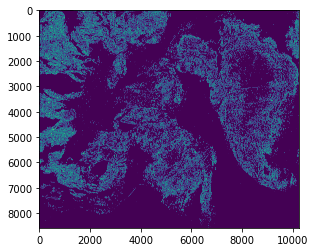

In [69]:
# sat = sitk.GetImageFromArray(s, sitk.sitkInt8)
# otsu = sitk.OtsuThresholdImageFilter().Execute(sat)
nda = sitk.GetArrayFromImage(mask)

ax = plt.imshow(nda)

In [91]:
filename

{'006388_0_1': [(0.7805825242718447,
   0.3446601941747573,
   0.7633007600434311,
   0.4495114006514658),
  (26545, 11720, 46406, 27328)],
 '006388_0_2': [(0.0,
   0.5786407766990291,
   0.11672095548317046,
   0.4782844733984799),
  (0, 19677, 7096, 29078)],
 '006388_0_3': [(0.07281553398058252,
   0.10582524271844661,
   0.18186753528773072,
   0.2274701411509229),
  (2476, 3598, 11057, 13829)],
 '006388_0_4': [(1.233009708737864,
   0.08155339805825243,
   0.8273615635179153,
   0.21389793702497287),
  (41930, 2773, 50301, 13004)],
 '006388_0_5': [(0.19320388349514564,
   0.5912621359223301,
   0.251357220412595,
   0.46525515743756785),
  (6570, 20107, 15281, 28286)],
 '006388_0_6': [(1.3427184466019417,
   0.5854368932038835,
   0.8908794788273615,
   0.4511400651465798),
  (45661, 19908, 54162, 27427)],
 '006388_0_7': [(1.1029126213592233,
   0.35436893203883496,
   0.7909880564603692,
   0.28827361563517917),
  (37506, 12051, 48089, 17526)],
 '006388_0_8': [(0.0,
   0.385436893

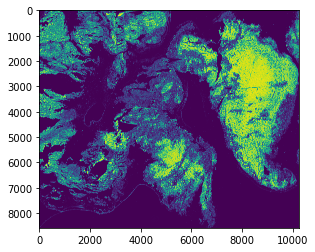

In [63]:
h,s,v = cv.split(hsv)
ax = plt.imshow(s)

In [84]:
l = df_train[df_train['image_id'] == filename].iloc[0]['label']

In [86]:
train_images[0]

'data/006388_0.tif'

In [115]:
!rm -rf stain_train

In [16]:
import SimpleITK as sitk
from radiomics import featureextractor

def rad(image):
    image = sitk.GetImageFromArray(image, sitk.sitkInt8)
    medfil_image = sitk.MedianImageFilter().Execute(image)
    nda = sitk.GetArrayFromImage(medfil_image)
    hsv = cv.cvtColor(nda, cv.COLOR_BGR2HSV)
    h,s,v = cv.split(hsv)
    sat = sitk.GetImageFromArray(s, sitk.sitkInt8)
    otsu = sitk.OtsuThresholdImageFilter().Execute(sat)

    mask = sitk.MorphologicalGradientImageFilter().Execute(otsu)
    m = sitk.GetArrayFromImage(mask)
    mask = sitk.GetImageFromArray(cv.cvtColor(m, cv.COLOR_GRAY2RGB), sitk.sitkInt8)

    extractor = featureextractor.RadiomicsFeatureExtractor()  # optional supply parameter file)

    # # Enable just first order
    extractor.disableAllFeatures()
    extractor.enableFeatureClassByName('firstorder')

    # # Extract features
    results = []
    # selector = sitk.VectorIndexSelectionCastImageFilter()
    try:
        results.append(extractor.execute(image, mask))

        temp = []
        for key, value in results[0].items():
            if key[:11] != 'diagnostics':
                temp.append(value)

        return temp
    except ValueError:
        return None